# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5 #0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 5


Using matplotlib, I look at the noisy time series I just simulated:

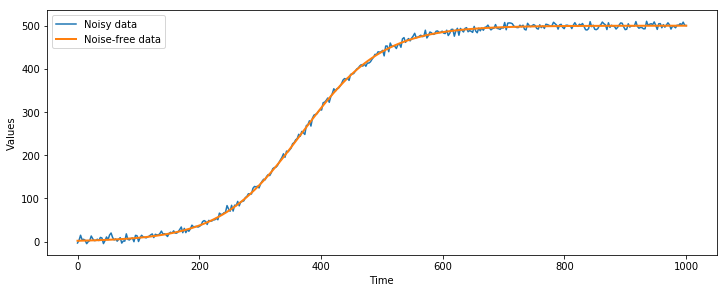

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

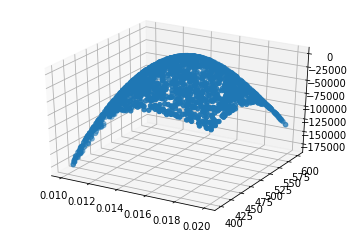

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_5 (Dense)              (None, 320)               82240     
_________________________________________________________________
dense_6 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_7 (Dense)              (None, 384)               147840    
__________

In [15]:
emu([0.015, 500])

array([[-841.73303]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1211.0368157182038

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


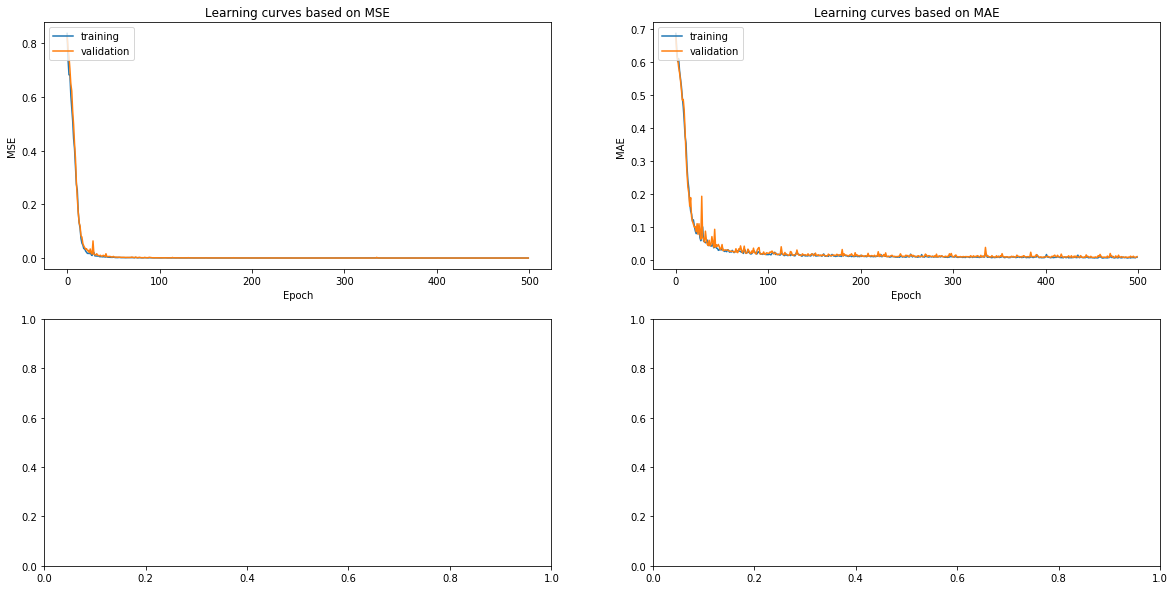

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

#ax3.plot(hist.history['rescaled_mse'])
#ax3.plot(hist.history['val_rescaled_mse'])
#ax3.set_ylabel('Rescaled MSE')
#ax3.set_xlabel('Epoch')
#ax3.legend(['training', 'validation'], loc='upper left')

#ax4.plot(hist.history['rescaled_mae'])
#ax4.plot(hist.history['val_rescaled_mae'])
#ax4.set_ylabel('Rescaled MAE')
#ax4.set_xlabel('Epoch')
#ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")


val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

print(val_mse[-1])
print(val_mae[-1])

Minimum MSE during validation: 0.00014342741856429106
Best epoch based on validation MSE: 485


Minimum MAE during validation: 0.006501484811306
Best epoch based on validation MAE: 485


0.0002012944886034044
0.009000776925434668


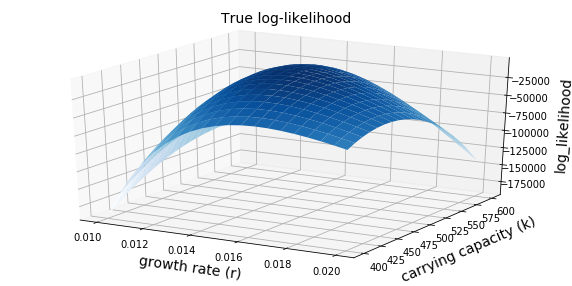

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

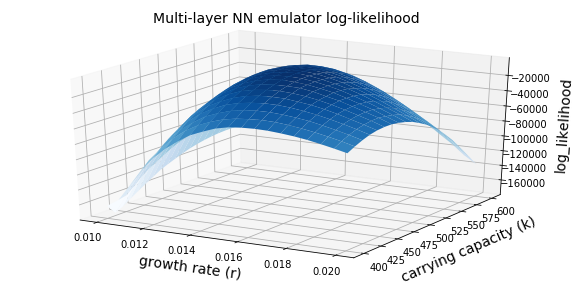

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.012849475306182858

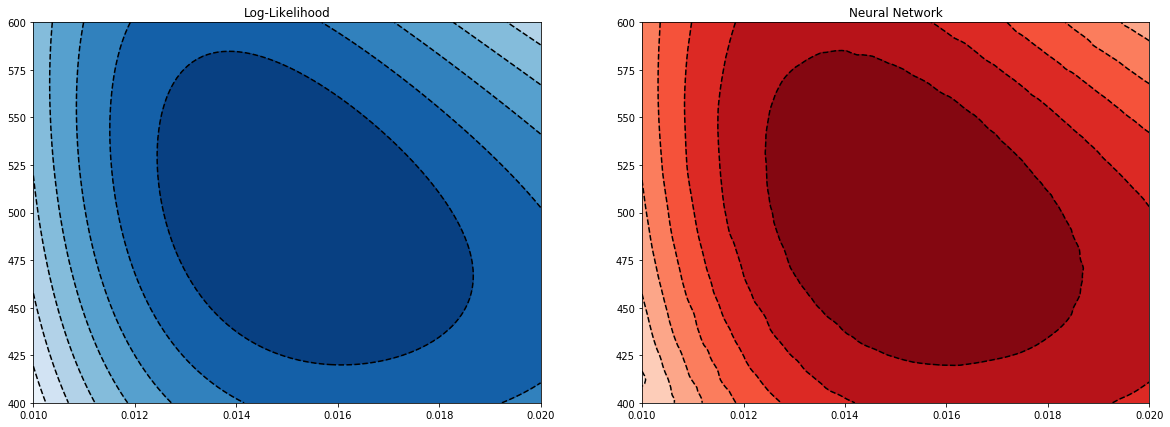

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

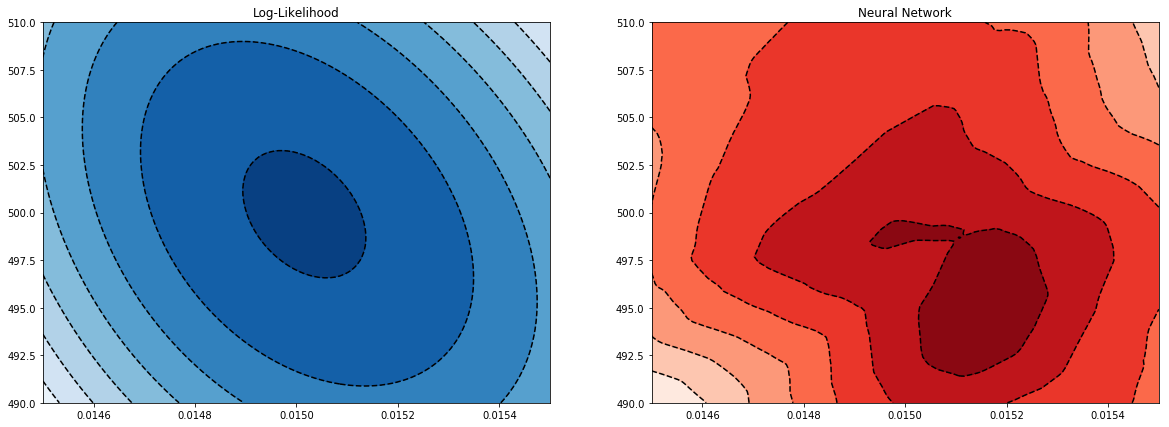

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[-2.08247359e-02  4.51375364e+02]
-inf


[2.15406054e-02 5.26307895e+02]
-inf


[3.54339614e-02 5.76168670e+02]
-inf


[4.11694965e-02 4.48592127e+02]
-inf


[-8.43380718e-03  5.25196224e+02]
-inf


[-2.23324567e-03  5.75072867e+02]
-inf


[-1.27244684e-02  4.50701531e+02]
-inf


[1.03116665e-02 5.21753019e+02]
-105654.90159944278


[2.51478843e-02 5.73994837e+02]
-inf


[1.39292203e-02 4.53501590e+02]
-17635.130816596225
accepted


[6.24431281e-03 5.26169824e+02]
-inf


[-1.28877736e-02  5.78267196e+02]
-inf


[-1.44022309e-03  4.53091042e+02]
-inf


[-3.71988189e-03  5.22904295e+02]
-inf


[1.40696423e-02 5.75693065e+02]
-20371.31514319147
accepted


[8.55471134e-03 4.52656673e+02]
-inf


[3.35175898e-02 5.25749852e+02]
-inf


[3.15784500e-02 5.74371015e+02]
-inf


[2.79078705e-02 4.56566693e+02]
-inf


[3.17436805e-02 5.24859261e+02]
-inf


[2.16017940e-02 5.75162843e+02]
-inf


[6.96390491e-03 4.54204928e+02]
-inf


[1.05187101e-03 5.21620379e+02]
-inf


[4.67125235e-03 

[1.02167299e-02 5.26348985e+02]
-110142.18048936546


[1.69408763e-02 5.67830510e+02]
-42381.457457902674


[1.55245742e-02 4.55405012e+02]
-8432.050004258765
accepted


[2.05332884e-02 5.22438580e+02]
-inf


[3.10274605e-02 5.66866007e+02]
-inf


[2.4291837e-02 4.5715275e+02]
-inf


[4.60413347e-03 5.25435407e+02]
-inf


[2.96223937e-03 5.66503028e+02]
-inf


[1.71011288e-02 4.57418133e+02]
-12776.701626438462


[1.81787459e-02 5.22474271e+02]
-32517.72258675581


[4.02801631e-02 5.66404139e+02]
-inf


[4.57556723e-03 4.53877456e+02]
-inf


[1.47970347e-02 5.24739880e+02]
-3394.9885129401555
accepted


[2.72964185e-02 5.71755398e+02]
-inf


[1.71297169e-02 4.56670224e+02]
-13106.306124695377


[2.14353557e-03 5.22680988e+02]
-inf


[4.52401555e-03 5.63088347e+02]
-inf


[1.82657492e-02 4.53513593e+02]
-22170.84641222689


[2.30883044e-02 5.23547701e+02]
-inf


[1.05184971e-03 5.66538174e+02]
-inf


[2.38037154e-03 4.56984532e+02]
-inf


[1.89819940e-02 5.28006704e+02]
-47776.791746911

[2.77299236e-02 5.21156233e+02]
-inf


[3.29640866e-02 5.64665124e+02]
-inf


[1.50740228e-02 4.65538179e+02]
-5912.717536022166
accepted


[9.71287286e-03 5.23730957e+02]
-inf


[2.07731977e-02 5.68887676e+02]
-inf


[2.31333805e-03 4.64026260e+02]
-inf


[2.30713100e-02 5.17864948e+02]
-inf


[4.24215227e-02 5.65116794e+02]
-inf


[1.05871929e-02 4.66340739e+02]
-110067.16366221468


[2.31900384e-02 5.25546640e+02]
-inf


[9.54772780e-03 5.67253931e+02]
-inf


[3.34212677e-02 4.67559672e+02]
-inf


[-9.15066085e-03  5.24975858e+02]
-inf


[1.14264911e-02 5.64182615e+02]
-53828.58607680369


[5.57646198e-03 4.63607713e+02]
-inf


[1.49845520e-02 5.20898709e+02]
-2952.283676710005
accepted


[1.06832775e-04 5.65439731e+02]
-inf


[2.3179612e-02 4.7005042e+02]
-inf


[2.87397366e-02 5.24202512e+02]
-inf


[2.98104715e-03 5.70510296e+02]
-inf


[1.97057987e-02 4.67958190e+02]
-36552.42509910466


[-1.53010321e-02  5.24538687e+02]
-inf


[1.60368121e-02 5.66495689e+02]
-28800.906371746565



[1.40777973e-02 5.66614776e+02]
-16152.721175213657


[1.56857590e-02 4.71232066e+02]
-4394.220871263999


[1.47668483e-02 5.20913701e+02]
-2749.829406603324
accepted


[1.41597136e-02 5.66640475e+02]
-16168.10401955136


[1.55814063e-02 4.71325714e+02]
-4246.125129139105
accepted


[1.48218296e-02 5.20920247e+02]
-2773.153868722703


[1.40530391e-02 5.66596666e+02]
-16154.631145867657


[1.57066385e-02 4.71453241e+02]
-4385.838053604727


[1.47414390e-02 5.20920515e+02]
-2747.391094325102
accepted


[1.41710128e-02 5.66602891e+02]
-16156.381005229732


[1.55337690e-02 4.70850757e+02]
-4299.761660933867


[1.46869857e-02 5.20887876e+02]
-2750.267348847566


[1.41520037e-02 5.66619633e+02]
-16156.191989094248


[1.56123305e-02 4.71092196e+02]
-4324.151418095854


[1.47175179e-02 5.20960888e+02]
-2753.966419500432


[1.40705700e-02 5.66576093e+02]
-16138.367568864369
accepted


[1.55266293e-02 4.72171095e+02]
-4035.2538945675733
accepted


[1.47394462e-02 5.20968083e+02]
-2754.23918287

[1.55304521e-02 4.88376441e+02]
-2057.754308708526


[1.45441630e-02 5.12267432e+02]
-2062.7096517634513
accepted


[1.37558867e-02 5.58529976e+02]
-13736.189912810913


[1.55512171e-02 4.90437503e+02]
-2011.2337013960757


[1.45563201e-02 5.12164870e+02]
-2031.5085062954292
accepted


[1.36347767e-02 5.55595765e+02]
-13371.396860364615
accepted


[1.54946588e-02 4.96307023e+02]
-1803.5264551740247
accepted


[1.45626342e-02 5.11473938e+02]
-1979.1265694944457
accepted


[1.37854810e-02 5.57633794e+02]
-13321.742074240432
accepted


[1.55734483e-02 5.00690769e+02]
-2167.9243901843665


[1.44383220e-02 5.05456257e+02]
-2165.741421413647


[1.38360224e-02 5.61571211e+02]
-14527.017098018117


[1.54798496e-02 5.00176683e+02]
-1863.7822373583251


[1.44489755e-02 5.04976204e+02]
-2131.4302439276407


[1.38026167e-02 5.57094973e+02]
-13078.855424176425
accepted


[1.55249328e-02 4.99322520e+02]
-1956.5147665620364


[1.46153611e-02 5.13039870e+02]
-1984.1473688303456


[1.37377548e-02 5.560



[1.50271402e-02 4.99721414e+02]
-1211.5639690400535
accepted


[1.45609486e-02 5.06344048e+02]
-1806.5128677097246
accepted


[1.53177843e-02 4.84282205e+02]
-2108.9087482725763


[1.49517739e-02 5.00004774e+02]
-1223.05845045343


[1.45498229e-02 5.05090989e+02]
-1824.5072392423006


[1.49481960e-02 4.87592435e+02]
-1910.4784870752812


[1.50390553e-02 5.00374948e+02]
-1214.8026060426307


[1.45763308e-02 5.13392360e+02]
-2073.8074631471854


[1.48420249e-02 5.03005950e+02]
-1300.1504242225446


[1.49634919e-02 4.98484712e+02]
-1233.5999530214428


[1.45771526e-02 5.07745235e+02]
-1796.4247886142352
accepted


[1.58253842e-02 4.70784249e+02]
-4732.180994912588


[1.49895931e-02 5.00730638e+02]
-1214.149243667045


[1.45539720e-02 5.10191476e+02]
-1934.2716940052117


[1.52961062e-02 4.83874093e+02]
-2142.585692623626


[1.51386495e-02 4.98127598e+02]
-1253.0242478113703


[1.46486272e-02 5.10778478e+02]
-1788.6038920040983
accepted


[1.52337764e-02 5.07334585e+02]
-1719.82256551035

[1.50409600e-02 4.99660574e+02]
-1212.9829403761253


[1.51801928e-02 4.99172637e+02]
-1286.9807735951592


[1.48393228e-02 5.08197956e+02]
-1466.1433371062717


[1.50305957e-02 5.00207871e+02]
-1212.6779335706992


[1.49185749e-02 5.02456274e+02]
-1246.276499004917


[1.51529988e-02 4.93442140e+02]
-1367.6819510962105


[1.50152406e-02 4.99283471e+02]
-1212.7002611703876


[1.52089367e-02 4.97756065e+02]
-1310.5310642043517


[1.48938077e-02 5.04465722e+02]
-1295.843886489004


[1.50069567e-02 4.99514075e+02]
-1212.2069907963764
accepted


[1.51859397e-02 4.97773934e+02]
-1289.1565442460217


[1.50276423e-02 4.99278324e+02]
-1212.599760196989
accepted


[1.50295702e-02 4.99236016e+02]
-1212.8387083093626


[1.52567146e-02 4.95080585e+02]
-1388.1378912812004


[1.51002967e-02 4.93087505e+02]
-1376.2952593937632


[1.49863061e-02 4.99565064e+02]
-1214.9334608892589


[1.49058678e-02 5.04489818e+02]
-1292.3373872611378


[1.49570400e-02 5.02235492e+02]
-1232.478170324768


[1.50028935e-0

-1216.009696117246


[1.49916556e-02 4.99986139e+02]
-1212.665653898481
accepted


[1.49665462e-02 5.01326422e+02]
-1220.923134731959


[1.50412243e-02 4.98979390e+02]
-1214.8022318735323


[1.49960214e-02 4.99941127e+02]
-1212.1747647280138
accepted


[1.50115316e-02 4.99802539e+02]
-1211.238456744519
accepted


[1.49705267e-02 5.00580324e+02]
-1216.614198926755


[1.49934317e-02 4.99777068e+02]
-1212.844521001379
accepted


[1.50676209e-02 4.99212654e+02]
-1218.723521591766


[1.50445083e-02 4.98991803e+02]
-1215.059673335174


[1.49606277e-02 5.00017109e+02]
-1219.8355422086656


[1.49882702e-02 5.00608918e+02]
-1213.782336761223


[1.50408413e-02 4.99299442e+02]
-1213.4494386233023
accepted


[1.49631101e-02 4.99675847e+02]
-1220.6618197169582


[1.49308391e-02 5.01682968e+02]
-1233.6903528625137


[1.50636932e-02 4.98966378e+02]
-1218.3669341637383


[1.50018431e-02 4.99886854e+02]
-1211.6734545452537
accepted


[1.50799206e-02 4.98325881e+02]
-1225.9787694244467


[1.50008778e-02



[1.49836788e-02 5.00822523e+02]
-1215.197655746315


[1.50142706e-02 4.99962286e+02]
-1211.1443945805827
accepted


[1.50253957e-02 5.00049465e+02]
-1211.694887188489
accepted


[1.50099437e-02 4.99848162e+02]
-1211.2427325153412
accepted


[1.50419357e-02 4.99787199e+02]
-1213.2189858749482


[1.50479382e-02 5.00026049e+02]
-1214.9355228139193


[1.50181374e-02 4.99519221e+02]
-1211.6776615437088


[1.50345931e-02 4.98999627e+02]
-1214.2390914824757


[1.50331869e-02 5.00184133e+02]
-1212.9261976994324
accepted


[1.50075168e-02 4.98978364e+02]
-1215.3754707272249


[1.50541545e-02 4.99572366e+02]
-1215.3160030685933


[1.50476237e-02 5.00452279e+02]
-1217.1829153447777


[1.50003964e-02 5.00275149e+02]
-1211.8864824719067
accepted


[1.50375282e-02 4.99027831e+02]
-1214.2542639578887


[1.50116527e-02 5.00864929e+02]
-1214.6565774694525


[1.49697524e-02 5.00666102e+02]
-1216.9679610213125


[1.50052834e-02 5.00263477e+02]
-1211.648346797221
accepted


[1.50305405e-02 5.00598175e+0

-1217.0228612514336


[1.50148519e-02 4.99750966e+02]
-1211.2328636077334
accepted


[1.50399283e-02 4.99887799e+02]
-1213.0649396542667
accepted


[1.50639800e-02 4.99729976e+02]
-1218.0455313988941


[1.50113550e-02 4.99675833e+02]
-1211.4534810198936
accepted


[1.50654595e-02 4.99551548e+02]
-1218.1211253434717


[1.50168923e-02 4.99732970e+02]
-1211.2422734046079
accepted


[1.49923531e-02 4.99828378e+02]
-1212.8640424077403
accepted


[1.50317860e-02 5.00156429e+02]
-1212.6412964117978
accepted


[1.50016385e-02 4.99836157e+02]
-1211.764416320078


[1.50221180e-02 4.99022586e+02]
-1213.9644518611108


[1.50310119e-02 5.00420593e+02]
-1213.7224769975996


[1.50375634e-02 5.00145125e+02]
-1213.4312197582128


[1.50001104e-02 4.99832914e+02]
-1211.9110546953268
accepted


[1.50143335e-02 5.00199002e+02]
-1211.470481812444
accepted


[1.49455866e-02 5.00244101e+02]
-1224.6291445377801


[1.49915138e-02 5.00105736e+02]
-1212.5902690887922


[1.50279533e-02 4.99710528e+02]
-1211.621346

[1.50042914e-02 4.99454528e+02]
-1212.7016898346794
accepted


[1.49959200e-02 4.99335535e+02]
-1214.4596045052065


[1.49654703e-02 5.01218482e+02]
-1220.3652450963946


[1.49900078e-02 4.99039542e+02]
-1217.8841530881434


[1.49933897e-02 4.99817938e+02]
-1212.7416574282001


[1.49900745e-02 5.00085083e+02]
-1212.7920284840498


[1.50013781e-02 4.99561259e+02]
-1212.5600526603928
accepted


[1.50463551e-02 4.99750181e+02]
-1213.9251544216581


[1.50454550e-02 4.98702127e+02]
-1216.942671002827


[1.50011146e-02 4.99622742e+02]
-1212.3620207626084
accepted


[1.50169455e-02 5.00300008e+02]
-1211.8486461891457
accepted


[1.50676596e-02 4.99134947e+02]
-1218.8605707138793


[1.50270378e-02 5.00761259e+02]
-1215.448144232015


[1.50243243e-02 5.00506923e+02]
-1213.361233376207
accepted


[1.50367214e-02 4.99586476e+02]
-1212.473655324945


[1.49932198e-02 4.99651688e+02]
-1213.295901424535


[1.5008730e-02 5.0029661e+02]
-1211.668642241564
accepted


[1.49904312e-02 5.00066975e+02]
-121

-1216.627516564295


[1.50275386e-02 4.99677220e+02]
-1211.6175433947853
accepted


[1.50136473e-02 4.99903482e+02]
-1211.1378008473287
accepted


[1.50383035e-02 5.00503982e+02]
-1215.4741515383023


[1.50431116e-02 4.99532906e+02]
-1213.3279233049225


[1.50433284e-02 4.99097714e+02]
-1214.4386628912773


[1.50201232e-02 5.00081357e+02]
-1211.4249170535836


[1.50154558e-02 4.98910228e+02]
-1215.1395735913386


[1.50477815e-02 4.99222382e+02]
-1214.5687284882276


[1.50283543e-02 4.99521778e+02]
-1211.885505057213


[1.50192332e-02 4.99848793e+02]
-1211.1895752237544
accepted


[1.50096383e-02 4.99727062e+02]
-1211.4235068123046
accepted


[1.49536880e-02 5.01083959e+02]
-1222.4763848054345


[1.5023359e-02 5.0049687e+02]
-1213.2026792302913


[1.50193808e-02 5.00475640e+02]
-1212.7356545746802


[1.49889636e-02 5.00477193e+02]
-1213.3082271751325


[1.50094155e-02 5.00551003e+02]
-1212.6257872218303


[1.49714625e-02 5.00631127e+02]
-1216.5172892961232


[1.50000363e-02 4.99291568e+


[1.49797465e-02 4.99903866e+02]
-1214.9589251074397


[1.4986847e-02 4.9884782e+02]
-1220.5778237539937


[1.50673370e-02 4.98715868e+02]
-1220.3227810922112


[1.50755310e-02 4.98432898e+02]
-1224.047400671999


[1.50463177e-02 4.99262016e+02]
-1214.2466407644897
accepted


[1.50195701e-02 4.99143154e+02]
-1213.2893661801156
accepted


[1.50017141e-02 4.99828403e+02]
-1211.7709521965278
accepted


[1.5034089e-02 4.9972133e+02]
-1212.142052223995
accepted


[1.49788682e-02 5.00002569e+02]
-1214.897497573489


[1.50071259e-02 5.00322332e+02]
-1211.7528629389749
accepted


[1.50025800e-02 5.00001444e+02]
-1211.533542710829
accepted


[1.50142112e-02 4.99499292e+02]
-1211.8337794227748
accepted


[1.50268363e-02 5.00076486e+02]
-1211.8749947600509
accepted


[1.50342762e-02 4.98222690e+02]
-1221.2039106173863


[1.50170591e-02 4.99504560e+02]
-1211.7375383978326
accepted


[1.50162878e-02 5.01190036e+02]
-1218.0158384403444


[1.49888520e-02 4.99959703e+02]
-1213.1179165714439


[1.49849



[1.50491381e-02 4.99314646e+02]
-1214.5551454950712


[1.50352664e-02 4.99684535e+02]
-1212.2687106497253


[1.50328952e-02 4.99306960e+02]
-1212.7323823238733


[1.50223825e-02 5.00188302e+02]
-1211.81498063195


[1.50349055e-02 4.98977807e+02]
-1214.3819962972375


[1.50486801e-02 4.99092374e+02]
-1215.1370502745078


[1.50294490e-02 4.99551545e+02]
-1211.8928568122672


[1.50167845e-02 5.00274005e+02]
-1211.756372554091


[1.50052816e-02 4.99844208e+02]
-1211.4768130588304
accepted


[1.50362910e-02 5.00169811e+02]
-1213.325458446036


[1.50055771e-02 4.99352362e+02]
-1213.0732209098326
accepted


[1.49952201e-02 5.00193817e+02]
-1212.1891541675398


[1.50193074e-02 4.99416650e+02]
-1211.9989765687726


[1.49710532e-02 5.00896652e+02]
-1217.4966360666228


[1.49946298e-02 4.99173972e+02]
-1215.8059944096037


[1.49961845e-02 5.00191775e+02]
-1212.0960567731217


[1.50086256e-02 4.99594389e+02]
-1211.8084456100833
accepted


[1.49974343e-02 4.99285088e+02]
-1214.5359060061057


[1.

[1.50082943e-02 4.99961941e+02]
-1211.245045139235
accepted


[1.50766876e-02 4.99702282e+02]
-1222.1167681711395


[1.49711279e-02 4.99530339e+02]
-1219.0046166884604


[1.49921524e-02 5.00417088e+02]
-1212.8258216654267
accepted


[1.50106426e-02 4.98814422e+02]
-1216.4355348008978


[1.49885634e-02 5.00811991e+02]
-1214.6403685912333


[1.49920395e-02 4.99342375e+02]
-1215.099929829624


[1.49800139e-02 5.00397505e+02]
-1214.4608646177169


[1.50053757e-02 5.00114090e+02]
-1211.418896929299
accepted


[1.49830382e-02 4.99535120e+02]
-1215.8046710264132


[1.50725026e-02 4.99749979e+02]
-1220.8012857310657


[1.49965655e-02 5.00748297e+02]
-1213.7767404455838


[1.49836297e-02 5.00217122e+02]
-1213.7408311801464
accepted


[1.50041812e-02 5.01400282e+02]
-1219.2609689850453


[1.49966178e-02 4.99864952e+02]
-1212.2251165076752
accepted


[1.49819363e-02 4.99632112e+02]
-1215.5411540598027


[1.50396301e-02 4.98872995e+02]
-1215.3054662171814


[1.49756454e-02 5.00453584e+02]
-1215.34

[1.50905580e-02 4.99083707e+02]
-1226.4869290775985


[1.49750198e-02 5.00663156e+02]
-1215.8950134160891


[1.50220934e-02 5.00112367e+02]
-1211.5981946112404
accepted


[1.49945762e-02 4.99915404e+02]
-1212.3843118312036
accepted


[1.5008277e-02 4.9921835e+02]
-1213.571084303141


[1.50419500e-02 5.00826093e+02]
-1218.9473610564507


[1.50121727e-02 5.00099226e+02]
-1211.2627202917602
accepted


[1.50395421e-02 4.98831714e+02]
-1215.5709839863498


[1.50388855e-02 5.00701538e+02]
-1217.1058052456744


[1.49994126e-02 5.00863967e+02]
-1214.3790229523354


[1.50143161e-02 4.99687834e+02]
-1211.3395770670943
accepted


[1.50183778e-02 5.00109935e+02]
-1211.4030775052906
accepted


[1.50080866e-02 5.00770452e+02]
-1213.8317081800412


[1.50080418e-02 4.99418105e+02]
-1212.5221514975642
accepted


[1.49747474e-02 5.00904202e+02]
-1216.8687845788345


[1.50025852e-02 4.99879325e+02]
-1211.6234821157436
accepted


[1.49800982e-02 5.00663701e+02]
-1215.0346503665205


[1.50067694e-02 4.9960

[1.49983049e-02 5.00517589e+02]
-1212.6596918537746


[1.50475054e-02 4.99064224e+02]
-1215.088358149848


[1.50408849e-02 5.00369751e+02]
-1215.1286537779054


[1.50280635e-02 4.99451729e+02]
-1212.0342338736882


[1.50072797e-02 4.99667463e+02]
-1211.6897020573972
accepted


[1.50296947e-02 5.00768726e+02]
-1215.9227520193633


[1.49900852e-02 5.01029506e+02]
-1215.8658430423684


[1.49669907e-02 4.99689365e+02]
-1219.3024762335283


[1.50567926e-02 4.99200169e+02]
-1216.2002250492462


[1.50061086e-02 5.00346960e+02]
-1211.8374135044305


[1.50198301e-02 5.00209759e+02]
-1211.7144261993528
accepted


[1.49902501e-02 4.99808596e+02]
-1213.2394401891163
accepted


[1.50580428e-02 4.99687540e+02]
-1216.3530767503746


[1.50479316e-02 5.00130418e+02]
-1215.3662315619158


[1.50353062e-02 4.98618355e+02]
-1217.0512359299416


[1.50146780e-02 4.99995496e+02]
-1211.16471750759
accepted


[1.50105250e-02 5.01100882e+02]
-1216.580248693633


[1.49481740e-02 5.00580423e+02]
-1223.129847203207

-1216.7043653907215


[1.50454844e-02 4.99394129e+02]
-1213.8400118114478


[1.49929188e-02 4.99814565e+02]
-1212.8170771339544
accepted


[1.50917031e-02 4.98961796e+02]
-1227.0540941100028


[1.50384253e-02 4.99493469e+02]
-1212.7671157596567
accepted


[1.50141522e-02 4.99129832e+02]
-1213.6435212294216
accepted


[1.50374327e-02 5.01019465e+02]
-1219.8712948540333


[1.50468338e-02 5.00337012e+02]
-1216.223377353192


[1.50187176e-02 4.98473306e+02]
-1219.115228387544


[1.50659483e-02 4.99036408e+02]
-1218.6657246456336


[1.50507772e-02 4.98370502e+02]
-1220.2449944036407


[1.50448685e-02 4.99651520e+02]
-1213.5813539922176
accepted


[1.50392164e-02 5.00180341e+02]
-1213.8508348965256
accepted


[1.50055053e-02 5.00125347e+02]
-1211.4244942547562
accepted


[1.50489846e-02 4.99791986e+02]
-1214.4986108800078


[1.51564614e-02 4.98910663e+02]
-1265.0741809176836


[1.50029107e-02 5.00289258e+02]
-1211.787659040245
accepted


[1.50428787e-02 4.99540712e+02]
-1213.2888687953375
ac



[1.49935863e-02 5.02200976e+02]
-1229.947593935058


[1.50024618e-02 5.00301969e+02]
-1211.8344198850066
accepted


[1.50842889e-02 4.99048819e+02]
-1224.15144210217


[1.49396055e-02 4.98365685e+02]
-1248.035189811286


[1.49697144e-02 5.01059082e+02]
-1218.569354627705


[1.50421873e-02 4.99016786e+02]
-1214.6960479347695


[1.49828910e-02 5.00512907e+02]
-1214.1904900151133


[1.50405597e-02 4.99119267e+02]
-1214.062370876358


[1.50584592e-02 4.99258970e+02]
-1216.430805116573


[1.50098839e-02 4.99616829e+02]
-1211.6687720344478
accepted


[1.49660614e-02 5.01640859e+02]
-1223.7816577532403


[1.50325331e-02 4.98754168e+02]
-1215.8598577357263


[1.49651345e-02 4.99953055e+02]
-1218.6349183911798


[1.50012374e-02 4.98892381e+02]
-1217.039021242027


[1.51127527e-02 4.97173895e+02]
-1249.1951356476966


[1.49271252e-02 4.99434502e+02]
-1239.521852894957


[1.50524181e-02 4.98745662e+02]
-1217.4373904886436


[1.50119109e-02 5.00657156e+02]
-1213.2742161830988
accepted


[1.49972



[1.49698856e-02 4.99870514e+02]
-1217.551781695157


[1.50077129e-02 5.00878894e+02]
-1214.5690421930992


[1.49624754e-02 5.00373762e+02]
-1218.531936178883


[1.50234941e-02 4.98665629e+02]
-1216.7765976218864


[1.50214093e-02 4.99325000e+02]
-1212.3388297495435


[1.50410971e-02 4.98837478e+02]
-1215.6414179092167


[1.50406193e-02 5.00898696e+02]
-1219.3489607745958


[1.49589450e-02 5.00837576e+02]
-1220.087278194159


[1.50347556e-02 5.00716957e+02]
-1216.394705384083


[1.49223357e-02 4.99470304e+02]
-1242.0184050906653


[1.50290818e-02 4.99231831e+02]
-1212.8396241876274


[1.50307815e-02 4.98984009e+02]
-1214.1963379830622


[1.49760460e-02 4.99943991e+02]
-1215.6887577376858


[1.4964683e-02 5.0196486e+02]
-1227.6665854045864


[1.49938046e-02 4.99750927e+02]
-1212.867341878912
accepted


[1.50201733e-02 5.00063703e+02]
-1211.395652755872
accepted


[1.49739089e-02 4.99947038e+02]
-1216.2040709828284


[1.49985076e-02 4.99454440e+02]
-1213.3982004766033
accepted


[1.5065

[1.50232931e-02 4.99742790e+02]
-1211.3569193189207
accepted


[1.50738781e-02 4.99644517e+02]
-1220.9444066513176


[1.50356005e-02 4.99614892e+02]
-1212.3321789544852


[1.50345205e-02 4.98333912e+02]
-1219.900116508147


[1.50361721e-02 5.00851083e+02]
-1217.8701165361201


[1.49593042e-02 5.00534983e+02]
-1219.458406093085


[1.50144036e-02 4.99295213e+02]
-1212.6832136848975


[1.50520043e-02 4.99905485e+02]
-1215.4328778694585


[1.49533475e-02 5.01390559e+02]
-1224.334924792859


[1.50681919e-02 4.98918735e+02]
-1219.6042656679106


[1.51008599e-02 4.98477982e+02]
-1232.1867170858


[1.50043436e-02 5.00080594e+02]
-1211.4416045173805
accepted


[1.50695525e-02 4.98816120e+02]
-1220.3560637964715


[1.49783612e-02 5.00612493e+02]
-1215.1605177242598
accepted


[1.50442299e-02 4.99630074e+02]
-1213.4714738626824


[1.50773757e-02 4.98454130e+02]
-1224.3795405491073


[1.49112358e-02 5.00868914e+02]
-1240.3027553199597


[1.50229536e-02 4.99759782e+02]
-1211.3336394462372
accepted


[1.49528093e-02 5.01259085e+02]
-1223.6340996090046


[1.49734256e-02 5.00416974e+02]
-1215.771871488045


[1.50096877e-02 5.00881001e+02]
-1214.6699528846423


[1.49619673e-02 5.01361244e+02]
-1222.0873543952812


[1.49575586e-02 4.99749910e+02]
-1222.192758245656


[1.50720808e-02 5.00134571e+02]
-1222.5915463721142


[1.49813007e-02 5.01045564e+02]
-1216.7446925807797


[1.49626134e-02 5.00334611e+02]
-1218.5184768449171


[1.50848895e-02 4.98281148e+02]
-1227.7277694442084


[1.49800301e-02 5.01410664e+02]
-1219.7747558255485


[1.50369707e-02 5.01212388e+02]
-1222.0237190683922


[1.49915125e-02 5.00816701e+02]
-1214.4328991947598


[1.50207182e-02 4.98714145e+02]
-1216.4747688243076


[1.49263069e-02 5.01007591e+02]
-1232.5277497022778


[1.49633598e-02 5.01204219e+02]
-1220.7103186610439


[1.50007608e-02 4.99630199e+02]
-1212.374970642881
accepted


[1.49765131e-02 5.01429002e+02]
-1220.3055758333487


[1.49360602e-02 5.00805456e+02]
-1227.9580683762736


[1.50254007e-02 4.9902

[1.50386082e-02 4.99934510e+02]
-1212.959881771602


[1.5005132e-02 5.0092884e+02]
-1214.8606556499756


[1.50050064e-02 4.99505880e+02]
-1212.4096019755957


[1.50551697e-02 4.99312664e+02]
-1215.6582179285815


[1.50180216e-02 4.99710378e+02]
-1211.2734169780545
accepted


[1.50659227e-02 5.00442008e+02]
-1222.674557829067


[1.50818179e-02 4.99355816e+02]
-1223.2185433973593


[1.50226939e-02 4.99410390e+02]
-1212.0149651322902
accepted


[1.50569005e-02 5.01924777e+02]
-1240.3204305699278


[1.49514363e-02 5.00000265e+02]
-1223.2095619254294


[1.50344625e-02 4.99251822e+02]
-1213.032084409074


[1.50064976e-02 4.99835208e+02]
-1211.4147701896447
accepted


[1.49965560e-02 4.99755197e+02]
-1212.4848182379503


[1.50225067e-02 4.99424416e+02]
-1211.9663127058416
accepted


[1.50671749e-02 5.00020750e+02]
-1220.1859212030215


[1.50379806e-02 5.00056102e+02]
-1213.1875513660104


[1.50056024e-02 4.99894275e+02]
-1211.4030195743326
accepted


[1.50266184e-02 4.98232286e+02]
-1221.3973

[1.50285954e-02 4.99109331e+02]
-1213.4217365434092


[1.50526258e-02 5.01837608e+02]
-1236.8643903449629


[1.49587399e-02 5.01010696e+02]
-1220.7742541727837


[1.49852635e-02 4.99758567e+02]
-1214.291849068341


[1.50852356e-02 5.00357171e+02]
-1229.934352230962


[1.50093883e-02 5.00723294e+02]
-1213.5743587809836


[1.50134789e-02 4.99436674e+02]
-1212.0938287686308
accepted


[1.50215266e-02 5.00899855e+02]
-1215.8527828070255


[1.50183366e-02 4.99824865e+02]
-1211.1780282420502
accepted


[1.49940954e-02 5.00516987e+02]
-1212.9310824692814
accepted


[1.50343455e-02 4.99291264e+02]
-1212.8829897449295
accepted


[1.50506219e-02 4.99066999e+02]
-1215.5223019622674


[1.49925481e-02 5.00517024e+02]
-1213.0596122460524
accepted


[1.50379568e-02 4.97440205e+02]
-1232.9643792437319


[1.50028343e-02 4.99632581e+02]
-1212.1529070136971
accepted


[1.49402874e-02 5.01195488e+02]
-1227.303586997008


[1.50339593e-02 5.00083661e+02]
-1212.6888203824094
accepted


[1.50273047e-02 4.9924

-1216.3490619148583


[1.50040368e-02 5.00891106e+02]
-1214.5619592536043


[1.50430125e-02 4.99951674e+02]
-1213.726429965851
accepted


[1.5003249e-02 4.9992282e+02]
-1211.5294364313434
accepted


[1.50192410e-02 4.99977373e+02]
-1211.243123398001
accepted


[1.50250107e-02 5.00574382e+02]
-1213.84368986995
accepted


[1.50196394e-02 5.00928691e+02]
-1215.8773383082923


[1.5012040e-02 4.9953991e+02]
-1211.7906805939022
accepted


[1.50880025e-02 5.00119831e+02]
-1229.1776637579997


[1.49796665e-02 4.99721810e+02]
-1215.6450242915896


[1.50370401e-02 4.99880198e+02]
-1212.6319177659075
accepted


[1.49918363e-02 5.01263861e+02]
-1217.6920844703016


[1.50000677e-02 4.99449065e+02]
-1213.2163987859547


[1.50381798e-02 4.99973528e+02]
-1212.9864904198005
accepted


[1.50782092e-02 4.99357540e+02]
-1221.9341883382128


[1.50049838e-02 4.99317615e+02]
-1213.3257186365663


[1.49733045e-02 4.98640975e+02]
-1227.3597754463178


[1.50809343e-02 4.99203769e+02]
-1222.8454098139612


[1.49

accepted


[1.50350720e-02 4.99564757e+02]
-1212.3234207778357
accepted


[1.50522630e-02 5.00076124e+02]
-1216.1384044561905


[1.50061469e-02 4.99926167e+02]
-1211.3504138082794
accepted


[1.50635421e-02 4.98147904e+02]
-1224.0782171615965


[1.49702573e-02 5.00774743e+02]
-1217.177924038673


[1.50110362e-02 5.00604832e+02]
-1212.944766446467


[1.50265663e-02 4.98932930e+02]
-1214.498955557272


[1.49824981e-02 4.98978972e+02]
-1220.360747326388


[1.49814292e-02 5.00170101e+02]
-1214.1469046537757
accepted


[1.50372765e-02 5.00227933e+02]
-1213.7282452687646


[1.49640390e-02 5.01492013e+02]
-1222.7343657233148


[1.49829829e-02 5.00461504e+02]
-1214.0690756137608
accepted


[1.50984555e-02 4.98336654e+02]
-1231.9769392524377


[1.49609451e-02 4.99867639e+02]
-1220.353269423214


[1.49763418e-02 5.00097896e+02]
-1215.2719096146968


[1.50133369e-02 5.00060385e+02]
-1211.2169623978982
accepted


[1.50128044e-02 4.98409555e+02]
-1220.5490431858138


[1.49682249e-02 5.01911049e+02]

[1.50445712e-02 4.99127072e+02]
-1214.4618467250305


[1.50466866e-02 4.99209978e+02]
-1214.447875251437


[1.50354954e-02 4.98598433e+02]
-1217.2327925032903


[1.50048884e-02 4.99609154e+02]
-1212.0413592265543


[1.50473675e-02 4.99663502e+02]
-1214.0217400728652


[1.49928761e-02 5.00583538e+02]
-1213.2593243552972
accepted


[1.50199214e-02 5.00108829e+02]
-1211.4691450524324


[1.50260050e-02 5.00801725e+02]
-1215.6258184047188


[1.49565887e-02 5.01693289e+02]
-1226.0886015983222


[1.50141347e-02 5.00446564e+02]
-1212.292418033268
accepted


[1.49951778e-02 5.00426235e+02]
-1212.579714624372
accepted


[1.50494721e-02 5.00060968e+02]
-1215.4121516435575


[1.50506691e-02 5.00689001e+02]
-1219.9560996361943


[1.50325774e-02 5.01498777e+02]
-1224.8112762881992


[1.49727238e-02 5.01229085e+02]
-1219.1584264536573


[1.50294220e-02 5.01167715e+02]
-1219.8187691461285


[1.49547242e-02 5.00181405e+02]
-1221.3351023725736


[1.49537278e-02 5.01603910e+02]
-1225.918788981194


[1.50


[1.50518807e-02 4.98714974e+02]
-1217.5659337824645


[1.50024170e-02 5.00782047e+02]
-1213.8307474056144
accepted


[1.50419174e-02 4.96922042e+02]
-1243.1719889449512


[1.49877368e-02 4.98703141e+02]
-1222.0065001252606


[1.50249285e-02 5.00572216e+02]
-1213.8203182095174
accepted


[1.50374638e-02 5.00031105e+02]
-1213.0328037102765


[1.50498451e-02 4.99504679e+02]
-1214.4501954975287
accepted


[1.50460516e-02 4.98761414e+02]
-1216.5811582162605


[1.50811910e-02 5.00310426e+02]
-1227.6583660423826


[1.49972683e-02 4.98984194e+02]
-1216.8947439168696


[1.50070653e-02 4.99486487e+02]
-1212.3075226125452
accepted


[1.50484896e-02 4.99901522e+02]
-1214.6503898219391


[1.50495750e-02 4.99030582e+02]
-1215.5169144297895
accepted


[1.50044856e-02 4.99087324e+02]
-1214.9017426636083


[1.50273796e-02 4.99428304e+02]
-1212.0698568137698
accepted


[1.50436850e-02 4.99332423e+02]
-1213.7107894990625
accepted


[1.49919994e-02 4.99196581e+02]
-1216.1404656277666


[1.50487076e-02 5.


[1.50059353e-02 4.99045169e+02]
-1215.0380979912338


[1.49805278e-02 5.00299923e+02]
-1214.2964196360854


[1.49606377e-02 4.98656569e+02]
-1232.23636088892


[1.50004119e-02 5.00464168e+02]
-1212.3736885530009


[1.50049130e-02 5.00285806e+02]
-1211.7083017772331
accepted


[1.49753969e-02 5.01085167e+02]
-1217.7749132444314


[1.50415850e-02 5.00228875e+02]
-1214.5066401028382


[1.50564411e-02 5.00211411e+02]
-1217.9482410395244


[1.49738957e-02 5.00411840e+02]
-1215.667097594912


[1.50395482e-02 4.98938300e+02]
-1214.898764134647


[1.49905931e-02 5.01053969e+02]
-1216.013090566543


[1.50157682e-02 4.99970217e+02]
-1211.1584484117445
accepted


[1.49753436e-02 4.99794268e+02]
-1216.3925927070552


[1.50213132e-02 5.00745425e+02]
-1214.588849110569


[1.49977586e-02 5.01268204e+02]
-1217.6646527089574


[1.49829601e-02 4.99735585e+02]
-1214.850879143805


[1.50082450e-02 4.99780913e+02]
-1211.397816691812
accepted


[1.49758699e-02 5.00060843e+02]
-1215.4456361443897


[1.50391

[1.49818888e-02 5.00645253e+02]
-1214.707247092121


[1.49932608e-02 5.00977595e+02]
-1215.3330562561846


[1.50160129e-02 4.99678788e+02]
-1211.3291176393448
accepted


[1.50399379e-02 5.01084554e+02]
-1221.2188958374884


[1.50331724e-02 5.00998649e+02]
-1218.7154893841011


[1.49962524e-02 4.99490861e+02]
-1213.5412817256495


[1.50427915e-02 4.99989748e+02]
-1213.79500632342
accepted


[1.50393184e-02 4.99945512e+02]
-1213.09339411693


[1.50212334e-02 4.98395839e+02]
-1219.7908381912005


[1.50840735e-02 4.99446611e+02]
-1224.2067568698278


[1.50017965e-02 4.99237275e+02]
-1214.2048868904415


[1.50212533e-02 4.98846887e+02]
-1215.2920943670676


[1.50808276e-02 4.99207299e+02]
-1222.807163011815


[1.49568547e-02 5.00292609e+02]
-1220.362081308185


[1.50598429e-02 4.98610286e+02]
-1219.4820180496338


[1.50400171e-02 4.99199857e+02]
-1213.6872727783418
accepted


[1.50590547e-02 4.99158655e+02]
-1216.7667954214908


[1.50130872e-02 5.00841755e+02]
-1214.573837617955


[1.508315

[1.50371018e-02 4.99403331e+02]
-1212.7952435060881
accepted


[1.50561299e-02 5.00039210e+02]
-1216.9641172087302


[1.50296866e-02 4.99673325e+02]
-1211.7643780776841
accepted


[1.50828102e-02 5.01452654e+02]
-1243.9339215283728


[1.49818884e-02 5.00530132e+02]
-1214.3821196834542


[1.50442055e-02 4.99338035e+02]
-1213.7676048720018


[1.50349316e-02 4.99674384e+02]
-1212.2345945793281
accepted


[1.50262697e-02 4.99708586e+02]
-1211.520589760539
accepted


[1.50035304e-02 4.99713496e+02]
-1211.8571007132223
accepted


[1.49996413e-02 5.00487625e+02]
-1212.4881160254563
accepted


[1.49270401e-02 5.00657511e+02]
-1232.0922419468884


[1.50078116e-02 5.00545405e+02]
-1212.5751826110782


[1.50139989e-02 5.00662968e+02]
-1213.4163590735086


[1.50245662e-02 4.98767633e+02]
-1215.8189749574192


[1.49959592e-02 4.98584429e+02]
-1221.4264873654017


[1.50101656e-02 4.99578639e+02]
-1211.764892111313
accepted


[1.50343619e-02 5.00751594e+02]
-1216.6099954279068


[1.50056411e-02 5.001

accepted


[1.50299247e-02 5.01001317e+02]
-1218.1095604056686


[1.49621014e-02 5.00651836e+02]
-1218.800517323328


[1.49301393e-02 5.01167152e+02]
-1231.2032727088888


[1.50773280e-02 4.98919463e+02]
-1222.122981251148


[1.49884975e-02 4.99509039e+02]
-1214.7887625013875


[1.50231744e-02 4.98930196e+02]
-1214.5778671488524
accepted


[1.49742700e-02 5.00784426e+02]
-1216.43644097287


[1.50003369e-02 5.00033404e+02]
-1211.6918919486545
accepted


[1.50016336e-02 5.00416408e+02]
-1212.1700776509686
accepted


[1.50062951e-02 4.99291950e+02]
-1213.3320126068304
accepted


[1.49963778e-02 4.99667330e+02]
-1212.781566322943


[1.49759148e-02 5.00185895e+02]
-1215.25369632675


[1.50076945e-02 4.99218940e+02]
-1213.6249524062664
accepted


[1.50178437e-02 4.99849920e+02]
-1211.1630861535346
accepted


[1.49848688e-02 5.00068091e+02]
-1213.6195286086001


[1.50117563e-02 4.98853715e+02]
-1215.9566494907128


[1.49884761e-02 5.00363358e+02]
-1213.1359558152508


[1.50267757e-02 5.011311

[1.50404271e-02 4.99575583e+02]
-1212.9288186275783
accepted


[1.50280080e-02 4.99383554e+02]
-1212.2299669859306


[1.49944083e-02 4.99229586e+02]
-1215.4335604303985


[1.50620358e-02 4.98469164e+02]
-1220.9010258811757


[1.50095278e-02 4.98791650e+02]
-1216.7832885519706


[1.50655671e-02 5.00153528e+02]
-1220.412168438204


[1.50080798e-02 4.99303662e+02]
-1213.0929478175956
accepted


[1.49356042e-02 5.00056172e+02]
-1229.8606789362095


[1.50209604e-02 5.00351546e+02]
-1212.2871685866758


[1.50584328e-02 4.99207723e+02]
-1216.522655422384


[1.50460591e-02 5.00171943e+02]
-1215.147995169342


[1.49967633e-02 4.99914769e+02]
-1212.1269238186815
accepted


[1.50171218e-02 5.00360259e+02]
-1212.0765041894597
accepted


[1.50202836e-02 4.99506740e+02]
-1211.7032370422278
accepted


[1.50078702e-02 4.98514392e+02]
-1219.995192142782


[1.50072970e-02 4.99322729e+02]
-1213.0619312572726
accepted


[1.49727054e-02 4.99860569e+02]
-1216.8150264813003


[1.49749833e-02 4.99957465e+02]


accepted


[1.50181906e-02 5.01122341e+02]
-1217.539011126813


[1.50106941e-02 5.00698343e+02]
-1213.4694865041351


[1.49912146e-02 5.01554692e+02]
-1220.7057695662406


[1.50325058e-02 4.99390204e+02]
-1212.4501550135915
accepted


[1.50385416e-02 4.99165714e+02]
-1213.6842364945835


[1.49916775e-02 5.00795794e+02]
-1214.308258817079


[1.51218060e-02 4.97924554e+02]
-1244.9545866536066


[1.5044304e-02 4.9898163e+02]
-1215.0893428529976


[1.50368480e-02 5.00245471e+02]
-1213.73676405936


[1.50178171e-02 4.99281873e+02]
-1212.604275320637
accepted


[1.50105316e-02 4.98446693e+02]
-1220.410914855759


[1.50273717e-02 5.00203439e+02]
-1212.2970165333234
accepted


[1.50045186e-02 5.00063539e+02]
-1211.4244634112863
accepted


[1.50247809e-02 5.00142516e+02]
-1211.8683725501962
accepted


[1.50427975e-02 5.00883475e+02]
-1219.734506158021


[1.50562481e-02 4.98967950e+02]
-1216.8591690960127


[1.50026364e-02 5.01193929e+02]
-1217.0466669345174


[1.50204046e-02 5.00612122e+02]
-12

[1.49984834e-02 4.99935041e+02]
-1211.9202811683028
accepted


[1.49634888e-02 5.00402750e+02]
-1218.2331369091578


[1.50535442e-02 4.98434829e+02]
-1219.948863666355


[1.50244157e-02 4.99655215e+02]
-1211.484608303834
accepted


[1.50371788e-02 4.99006760e+02]
-1214.3449294887719


[1.50060016e-02 4.99450104e+02]
-1212.5554718933895
accepted


[1.50407579e-02 4.98392935e+02]
-1219.3583909048023


[1.50614167e-02 4.98383964e+02]
-1221.498934053958


[1.50007050e-02 5.00909686e+02]
-1214.6754165120863


[1.50071737e-02 4.99031429e+02]
-1214.993230976555


[1.50436089e-02 4.99530119e+02]
-1213.4026050892408


[1.50032970e-02 5.00670923e+02]
-1213.1925584766454


[1.50562000e-02 5.00699713e+02]
-1221.7440323074893


[1.50107236e-02 5.01021012e+02]
-1215.8698327849459


[1.50459914e-02 4.98659900e+02]
-1217.3067508355364


[1.50169133e-02 4.99416302e+02]
-1212.0469063730914


[1.50747445e-02 4.99852641e+02]
-1222.0062434374568


[1.50380771e-02 5.01131429e+02]
-1221.307332315606


[1.504

-1212.4325557894492


[1.50434033e-02 4.99282203e+02]
-1213.8014396937851


[1.49834148e-02 5.00201916e+02]
-1213.7791879603953


[1.50329702e-02 5.01153051e+02]
-1220.3804715603947


[1.50344720e-02 4.99753376e+02]
-1212.1902611857388


[1.50012224e-02 4.98005246e+02]
-1228.5950150385834


[1.50216294e-02 4.99935007e+02]
-1211.3008841954213
accepted


[1.50112477e-02 5.00936225e+02]
-1215.1896712317869


[1.49200377e-02 5.01381426e+02]
-1236.5588159380954


[1.49843697e-02 4.99239743e+02]
-1217.5001491430016


[1.50252591e-02 4.98724667e+02]
-1216.1681041726324


[1.50237740e-02 4.98604617e+02]
-1217.3522461475507


[1.50737147e-02 4.98874735e+02]
-1221.2167952759905


[1.50185983e-02 4.99984673e+02]
-1211.229323317394
accepted


[1.50178005e-02 4.99783136e+02]
-1211.1953480930038
accepted


[1.50137987e-02 5.00995282e+02]
-1215.8777875111884


[1.50334264e-02 4.98861685e+02]
-1215.075560124554
accepted


[1.50164136e-02 5.00181267e+02]
-1211.4858238446573
accepted


[1.49906729e-02 4

[1.49860422e-02 4.99369273e+02]
-1216.1556153805686


[1.50152586e-02 5.00493230e+02]
-1212.5585547509602
accepted


[1.50315380e-02 5.00151847e+02]
-1212.5945332410058


[1.50231638e-02 4.98271340e+02]
-1221.1546409349746


[1.50456246e-02 4.98950878e+02]
-1215.3937639838064


[1.50442031e-02 4.99185545e+02]
-1214.2011698342963


[1.49395048e-02 4.98868938e+02]
-1239.688352571081


[1.50331932e-02 4.99646645e+02]
-1212.0733804028764
accepted


[1.50153411e-02 4.99735215e+02]
-1211.248090628161
accepted


[1.50301237e-02 5.00335388e+02]
-1213.1616849613238
accepted


[1.50685303e-02 4.97793573e+02]
-1228.9773592138383


[1.50630643e-02 4.99298717e+02]
-1217.4471288963261


[1.50147554e-02 5.00317233e+02]
-1211.81843014301
accepted


[1.50015730e-02 4.99227554e+02]
-1214.2995227406786


[1.50005020e-02 4.99533368e+02]
-1212.7751411920306
accepted


[1.50179717e-02 5.00381316e+02]
-1212.2085256069845


[1.50564160e-02 4.99766972e+02]
-1216.1121728392839


[1.49929031e-02 5.00980292e+02]


[1.50515249e-02 5.00982981e+02]
-1223.330741324141


[1.50741907e-02 4.99422938e+02]
-1220.6400640440565


[1.51257591e-02 4.99583836e+02]
-1246.4875474914038


[1.50230837e-02 4.99725722e+02]
-1211.36117685547
accepted


[1.50415228e-02 5.00586945e+02]
-1216.751996443356
accepted


[1.50791064e-02 4.98226820e+02]
-1226.5567952678534


[1.50667484e-02 4.99333333e+02]
-1218.383648757193


[1.50630258e-02 5.00298753e+02]
-1220.5417593288528


[1.50772661e-02 4.99733824e+02]
-1222.4430259763483


[1.50380943e-02 5.00439392e+02]
-1215.0109048339139


[1.50424491e-02 5.01194038e+02]
-1223.2291885093064


[1.50607728e-02 4.99711457e+02]
-1217.1070756839251


[1.50017580e-02 4.99036762e+02]
-1215.6863983238998


[1.50526417e-02 4.99653217e+02]
-1215.054779063795
accepted


[1.50360461e-02 5.00314495e+02]
-1213.9379527503445


[1.50302627e-02 4.98662969e+02]
-1216.6178017999885


[1.50079034e-02 4.99309224e+02]
-1213.0786782779326
accepted


[1.50178341e-02 4.99697038e+02]
-1211.2915543772192


[1.50172951e-02 5.00636249e+02]
-1213.4743128151324


[1.50168548e-02 4.99965143e+02]
-1211.1714843253974
accepted


[1.50607587e-02 5.01290176e+02]
-1230.777669384936


[1.50358068e-02 4.99882683e+02]
-1212.4726260314362


[1.50135173e-02 5.00229938e+02]
-1211.5291155883415
accepted


[1.50704780e-02 4.99573171e+02]
-1219.65986884142


[1.49734811e-02 5.00656874e+02]
-1216.1712042672104


[1.50082410e-02 5.01324792e+02]
-1218.6936592917666


[1.50406457e-02 5.01278150e+02]
-1223.8303059066934


[1.50815884e-02 5.00119163e+02]
-1226.294872580902


[1.50594646e-02 4.99382210e+02]
-1216.5154822324246


[1.50915603e-02 4.98283145e+02]
-1229.8324530661546


[1.50125608e-02 4.99829263e+02]
-1211.1875572750605
accepted


[1.49770898e-02 5.00889182e+02]
-1216.4195223800189


[1.50236144e-02 4.99185867e+02]
-1212.9788330773315


[1.50439918e-02 5.00003859e+02]
-1214.0606411688998


[1.49561852e-02 5.00851530e+02]
-1220.902843790808


[1.50022891e-02 5.00757325e+02]
-1213.6829858924004


[1.504

accepted


[1.50102920e-02 5.01101608e+02]
-1216.5702253304373


[1.50392154e-02 4.99411552e+02]
-1212.9970700993879
accepted


[1.50705266e-02 5.00525946e+02]
-1225.181622300571


[1.50161515e-02 5.01434597e+02]
-1220.832159078062


[1.50485691e-02 4.98360726e+02]
-1220.143587006863


[1.50167267e-02 4.99663454e+02]
-1211.3500722076194
accepted


[1.49597354e-02 4.99663718e+02]
-1221.9318970597183


[1.50170601e-02 4.99507918e+02]
-1211.7271518570924
accepted


[1.50235809e-02 4.99243758e+02]
-1212.6935791972567


[1.50338852e-02 5.00531915e+02]
-1214.8539151392024


[1.49909243e-02 4.97920235e+02]
-1232.9182273561185


[1.49586230e-02 5.00505377e+02]
-1219.6508687014928


[1.50015132e-02 4.99476263e+02]
-1212.907759565773


[1.50067433e-02 5.00046537e+02]
-1211.3181557643843
accepted


[1.50954030e-02 4.97885817e+02]
-1234.4637362182439


[1.49729649e-02 4.97924745e+02]
-1239.4382015772487


[1.50023822e-02 5.00685223e+02]
-1213.2776156362338
accepted


[1.50065190e-02 4.99620926e+02

[1.49516052e-02 4.99978486e+02]
-1223.2429588186021


[1.50042441e-02 5.00211221e+02]
-1211.5870053936037


[1.50214358e-02 4.99541726e+02]
-1211.6187995667126
accepted


[1.49761251e-02 4.98784962e+02]
-1224.4989609008003


[1.49936282e-02 5.01067041e+02]
-1215.9734969621757


[1.49936093e-02 5.00794952e+02]
-1214.179780472336


[1.50044600e-02 5.02269375e+02]
-1232.1980043584376


[1.50339969e-02 4.99076811e+02]
-1213.785769105598


[1.49441593e-02 4.99508032e+02]
-1229.6954539240621


[1.49693167e-02 5.01373026e+02]
-1220.809513700691


[1.50045164e-02 5.00133574e+02]
-1211.4743550637918
accepted


[1.50593885e-02 4.98687805e+02]
-1218.8924373860586


[1.50357392e-02 5.01162480e+02]
-1221.1166022622485


[1.49530261e-02 5.00672005e+02]
-1221.515329099345


[1.50356128e-02 4.98998592e+02]
-1214.2973819172814


[1.50016836e-02 5.00239219e+02]
-1211.7523546809002
accepted


[1.50050096e-02 4.98912352e+02]
-1216.2711006930356


[1.50827967e-02 4.98084245e+02]
-1228.7934305533197


[1.50

[1.49238178e-02 5.00379819e+02]
-1234.4115402665411


[1.50261068e-02 4.98327768e+02]
-1220.2506796894852


[1.50257688e-02 4.99005979e+02]
-1214.013006621442


[1.49227913e-02 5.01287173e+02]
-1234.898283579076


[1.49949284e-02 4.99218180e+02]
-1215.4217716840335


[1.49623159e-02 5.00981734e+02]
-1219.7550726092197


[1.49729088e-02 5.00868845e+02]
-1217.0277306823873
accepted


[1.50243969e-02 4.99425822e+02]
-1211.9889464852185
accepted


[1.4979950e-02 4.9945623e+02]
-1217.032282144355


[1.49469859e-02 5.00409257e+02]
-1223.7051804056393


[1.50483343e-02 4.99660638e+02]
-1214.1981515416608


[1.49808313e-02 5.01811833e+02]
-1224.1453490500744


[1.49521415e-02 5.00678677e+02]
-1221.8115037062541


[1.50541673e-02 4.97690229e+02]
-1228.839590700019


[1.49897589e-02 5.00905383e+02]
-1215.0702571006234


[1.50346892e-02 4.99686357e+02]
-1212.2065807422161
accepted


[1.50051087e-02 4.99369682e+02]
-1213.0309421171273


[1.50659849e-02 5.00062993e+02]
-1220.019656726807


[1.50465

[1.50204870e-02 5.01037723e+02]
-1216.9863992436942


[1.49957116e-02 5.00769307e+02]
-1213.9289092518507


[1.49752610e-02 5.01381241e+02]
-1220.0250903637245


[1.50614551e-02 5.01111176e+02]
-1228.4713352280721


[1.49766067e-02 5.00647864e+02]
-1215.5632305974557


[1.50020388e-02 5.01598785e+02]
-1221.518766981357


[1.49665408e-02 4.99622223e+02]
-1219.8507634095624


[1.50234564e-02 5.00898244e+02]
-1216.0905893078507


[1.50106681e-02 5.01836438e+02]
-1225.710699653712


[1.49635529e-02 4.99594794e+02]
-1221.0333338248902


[1.50027975e-02 4.98813895e+02]
-1217.5380756145364


[1.50064588e-02 5.00319321e+02]
-1211.754779449543
accepted


[1.49673016e-02 4.98578814e+02]
-1230.554286061082


[1.49744520e-02 4.99977029e+02]
-1215.9815713712017


[1.51108877e-02 4.99632558e+02]
-1237.7255607754214


[1.50263980e-02 4.99874562e+02]
-1211.530135385357
accepted


[1.50504444e-02 4.99543826e+02]
-1214.5543355499763


[1.49770737e-02 4.98817396e+02]
-1223.7918458423242


[1.50000112e-02

[1.49789768e-02 5.00831425e+02]
-1215.8627202079


[1.50520755e-02 5.00284978e+02]
-1217.203670644271


[1.50824296e-02 5.00244414e+02]
-1227.6412811596754


[1.50188334e-02 5.00124206e+02]
-1211.4509267690005
accepted


[1.50049144e-02 4.99996153e+02]
-1211.3925870745577
accepted


[1.50173780e-02 4.99443179e+02]
-1211.9359989734419
accepted


[1.50354223e-02 5.00156582e+02]
-1213.1425493706422


[1.49589964e-02 5.00636161e+02]
-1219.6418341196563


[1.50091563e-02 4.99681069e+02]
-1211.544371726844
accepted


[1.50403177e-02 5.00249429e+02]
-1214.3662115661352


[1.50431605e-02 5.00610732e+02]
-1217.3146786858288


[1.49591005e-02 4.99639275e+02]
-1222.3280735312244


[1.50290200e-02 4.99996336e+02]
-1211.9056523675727
accepted


[1.49695521e-02 5.01422110e+02]
-1221.1834385078416


[1.49939914e-02 4.99456999e+02]
-1214.07315604971


[1.50865356e-02 4.98943900e+02]
-1225.1287301208295


[1.50323677e-02 5.01555102e+02]
-1225.587580769962


[1.50088111e-02 5.00270286e+02]
-1211.6004716


[1.50051261e-02 4.99705702e+02]
-1211.7471085397904
accepted


[1.49758552e-02 4.99686667e+02]
-1216.7550873654116


[1.50397922e-02 4.98919510e+02]
-1215.0283989951984


[1.49630854e-02 5.00524388e+02]
-1218.3778399348676


[1.50595060e-02 5.00002713e+02]
-1217.7306725883027


[1.50170045e-02 4.99409950e+02]
-1212.0689494437809
accepted


[1.49961642e-02 4.99954709e+02]
-1212.1421670758698
accepted


[1.49968740e-02 4.99880337e+02]
-1212.1683841495633
accepted


[1.49929327e-02 4.99022533e+02]
-1217.403047426191


[1.49767171e-02 4.99629345e+02]
-1216.829049122551


[1.50091812e-02 5.00112325e+02]
-1211.305599694197
accepted


[1.50530183e-02 4.98886843e+02]
-1216.7070100648314


[1.50168170e-02 4.98335317e+02]
-1220.9745148590457


[1.50064808e-02 5.00334337e+02]
-1211.79548328414


[1.50514523e-02 4.97903689e+02]
-1225.6571514491172


[1.50049617e-02 4.99989744e+02]
-1211.3907848380773
accepted


[1.50002343e-02 4.99602694e+02]
-1212.53203163719


[1.50270681e-02 4.99569810e+02]
-1

accepted


[1.50117387e-02 4.99863759e+02]
-1211.1801728576502
accepted


[1.50717506e-02 5.00023794e+02]
-1221.7905589950838


[1.50117969e-02 4.98268113e+02]
-1222.5348738985322


[1.49604747e-02 5.00620378e+02]
-1219.199610314


[1.50638692e-02 4.98222258e+02]
-1223.3831247704272


[1.49809686e-02 4.99680846e+02]
-1215.5284185994162


[1.49150718e-02 5.02042862e+02]
-1243.2433464175808


[1.49923645e-02 5.00813891e+02]
-1214.3604037649145


[1.50391481e-02 4.99364897e+02]
-1213.0936141485538


[1.50499201e-02 4.99088250e+02]
-1215.334290091885


[1.50215960e-02 5.01766905e+02]
-1226.4445963293094


[1.50445979e-02 4.98508487e+02]
-1218.4517426533894


[1.50256426e-02 5.00852044e+02]
-1215.9970290345045


[1.50463792e-02 4.99398742e+02]
-1213.967616228993


[1.50612504e-02 4.97676549e+02]
-1229.6234364267864


[1.50459892e-02 4.99308684e+02]
-1214.0833567840768


[1.50190008e-02 5.00550646e+02]
-1213.10433342063


[1.50184901e-02 4.99569403e+02]
-1211.5408200160462
accepted


[1.5031

[1.50008127e-02 4.99206271e+02]
-1214.5507125426209


[1.50732648e-02 4.99651829e+02]
-1220.7552466901839


[1.49796441e-02 4.98602739e+02]
-1225.6950133880748


[1.50759842e-02 4.98422561e+02]
-1224.23555489183


[1.50250260e-02 5.00706977e+02]
-1214.7519390891812


[1.50224772e-02 4.98537546e+02]
-1218.113352572961


[1.49922723e-02 5.00811308e+02]
-1214.352107806761


[1.50140201e-02 5.00596823e+02]
-1213.0316975611227
accepted


[1.50909196e-02 4.98542890e+02]
-1228.0722736553155


[1.50250188e-02 4.99708014e+02]
-1211.4567824297367
accepted


[1.50333401e-02 5.01497784e+02]
-1224.9839814287297


[1.50132018e-02 4.99662828e+02]
-1211.4170896257147
accepted


[1.50615294e-02 4.99273990e+02]
-1217.10371639839


[1.50570117e-02 4.99999806e+02]
-1217.0278619330497


[1.50349180e-02 4.99613127e+02]
-1212.2631087106395


[1.50356528e-02 5.00081534e+02]
-1212.9176463966883


[1.49444120e-02 5.00734168e+02]
-1224.5815561674751


[1.50094962e-02 4.99191615e+02]
-1213.622491713193


[1.50279

[1.50291149e-02 5.01366628e+02]
-1222.2040112504742


[1.50018421e-02 5.00013466e+02]
-1211.5822371845861
accepted


[1.50106601e-02 4.99540640e+02]
-1211.859040323416
accepted


[1.50427968e-02 4.99929213e+02]
-1213.6298702136187


[1.50491656e-02 4.98621186e+02]
-1217.9162251776436


[1.50067031e-02 4.99585229e+02]
-1211.9724083542835


[1.49912101e-02 5.00308515e+02]
-1212.7299549049994


[1.49628993e-02 4.99888394e+02]
-1219.6064553237322


[1.49552590e-02 4.99739625e+02]
-1223.1276587970574


[1.50002407e-02 4.98887741e+02]
-1217.2532782419235


[1.50099905e-02 4.97920508e+02]
-1228.1049979230427


[1.50173680e-02 4.99143846e+02]
-1213.3727894210435


[1.50157712e-02 4.99495460e+02]
-1211.7963466955591


[1.49771334e-02 4.99443907e+02]
-1217.8581977013346


[1.49901904e-02 5.00030140e+02]
-1212.8203406379687


[1.50182366e-02 4.99374605e+02]
-1212.1791273364868
accepted


[1.50140720e-02 4.99449408e+02]
-1212.0182683415717


[1.50323014e-02 4.97647826e+02]
-1229.6855009459164


[1

[1.49869270e-02 5.00797545e+02]
-1214.7209151712534


[1.50129701e-02 4.99601745e+02]
-1211.5704679716816


[1.50563424e-02 4.99174465e+02]
-1216.1732264902087


[1.50271270e-02 4.99771716e+02]
-1211.5484266490528
accepted


[1.49817697e-02 5.00878552e+02]
-1215.7122432370652


[1.50065439e-02 4.98870194e+02]
-1216.4381819992243


[1.50613906e-02 4.98685082e+02]
-1219.2720089642291


[1.50193588e-02 4.99939425e+02]
-1211.2169975081472
accepted


[1.50150876e-02 4.99970377e+02]
-1211.1519981045442
accepted


[1.50464373e-02 5.00028755e+02]
-1214.6290528893487


[1.50444405e-02 4.99148418e+02]
-1214.3642099517344


[1.49683518e-02 5.01088142e+02]
-1218.9935161495027


[1.50452945e-02 4.99520417e+02]
-1213.6659891671145


[1.49976046e-02 5.00328003e+02]
-1212.1698437504879


[1.50215566e-02 5.00982853e+02]
-1216.6037260105034


[1.50775196e-02 5.00119997e+02]
-1224.6051410411042


[1.50229024e-02 5.00084929e+02]
-1211.589710938053
accepted


[1.50073138e-02 4.98827003e+02]
-1216.734972873

[1.50380863e-02 4.99338943e+02]
-1213.0518696697052
accepted


[1.49943227e-02 5.00247849e+02]
-1212.3262257756746


[1.50972510e-02 4.98382828e+02]
-1231.2478236593254


[1.50051586e-02 4.99350238e+02]
-1213.128084163755
accepted


[1.50283032e-02 4.99978388e+02]
-1211.8065810046535
accepted


[1.49710314e-02 4.99240055e+02]
-1221.3178974881807


[1.50059319e-02 4.98764345e+02]
-1217.5420464780452


[1.50315122e-02 4.99087059e+02]
-1213.6234068923065
accepted


[1.50399169e-02 4.98086258e+02]
-1222.8749631514684


[1.50272659e-02 4.98322688e+02]
-1220.2463555348297


[1.50507896e-02 4.98310416e+02]
-1220.8375233472425


[1.50600507e-02 4.99903805e+02]
-1217.4787670620867


[1.50033089e-02 5.00454499e+02]
-1212.2408226151463
accepted


[1.50141592e-02 4.99057524e+02]
-1214.127188042559
accepted


[1.49602308e-02 4.98458033e+02]
-1235.4934407242213


[1.49657462e-02 5.00813264e+02]
-1218.2955592540143


[1.50105796e-02 4.98653406e+02]
-1218.0413410307033


[1.50073259e-02 4.99929606e+02

[1.50621379e-02 4.98759757e+02]
-1218.9818678834


[1.49906249e-02 5.00638443e+02]
-1213.6611663549127


[1.49582190e-02 5.01102739e+02]
-1221.3410754447389


[1.49584674e-02 4.99278657e+02]
-1225.5576002448483


[1.50314221e-02 4.99857458e+02]
-1211.9409944818115
accepted


[1.49866723e-02 5.00245709e+02]
-1213.2660795211164
accepted


[1.50498029e-02 4.99842180e+02]
-1214.7746512615156


[1.50718111e-02 4.99889844e+02]
-1221.1257163176845


[1.49812039e-02 5.03025216e+02]
-1245.5751304729315


[1.50241228e-02 5.00364968e+02]
-1212.6168976332717


[1.50023336e-02 5.00030762e+02]
-1211.546267493344
accepted


[1.49764150e-02 4.99647218e+02]
-1216.8121950904103


[1.50258104e-02 5.00658899e+02]
-1214.5076419143609


[1.49287030e-02 5.01084698e+02]
-1231.594775975499


[1.49477059e-02 5.01084659e+02]
-1224.300737680028


[1.49885814e-02 5.00719222e+02]
-1214.1907709998713


[1.49838312e-02 4.99203624e+02]
-1217.9270151945639


[1.49998807e-02 5.01410878e+02]
-1219.1844292753833


[1.5055

-1225.1545753080816


[1.49879858e-02 5.00414120e+02]
-1213.2852607185393
accepted


[1.50428049e-02 4.98295763e+02]
-1220.4626753968125


[1.50001754e-02 4.99806150e+02]
-1211.9562560000402
accepted


[1.49991384e-02 5.00953920e+02]
-1215.0020504954055


[1.50206527e-02 5.00243730e+02]
-1211.868313301359


[1.50261356e-02 4.99889904e+02]
-1211.5232997660605
accepted


[1.50260608e-02 4.99905676e+02]
-1211.5316016641318
accepted


[1.50617122e-02 4.99783041e+02]
-1217.5458807634734


[1.50104302e-02 5.00209789e+02]
-1211.4552859505804
accepted


[1.50128736e-02 5.00493250e+02]
-1212.4526038900854


[1.50571730e-02 4.99532913e+02]
-1215.9719879200138


[1.50200052e-02 5.00844898e+02]
-1215.2136932096428


[1.50120031e-02 4.99274408e+02]
-1212.9376746537653


[1.50247979e-02 4.99201252e+02]
-1212.9010490493158


[1.4952392e-02 5.0108467e+02]
-1222.8548844204167


[1.50309007e-02 4.99813028e+02]
-1211.8569416495409
accepted


[1.50221665e-02 5.00066923e+02]
-1211.5074089317748
accepted




[1.4961479e-02 4.9970492e+02]
-1221.0493524454453


[1.50410391e-02 4.99629297e+02]
-1212.993369005432
accepted


[1.50089075e-02 5.01076299e+02]
-1216.2454778296349


[1.49643990e-02 4.99582597e+02]
-1220.8250216986353


[1.50163799e-02 4.99729902e+02]
-1211.2475598170245
accepted


[1.49921359e-02 5.01290377e+02]
-1217.929720806128


[1.50444787e-02 4.99079375e+02]
-1214.64724937412


[1.49968263e-02 4.99915214e+02]
-1212.1192910021246


[1.50202165e-02 5.01622438e+02]
-1224.0056077687689


[1.49725505e-02 5.00261462e+02]
-1215.959157140816


[1.50413427e-02 4.99101122e+02]
-1214.2169790699777


[1.50139481e-02 5.00418778e+02]
-1212.1676573432685
accepted


[1.50389727e-02 4.98530702e+02]
-1217.950540548687


[1.49782103e-02 5.00716678e+02]
-1215.5138533702464


[1.50406276e-02 5.00714724e+02]
-1217.605217284961


[1.49959808e-02 4.98584671e+02]
-1221.418629240277


[1.50620400e-02 4.97437861e+02]
-1233.366893726776


[1.49489884e-02 5.02411087e+02]
-1236.534647480922


[1.49660802e-

[1.50089479e-02 5.01934010e+02]
-1227.0147078860628


[1.50294510e-02 4.99865341e+02]
-1211.7636076722072
accepted


[1.49543406e-02 5.01095101e+02]
-1222.342910316773


[1.50140311e-02 4.99355445e+02]
-1212.4132188554202


[1.50049714e-02 5.01156237e+02]
-1216.777945812193


[1.50122560e-02 5.00524566e+02]
-1212.5781072113941


[1.5033008e-02 5.0023225e+02]
-1213.092530138955


[1.50211462e-02 4.99235274e+02]
-1212.7532463449065
accepted


[1.50955033e-02 4.99693542e+02]
-1230.0124312406228


[1.50006721e-02 4.99150263e+02]
-1214.9695858289913


[1.50557003e-02 4.98500058e+02]
-1219.6707020676158


[1.49333704e-02 5.01409718e+02]
-1230.9441125328312


[1.50233172e-02 4.99520339e+02]
-1211.7020549334686
accepted


[1.50411968e-02 4.99356108e+02]
-1213.3447576844944
accepted


[1.50534803e-02 4.99093848e+02]
-1215.8877251718213


[1.50406025e-02 4.98567596e+02]
-1217.6875415032605


[1.50301357e-02 5.01002257e+02]
-1218.1583725367025


[1.50010492e-02 4.98949361e+02]
-1216.5473297936933

-1213.9089530766942


[1.49826544e-02 5.01066932e+02]
-1216.7387104737547


[1.50553828e-02 4.98865843e+02]
-1217.1911816108857


[1.50455165e-02 4.97973747e+02]
-1224.447087179881


[1.49908945e-02 5.01968913e+02]
-1226.1517559981933


[1.50868439e-02 4.99450831e+02]
-1225.3157365444042


[1.50170586e-02 4.99504106e+02]
-1211.7389563494357
accepted


[1.50051112e-02 5.01155932e+02]
-1216.7811435013684


[1.50206922e-02 4.98721792e+02]
-1216.4057952821224


[1.50001653e-02 5.00074884e+02]
-1211.7050945400172
accepted


[1.49775780e-02 5.01230214e+02]
-1218.4975305336018


[1.50267249e-02 4.98975686e+02]
-1214.2072142238903


[1.50251372e-02 4.99153480e+02]
-1213.1468524541533


[1.50085149e-02 5.00976737e+02]
-1215.364587245154


[1.50044807e-02 4.99055069e+02]
-1215.149966746148


[1.49732563e-02 5.00045822e+02]
-1216.102571268802


[1.50176942e-02 5.00291763e+02]
-1211.8569416817568
accepted


[1.49705321e-02 5.00155258e+02]
-1216.5733684715353


[1.49614494e-02 5.01397452e+02]
-1222

[1.50323402e-02 5.00390490e+02]
-1213.7523832148227
accepted


[1.49834829e-02 4.99643997e+02]
-1215.1399620136415
accepted


[1.49851318e-02 4.98627357e+02]
-1223.6778714047484


[1.50506535e-02 5.01194727e+02]
-1225.7314211533237


[1.49659393e-02 5.00460850e+02]
-1217.5795591233405


[1.49992335e-02 4.98895294e+02]
-1217.3596314123836


[1.49886958e-02 5.01035421e+02]
-1215.9977463465664


[1.49662187e-02 5.01432051e+02]
-1221.8254351286612


[1.50460959e-02 4.99562277e+02]
-1213.7770788680664


[1.50254002e-02 4.99486062e+02]
-1211.8431504348493
accepted


[1.49360567e-02 5.00151455e+02]
-1229.174553323507


[1.49983531e-02 5.00032939e+02]
-1211.8614094056654
accepted


[1.50225705e-02 4.98055996e+02]
-1224.1337649377915


[1.50171716e-02 4.97702536e+02]
-1230.5692587104948


[1.50017326e-02 5.00741290e+02]
-1213.5950368881522


[1.49856578e-02 5.00348643e+02]
-1213.497782093835
accepted


[1.49656394e-02 4.99052721e+02]
-1225.1012668655844


[1.49977043e-02 4.99856737e+02]
-1212.1

[1.49746304e-02 5.01710503e+02]
-1223.4056513692929


[1.49704546e-02 4.98303859e+02]
-1233.5957971039597


[1.49688186e-02 4.98341614e+02]
-1233.642244258616


[1.50317830e-02 5.00718508e+02]
-1215.8657061712659


[1.50393405e-02 4.99715163e+02]
-1212.773908734365
accepted


[1.50350049e-02 4.99575857e+02]
-1212.3048569480877
accepted


[1.49886010e-02 5.00992925e+02]
-1215.7129317672752


[1.50697474e-02 4.99795292e+02]
-1220.0354670201898


[1.50656184e-02 4.97539552e+02]
-1232.137293549967


[1.50058569e-02 4.99041458e+02]
-1215.0768883296334


[1.50236620e-02 4.99224281e+02]
-1212.7864516196607
accepted


[1.49923611e-02 5.00807876e+02]
-1214.3274662644885


[1.5049584e-02 5.0097430e+02]
-1222.6262565534041


[1.50354864e-02 4.98630466e+02]
-1216.9488863338875


[1.4969045e-02 4.9943381e+02]
-1220.3502496751034


[1.50298120e-02 4.99657582e+02]
-1211.7851886454068
accepted


[1.50841104e-02 4.98657398e+02]
-1225.2228891497532


[1.50383359e-02 5.00662170e+02]
-1216.6623400708374



[1.49364960e-02 4.99917552e+02]
-1230.2366677395073


[1.50634099e-02 4.98949630e+02]
-1218.3663718577538


[1.49972270e-02 5.01689513e+02]
-1222.4484090368835


[1.50513312e-02 5.00009617e+02]
-1215.6369409911795


[1.50560139e-02 4.99110045e+02]
-1216.292514177677


[1.49968375e-02 4.99501161e+02]
-1213.405046360584
accepted


[1.49570467e-02 4.99073116e+02]
-1228.3423787675022


[1.50211102e-02 4.99634638e+02]
-1211.4217701012788
accepted


[1.49749570e-02 4.99066654e+02]
-1221.713285468826


[1.49607928e-02 5.01195824e+02]
-1221.2305357858615


[1.50678910e-02 4.97757157e+02]
-1229.353687801999


[1.49899223e-02 4.98880473e+02]
-1219.4591635216643


[1.49806631e-02 5.00533418e+02]
-1214.5824855291305


[1.50207245e-02 5.00014916e+02]
-1211.3458773324267
accepted


[1.49492510e-02 4.99343746e+02]
-1228.885673358603


[1.50720985e-02 5.00357568e+02]
-1224.2748534617238


[1.49788259e-02 5.00223953e+02]
-1214.6201780353383
accepted


[1.49381110e-02 5.00163131e+02]
-1228.162690645626


accepted


[1.50466839e-02 4.98373740e+02]
-1219.8706887285996


[1.50436872e-02 4.99028906e+02]
-1214.789020152417


[1.49814423e-02 4.98967859e+02]
-1220.772695878096


[1.50021068e-02 4.99815969e+02]
-1211.7587382677177


[1.50125913e-02 4.99989145e+02]
-1211.1603273873025
accepted


[1.49597943e-02 5.00304274e+02]
-1219.4004276557348


[1.49256403e-02 5.01691566e+02]
-1235.8185756318428


[1.49813511e-02 4.99634622e+02]
-1215.662818330916


[1.49866643e-02 5.00915548e+02]
-1215.3859067011183


[1.49940785e-02 4.99517697e+02]
-1213.7468844193725


[1.49452745e-02 5.01493563e+02]
-1227.3525572968156


[1.49978535e-02 4.99934334e+02]
-1211.984648529451
accepted


[1.49946687e-02 4.99644538e+02]
-1213.1046129200913


[1.50492728e-02 4.99594779e+02]
-1214.339527269322


[1.50158397e-02 5.01000801e+02]
-1216.1128378050616


[1.49812972e-02 4.99535898e+02]
-1216.2076270420018


[1.49589192e-02 4.98224474e+02]
-1240.158550599195


[1.50643508e-02 4.99129821e+02]
-1218.0366428678728


[1.50

[1.49845253e-02 4.98131526e+02]
-1231.2713362656618


[1.5004386e-02 5.0004967e+02]
-1211.4262668233202
accepted


[1.50318578e-02 4.99839001e+02]
-1211.967765205772
accepted


[1.50204248e-02 5.01271996e+02]
-1219.4736499958346


[1.50172854e-02 5.00471309e+02]
-1212.5690576363268


[1.50456836e-02 4.99534481e+02]
-1213.7198813722794


[1.49849067e-02 4.98867762e+02]
-1220.8766726243414


[1.49719248e-02 4.98914634e+02]
-1224.3796643669414


[1.50745002e-02 4.99934632e+02]
-1222.3133577109088


[1.49842889e-02 5.00071389e+02]
-1213.7170350938466


[1.50045313e-02 5.00085731e+02]
-1211.4352903914044
accepted


[1.50632321e-02 4.99468890e+02]
-1217.441935260272


[1.50120699e-02 4.98962701e+02]
-1215.010416905315


[1.49718301e-02 5.00642359e+02]
-1216.4670926563708
accepted


[1.51200115e-02 4.98813539e+02]
-1240.6041550523255


[1.49970664e-02 5.00422616e+02]
-1212.4318921899396
accepted


[1.49897256e-02 5.00373964e+02]
-1213.0012420995777
accepted


[1.49910513e-02 5.00501604e+02]
-



[1.49954082e-02 5.00328297e+02]
-1212.3433037446277
accepted


[1.4946672e-02 5.0122498e+02]
-1225.2726144126657


[1.50237731e-02 4.99280834e+02]
-1212.5259200937685
accepted


[1.49848945e-02 5.01995528e+02]
-1226.5130680822901


[1.50552671e-02 4.99570965e+02]
-1215.559245471487


[1.50351598e-02 4.98556376e+02]
-1217.6125455489494


[1.49908123e-02 4.99100835e+02]
-1217.1647193332383


[1.49778698e-02 5.00959692e+02]
-1216.6704038970563


[1.50517592e-02 4.99877542e+02]
-1215.2947243622245


[1.49537430e-02 4.99950392e+02]
-1222.5518116608448


[1.50362633e-02 5.00338180e+02]
-1214.0973125806572


[1.50047186e-02 5.00121333e+02]
-1211.4536303802424
accepted


[1.48893397e-02 5.01319848e+02]
-1254.086148152823


[1.49896146e-02 4.99444767e+02]
-1214.9324251188762


[1.49768754e-02 4.99320020e+02]
-1218.847307242327


[1.50070917e-02 5.00689803e+02]
-1213.314613762456


[1.49818360e-02 5.01284597e+02]
-1218.4826997818438


[1.49992383e-02 5.00222915e+02]
-1211.8803460032207
accepte


[1.49776967e-02 4.99703722e+02]
-1216.2029594235594


[1.50251983e-02 4.99681008e+02]
-1211.4890991702946
accepted


[1.50534444e-02 4.97510336e+02]
-1231.6183037020369


[1.50411184e-02 4.99830780e+02]
-1213.151366169953


[1.50092956e-02 5.00667264e+02]
-1213.2363898632543


[1.50625990e-02 4.98985473e+02]
-1218.0550010765423


[1.49848328e-02 5.00217325e+02]
-1213.5425805774757
accepted


[1.50288774e-02 5.00341397e+02]
-1213.0313947842633


[1.50568131e-02 4.98200142e+02]
-1222.6065749945578


[1.50263382e-02 4.98393801e+02]
-1219.4656755051687


[1.50478566e-02 4.99351890e+02]
-1214.2772515002127


[1.49896481e-02 5.01830689e+02]
-1224.1712808367313


[1.49756236e-02 5.00344979e+02]
-1215.267159486698


[1.50126524e-02 5.01220718e+02]
-1217.9541130682371


[1.49501278e-02 5.00170095e+02]
-1223.0634663428045


[1.49931679e-02 4.99042748e+02]
-1217.173771201466


[1.50467212e-02 4.99879644e+02]
-1214.2367090251585


[1.50422090e-02 4.99929721e+02]
-1213.5289442301632
accepted


[1.

[1.50460223e-02 4.99475093e+02]
-1213.816695732007


[1.50758671e-02 4.99824000e+02]
-1222.2914432762761


[1.49948504e-02 4.99970666e+02]
-1212.2752923999099
accepted


[1.50366658e-02 5.00188968e+02]
-1213.4614116042644


[1.49521615e-02 4.99928010e+02]
-1223.2690550773134


[1.49930018e-02 4.99816455e+02]
-1212.800353096711
accepted


[1.50638796e-02 4.99209702e+02]
-1217.7655813479735


[1.49909628e-02 5.01779344e+02]
-1223.487987346508


[1.49637237e-02 4.99349666e+02]
-1222.8766297370037


[1.50114406e-02 4.99177433e+02]
-1213.5438476957681


[1.49606348e-02 5.02418084e+02]
-1234.6909642441174


[1.48953031e-02 5.01502914e+02]
-1250.5882307383733


[1.50145618e-02 5.00435710e+02]
-1212.26341288223


[1.49713044e-02 4.99502358e+02]
-1219.1407251986368


[1.49993557e-02 5.00103321e+02]
-1211.7752135242854
accepted


[1.50050312e-02 4.99507772e+02]
-1212.3995719388724
accepted


[1.50463533e-02 4.97632600e+02]
-1229.457158234542


[1.49726361e-02 4.99427132e+02]
-1219.2732750080834


[1.50395449e-02 4.99427656e+02]
-1213.00266851225
accepted


[1.49966940e-02 5.00351215e+02]
-1212.2849798369882
accepted


[1.49871530e-02 5.01576767e+02]
-1221.04572470763


[1.50358968e-02 5.00879830e+02]
-1218.0874701610126


[1.50570950e-02 4.98678386e+02]
-1218.568337126413


[1.49078011e-02 5.01206010e+02]
-1242.4278180168637


[1.50596003e-02 4.98842800e+02]
-1218.0556182162397


[1.50022342e-02 5.00923916e+02]
-1214.778629216696


[1.49423935e-02 5.00046341e+02]
-1226.7588968546067


[1.50306246e-02 4.99241315e+02]
-1212.8587929839478
accepted


[1.49460955e-02 5.01376990e+02]
-1226.3174227801258


[1.49262726e-02 5.00977585e+02]
-1232.4984581975405


[1.50811476e-02 4.98400233e+02]
-1225.7831468759032


[1.49945990e-02 4.99408788e+02]
-1214.240199028387


[1.50232494e-02 5.00139642e+02]
-1211.7426844317777
accepted


[1.50541115e-02 4.99865020e+02]
-1215.80748392615


[1.49604700e-02 5.02364582e+02]
-1233.8714103176003


[1.49646683e-02 5.01402842e+02]
-1221.8699527719698


[

[1.50033260e-02 5.00109018e+02]
-1211.5125305907316
accepted


[1.50190334e-02 5.01625240e+02]
-1223.8411852638887


[1.49923543e-02 5.01972811e+02]
-1226.2497915693802


[1.50346896e-02 5.02773946e+02]
-1250.6574710778923


[1.50437307e-02 4.99463751e+02]
-1213.484419371727


[1.49869115e-02 5.01081377e+02]
-1216.4559488775833


[1.49546769e-02 4.99796881e+02]
-1223.0048458602957


[1.49897523e-02 4.99161949e+02]
-1216.8836689426041


[1.50407549e-02 5.00462228e+02]
-1215.6858635144895


[1.50637841e-02 5.00076154e+02]
-1219.3809490107376


[1.50510843e-02 5.00315241e+02]
-1217.1348870441902


[1.50011986e-02 4.99744549e+02]
-1211.9938018416506
accepted


[1.50168026e-02 4.99583325e+02]
-1211.5219463279668
accepted


[1.49902440e-02 5.01036942e+02]
-1215.9094352610593


[1.50059627e-02 5.00480803e+02]
-1212.295473387874
accepted


[1.50239634e-02 5.00122009e+02]
-1211.7502408846385


[1.49989438e-02 4.98176267e+02]
-1226.4001108219734


[1.50215396e-02 5.00110533e+02]
-1211.5603098166

-1211.2104504022475
accepted


[1.49298521e-02 4.99905584e+02]
-1233.7239930023093


[1.50934279e-02 4.98680318e+02]
-1228.4179606618357


[1.49899235e-02 5.00664994e+02]
-1213.8322371424495


[1.49975746e-02 4.98885613e+02]
-1217.7607382729486


[1.50005045e-02 5.00430156e+02]
-1212.2601349870645
accepted


[1.50456012e-02 4.98804657e+02]
-1216.2496657800134


[1.49782158e-02 4.99475032e+02]
-1217.3585367266455


[1.50376618e-02 5.01831052e+02]
-1231.527501297719


[1.49855820e-02 4.98305434e+02]
-1228.1069307593232


[1.49578021e-02 5.02229826e+02]
-1232.2711481365095


[1.50774104e-02 5.00657088e+02]
-1229.4631423273397


[1.50159976e-02 5.00165444e+02]
-1211.4366039415966
accepted


[1.49617156e-02 4.98115923e+02]
-1240.8299702054946


[1.51109431e-02 4.99332148e+02]
-1236.4110792638885


[1.50088850e-02 5.00558765e+02]
-1212.653115787157


[1.49551385e-02 4.99219585e+02]
-1227.5463375573495


[1.49648795e-02 5.00994488e+02]
-1219.2216541254822


[1.50125996e-02 5.00407527e+02]
-12

accepted


[1.49905285e-02 5.01114976e+02]
-1216.479705717212


[1.50164151e-02 5.00111576e+02]
-1211.3404713173895
accepted


[1.49829491e-02 5.01182224e+02]
-1217.5483219829796


[1.50138754e-02 5.00502864e+02]
-1212.5384721007968
accepted


[1.51072820e-02 4.97949428e+02]
-1238.243662931624


[1.49813473e-02 4.98271831e+02]
-1230.0275409027258


[1.50845624e-02 4.98956607e+02]
-1224.400169093218


[1.49473448e-02 5.00848209e+02]
-1223.698393482549


[1.50261618e-02 4.98975900e+02]
-1214.208115130089


[1.49920326e-02 5.00510850e+02]
-1213.086807316852
accepted


[1.49718964e-02 5.01500881e+02]
-1221.5499597833098


[1.50116620e-02 4.99106699e+02]
-1213.986347021184


[1.50268943e-02 5.00259353e+02]
-1212.4525387327974
accepted


[1.50731921e-02 5.00646328e+02]
-1227.5085356957768


[1.50254804e-02 5.00046273e+02]
-1211.6950292451338
accepted


[1.50198559e-02 4.99546879e+02]
-1211.5952598978008
accepted


[1.49935933e-02 4.99279629e+02]
-1215.2303406495594


[1.50548554e-02 4.995484

[1.49763646e-02 4.98266360e+02]
-1231.9046379044


[1.50548275e-02 5.00841412e+02]
-1222.7780176357005


[1.50555635e-02 4.98839956e+02]
-1217.3571620074292


[1.50518281e-02 4.99957665e+02]
-1215.5626971287106


[1.50251661e-02 4.99912887e+02]
-1211.4775324438504
accepted


[1.50052684e-02 4.99231696e+02]
-1213.806112782258


[1.49868732e-02 4.99365958e+02]
-1215.9943448579359


[1.50440974e-02 5.00185702e+02]
-1214.8003516481967


[1.50020545e-02 5.02081102e+02]
-1228.6134371987569


[1.50008809e-02 4.98689099e+02]
-1219.184958841656


[1.50399696e-02 4.99342386e+02]
-1213.2381621732743


[1.49790988e-02 5.01010144e+02]
-1216.7932295140695


[1.50212636e-02 4.99248296e+02]
-1212.6876415604995
accepted


[1.50253859e-02 4.98377274e+02]
-1219.7096076017535


[1.50532421e-02 4.98874299e+02]
-1216.8067496426552


[1.50616716e-02 4.99139715e+02]
-1217.3862463887597


[1.50438722e-02 5.00407021e+02]
-1215.9909454077547


[1.49995274e-02 5.00632069e+02]
-1213.0798469599813


[1.50134875e-02

[1.49695142e-02 4.99904599e+02]
-1217.5245938724715


[1.50271111e-02 4.99469609e+02]
-1211.9470298587387
accepted


[1.49904332e-02 5.00146364e+02]
-1212.7232843570112
accepted


[1.49487885e-02 5.00131499e+02]
-1223.717057702842


[1.49982200e-02 4.99929825e+02]
-1211.9526289193702
accepted


[1.50088918e-02 4.99710625e+02]
-1211.4932617445888
accepted


[1.50168329e-02 4.99441124e+02]
-1211.9562743694755
accepted


[1.49898171e-02 4.99391653e+02]
-1215.2145615507159


[1.49788724e-02 4.99316238e+02]
-1218.3200463614469


[1.50109459e-02 5.00443075e+02]
-1212.1790453948258
accepted


[1.49903497e-02 4.98881916e+02]
-1219.3424540380963


[1.50231236e-02 5.00359715e+02]
-1212.500652819714
accepted


[1.49848594e-02 5.01016967e+02]
-1216.1857880326677


[1.49972022e-02 5.00292215e+02]
-1212.1337483249436
accepted


[1.49259759e-02 5.03297634e+02]
-1257.6463498712133


[1.50003323e-02 4.99431840e+02]
-1213.2686439185225
accepted


[1.50174063e-02 5.00994059e+02]
-1216.212009508721


[1.5

[1.50250749e-02 4.99496280e+02]
-1211.8071952274563
accepted


[1.51022108e-02 4.99878423e+02]
-1234.5127297661218


[1.50038439e-02 4.99501047e+02]
-1212.5429521504275
accepted


[1.50028445e-02 4.99202169e+02]
-1214.2976572133857


[1.50334805e-02 4.99165676e+02]
-1213.3267505388972
accepted


[1.49847816e-02 5.01102037e+02]
-1216.7808633182474


[1.50801992e-02 4.99381928e+02]
-1222.6582865915266


[1.50768734e-02 4.99678345e+02]
-1222.104106057424


[1.49986127e-02 4.99326328e+02]
-1214.0952622589814


[1.50398102e-02 4.99397302e+02]
-1213.0931197120472


[1.50456514e-02 4.99578954e+02]
-1213.700758069012


[1.49785239e-02 4.98768063e+02]
-1223.922965888611


[1.50197447e-02 4.98780085e+02]
-1215.9393456437788


[1.49766036e-02 4.98550977e+02]
-1227.4413304797922


[1.49864578e-02 4.99185290e+02]
-1217.4390625460203


[1.50128403e-02 5.00110714e+02]
-1211.2808117182042
accepted


[1.50378434e-02 4.97730378e+02]
-1228.014366710792


[1.49944661e-02 4.99689383e+02]
-1212.971216883933

[1.49816626e-02 4.98942198e+02]
-1220.979435673883


[1.49911144e-02 5.00623151e+02]
-1213.5576956447621
accepted


[1.50210158e-02 4.98952026e+02]
-1214.4919755865235


[1.49968923e-02 4.99697056e+02]
-1212.614811578279


[1.50048851e-02 5.02089581e+02]
-1229.0704108171178


[1.49787116e-02 5.01031389e+02]
-1216.9738896672252


[1.49985917e-02 4.99596821e+02]
-1212.7526012806386


[1.49987695e-02 5.00540935e+02]
-1212.7238053866997
accepted


[1.49616329e-02 4.99423799e+02]
-1223.0146899836045


[1.49708763e-02 5.00537541e+02]
-1216.465552817374


[1.50522493e-02 4.99954044e+02]
-1215.6489412716521


[1.50478890e-02 4.99759438e+02]
-1214.2264798904746


[1.49757354e-02 5.02625512e+02]
-1237.1883486922136


[1.50092560e-02 5.00339254e+02]
-1211.7902263570204
accepted


[1.49616774e-02 5.00032697e+02]
-1219.439229750638


[1.49508645e-02 5.00228677e+02]
-1222.6123944070982


[1.49941586e-02 5.01291160e+02]
-1217.8970753482872


[1.49719879e-02 4.98766585e+02]
-1226.1676917872408


[1.50

-1212.8676088368059


[1.50363313e-02 4.99662348e+02]
-1212.3910577042598


[1.50022746e-02 4.99293626e+02]
-1213.7872441213508


[1.50397424e-02 4.98778224e+02]
-1215.9558344306372


[1.49981792e-02 5.00711965e+02]
-1213.5207677359285


[1.50145433e-02 5.00809323e+02]
-1214.4360440620962


[1.50585489e-02 4.98752670e+02]
-1218.352239532442


[1.49770495e-02 5.00692890e+02]
-1215.6249156190502


[1.50511096e-02 4.99493339e+02]
-1214.6914370457632


[1.49943682e-02 5.00451920e+02]
-1212.7136473503951


[1.50016426e-02 5.00320672e+02]
-1211.9136114171374
accepted


[1.49933784e-02 5.00667203e+02]
-1213.5615154778068
accepted


[1.50315562e-02 4.99989657e+02]
-1212.155267949478


[1.50133538e-02 5.00041635e+02]
-1211.197269392696
accepted


[1.50292683e-02 5.00068229e+02]
-1212.0891965322216
accepted


[1.50319656e-02 5.00043816e+02]
-1212.3266859254234
accepted


[1.50026524e-02 5.00673888e+02]
-1213.2144638185746
accepted


[1.50636627e-02 4.99245473e+02]
-1217.6581255387089


[1.501049

[1.50462604e-02 5.00630899e+02]
-1218.2410766706623


[1.50278998e-02 5.00126460e+02]
-1212.106798942279
accepted


[1.50012995e-02 4.99532965e+02]
-1212.6835479442054


[1.50027317e-02 4.98986743e+02]
-1215.9562410996884


[1.50167449e-02 5.01057054e+02]
-1216.7278999749205


[1.50586247e-02 4.98644180e+02]
-1219.0454590252461


[1.50446962e-02 5.00014850e+02]
-1214.2317845987066


[1.50050815e-02 5.00394931e+02]
-1212.0013287521317
accepted


[1.50036085e-02 5.00721004e+02]
-1213.466293219692


[1.50119044e-02 4.99464510e+02]
-1212.0644563458773
accepted


[1.49808778e-02 5.01359479e+02]
-1219.226188435355


[1.50034414e-02 4.99820878e+02]
-1211.641216456156
accepted


[1.50708608e-02 4.98816249e+02]
-1220.6850523409532


[1.49954657e-02 5.01623352e+02]
-1221.5517815008398


[1.49886974e-02 5.00160241e+02]
-1212.9593464510606


[1.50558734e-02 4.99415130e+02]
-1215.6937739902346


[1.49548867e-02 4.99742336e+02]
-1223.255029745196


[1.50110866e-02 4.98340512e+02]
-1221.6754642703363

-1213.7840477696584
accepted


[1.49537031e-02 5.01871932e+02]
-1228.5631649679212


[1.49960168e-02 4.97915659e+02]
-1231.4932569682996


[1.49510986e-02 5.01640885e+02]
-1226.898377602279


[1.49999339e-02 5.01810616e+02]
-1224.2477283073147


[1.50251020e-02 4.99818628e+02]
-1211.4249773365136
accepted


[1.49855405e-02 5.01345783e+02]
-1218.7416780971766


[1.50375426e-02 5.00103498e+02]
-1213.275674999801


[1.4990950e-02 5.0079502e+02]
-1214.3568822033892


[1.50171064e-02 5.00591544e+02]
-1213.1935733538687
accepted


[1.49627400e-02 5.00183761e+02]
-1218.698178647395


[1.50260856e-02 5.00762571e+02]
-1215.3211070338027


[1.50372470e-02 5.00075561e+02]
-1213.1358314412835
accepted


[1.50391240e-02 5.00377777e+02]
-1214.832194071982


[1.50325129e-02 4.98766429e+02]
-1215.7625772995113


[1.50767447e-02 4.99679683e+02]
-1222.0617009068071


[1.49810829e-02 4.99712324e+02]
-1215.3604935617686


[1.49974709e-02 4.99837541e+02]
-1212.1799337682025
accepted


[1.50361192e-02 5.003



[1.50166777e-02 4.98987097e+02]
-1214.459531428634


[1.50471971e-02 4.98871594e+02]
-1216.0112359494965


[1.50334488e-02 4.99786274e+02]
-1212.0950732807285
accepted


[1.49611977e-02 5.01831077e+02]
-1226.6275556013634


[1.49988466e-02 5.00758039e+02]
-1213.7481069954356


[1.50254733e-02 4.97909754e+02]
-1226.0296083844278


[1.49948533e-02 5.00698507e+02]
-1213.6111694763265


[1.50206648e-02 4.99559081e+02]
-1211.5696220339871
accepted


[1.49886777e-02 4.99501927e+02]
-1214.792112264691


[1.50061664e-02 5.00525733e+02]
-1212.480596313636
accepted


[1.50114199e-02 4.99146808e+02]
-1213.7403611900845


[1.50204496e-02 5.00239932e+02]
-1211.8431488037345
accepted


[1.50846031e-02 5.00636935e+02]
-1232.6070551265277


[1.49825252e-02 5.01090308e+02]
-1216.9129830915447


[1.50680250e-02 4.99173267e+02]
-1218.8894516493974


[1.49944224e-02 5.00821227e+02]
-1214.2833128135167


[1.50555043e-02 4.98828336e+02]
-1217.4103423670851


[1.50736171e-02 4.99766700e+02]
-1221.248466081

[1.49788601e-02 5.00587593e+02]
-1215.0104300624341
accepted


[1.50106594e-02 4.99362903e+02]
-1212.5807200316876
accepted


[1.50266050e-02 5.00943079e+02]
-1216.9657944419555


[1.50019219e-02 5.00807510e+02]
-1213.990799124599
accepted


[1.49866573e-02 4.99713233e+02]
-1214.1932122684775


[1.50268139e-02 5.00119470e+02]
-1211.9826952768608
accepted


[1.49999973e-02 5.02024425e+02]
-1227.4949921093528


[1.49660716e-02 4.99381823e+02]
-1221.76490338696


[1.50281391e-02 4.99834369e+02]
-1211.6339573943355
accepted


[1.49810822e-02 5.01065739e+02]
-1216.9024013772898


[1.50249818e-02 4.98151293e+02]
-1222.5776757672886


[1.50318174e-02 4.99855864e+02]
-1211.9791998517285
accepted


[1.49825076e-02 5.00995747e+02]
-1216.292082665352


[1.50029354e-02 5.00087441e+02]
-1211.5217447589566
accepted


[1.50539564e-02 4.98631669e+02]
-1218.4228532886798


[1.49941592e-02 5.00944957e+02]
-1215.0702294815205


[1.49806754e-02 4.99857924e+02]
-1214.8977726043322


[1.50600041e-02 5.00242


[1.50306173e-02 4.98584668e+02]
-1217.334850888461


[1.50526299e-02 5.00125649e+02]
-1216.4626326111506


[1.49938113e-02 5.00150172e+02]
-1212.3147643167542
accepted


[1.50371474e-02 5.00680140e+02]
-1216.5638378983183


[1.50093321e-02 4.98580693e+02]
-1219.0059156965744


[1.50368721e-02 4.98476011e+02]
-1218.4149673548804


[1.50587627e-02 4.98683858e+02]
-1218.8091463821577


[1.49802526e-02 5.00974692e+02]
-1216.4337139714164


[1.49985892e-02 5.00461370e+02]
-1212.45359692766
accepted


[1.50149630e-02 5.01077383e+02]
-1216.738135254781


[1.50433014e-02 4.98271170e+02]
-1220.7524165849368


[1.49877169e-02 4.99888090e+02]
-1213.4508419485082


[1.50280610e-02 4.99432649e+02]
-1212.085687179168
accepted


[1.50004505e-02 4.98631701e+02]
-1219.9178438166955


[1.49656777e-02 5.00834883e+02]
-1218.3850725069287


[1.49937227e-02 4.97435362e+02]
-1241.7338016036767


[1.50050612e-02 5.00023279e+02]
-1211.3856153385757
accepted


[1.50035603e-02 5.00466654e+02]
-1212.278118917872

[1.50009868e-02 4.98225905e+02]
-1225.1736361001017


[1.49866655e-02 5.00411386e+02]
-1213.4507666413297
accepted


[1.50195432e-02 5.00857501e+02]
-1215.2653365110534


[1.49836408e-02 4.99537138e+02]
-1215.6567424874358


[1.48995631e-02 5.01394978e+02]
-1247.6651766060256


[1.50339358e-02 5.00093194e+02]
-1212.7148780804414
accepted


[1.49768879e-02 5.00276980e+02]
-1214.9981986866949


[1.49633329e-02 5.00609437e+02]
-1218.405691810751


[1.5042878e-02 5.0033726e+02]
-1215.3461854186105


[1.50137749e-02 4.99433504e+02]
-1212.0928005044498
accepted


[1.50407215e-02 4.98431487e+02]
-1218.9684130261023


[1.50586588e-02 4.99369348e+02]
-1216.3390990679563


[1.49369752e-02 5.00871512e+02]
-1227.651434363978


[1.49611205e-02 5.00057153e+02]
-1219.5385265611583


[1.49796811e-02 4.99687828e+02]
-1215.7962525085477
accepted


[1.50438448e-02 4.98102993e+02]
-1222.7382410931993


[1.49380764e-02 5.03169790e+02]
-1252.1146799679555


[1.49549128e-02 4.98048111e+02]
-1245.578805256008

[1.50684995e-02 5.00375006e+02]
-1223.0502965826915


[1.50081886e-02 5.00495712e+02]
-1212.357807545517


[1.49390080e-02 5.01037041e+02]
-1227.2055348646982


[1.49894464e-02 5.01141781e+02]
-1216.7490132478463
accepted


[1.50027721e-02 4.99730898e+02]
-1211.8802920145577
accepted


[1.50433133e-02 5.00202031e+02]
-1214.7183898563117


[1.49840349e-02 5.03601563e+02]
-1260.2660118863944


[1.49513702e-02 5.00985987e+02]
-1222.7697531965323


[1.50495859e-02 4.98745643e+02]
-1217.0738482674767


[1.49919300e-02 5.01079618e+02]
-1216.1384374122465
accepted


[1.49826954e-02 4.99884944e+02]
-1214.3930823383248


[1.50731601e-02 4.99173189e+02]
-1220.3463231673982


[1.49587385e-02 5.01062537e+02]
-1221.0109615745187


[1.50081896e-02 5.00027133e+02]
-1211.2596074861272
accepted


[1.50501612e-02 4.97779753e+02]
-1227.3142581753843


[1.50285150e-02 5.01679996e+02]
-1226.570544187955


[1.50387358e-02 4.98639265e+02]
-1216.983279774641


[1.50546553e-02 5.00507223e+02]
-1219.52258649889

accepted


[1.49559809e-02 5.00098591e+02]
-1221.1410288405852


[1.49955914e-02 5.01952340e+02]
-1226.0760416550838


[1.50441027e-02 4.99218592e+02]
-1214.0784213064285
accepted


[1.49821831e-02 5.00739030e+02]
-1215.0121036184287


[1.50271506e-02 4.99124290e+02]
-1213.3176983522778


[1.50123647e-02 4.98882611e+02]
-1215.6427944371337
accepted


[1.49409850e-02 5.02541077e+02]
-1240.2986774620153


[1.50180221e-02 4.99788999e+02]
-1211.1932286219978
accepted


[1.50329069e-02 4.99218670e+02]
-1213.0658693582345
accepted


[1.50090298e-02 5.00650373e+02]
-1213.1333093551152
accepted


[1.51121626e-02 4.99495404e+02]
-1237.7324465043584


[1.51593248e-02 4.96740097e+02]
-1278.5061032382534


[1.50290656e-02 5.00101478e+02]
-1212.1558187345192
accepted


[1.50626945e-02 4.97609277e+02]
-1230.7599410675757


[1.50725255e-02 4.97602144e+02]
-1232.2059867739908


[1.51153208e-02 4.97663987e+02]
-1244.2460486856537


[1.51019960e-02 5.00746702e+02]
-1243.5575051935555


[1.50100551e-02 4

[1.49915572e-02 4.99439562e+02]
-1214.5955437730438


[1.49984125e-02 5.00130321e+02]
-1211.8625757854602


[1.49499803e-02 4.99707874e+02]
-1225.4748767255678


[1.49562202e-02 5.00050594e+02]
-1221.223671042024


[1.50093408e-02 5.01812118e+02]
-1225.167436834159


[1.50003505e-02 5.00486485e+02]
-1212.4530940848078


[1.50288182e-02 5.00090908e+02]
-1212.101432630996
accepted


[1.49521617e-02 5.01167861e+02]
-1223.3172291122676


[1.50834168e-02 5.00419314e+02]
-1229.685669065282


[1.50458278e-02 4.97647642e+02]
-1229.2131531087946


[1.49806769e-02 4.99476944e+02]
-1216.7161772147117


[1.49924879e-02 5.02221547e+02]
-1230.2350289027415


[1.50820667e-02 4.99472504e+02]
-1223.488671307964


[1.49833227e-02 5.02765764e+02]
-1240.055805455093


[1.50402064e-02 4.99596217e+02]
-1212.8890573565589


[1.50707697e-02 5.00644801e+02]
-1226.4886472540568


[1.49986282e-02 4.99362906e+02]
-1213.8761851720433


[1.49762075e-02 5.01099159e+02]
-1217.747155396716


[1.50074778e-02 4.99656310


[1.49945598e-02 4.99704158e+02]
-1212.907648823171


[1.50046300e-02 5.00545688e+02]
-1212.576615125077


[1.50823669e-02 4.99136197e+02]
-1223.3822226720383


[1.50763758e-02 4.98515320e+02]
-1223.715593528668


[1.49778830e-02 5.00702004e+02]
-1215.5158511232264


[1.49719220e-02 5.01613077e+02]
-1222.6560579541026


[1.49934507e-02 4.99081581e+02]
-1216.77968476731


[1.50658384e-02 4.99559212e+02]
-1218.239331854015


[1.50187395e-02 4.99515498e+02]
-1211.6829038107305
accepted


[1.50280832e-02 4.98690010e+02]
-1216.4038199998747


[1.49842119e-02 4.99831019e+02]
-1214.2521046521554


[1.50173302e-02 4.99916886e+02]
-1211.1573583546167
accepted


[1.49671509e-02 5.00481092e+02]
-1217.2827285558728


[1.50417313e-02 4.98172113e+02]
-1221.8388339529874


[1.50773458e-02 5.00359274e+02]
-1226.425784268449


[1.49637863e-02 5.00999906e+02]
-1219.4935361408325


[1.49698175e-02 5.01917442e+02]
-1226.4084284104422


[1.49840783e-02 5.00746734e+02]
-1214.8015322654712


[1.49997091e-02 

[1.50200181e-02 5.00355478e+02]
-1212.2347640129253
accepted


[1.49902294e-02 5.00552521e+02]
-1213.3896122078606
accepted


[1.50436439e-02 4.99732711e+02]
-1213.4343835475674


[1.50522075e-02 4.99672838e+02]
-1214.984252131184


[1.50139582e-02 5.00572389e+02]
-1212.8950454808974
accepted


[1.50071089e-02 4.99566714e+02]
-1212.0037051684433


[1.50239787e-02 5.01416869e+02]
-1221.8516208009783


[1.50071424e-02 5.01280619e+02]
-1218.1375539687378


[1.50299313e-02 4.97514792e+02]
-1232.2478251851792


[1.50205940e-02 5.01655509e+02]
-1224.55611651911


[1.50301691e-02 4.99830747e+02]
-1211.8010717540517
accepted


[1.50198820e-02 5.00817997e+02]
-1214.985822987914


[1.5051563e-02 5.0102455e+02]
-1223.8421129946166


[1.50664801e-02 4.98869668e+02]
-1219.3857491346228


[1.49831557e-02 4.99561696e+02]
-1215.6306254163133


[1.50396748e-02 5.00187971e+02]
-1213.9643793770967


[1.50120783e-02 5.00599908e+02]
-1212.9576541565823


[1.49498274e-02 4.98002466e+02]
-1249.2880174866066


[1.50746298e-02 4.98359252e+02]
-1224.3690008479955


[1.50357509e-02 4.97596466e+02]
-1230.3277767754919


[1.50482188e-02 4.99575589e+02]
-1214.142449388735


[1.50435594e-02 5.00560068e+02]
-1217.0072028786556


[1.50774798e-02 4.98162440e+02]
-1226.7150755206967


[1.50133113e-02 5.00234671e+02]
-1211.5372633639126
accepted


[1.50078840e-02 4.99452097e+02]
-1212.3847458046112


[1.50127452e-02 4.99870663e+02]
-1211.157609555566
accepted


[1.50416382e-02 4.98813335e+02]
-1215.842875805531


[1.50139433e-02 4.98569504e+02]
-1218.536037720831


[1.50218620e-02 4.99632389e+02]
-1211.440130678134
accepted


[1.50378186e-02 5.00893581e+02]
-1218.6424430744612


[1.50478260e-02 4.97844736e+02]
-1226.2921189631677


[1.50112354e-02 5.00011796e+02]
-1211.1853778130853
accepted


[1.50166627e-02 4.99313547e+02]
-1212.4930419720336


[1.50282030e-02 5.00824886e+02]
-1216.154857300281


[1.50077355e-02 5.01333823e+02]
-1218.7548620829145


[1.50125288e-02 4.99845220e+02]
-1211.176083047083
a

-1217.3931608825062


[1.50232551e-02 5.00993660e+02]
-1216.939308886955


[1.49957297e-02 4.99893727e+02]
-1212.278991957659


[1.50463221e-02 5.00191446e+02]
-1215.2996270124934


[1.49944934e-02 5.00406336e+02]
-1212.5859837270834
accepted


[1.49786132e-02 5.00611869e+02]
-1215.1164327974416


[1.50058384e-02 5.00456698e+02]
-1212.2038245986093
accepted


[1.49945613e-02 5.02175074e+02]
-1229.5697813923455


[1.49965887e-02 5.00305135e+02]
-1212.2041621088372
accepted


[1.50198399e-02 5.00637923e+02]
-1213.699544813305
accepted


[1.49854400e-02 5.00614767e+02]
-1214.1297084286427
accepted


[1.49700123e-02 5.00713518e+02]
-1217.0380412636825


[1.50073796e-02 5.00474827e+02]
-1212.2676177757403
accepted


[1.50186206e-02 4.99185042e+02]
-1213.0824621706404
accepted


[1.49481962e-02 5.01540232e+02]
-1226.8430307759684


[1.49818997e-02 4.99836040e+02]
-1214.7072848865328


[1.50466555e-02 4.98287038e+02]
-1220.7585265621067


[1.50208202e-02 4.98604994e+02]
-1217.5266301291153





[1.49775623e-02 5.01552846e+02]
-1221.407101655161


[1.50433457e-02 4.99658639e+02]
-1213.3387621587945
accepted


[1.50250405e-02 4.99863337e+02]
-1211.435151672383
accepted


[1.50471717e-02 5.00808602e+02]
-1220.1328855557695


[1.49958171e-02 4.98500268e+02]
-1222.5277475647108


[1.50878285e-02 4.98874623e+02]
-1225.7495128343778


[1.50594562e-02 4.99782314e+02]
-1216.9283398539437


[1.50075059e-02 5.00991895e+02]
-1215.4413103434902


[1.50522630e-02 5.00413343e+02]
-1218.1149588599958


[1.50164169e-02 5.00130242e+02]
-1211.3755790251244
accepted


[1.50669443e-02 4.99783319e+02]
-1219.0944435094318


[1.50314133e-02 4.98329068e+02]
-1220.007253496901


[1.50447599e-02 4.99563993e+02]
-1213.5607790204058


[1.50493902e-02 4.99558015e+02]
-1214.3558691266933


[1.50488142e-02 4.99871980e+02]
-1214.6401423181135


[1.50014659e-02 5.01653195e+02]
-1222.1872470853289


[1.50740089e-02 4.99401849e+02]
-1220.5629341771853


[1.50299093e-02 5.00760714e+02]
-1215.892015149547


[1.4


[1.50073884e-02 5.02121129e+02]
-1229.9372625986286


[1.50348751e-02 4.99029746e+02]
-1214.083220930603


[1.50111508e-02 4.98972596e+02]
-1215.020915969563


[1.50734302e-02 4.99915953e+02]
-1221.8269050352367


[1.49847333e-02 5.00179150e+02]
-1213.5629569427954


[1.50293925e-02 5.00763516e+02]
-1215.8305443313684


[1.50379086e-02 4.99080216e+02]
-1214.015577044452
accepted


[1.49574902e-02 4.99551147e+02]
-1223.57417702515


[1.49522574e-02 4.98411937e+02]
-1240.1571285817079


[1.50414792e-02 4.99062129e+02]
-1214.4076100369484


[1.50348427e-02 4.98567714e+02]
-1217.5021288011742


[1.49675429e-02 4.98484110e+02]
-1231.8873542995816


[1.50000795e-02 4.98718047e+02]
-1219.01693247719


[1.49433069e-02 4.98915092e+02]
-1236.9583448972865


[1.50170107e-02 4.99725194e+02]
-1211.2520983513343
accepted


[1.5044044e-02 4.9960900e+02]
-1213.4404772025985
accepted


[1.49581712e-02 5.00080912e+02]
-1220.4403333745752


[1.50245781e-02 4.99658774e+02]
-1211.4866837655002
accepted




[1.50116713e-02 5.00453393e+02]
-1212.2387253760874
accepted


[1.50756784e-02 4.98117871e+02]
-1226.7088292926242


[1.50418847e-02 4.99517731e+02]
-1213.168323455162


[1.51029458e-02 5.00328930e+02]
-1238.9232178501245


[1.49923299e-02 4.99467962e+02]
-1214.2981835825742
accepted


[1.50474385e-02 4.99836023e+02]
-1214.278451914038


[1.50246656e-02 5.01231603e+02]
-1219.6837720948402


[1.49788454e-02 4.99675220e+02]
-1216.0572220240438
accepted


[1.50410924e-02 4.98707373e+02]
-1216.5653634078644


[1.50032677e-02 4.99841485e+02]
-1211.6223158659411
accepted


[1.50172699e-02 4.98105165e+02]
-1224.046612567747


[1.5072519e-02 4.9968608e+02]
-1220.6005379609626


[1.50106105e-02 5.00851293e+02]
-1214.496019223331


[1.49976351e-02 4.98710377e+02]
-1219.583544016934


[1.49876387e-02 4.99248040e+02]
-1216.6706613879144


[1.49690117e-02 4.98888455e+02]
-1225.7378569099033


[1.49525375e-02 5.01099889e+02]
-1222.8806684019494


[1.51234506e-02 5.00305398e+02]
-1251.7184419281475



[1.49928445e-02 4.99641651e+02]
-1213.3941164247335


[1.49910159e-02 5.00982803e+02]
-1215.4854987514848


[1.50670505e-02 4.98308821e+02]
-1223.1472819688106


[1.50034699e-02 5.02595737e+02]
-1238.4849195366837


[1.49850980e-02 4.99134819e+02]
-1218.1970161087409


[1.50203812e-02 5.00354023e+02]
-1212.2546111996162
accepted


[1.50213211e-02 4.99981014e+02]
-1211.3311367693411
accepted


[1.50584218e-02 5.00651703e+02]
-1221.999470210194


[1.50011345e-02 5.00159622e+02]
-1211.683013391495
accepted


[1.49929863e-02 5.00505418e+02]
-1212.9855018593428
accepted


[1.50523817e-02 4.98171077e+02]
-1222.4575173861087


[1.50081827e-02 4.99722896e+02]
-1211.5062779526047
accepted


[1.49982794e-02 4.99485025e+02]
-1213.2790305260987
accepted


[1.49998280e-02 5.02356503e+02]
-1233.2518468398587


[1.49928765e-02 4.99383393e+02]
-1214.6883054252128


[1.50448615e-02 5.00422060e+02]
-1216.3132372597436


[1.49857829e-02 5.00525806e+02]
-1213.8200821530063


[1.50609103e-02 4.98356563e+02

[1.50274473e-02 5.01548090e+02]
-1224.3486991812151


[1.49922786e-02 4.98591677e+02]
-1222.2086450558108


[1.49635132e-02 5.00449376e+02]
-1218.2256903504694


[1.50276146e-02 5.00146363e+02]
-1212.1369178924372


[1.50157641e-02 5.00817868e+02]
-1214.5945223036708


[1.50455628e-02 4.98471290e+02]
-1218.8582288114865


[1.49749457e-02 4.99812056e+02]
-1216.4211234493448


[1.50044158e-02 5.01265901e+02]
-1217.827258684396


[1.50981629e-02 4.97679531e+02]
-1237.564955692356


[1.50367357e-02 4.99610732e+02]
-1212.458056818572
accepted


[1.50477205e-02 4.99140932e+02]
-1214.8212396728056


[1.50212210e-02 5.01336006e+02]
-1220.3580097394743


[1.50349420e-02 4.99161731e+02]
-1213.4311893894742
accepted


[1.49805743e-02 4.98826362e+02]
-1222.5877528856056


[1.49819845e-02 4.99638214e+02]
-1215.500127344925


[1.50576293e-02 4.97933261e+02]
-1225.7807660371864


[1.50137009e-02 4.99199326e+02]
-1213.2470180075873


[1.50597438e-02 4.99742031e+02]
-1216.9030389311608


[1.50613544e-0



[1.50065081e-02 4.99777109e+02]
-1211.5019232821605
accepted


[1.49623256e-02 5.00406671e+02]
-1218.5619800827694


[1.49763537e-02 4.99486471e+02]
-1217.784615406186


[1.49992860e-02 4.99644032e+02]
-1212.4955312697866
accepted


[1.49771123e-02 4.99260418e+02]
-1219.2652044368663


[1.49905074e-02 5.00768496e+02]
-1214.2547672629587


[1.50250912e-02 4.99722418e+02]
-1211.44989936436
accepted


[1.49553468e-02 5.00354901e+02]
-1220.773727551208


[1.50379692e-02 5.00205204e+02]
-1213.7438998086145


[1.50018485e-02 4.98947922e+02]
-1216.4309257692296


[1.49754806e-02 4.97775093e+02]
-1241.3867729016222


[1.50041568e-02 4.99692435e+02]
-1211.8582872130391
accepted


[1.50443412e-02 5.00242762e+02]
-1215.133215689302


[1.50373336e-02 4.99281791e+02]
-1213.1523362001776
accepted


[1.50344798e-02 5.00918177e+02]
-1218.1665571429176


[1.50403162e-02 4.97728564e+02]
-1227.9729238939153


[1.50114787e-02 4.99696028e+02]
-1211.4065458861955
accepted


[1.50089477e-02 4.98602037e+02]

[1.50582822e-02 4.99466057e+02]
-1216.2147395555126


[1.49763034e-02 5.00060158e+02]
-1215.3477326738273


[1.50642400e-02 4.98813187e+02]
-1219.1397309472409


[1.50329383e-02 4.99491835e+02]
-1212.245212510751
accepted


[1.50788697e-02 4.99767668e+02]
-1223.181648178755


[1.50416910e-02 4.99083758e+02]
-1214.3286241629187


[1.50105046e-02 4.96670722e+02]
-1255.1046330604377


[1.50280429e-02 4.99429132e+02]
-1212.0947381452368
accepted


[1.50059283e-02 4.99226341e+02]
-1213.7654186336765


[1.50029226e-02 5.01124031e+02]
-1216.4109162175528


[1.50341491e-02 4.99497104e+02]
-1212.3355596443437
accepted


[1.50036499e-02 5.00532710e+02]
-1212.5344324626965
accepted


[1.50544733e-02 4.99428346e+02]
-1215.3917161231086


[1.50725534e-02 4.99054740e+02]
-1220.3690372141855


[1.49670244e-02 4.98773849e+02]
-1227.942195137133


[1.49913957e-02 4.99963421e+02]
-1212.7330053149408
accepted


[1.50744879e-02 4.99925267e+02]
-1222.2607707916102


[1.49820516e-02 5.00877808e+02]
-1215.67

[1.49787839e-02 5.01176844e+02]
-1217.9495997055246


[1.49855793e-02 4.97278778e+02]
-1248.2937519880516


[1.49356404e-02 5.03593332e+02]
-1261.831558009886


[1.50378266e-02 5.00397289e+02]
-1214.704446066225


[1.50005872e-02 4.99921518e+02]
-1211.7396322046698
accepted


[1.49883487e-02 5.00493997e+02]
-1213.4217389103567


[1.50341634e-02 5.00088853e+02]
-1212.732173626454
accepted


[1.50744210e-02 5.00135953e+02]
-1223.489102536214


[1.49959510e-02 5.00872371e+02]
-1214.5250040856367
accepted


[1.50079258e-02 5.00465301e+02]
-1212.230925420744
accepted


[1.50104544e-02 4.99082275e+02]
-1214.2644300683264


[1.49482303e-02 5.01623945e+02]
-1227.5132823812835


[1.50379561e-02 5.01588584e+02]
-1227.5807176208878


[1.50351146e-02 4.97769042e+02]
-1227.5182075081327


[1.50154790e-02 5.00991841e+02]
-1215.9978654316276
accepted


[1.49703913e-02 5.01196546e+02]
-1219.3064498704791


[1.51013718e-02 4.99222432e+02]
-1231.2813218581962


[1.50267255e-02 5.02241391e+02]
-1236.1310

[1.50209968e-02 4.98453229e+02]
-1219.1451997532665


[1.49973298e-02 5.00710412e+02]
-1213.546035997554
accepted


[1.50410903e-02 4.99367426e+02]
-1213.3063301806626


[1.49803670e-02 5.00531553e+02]
-1214.6262295778292


[1.50224726e-02 5.00910550e+02]
-1216.0673830930164


[1.50729556e-02 4.98096170e+02]
-1226.3266696011694


[1.49770342e-02 5.00660150e+02]
-1215.5245210425724


[1.50301434e-02 5.00066839e+02]
-1212.1786025051867
accepted


[1.50254885e-02 4.98586432e+02]
-1217.4524187077259


[1.50164166e-02 5.01132364e+02]
-1217.4328369941736


[1.51584703e-02 4.98536259e+02]
-1265.8381346302842


[1.50093369e-02 4.99249616e+02]
-1213.2858931122416


[1.49420166e-02 5.01280220e+02]
-1227.0955603008497


[1.49644585e-02 4.99956775e+02]
-1218.8296963754249


[1.50645660e-02 5.01001443e+02]
-1228.2257379537896


[1.50351221e-02 5.00051903e+02]
-1212.7535833025709


[1.50096049e-02 4.99640201e+02]
-1211.620896906092
accepted


[1.49748839e-02 5.00200353e+02]
-1215.4694376551402


[1.

[1.49915051e-02 4.99762693e+02]
-1213.1764070068948


[1.50784032e-02 4.99784737e+02]
-1223.0750441589678


[1.50029995e-02 5.00270728e+02]
-1211.745689790141
accepted


[1.50125036e-02 4.99981932e+02]
-1211.1576774616676
accepted


[1.50803469e-02 5.00019291e+02]
-1225.092154188802


[1.49481173e-02 5.00648949e+02]
-1223.1673062372938


[1.50096975e-02 5.00172544e+02]
-1211.3875779226153


[1.50680983e-02 4.98894570e+02]
-1219.6724595198214


[1.50267490e-02 4.99681115e+02]
-1211.5682899586882
accepted


[1.50181949e-02 4.99804430e+02]
-1211.1855831789728
accepted


[1.50763959e-02 5.00591386e+02]
-1228.290481180395


[1.50146371e-02 4.99501563e+02]
-1211.8110682309552
accepted


[1.50711585e-02 4.97711362e+02]
-1230.4802987842809


[1.49724576e-02 5.00986842e+02]
-1217.678358524284


[1.50176366e-02 5.01343877e+02]
-1219.9218370251294


[1.49923820e-02 4.99929124e+02]
-1212.649748863376


[1.50014835e-02 5.01399215e+02]
-1219.1146230936351


[1.49863638e-02 5.00290005e+02]
-1213.3378

-1219.662955418081


[1.50744800e-02 4.98608811e+02]
-1222.6563155945948


[1.50197027e-02 5.00544171e+02]
-1213.1254765529525


[1.50274806e-02 4.99225667e+02]
-1212.8219509892635


[1.49836790e-02 5.01132496e+02]
-1217.1036342666057


[1.50022778e-02 5.00629360e+02]
-1212.994995495755


[1.50584099e-02 5.00247034e+02]
-1218.7396409591847


[1.49896134e-02 5.00948945e+02]
-1215.3524196404148


[1.49953903e-02 4.99025691e+02]
-1216.8809515277985


[1.50808850e-02 4.98709284e+02]
-1223.9744717176268


[1.49940702e-02 4.99882859e+02]
-1212.5062400161946


[1.50521592e-02 4.98601333e+02]
-1218.4128465877282


[1.50360996e-02 5.00401680e+02]
-1214.4217132440244


[1.50550542e-02 5.00826998e+02]
-1222.6946099158577


[1.49389624e-02 5.03081122e+02]
-1250.1673310968893


[1.50397126e-02 4.99863669e+02]
-1212.9882371817687


[1.49632859e-02 5.00974063e+02]
-1219.491598004328


[1.50603057e-02 4.98128551e+02]
-1223.8122491721222


[1.49781449e-02 4.99945847e+02]
-1215.196367411088


[1.4992349

[1.49575513e-02 4.99306131e+02]
-1225.663366953136


[1.50277979e-02 4.99747540e+02]
-1211.597104958302
accepted


[1.50298004e-02 5.00917491e+02]
-1217.2621141806128


[1.50794931e-02 5.01479332e+02]
-1242.6343185103958


[1.50150540e-02 5.00914375e+02]
-1215.2952549610118


[1.50157374e-02 5.00503886e+02]
-1212.6363761173332
accepted


[1.50529195e-02 4.99166348e+02]
-1215.5598012661808


[1.50487961e-02 5.01212717e+02]
-1225.3719494571005


[1.50458941e-02 5.00048549e+02]
-1214.5900981569769


[1.50073326e-02 4.98023494e+02]
-1226.9487989499344


[1.50271973e-02 4.99971783e+02]
-1211.7002330868274
accepted


[1.49723337e-02 5.01190086e+02]
-1218.9419279997765


[1.50148183e-02 4.98408135e+02]
-1220.3066210499017


[1.50151013e-02 5.01172850e+02]
-1217.7031866709692


[1.50341797e-02 4.99853827e+02]
-1212.2344429454638
accepted


[1.49551859e-02 4.98777285e+02]
-1232.9748483732578


[1.5031159e-02 4.9932203e+02]
-1212.579589036497


[1.50587909e-02 5.00726435e+02]
-1222.8725389399383

[1.50585617e-02 5.00037928e+02]
-1217.624950726935


[1.49963794e-02 5.00995451e+02]
-1215.3526424517102
accepted


[1.50465026e-02 5.00460438e+02]
-1216.9659758158264


[1.50167944e-02 5.00520366e+02]
-1212.7828611195014
accepted


[1.49877593e-02 5.01112678e+02]
-1216.6270672963005


[1.50406874e-02 4.99568228e+02]
-1212.967734408022


[1.50067430e-02 4.99878989e+02]
-1211.3538605522751
accepted


[1.49767058e-02 5.01426093e+02]
-1220.2571113491672


[1.49938768e-02 5.00486384e+02]
-1212.852915319792


[1.50278684e-02 4.99650142e+02]
-1211.6624438826386


[1.49831290e-02 5.00161153e+02]
-1213.843923043632
accepted


[1.49783370e-02 5.01325745e+02]
-1219.1850980784452


[1.50495090e-02 4.98432014e+02]
-1219.5467379519516


[1.49663118e-02 5.00009538e+02]
-1218.085923576528


[1.49781159e-02 5.03126079e+02]
-1247.7462993407262


[1.50423608e-02 5.00409208e+02]
-1215.676617697284


[1.49461984e-02 5.01872185e+02]
-1230.3946783982017


[1.49417849e-02 5.01825249e+02]
-1231.1794649413557


[1.50200214e-02 4.99665376e+02]
-1211.3554817994343
accepted


[1.50882175e-02 4.97957742e+02]
-1231.5250806842434


[1.50065797e-02 5.00670068e+02]
-1213.1955457643028
accepted


[1.50442183e-02 5.00095061e+02]
-1214.4317343079585


[1.50664422e-02 4.99186868e+02]
-1218.4501016667307


[1.50094168e-02 5.00439982e+02]
-1212.1422784923716
accepted


[1.50298880e-02 5.01733529e+02]
-1227.7498979751124


[1.50188870e-02 4.99893931e+02]
-1211.1839506796557
accepted


[1.50378666e-02 5.00119299e+02]
-1213.3835953036264


[1.50630842e-02 4.98959689e+02]
-1218.2563819842428


[1.50210325e-02 4.99055970e+02]
-1213.7780265746974


[1.49841791e-02 5.01066081e+02]
-1216.5812109848212


[1.50883761e-02 4.97923930e+02]
-1231.9104568650293


[1.50602339e-02 4.99726744e+02]
-1216.9974448027788


[1.50167564e-02 4.99995942e+02]
-1211.1931550791621
accepted


[1.50208925e-02 4.99648290e+02]
-1211.395433014554
accepted


[1.49881128e-02 4.98973397e+02]
-1218.9547712736257


[1.50364103e-02 5.01693170e+0



[1.50351108e-02 4.99267936e+02]
-1213.0194080000254


[1.50451953e-02 4.98707620e+02]
-1216.8791163233268


[1.50228342e-02 5.00000355e+02]
-1211.4355259125407
accepted


[1.50215933e-02 5.00312591e+02]
-1212.1791967573763
accepted


[1.49998714e-02 5.00384369e+02]
-1212.1598337
accepted


[1.50398190e-02 4.99930851e+02]
-1213.1379532205303


[1.50571132e-02 4.99214018e+02]
-1216.2342690618084


[1.50059298e-02 5.01852076e+02]
-1225.3759722949599


[1.49801122e-02 5.01108974e+02]
-1217.3078661119728


[1.50319482e-02 4.99765700e+02]
-1211.9357185311437
accepted


[1.50267992e-02 4.99274685e+02]
-1212.5933061521716


[1.50267371e-02 4.99841811e+02]
-1211.5349336359754
accepted


[1.50623289e-02 4.99582162e+02]
-1217.29856031221


[1.49844508e-02 5.00959834e+02]
-1215.8649050649276


[1.50384718e-02 4.99212297e+02]
-1213.4959397902167


[1.50093597e-02 5.00752006e+02]
-1213.7550225731532


[1.49581776e-02 5.00582548e+02]
-1219.8250659603698


[1.50589087e-02 5.00549843e+02]
-1221.21176

[1.50036776e-02 4.99770531e+02]
-1211.7152200725457


[1.50268324e-02 5.00203464e+02]
-1212.2424408862762
accepted


[1.50021557e-02 4.99916088e+02]
-1211.616221300843
accepted


[1.50440478e-02 4.98520714e+02]
-1218.304759558025


[1.50554414e-02 5.00605969e+02]
-1220.6143514495898


[1.50482907e-02 5.00770961e+02]
-1220.069128046954


[1.50096303e-02 5.00238684e+02]
-1211.5210032417624
accepted


[1.50359248e-02 5.02060137e+02]
-1235.227376700086


[1.49983943e-02 4.99586376e+02]
-1212.8186912644096


[1.50104317e-02 5.00239141e+02]
-1211.5206750311306
accepted


[1.50384624e-02 4.98616465e+02]
-1217.1653154529636


[1.49783592e-02 4.99508923e+02]
-1217.1040528032029


[1.49811490e-02 5.00423215e+02]
-1214.2986500792572


[1.50029644e-02 5.01725978e+02]
-1223.2745830848237


[1.50349811e-02 4.99598268e+02]
-1212.281299233236


[1.49890922e-02 4.99918584e+02]
-1213.1570251040591
accepted


[1.49724658e-02 4.99186274e+02]
-1221.3455728322654


[1.50477074e-02 5.00653480e+02]
-1218.8139

[1.50661490e-02 4.97868538e+02]
-1227.6633641289093


[1.50451585e-02 4.99733522e+02]
-1213.6916051407031


[1.50134283e-02 4.99004039e+02]
-1214.571438302941


[1.50841780e-02 4.99540213e+02]
-1224.467806366771


[1.49812683e-02 4.99652904e+02]
-1215.592071467133


[1.50107288e-02 4.99789578e+02]
-1211.2794585945107
accepted


[1.49777602e-02 4.99966155e+02]
-1215.2294655521569


[1.49942257e-02 5.00501244e+02]
-1212.8704682979076


[1.50488064e-02 4.98557462e+02]
-1218.3859714133118


[1.50914138e-02 4.99425951e+02]
-1227.1709562254543


[1.49681184e-02 5.00904140e+02]
-1218.1170521020897


[1.50251179e-02 4.98975813e+02]
-1214.2181965208808


[1.49958458e-02 4.98862812e+02]
-1218.3281969828608


[1.50214165e-02 5.00126866e+02]
-1211.5902193076297
accepted


[1.49533898e-02 4.99718499e+02]
-1223.999417259088


[1.50409404e-02 4.99618383e+02]
-1212.9812693023343


[1.50245361e-02 4.99290744e+02]
-1212.488798669964


[1.50110931e-02 5.00703076e+02]
-1213.51533713492


[1.50243675e-02 5

[1.49555689e-02 4.99431167e+02]
-1225.3248384073522


[1.50360114e-02 4.99347214e+02]
-1212.838663887848


[1.50276186e-02 5.01848427e+02]
-1229.0971107484138


[1.49447506e-02 5.00803927e+02]
-1224.5408553283442


[1.50174864e-02 5.00384941e+02]
-1212.1952913353805
accepted


[1.49853380e-02 5.00556858e+02]
-1213.9631735290745


[1.50173139e-02 4.99362469e+02]
-1212.2530683000805
accepted


[1.50231774e-02 5.00043804e+02]
-1211.5266839619135
accepted


[1.50026124e-02 4.99302049e+02]
-1213.6939523997582


[1.50051738e-02 5.01084213e+02]
-1216.1313946714347


[1.49983389e-02 5.00718820e+02]
-1213.5508746068972


[1.49327416e-02 5.01618541e+02]
-1232.500785500064


[1.49924805e-02 4.98950971e+02]
-1218.1673097084335


[1.49983963e-02 4.98927430e+02]
-1217.2077649175915


[1.50345849e-02 4.99696902e+02]
-1212.1942853121739
accepted


[1.49874838e-02 4.97854773e+02]
-1235.2536687122583


[1.50337800e-02 5.00822487e+02]
-1217.1203838506947


[1.50591007e-02 4.99573930e+02]
-1216.4608058054

-1252.567191515507


[1.50197032e-02 4.99639285e+02]
-1211.3954118439901
accepted


[1.49433317e-02 5.00358412e+02]
-1225.2534939638706


[1.49976958e-02 5.00728899e+02]
-1213.6274647038445


[1.49793939e-02 4.99345566e+02]
-1217.9551259310745


[1.50089375e-02 5.00677643e+02]
-1213.2861027238487
accepted


[1.49841907e-02 4.99442985e+02]
-1216.0924814440689


[1.50553226e-02 4.99483973e+02]
-1215.5501597183109


[1.50420845e-02 5.00420268e+02]
-1215.688926465131


[1.50612982e-02 4.99656721e+02]
-1217.138042480538


[1.49973425e-02 4.97628449e+02]
-1236.5453808061786


[1.50432445e-02 5.01572774e+02]
-1228.9142099351293


[1.50571992e-02 4.98416753e+02]
-1220.5785457074621


[1.50042572e-02 5.01455048e+02]
-1219.8968716598995


[1.50522969e-02 5.00306240e+02]
-1217.3953849900772


[1.50583348e-02 4.99378741e+02]
-1216.2587807108005
accepted


[1.49866893e-02 5.00455356e+02]
-1213.5340026856745


[1.49921319e-02 5.01604888e+02]
-1221.2895634769422


[1.50491734e-02 4.99358559e+02]
-121

[1.50328263e-02 5.00577184e+02]
-1214.9836911519565


[1.49863271e-02 5.00168384e+02]
-1213.3102326533026


[1.50080967e-02 5.00332490e+02]
-1211.7724610051032
accepted


[1.50791413e-02 5.00056654e+02]
-1224.837468345405


[1.50474271e-02 4.97531079e+02]
-1231.1273277265254


[1.50107439e-02 5.00223410e+02]
-1211.4848972622272
accepted


[1.50386033e-02 5.00301001e+02]
-1214.3116057971051


[1.49891824e-02 4.99222957e+02]
-1216.5237661808048


[1.49736300e-02 5.00699685e+02]
-1216.2653137442949


[1.50657156e-02 4.98774777e+02]
-1219.6520908345374


[1.50009225e-02 4.99691174e+02]
-1212.1646967502227
accepted


[1.50215870e-02 5.00561691e+02]
-1213.3964653363353


[1.50227838e-02 4.99046689e+02]
-1213.791907935155


[1.50032861e-02 4.99940409e+02]
-1211.5135902571958
accepted


[1.50040118e-02 5.00821723e+02]
-1214.0862372630409
accepted


[1.50498188e-02 4.98984075e+02]
-1215.7595806462973


[1.50641066e-02 4.98603585e+02]
-1220.312953924183


[1.50302684e-02 5.01996612e+02]
-1232.38

[1.49904030e-02 5.01888002e+02]
-1224.9717679805224


[1.49973898e-02 4.98873420e+02]
-1217.91591505488


[1.49976511e-02 5.00299625e+02]
-1212.1126365454509
accepted


[1.49888925e-02 5.00802391e+02]
-1214.5617838450262
accepted


[1.49955300e-02 4.99809426e+02]
-1212.4755295762782
accepted


[1.49966908e-02 4.99731633e+02]
-1212.5346710796225


[1.49866501e-02 5.00830287e+02]
-1214.9145553076185
accepted


[1.50287334e-02 4.97828712e+02]
-1227.0007168365244


[1.50211997e-02 4.99542064e+02]
-1211.6154274500714
accepted


[1.49773764e-02 4.99112137e+02]
-1220.5188362621932


[1.49765696e-02 4.99573044e+02]
-1217.185775272123


[1.49759075e-02 4.99394738e+02]
-1218.5512863209342


[1.50026568e-02 4.98981148e+02]
-1216.0153159751462
accepted


[1.49794830e-02 4.99837579e+02]
-1215.2299673016626


[1.50092773e-02 5.00493369e+02]
-1212.3601379969475
accepted


[1.50247519e-02 4.99670817e+02]
-1211.4799054874684
accepted


[1.50209980e-02 4.99371156e+02]
-1212.1549227928717
accepted


[1.4

-1214.2781080584832


[1.49771287e-02 5.00089649e+02]
-1215.1105526229799


[1.49957444e-02 5.00222976e+02]
-1212.1643780670097
accepted


[1.50029070e-02 4.98661269e+02]
-1219.1269564035604


[1.50046299e-02 5.01819563e+02]
-1224.7581938508758


[1.49669007e-02 5.00031449e+02]
-1217.8469938418705


[1.50489923e-02 4.98815575e+02]
-1216.5572037933857


[1.49986311e-02 5.00429143e+02]
-1212.3529783843358


[1.49583271e-02 4.98240304e+02]
-1240.1589134534693


[1.49716508e-02 4.99982298e+02]
-1216.6799192011285
accepted


[1.50669045e-02 4.99077606e+02]
-1218.7927248094143


[1.50149054e-02 4.99915030e+02]
-1211.1342242875558
accepted


[1.49296132e-02 5.00441889e+02]
-1231.2422436803324


[1.49877799e-02 4.99178500e+02]
-1217.1879054225985


[1.50238626e-02 4.99354838e+02]
-1212.2255073522806
accepted


[1.49872548e-02 4.99220686e+02]
-1216.9691966769558
accepted


[1.49317576e-02 5.00643738e+02]
-1229.8612244763842


[1.50574375e-02 5.01047299e+02]
-1226.1218270509435


[1.49410059e-02



[1.50396613e-02 5.01384036e+02]
-1225.013101152315


[1.50001036e-02 4.99978019e+02]
-1211.7333360446662
accepted


[1.50820216e-02 4.98432947e+02]
-1225.816408449589


[1.50196876e-02 4.99798718e+02]
-1211.2146498502136
accepted


[1.49815851e-02 5.00185984e+02]
-1214.1094045027737


[1.50342133e-02 4.98583241e+02]
-1217.3502954841272


[1.50431380e-02 4.99784817e+02]
-1213.41084941543


[1.49789798e-02 4.99346320e+02]
-1218.0605815216015


[1.50572092e-02 4.99141360e+02]
-1216.4326947913744
accepted


[1.50209093e-02 4.98439955e+02]
-1219.303966401173


[1.50216579e-02 4.99953181e+02]
-1211.317952679518
accepted


[1.50428818e-02 4.98112692e+02]
-1222.5904731334558


[1.50065909e-02 4.99008911e+02]
-1215.2420580383375


[1.50274462e-02 4.99305856e+02]
-1212.484770600064


[1.50699184e-02 4.99194446e+02]
-1219.3790288287948


[1.49870501e-02 4.99830558e+02]
-1213.7200936510617


[1.49796006e-02 4.99744966e+02]
-1215.5603328616833


[1.50621349e-02 4.99726670e+02]
-1217.5140926172542

[1.4922658e-02 5.0074387e+02]
-1234.2021161694158


[1.49696531e-02 5.01254868e+02]
-1219.8426484521028


[1.50224494e-02 4.99228532e+02]
-1212.7711302550222
accepted


[1.49711966e-02 5.00532806e+02]
-1216.3875297737939


[1.50699664e-02 4.99805170e+02]
-1220.1443636932802


[1.50142249e-02 4.97918653e+02]
-1227.3745287090476


[1.50078241e-02 4.99975818e+02]
-1211.2613852457685
accepted


[1.50435000e-02 4.99067676e+02]
-1214.588881304247
accepted


[1.50224759e-02 4.99416908e+02]
-1211.9911287174757
accepted


[1.50237986e-02 5.00391437e+02]
-1212.7075237413403


[1.50399805e-02 4.99071541e+02]
-1214.22580295926
accepted


[1.50274351e-02 5.00013124e+02]
-1211.7920754085237
accepted


[1.49933883e-02 5.00048856e+02]
-1212.3824458224817


[1.50153482e-02 4.98887887e+02]
-1215.3308791332652


[1.49753420e-02 5.01101642e+02]
-1217.8885189449184


[1.49818983e-02 5.00384029e+02]
-1214.1232676080406


[1.49883949e-02 5.00581522e+02]
-1213.6752051822625
accepted


[1.49911256e-02 5.003516

[1.50119573e-02 4.99705301e+02]
-1211.3714382801113
accepted


[1.50920877e-02 4.98983045e+02]
-1227.1795499524453


[1.49954433e-02 4.99813097e+02]
-1212.4778841267635
accepted


[1.50655574e-02 4.97985204e+02]
-1226.1742443105393


[1.49692769e-02 4.99810346e+02]
-1217.9846003471966


[1.49453646e-02 5.00802887e+02]
-1224.3160547525472


[1.49649363e-02 4.99062089e+02]
-1225.265006563307


[1.50378994e-02 5.00104264e+02]
-1213.3350123528


[1.50835757e-02 4.98172758e+02]
-1228.2179160383635


[1.50125279e-02 4.99217855e+02]
-1213.2180993840302


[1.50321521e-02 5.00337349e+02]
-1213.4498318013702


[1.50049506e-02 4.99958970e+02]
-1211.399592051848
accepted


[1.49680706e-02 4.99016978e+02]
-1224.5935301370343


[1.49626495e-02 5.00922988e+02]
-1219.4289340536698


[1.50032050e-02 5.01437919e+02]
-1219.635067997667


[1.49785864e-02 4.98670583e+02]
-1225.1383495177136


[1.49868071e-02 5.00683017e+02]
-1214.220320553862


[1.50739601e-02 4.99639019e+02]
-1220.9575585958967


[1.49822

[1.49863189e-02 5.00417719e+02]
-1213.5086842997111


[1.50466262e-02 4.99741124e+02]
-1213.9630246181403


[1.50331450e-02 4.99963199e+02]
-1212.2846629666858


[1.49974970e-02 5.01361198e+02]
-1218.5972040812967


[1.50632869e-02 5.00000389e+02]
-1218.8388470814666


[1.50392230e-02 4.99207765e+02]
-1213.5817349830784


[1.49204594e-02 5.01258985e+02]
-1235.9076578017898


[1.50123237e-02 5.00439716e+02]
-1212.1997809520728


[1.51075686e-02 4.99087683e+02]
-1234.1365928493171


[1.50294438e-02 4.99334823e+02]
-1212.4517708210656


[1.49757385e-02 5.00267047e+02]
-1215.2416356949473


[1.50652045e-02 4.99652134e+02]
-1218.2172553634875


[1.49736781e-02 5.01471870e+02]
-1221.04349347572


[1.50261496e-02 5.00465420e+02]
-1213.3358582155306


[1.49908930e-02 4.98472589e+02]
-1224.1294592525958


[1.49725068e-02 5.01277030e+02]
-1219.5497055845642


[1.50598036e-02 5.00880630e+02]
-1224.9254517617978


[1.49958612e-02 5.00849153e+02]
-1214.3841797030448


[1.50039457e-02 4.99220059e+02

[1.49704821e-02 5.00517950e+02]
-1216.5264048479212
accepted


[1.50564712e-02 4.99773510e+02]
-1216.1409835163604
accepted


[1.50421915e-02 4.98268730e+02]
-1220.7366926839914


[1.49663120e-02 5.00034129e+02]
-1218.0103316213724


[1.50283908e-02 4.99372558e+02]
-1212.2805923054732
accepted


[1.49634720e-02 5.00387464e+02]
-1218.2419391001165


[1.49774767e-02 4.99554411e+02]
-1217.0565812744594
accepted


[1.50767985e-02 4.99352397e+02]
-1221.449830097117


[1.50017431e-02 4.98990616e+02]
-1216.0749139774869


[1.49784966e-02 5.00150968e+02]
-1214.7380759606044
accepted


[1.50355559e-02 4.97928245e+02]
-1225.0906370296532


[1.50147837e-02 4.99147169e+02]
-1213.4931734869035


[1.49694781e-02 4.99909197e+02]
-1217.5175769497976


[1.49493213e-02 5.01116067e+02]
-1223.9215294737912


[1.49706440e-02 4.99957679e+02]
-1217.0253917638177


[1.50248878e-02 4.99052539e+02]
-1213.7254172504745
accepted


[1.5025025e-02 4.9909288e+02]
-1213.4835378210823


[1.49588943e-02 5.00528756e+02]

[1.49459967e-02 4.99473657e+02]
-1229.1429482338642


[1.49976398e-02 4.99580960e+02]
-1212.9391912491376
accepted


[1.49934657e-02 5.00869369e+02]
-1214.618123626284


[1.49681818e-02 5.00911185e+02]
-1218.134039334429


[1.50060405e-02 4.99257863e+02]
-1213.559081180615


[1.49811172e-02 5.00099213e+02]
-1214.2712725091337


[1.50097137e-02 5.00165718e+02]
-1211.375709702506
accepted


[1.49506578e-02 5.00331683e+02]
-1222.4567917344984


[1.50053827e-02 4.99532306e+02]
-1212.270546536878
accepted


[1.50246623e-02 4.99496047e+02]
-1211.7958108415773
accepted


[1.50253111e-02 4.99700762e+02]
-1211.4766243680613
accepted


[1.50255796e-02 4.97627538e+02]
-1230.6998480408135


[1.50021939e-02 5.01150772e+02]
-1216.633017145535


[1.50258524e-02 4.98816729e+02]
-1215.3794015109875


[1.50862611e-02 4.99096262e+02]
-1224.8234001301464


[1.50209012e-02 5.00048441e+02]
-1211.4051233726848
accepted


[1.49671260e-02 5.00020982e+02]
-1217.813097397392


[1.50278191e-02 5.00549525e+02]
-12

[1.50186161e-02 4.99225400e+02]
-1212.8639839584355


[1.50294094e-02 5.00097971e+02]
-1212.18254358468
accepted


[1.49948562e-02 5.01040890e+02]
-1215.7333433733127


[1.49540166e-02 5.01087618e+02]
-1222.3995961005155


[1.49747300e-02 4.99679844e+02]
-1217.0880416938342


[1.50354976e-02 4.99934704e+02]
-1212.5228579088634
accepted


[1.49967250e-02 4.99053401e+02]
-1216.3911633709627


[1.50381933e-02 4.99705053e+02]
-1212.6179937332354
accepted


[1.50094312e-02 4.98859021e+02]
-1216.1704233923142


[1.50032807e-02 4.99194151e+02]
-1214.2946388508321


[1.49963291e-02 4.99076639e+02]
-1216.2687922839718


[1.50690531e-02 4.98997925e+02]
-1219.560427093343


[1.50163303e-02 4.99525712e+02]
-1211.6878029926


[1.50348194e-02 5.00062389e+02]
-1212.7421773295544
accepted


[1.49893302e-02 4.99542935e+02]
-1214.4505733998853


[1.49882598e-02 5.00227304e+02]
-1213.0313989725923


[1.51062598e-02 4.98873611e+02]
-1233.4910909709554


[1.50614773e-02 4.99983687e+02]
-1218.216415455536



[1.49716250e-02 5.01579047e+02]
-1222.347335714853


[1.50692834e-02 4.97400276e+02]
-1234.7671147368444


[1.50361741e-02 5.00532019e+02]
-1215.2612529067494


[1.49668266e-02 5.01519068e+02]
-1222.4847790200286


[1.50350370e-02 4.99249232e+02]
-1213.081853902224
accepted


[1.49965231e-02 4.99940609e+02]
-1212.1191200079904
accepted


[1.49697667e-02 5.01442542e+02]
-1221.3275284731337


[1.50411848e-02 5.00115757e+02]
-1213.9378118136417


[1.49738793e-02 5.00149789e+02]
-1215.7592149577342


[1.49703933e-02 5.02814546e+02]
-1241.0071490908435


[1.50135124e-02 5.00338025e+02]
-1211.8499115892052
accepted


[1.50005079e-02 5.00476131e+02]
-1212.410379231443


[1.49560185e-02 5.01157087e+02]
-1222.1949213294647


[1.49885835e-02 4.99656051e+02]
-1214.0642043189303


[1.49821075e-02 4.99805819e+02]
-1214.7665080079666


[1.50365570e-02 5.00979923e+02]
-1219.2453996027825


[1.50733471e-02 4.99095680e+02]
-1220.5173174771564


[1.49532111e-02 5.00268433e+02]
-1221.6598341411595


[1.5

[1.50440289e-02 5.01206116e+02]
-1223.833846340435


[1.50529453e-02 4.99229617e+02]
-1215.3969006078767


[1.49987379e-02 4.99001126e+02]
-1216.4810179724166


[1.49855201e-02 5.00095163e+02]
-1213.4810827709912


[1.50983689e-02 4.97477202e+02]
-1240.0980742938227


[1.50425325e-02 5.00455160e+02]
-1216.0158901553152


[1.50539776e-02 4.99096847e+02]
-1215.9639786588298


[1.49969340e-02 5.00712715e+02]
-1213.57480532315
accepted


[1.49984354e-02 4.98796373e+02]
-1218.4955747884837


[1.49804456e-02 4.98617630e+02]
-1225.2355929113758


[1.49944257e-02 5.00852982e+02]
-1214.470413596493


[1.50228121e-02 5.00751487e+02]
-1214.8070149910498


[1.50562613e-02 5.00369015e+02]
-1218.9321570684765


[1.49831064e-02 5.00931391e+02]
-1215.841344567478


[1.50425281e-02 4.99349049e+02]
-1213.523623345795


[1.50262758e-02 4.99864339e+02]
-1211.5151087023344
accepted


[1.49495049e-02 5.02786155e+02]
-1242.614324922457


[1.50128075e-02 5.01082882e+02]
-1216.591823860733


[1.50375292e-02 4.

[1.50071987e-02 5.00015269e+02]
-1211.2895332063758
accepted


[1.50421865e-02 5.00563587e+02]
-1216.7204169893193


[1.49331847e-02 4.99090885e+02]
-1240.175084279991


[1.50250487e-02 5.01034585e+02]
-1217.6106326108045


[1.50198026e-02 5.00257129e+02]
-1211.8586431656397


[1.49962134e-02 4.99781454e+02]
-1212.458183977085
accepted


[1.49555743e-02 4.99205160e+02]
-1227.51154422452


[1.50056926e-02 4.99994039e+02]
-1211.3527662524841
accepted


[1.49480433e-02 5.00522116e+02]
-1223.1932569913165


[1.50216118e-02 4.99379033e+02]
-1212.1230407693017


[1.50286318e-02 4.99888581e+02]
-1211.7145201890687
accepted


[1.50664205e-02 5.00169910e+02]
-1220.8036511204614


[1.49947177e-02 5.00079639e+02]
-1212.2149841001408
accepted


[1.51337240e-02 4.97984986e+02]
-1250.861216617757


[1.49940882e-02 4.98366682e+02]
-1224.7756291743544


[1.49879348e-02 4.98544848e+02]
-1223.9613632885162


[1.50210358e-02 5.01287662e+02]
-1219.7493346066417


[1.49903846e-02 4.99545269e+02]
-1214.2436

[1.50647415e-02 4.98560352e+02]
-1220.7297107726747


[1.50640015e-02 4.99874874e+02]
-1218.5176118670192


[1.50267702e-02 4.99721369e+02]
-1211.541593846183
accepted


[1.50759850e-02 4.98530056e+02]
-1223.520080392168


[1.49888674e-02 5.00256398e+02]
-1212.9652897903834


[1.50452588e-02 4.98805940e+02]
-1216.2074383078318


[1.49666200e-02 5.00045962e+02]
-1217.886173359654


[1.50060139e-02 4.99489169e+02]
-1212.3864607635262


[1.50178772e-02 5.00298800e+02]
-1211.890338912237


[1.50136410e-02 5.01111333e+02]
-1216.9389233937293


[1.50644765e-02 4.99955012e+02]
-1218.9960953584023


[1.50806692e-02 4.98326821e+02]
-1226.1761285813325


[1.50646359e-02 4.98444893e+02]
-1221.5605027132726


[1.49815806e-02 5.00665888e+02]
-1214.8211150933403


[1.50181413e-02 5.00012283e+02]
-1211.244236630865
accepted


[1.49534713e-02 5.00253485e+02]
-1221.6000687639541


[1.49785899e-02 4.99753682e+02]
-1215.7615977819112


[1.50439374e-02 4.98398895e+02]
-1219.445855741679


[1.50156882e-02 

[1.50352562e-02 5.00319945e+02]
-1213.8363190664147


[1.51103197e-02 4.99112428e+02]
-1235.570487323407


[1.50392694e-02 4.98966085e+02]
-1214.717723049744


[1.50194114e-02 4.99316835e+02]
-1212.4002802685784
accepted


[1.50281877e-02 5.01293037e+02]
-1221.0749135546032


[1.49718214e-02 4.99118500e+02]
-1222.2128518055379


[1.50059634e-02 4.98977432e+02]
-1215.5793486675632


[1.50746005e-02 4.98639219e+02]
-1222.518705593605


[1.50467075e-02 4.99507732e+02]
-1213.901539998918


[1.50265543e-02 4.99351734e+02]
-1212.2889131646064
accepted


[1.49913631e-02 4.99876298e+02]
-1212.897401073165
accepted


[1.50324022e-02 4.98851942e+02]
-1215.1178793884471


[1.50313610e-02 4.99503881e+02]
-1212.1051370539763
accepted


[1.49561132e-02 5.01060749e+02]
-1221.694999652356


[1.49777434e-02 4.99325177e+02]
-1218.5619164386026


[1.50249640e-02 5.00287892e+02]
-1212.3713777578423
accepted


[1.49742820e-02 5.00477566e+02]
-1215.6527303133466


[1.49857525e-02 4.99950619e+02]
-1213.65321

[1.50883514e-02 4.99608163e+02]
-1226.4055710036798


[1.50002491e-02 4.99404290e+02]
-1213.4224653212964
accepted


[1.50420681e-02 4.98997926e+02]
-1214.7808245914828


[1.50352102e-02 4.99036963e+02]
-1214.061769676135
accepted


[1.49521622e-02 5.00563214e+02]
-1221.731614839207


[1.50192394e-02 4.98759420e+02]
-1216.1557277198465


[1.50634538e-02 4.99182275e+02]
-1217.7107884113718


[1.49740317e-02 4.99566110e+02]
-1217.9237693919686


[1.49957648e-02 4.99432880e+02]
-1213.916752824549


[1.50380361e-02 4.99302250e+02]
-1213.152401760134
accepted


[1.49555677e-02 4.99895426e+02]
-1222.132679467155


[1.50845368e-02 4.99537397e+02]
-1224.6028331640148


[1.50575051e-02 4.99754388e+02]
-1216.3542784600413


[1.50230145e-02 4.98724317e+02]
-1216.258949146416


[1.50358527e-02 4.99543032e+02]
-1212.426561227546
accepted


[1.50073308e-02 5.00851860e+02]
-1214.360745358813
accepted


[1.50923960e-02 5.00956081e+02]
-1240.9922518896274


[1.49855900e-02 4.99015612e+02]
-1219.1717371

[1.49880627e-02 4.99966203e+02]
-1213.232446305683


[1.49954159e-02 5.00372213e+02]
-1212.4309298621968


[1.50695108e-02 4.98077958e+02]
-1225.8304322140916


[1.49890745e-02 5.00410939e+02]
-1213.1466087203316


[1.50538926e-02 4.99024458e+02]
-1216.2163208769982


[1.50401103e-02 4.98619295e+02]
-1217.2166533160737


[1.50408981e-02 5.00594482e+02]
-1216.672705634179


[1.50522248e-02 4.98151939e+02]
-1222.6576499927367


[1.49967566e-02 5.01426987e+02]
-1219.288510038233


[1.50388485e-02 4.99788925e+02]
-1212.7606389751559


[1.49930547e-02 4.98774851e+02]
-1219.8600449631615


[1.50089304e-02 4.98979690e+02]
-1215.199341517581


[1.50147739e-02 4.99590057e+02]
-1211.545149964318
accepted


[1.49843775e-02 5.00594501e+02]
-1214.2010806702403


[1.50379850e-02 4.98679273e+02]
-1216.6204006687847


[1.50290565e-02 4.99108873e+02]
-1213.434153161564


[1.49685845e-02 5.00292582e+02]
-1216.9138085287748


[1.50641720e-02 5.01058156e+02]
-1228.8220606940645


[1.50139645e-02 4.9930219

[1.50132702e-02 4.99451527e+02]
-1212.0456512480735
accepted


[1.50193662e-02 4.98776231e+02]
-1215.997245792261


[1.49904751e-02 5.00422967e+02]
-1213.0127495378879
accepted


[1.49981458e-02 4.99131761e+02]
-1215.5094453159743


[1.50121104e-02 4.99227673e+02]
-1213.191051088238
accepted


[1.49624477e-02 4.99681192e+02]
-1220.8569359034184


[1.50097430e-02 4.99573318e+02]
-1211.8055046372617
accepted


[1.50252639e-02 5.00728501e+02]
-1214.9442118581555
accepted


[1.50708728e-02 4.98234840e+02]
-1224.5689776447505


[1.49937703e-02 4.97972166e+02]
-1231.1354136419386


[1.5011520e-02 5.0002929e+02]
-1211.193356116196
accepted


[1.50097106e-02 4.99457877e+02]
-1212.2250013801593
accepted


[1.50053475e-02 4.99740773e+02]
-1211.650291680291
accepted


[1.50494365e-02 4.99290829e+02]
-1214.653814327394


[1.50334901e-02 4.97860923e+02]
-1226.1772845936114


[1.50022385e-02 5.00458829e+02]
-1212.286884552792
accepted


[1.50079891e-02 4.99696629e+02]
-1211.5743367185275


[1.497224


[1.50165164e-02 5.00960985e+02]
-1215.8257488565057


[1.50125357e-02 5.00259154e+02]
-1211.588209571435
accepted


[1.49551757e-02 4.99803273e+02]
-1222.7761707112093


[1.50500789e-02 4.99981078e+02]
-1215.2438023580848


[1.50152133e-02 5.00500949e+02]
-1212.5936453100962
accepted


[1.49710360e-02 5.00020613e+02]
-1216.7338289702036


[1.50284364e-02 4.99878339e+02]
-1211.6885092086688


[1.50499236e-02 5.01555044e+02]
-1230.8644793323417


[1.50430967e-02 5.00164755e+02]
-1214.5034620697731


[1.49955357e-02 5.00963824e+02]
-1215.1490653133794


[1.50507558e-02 5.00129323e+02]
-1216.0178997028775


[1.50044709e-02 4.99932906e+02]
-1211.4414630610806


[1.49785834e-02 4.98811384e+02]
-1223.3797768608467


[1.50387085e-02 5.00222540e+02]
-1213.9480453693868
accepted


[1.50359079e-02 4.99349697e+02]
-1212.8228315272409


[1.50163500e-02 4.99763151e+02]
-1211.2083277679842
accepted


[1.50480091e-02 4.99832126e+02]
-1214.3831898286144
accepted


[1.49817335e-02 5.01888137e+02]
-1225



[1.49958003e-02 4.99864929e+02]
-1212.322357709864


[1.49887487e-02 5.01124133e+02]
-1216.6508841846742


[1.50290564e-02 4.99813739e+02]
-1211.6970832652407
accepted


[1.49683936e-02 5.00181200e+02]
-1217.0910070222042


[1.50471458e-02 4.99372726e+02]
-1214.1286657465214


[1.50255911e-02 4.99475737e+02]
-1211.8760147096198
accepted


[1.50216118e-02 5.00571377e+02]
-1213.4564689430633


[1.49725445e-02 5.01350172e+02]
-1220.1262653705892


[1.49777592e-02 4.99845968e+02]
-1215.5986758088177


[1.50308357e-02 5.00836107e+02]
-1216.6964447522694


[1.50192722e-02 4.98162479e+02]
-1222.9847267377838


[1.50147751e-02 4.99395677e+02]
-1212.203121654499


[1.50264737e-02 4.98979552e+02]
-1214.1823739260053


[1.50067338e-02 5.00225633e+02]
-1211.5335202485855
accepted


[1.49856034e-02 5.00761052e+02]
-1214.6871965378239


[1.49982333e-02 5.00110491e+02]
-1211.8702624674927
accepted


[1.50630455e-02 4.99358268e+02]
-1217.398171604586


[1.50883797e-02 4.99550255e+02]
-1226.220470554



[1.50222498e-02 4.99205354e+02]
-1212.8892729635506
accepted


[1.49911617e-02 4.98784018e+02]
-1220.2013829178861


[1.49516725e-02 5.00910619e+02]
-1222.431535954212


[1.50470676e-02 4.99162989e+02]
-1214.6532616291245


[1.50629342e-02 4.97191891e+02]
-1237.690615751142


[1.49810301e-02 5.00051021e+02]
-1214.3567588674364
accepted


[1.50434988e-02 4.99961475e+02]
-1213.8413360317663


[1.50400167e-02 4.98547632e+02]
-1217.8381197365209


[1.49981991e-02 5.01511880e+02]
-1220.280259684607


[1.50005415e-02 5.00682045e+02]
-1213.2946547472004
accepted


[1.50128217e-02 4.99694491e+02]
-1211.364547841213
accepted


[1.49530665e-02 5.00937020e+02]
-1222.0855110190976


[1.49860909e-02 5.00126302e+02]
-1213.3646610126782
accepted


[1.50000559e-02 4.99315229e+02]
-1213.9543456636109


[1.49911256e-02 4.99627502e+02]
-1213.734720899159
accepted


[1.50370164e-02 4.98614203e+02]
-1217.1328098954264


[1.50372958e-02 4.98408198e+02]
-1219.109807308614


[1.49800270e-02 4.99420635e+02]


-1218.7863729952699


[1.50051206e-02 4.98673118e+02]
-1218.622780845428


[1.50199217e-02 4.98995768e+02]
-1214.224213232315


[1.50453339e-02 4.99218591e+02]
-1214.236912224377


[1.50868144e-02 4.98703034e+02]
-1225.9331631675195


[1.50846014e-02 4.97932150e+02]
-1230.7763221162973


[1.49809103e-02 4.99284700e+02]
-1218.0214798456016


[1.50089770e-02 5.00974168e+02]
-1215.3672304798079


[1.50219784e-02 5.00536774e+02]
-1213.289427540383


[1.50419764e-02 4.99543824e+02]
-1213.1591763156591


[1.49375757e-02 5.00628272e+02]
-1227.2915780295868


[1.50663118e-02 4.99967869e+02]
-1219.6376491878812


[1.50350896e-02 5.00288226e+02]
-1213.6534028794906


[1.49367219e-02 5.01221288e+02]
-1228.7389457468832


[1.50546668e-02 4.99136287e+02]
-1215.9614425305508


[1.49903959e-02 5.00887131e+02]
-1214.914642734916


[1.49991699e-02 4.98479554e+02]
-1222.0457470779031


[1.49984770e-02 4.98750482e+02]
-1218.9739525436726


[1.50452448e-02 4.98520561e+02]
-1218.390864546142


[1.50248155e

[1.49855727e-02 4.99272818e+02]
-1216.9550703470243


[1.49803144e-02 5.02093003e+02]
-1228.0564446490682


[1.50623296e-02 4.99880763e+02]
-1218.0440118884078


[1.50188348e-02 4.99931324e+02]
-1211.1967924748735
accepted


[1.50285322e-02 4.99801817e+02]
-1211.651520401477
accepted


[1.50195580e-02 5.00511082e+02]
-1212.9327952427443


[1.50489822e-02 4.98999638e+02]
-1215.5714539722514


[1.50330290e-02 4.99519203e+02]
-1212.2037903147993
accepted


[1.50315275e-02 5.00638846e+02]
-1215.2093681144343


[1.50074213e-02 5.00802839e+02]
-1214.025587603982


[1.50622209e-02 4.99600711e+02]
-1217.2946318501881


[1.50339101e-02 5.00456857e+02]
-1214.3793710241478


[1.51173953e-02 4.96939034e+02]
-1254.504303141694


[1.49984736e-02 4.98887122e+02]
-1217.5768904561974


[1.49534164e-02 5.00512201e+02]
-1221.3091703580108


[1.50269084e-02 5.01078958e+02]
-1218.3756002661978


[1.50033499e-02 5.01200556e+02]
-1217.1341536782973


[1.50125381e-02 4.99363344e+02]
-1212.4577711859417


[1.4

-1215.0398811100938


[1.50048866e-02 4.98668220e+02]
-1218.7141676978158


[1.50064372e-02 5.00473623e+02]
-1212.2644152109124
accepted


[1.50217738e-02 4.99405113e+02]
-1212.0282944544083


[1.49853313e-02 4.99401240e+02]
-1216.1021430380956


[1.49962338e-02 5.00806787e+02]
-1214.1168337928475


[1.50221225e-02 4.99780893e+02]
-1211.2926171027623
accepted


[1.50251324e-02 5.01174859e+02]
-1219.1155296733084


[1.49936850e-02 5.02390291e+02]
-1233.3083588111303


[1.50330389e-02 4.99298548e+02]
-1212.7703720702502


[1.49902199e-02 4.99957974e+02]
-1212.9116621592618


[1.50157346e-02 5.00960535e+02]
-1215.746688615854


[1.50158274e-02 4.99065260e+02]
-1213.9602896862189


[1.50205253e-02 4.99710377e+02]
-1211.303479146322
accepted


[1.50457599e-02 4.99123830e+02]
-1214.621588137599


[1.50164285e-02 5.00717247e+02]
-1213.9301571189771


[1.50121700e-02 4.98952038e+02]
-1215.0860176630315


[1.50944758e-02 4.99725676e+02]
-1229.6841287562168


[1.49975903e-02 4.98084101e+02]
-122

[1.49891855e-02 4.99994711e+02]
-1213.0117175126234
accepted


[1.50033266e-02 4.99251756e+02]
-1213.9123918071


[1.50067876e-02 4.99491984e+02]
-1212.3082454380801


[1.50314478e-02 4.99141530e+02]
-1213.3431061970427
accepted


[1.49890367e-02 4.99134544e+02]
-1217.2686631157399


[1.50315287e-02 4.99624576e+02]
-1211.9456552160727
accepted


[1.50015196e-02 4.98849224e+02]
-1217.404314259267


[1.50092534e-02 4.99664101e+02]
-1211.5795031199161


[1.50436908e-02 4.98842326e+02]
-1215.8259557205033


[1.50313393e-02 4.98656045e+02]
-1216.675815171685


[1.49892532e-02 5.00842187e+02]
-1214.7435785389303


[1.50934706e-02 4.98723688e+02]
-1228.288257876055


[1.49988507e-02 4.99373331e+02]
-1213.7844442625608
accepted


[1.50116177e-02 5.00612503e+02]
-1213.0079866018395


[1.50313797e-02 4.99115587e+02]
-1213.4698709158263


[1.49874426e-02 4.99144484e+02]
-1217.548967768379


[1.49633960e-02 5.00135082e+02]
-1218.6076428124463


[1.50658965e-02 4.98915311e+02]
-1219.064335927254





[1.49613330e-02 5.00726172e+02]
-1219.153103748462


[1.50162943e-02 5.00510139e+02]
-1212.699768099035
accepted


[1.49924177e-02 5.00115515e+02]
-1212.4749233477744


[1.50442777e-02 5.00341061e+02]
-1215.6687697698685


[1.50232141e-02 4.99838583e+02]
-1211.3292865246042
accepted


[1.50013353e-02 5.00050249e+02]
-1211.6156942973973


[1.50061739e-02 5.01764645e+02]
-1224.1087708272837


[1.50596191e-02 4.99579048e+02]
-1216.5945163787464


[1.4973406e-02 4.9965949e+02]
-1217.5585230263544


[1.50237244e-02 5.00523479e+02]
-1213.3911993919046
accepted


[1.50022338e-02 4.99642536e+02]
-1212.179869093739


[1.49858849e-02 5.00108933e+02]
-1213.4096115190703


[1.50062027e-02 5.01357432e+02]
-1218.907594083784


[1.50304758e-02 4.99644749e+02]
-1211.8451941152764


[1.50263732e-02 5.00054798e+02]
-1211.7855284522204


[1.50371300e-02 5.01347638e+02]
-1223.8301317552139


[1.50554588e-02 5.00146862e+02]
-1217.3124159133367


[1.50203315e-02 5.00310010e+02]
-1212.0782306619951


[1.502

-1213.7880302816998
accepted


[1.50394534e-02 4.99495916e+02]
-1212.8828999420145


[1.50216043e-02 5.00579097e+02]
-1213.5021867626815


[1.50201834e-02 5.00134940e+02]
-1211.5395861641136
accepted


[1.50190235e-02 5.00034683e+02]
-1211.3021550325118
accepted


[1.50874463e-02 4.98822940e+02]
-1225.7482850887632


[1.4990788e-02 5.0102795e+02]
-1215.8135785419572


[1.50627702e-02 5.00217110e+02]
-1219.8988838651906


[1.50101560e-02 5.00707468e+02]
-1213.5043385990846
accepted


[1.50381880e-02 5.01686656e+02]
-1229.2232047013892


[1.50234271e-02 4.99974800e+02]
-1211.436048423714
accepted


[1.49962549e-02 5.00737149e+02]
-1213.7316943490173
accepted


[1.50580714e-02 4.99628353e+02]
-1216.2689605136336


[1.49950686e-02 5.00162434e+02]
-1212.1859161207003


[1.49958783e-02 5.00396723e+02]
-1212.4507807891976
accepted


[1.50473988e-02 4.99792847e+02]
-1214.186944564685


[1.50669993e-02 4.98238106e+02]
-1223.7780931132468


[1.50348168e-02 4.98892228e+02]
-1214.9161291419712


[

accepted


[1.49479218e-02 5.00151344e+02]
-1223.9903540368223


[1.50628311e-02 5.00416323e+02]
-1221.378303569854


[1.50058935e-02 5.00160074e+02]
-1211.4508486377165


[1.50037841e-02 5.00259459e+02]
-1211.691293524012
accepted


[1.50231503e-02 5.00676599e+02]
-1214.302895086794


[1.50041968e-02 4.98599972e+02]
-1219.5972441664626


[1.49791009e-02 5.01415835e+02]
-1219.9112614295452


[1.50099111e-02 5.00454073e+02]
-1212.2049052351128
accepted


[1.49988615e-02 5.00158735e+02]
-1211.8434165597164


[1.49572323e-02 5.00523356e+02]
-1220.0806745275104


[1.50081674e-02 4.99863431e+02]
-1211.2992336471932
accepted


[1.50235607e-02 4.99684931e+02]
-1211.4172051940998
accepted


[1.50301720e-02 4.99045683e+02]
-1213.8118861179778


[1.50221337e-02 4.98024182e+02]
-1224.6456277974569


[1.50373853e-02 5.00126165e+02]
-1213.331782418341


[1.49724947e-02 5.02522625e+02]
-1235.4047993329577


[1.50435197e-02 5.00680912e+02]
-1217.9898398463008


[1.49857433e-02 5.00842374e+02]
-1215.0

[1.50647816e-02 4.98541642e+02]
-1220.8679882842735


[1.50252678e-02 4.99252402e+02]
-1212.6636936014054
accepted


[1.50090522e-02 5.01309815e+02]
-1218.5932425420756


[1.50376561e-02 5.00530342e+02]
-1215.5300871056836


[1.50034806e-02 5.00230483e+02]
-1211.6506869684515
accepted


[1.50056365e-02 4.99816360e+02]
-1211.4930834359618
accepted


[1.50922522e-02 5.00980934e+02]
-1241.2867488655675


[1.50407642e-02 4.99468564e+02]
-1213.0806835955461


[1.49987530e-02 5.00658561e+02]
-1213.2328709451024
accepted


[1.50008876e-02 5.00008584e+02]
-1211.654750061946
accepted


[1.49605071e-02 5.00995368e+02]
-1220.2573453274942


[1.50009138e-02 5.01506868e+02]
-1220.3255973100613


[1.50003022e-02 4.98894287e+02]
-1217.1804642160814


[1.50348799e-02 5.00986693e+02]
-1218.9486162135847


[1.50451438e-02 5.00299711e+02]
-1215.6171526599235


[1.50369685e-02 4.99462211e+02]
-1212.6619862928858
accepted


[1.50086090e-02 4.99554705e+02]
-1211.9375730435356


[1.50287763e-02 5.00194744e+0

[1.50454011e-02 5.00000664e+02]
-1214.3227732407415


[1.49914945e-02 5.00956349e+02]
-1215.2799587892366


[1.49630065e-02 5.00428942e+02]
-1218.3652993018811


[1.49506095e-02 5.01151850e+02]
-1223.6940598098342


[1.50772579e-02 4.99638567e+02]
-1222.1197982913743


[1.50151652e-02 4.98536103e+02]
-1218.768507798952


[1.50524623e-02 4.97743142e+02]
-1227.960470731055


[1.50775268e-02 5.00875390e+02]
-1232.1852198236857


[1.50248371e-02 4.99803522e+02]
-1211.4093920736805
accepted


[1.50196611e-02 5.00478032e+02]
-1212.7692990732214


[1.50487005e-02 5.00759896e+02]
-1220.0754117997533


[1.49949088e-02 5.00923506e+02]
-1214.895982537788
accepted


[1.49681834e-02 5.01313319e+02]
-1220.5299908447275


[1.50172848e-02 5.00375507e+02]
-1212.1456115054557
accepted


[1.49720116e-02 5.01103274e+02]
-1218.4242111979727


[1.50300152e-02 4.99229600e+02]
-1212.8829243136029


[1.50050510e-02 5.00322026e+02]
-1211.7922866544534
accepted


[1.49964291e-02 5.00165244e+02]
-1212.05533138083

[1.50221710e-02 4.98554733e+02]
-1217.9528400110514


[1.50125416e-02 5.00043579e+02]
-1211.1989799161722
accepted


[1.50599779e-02 5.00663450e+02]
-1222.6390978037705


[1.49770351e-02 4.99544314e+02]
-1217.2338261189602


[1.50114542e-02 4.99854755e+02]
-1211.1927406200239
accepted


[1.50169243e-02 5.01190636e+02]
-1218.0974497837824


[1.50468806e-02 4.98142766e+02]
-1222.3874943644835


[1.49995365e-02 5.00573754e+02]
-1212.8222423844165


[1.50238080e-02 5.00241934e+02]
-1212.0970869914622
accepted


[1.50142023e-02 5.00081638e+02]
-1211.2501732826618
accepted


[1.50275620e-02 5.00458363e+02]
-1213.4681082038164


[1.50043691e-02 4.99982742e+02]
-1211.4253684784437
accepted


[1.50380185e-02 5.00060127e+02]
-1213.2061863408962


[1.50080429e-02 5.00143358e+02]
-1211.3680857024287
accepted


[1.49686303e-02 5.00977493e+02]
-1218.3482470406059


[1.49616814e-02 5.01389886e+02]
-1222.364257218372


[1.50001789e-02 5.01211423e+02]
-1217.1518780217016


[1.50252138e-02 5.00959265e+0

-1217.9668991295034


[1.51025197e-02 4.99729405e+02]
-1233.7212890045096


[1.50314961e-02 5.01526692e+02]
-1224.9568091624735


[1.50182294e-02 5.00578412e+02]
-1213.2014283078825


[1.49609486e-02 5.00767780e+02]
-1219.3554118026111


[1.50293122e-02 4.98499494e+02]
-1218.2017980504806


[1.48874790e-02 5.00302688e+02]
-1258.5847071174828


[1.50119851e-02 4.99570474e+02]
-1211.6983188782626


[1.50596766e-02 4.98964993e+02]
-1217.5204452713288


[1.49493658e-02 5.01020709e+02]
-1223.5224735553015


[1.50259849e-02 4.98744658e+02]
-1215.9733928709318


[1.50090521e-02 4.98943196e+02]
-1215.484784801256


[1.49750017e-02 4.99633280e+02]
-1217.263407222658


[1.49929060e-02 5.00689984e+02]
-1213.6974100928112


[1.49802647e-02 5.00652547e+02]
-1214.9727286454763


[1.50411627e-02 5.00244355e+02]
-1214.5011613127108


[1.50245822e-02 4.98712839e+02]
-1216.2965426262085


[1.49434346e-02 5.01144491e+02]
-1225.974791314466


[1.50337267e-02 4.98978507e+02]
-1214.3250609963134


[1.502321

[1.50235466e-02 5.00659436e+02]
-1214.230348497392
accepted


[1.49807455e-02 5.00367451e+02]
-1214.3017353671987


[1.49535545e-02 5.00619365e+02]
-1221.2951120744772


[1.50605597e-02 5.01812548e+02]
-1239.7038356085338


[1.50203500e-02 4.99935227e+02]
-1211.2482831329353
accepted


[1.50331216e-02 4.99861518e+02]
-1212.1235003697175


[1.50127250e-02 5.00396383e+02]
-1212.0387581353318
accepted


[1.50495461e-02 4.99078325e+02]
-1215.3169989531075


[1.49487172e-02 5.00099214e+02]
-1223.8668045011866


[1.50717733e-02 4.99563433e+02]
-1220.055466908363


[1.50443871e-02 4.99516208e+02]
-1213.5289650621057


[1.49447857e-02 5.02492866e+02]
-1238.6702174093434


[1.49594128e-02 4.99351712e+02]
-1224.4918104247174


[1.50204464e-02 5.00419684e+02]
-1212.5471500160902


[1.5000985e-02 4.9886068e+02]
-1217.384327347334


[1.50376764e-02 4.98911344e+02]
-1214.9369895420932


[1.50106444e-02 4.99023677e+02]
-1214.6753480910552


[1.50191129e-02 4.99022213e+02]
-1214.0763713495396


[1.498

[1.49706909e-02 5.00561468e+02]
-1216.5448067235607


[1.50420636e-02 4.97645781e+02]
-1229.2624877192727


[1.50475279e-02 4.98575051e+02]
-1218.1185506041322


[1.49975959e-02 4.99099868e+02]
-1215.853609790177


[1.50535416e-02 4.98821447e+02]
-1217.1414626491226


[1.50357896e-02 4.99566427e+02]
-1212.393429837015


[1.50915458e-02 4.98625195e+02]
-1227.9262686990262


[1.50800580e-02 4.98727627e+02]
-1223.642108251024


[1.50252821e-02 5.00525713e+02]
-1213.5785431486827


[1.49932882e-02 4.98704144e+02]
-1220.6060446465717


[1.50523904e-02 4.99321268e+02]
-1215.1092237951925


[1.50023654e-02 5.00166836e+02]
-1211.616915365181
accepted


[1.50028265e-02 5.00462456e+02]
-1212.281884694792


[1.50324829e-02 4.98916540e+02]
-1214.674092244231


[1.49988531e-02 5.01837657e+02]
-1224.5670590049149


[1.50260145e-02 4.99743272e+02]
-1211.4874977189331
accepted


[1.50765177e-02 4.98267306e+02]
-1225.5663278555953


[1.50025474e-02 5.00121403e+02]
-1211.5651409669006
accepted


[1.5070

accepted


[1.50289599e-02 5.02020562e+02]
-1232.4781691143708


[1.50313691e-02 4.99950841e+02]
-1212.0613810669201
accepted


[1.50092608e-02 4.99578368e+02]
-1211.818494727691
accepted


[1.50344172e-02 4.99891591e+02]
-1212.312846208976
accepted


[1.50149021e-02 5.00845884e+02]
-1214.7378520587242
accepted


[1.50197988e-02 5.00174643e+02]
-1211.6164229969934
accepted


[1.50446209e-02 5.00233661e+02]
-1215.1454014356284


[1.50470079e-02 4.98831764e+02]
-1216.2272656884456


[1.50016628e-02 5.00131236e+02]
-1211.6258757648045
accepted


[1.50190359e-02 4.99017598e+02]
-1214.1117371221208


[1.50525473e-02 5.01778473e+02]
-1235.7294440765795


[1.49789514e-02 5.03344408e+02]
-1253.0508376685766


[1.50067486e-02 5.00245538e+02]
-1211.5732555369077
accepted


[1.50143026e-02 5.01163914e+02]
-1217.5277778603502


[1.50368032e-02 4.99679421e+02]
-1212.4434809873248
accepted


[1.49924369e-02 4.99737904e+02]
-1213.1105985584195


[1.50702319e-02 4.99314841e+02]
-1219.3766213168947


[

-1211.9625976463803
accepted


[1.50309015e-02 4.99283437e+02]
-1212.705239388762


[1.50791307e-02 5.00938397e+02]
-1233.7940782878889


[1.50403713e-02 4.99719119e+02]
-1212.9202040318146


[1.49918106e-02 5.01786810e+02]
-1223.59633631707


[1.5006837e-02 4.9839124e+02]
-1221.7041949542731


[1.49631983e-02 5.01042001e+02]
-1219.8312146113376


[1.49950764e-02 5.00062804e+02]
-1212.1806958476725


[1.50531761e-02 4.99153019e+02]
-1215.6440640413043


[1.49894137e-02 5.01700222e+02]
-1222.4686975625539


[1.50796563e-02 4.98714428e+02]
-1223.5775996511156


[1.49950958e-02 4.99453334e+02]
-1213.9126556819638


[1.50013772e-02 5.00278410e+02]
-1211.838026333889
accepted


[1.50194938e-02 5.00099993e+02]
-1211.4311084535857
accepted


[1.50462005e-02 4.99510307e+02]
-1213.8170543154254
accepted


[1.50590600e-02 4.99753699e+02]
-1216.7512476555673


[1.49933720e-02 5.01704594e+02]
-1222.5380609769975


[1.50596141e-02 4.99756129e+02]
-1216.9028583666227


[1.50734907e-02 4.99717998e+02

[1.50791223e-02 4.99759072e+02]
-1223.2430262591236


[1.50057682e-02 5.00349904e+02]
-1211.8520353425536


[1.50454551e-02 4.98765068e+02]
-1216.4981298914518


[1.49684363e-02 5.01509252e+02]
-1222.134486759794


[1.50194986e-02 4.99357378e+02]
-1212.2255763195199
accepted


[1.50628755e-02 4.99218888e+02]
-1217.5064837768757


[1.50581973e-02 4.99758296e+02]
-1216.5391212187033


[1.49756908e-02 4.98743019e+02]
-1225.170742414796


[1.5005916e-02 5.0116071e+02]
-1216.8636271995244


[1.50634623e-02 4.99081632e+02]
-1217.9461857986137


[1.50204077e-02 5.00876026e+02]
-1215.5154098506464


[1.50355200e-02 5.00076163e+02]
-1212.8818126969807
accepted


[1.50003120e-02 5.00347724e+02]
-1212.0438235142344
accepted


[1.50637941e-02 4.98552769e+02]
-1220.5985499746414


[1.50374675e-02 5.01394710e+02]
-1224.5691327523832


[1.50046935e-02 5.00302366e+02]
-1211.7534050287056
accepted


[1.49785837e-02 4.99965417e+02]
-1215.0471860789005


[1.50217765e-02 4.98945131e+02]
-1214.513570988954

-1215.4969580057025


[1.49924561e-02 4.99729986e+02]
-1213.1334774315123
accepted


[1.50432347e-02 4.99899209e+02]
-1213.6350551560508
accepted


[1.49791684e-02 5.01405165e+02]
-1219.8054534364196


[1.50268401e-02 4.99978494e+02]
-1211.6814728102695
accepted


[1.50235817e-02 5.00314439e+02]
-1212.3505399585545
accepted


[1.50741671e-02 4.99131768e+02]
-1220.7033583287878


[1.49857431e-02 4.98699853e+02]
-1222.592596085501


[1.50609058e-02 5.01443907e+02]
-1233.259402922576


[1.50143312e-02 4.99358812e+02]
-1212.3832821622375
accepted


[1.50831383e-02 5.00109482e+02]
-1226.8960188235283


[1.50485487e-02 5.00839612e+02]
-1220.8373131846988


[1.50728763e-02 4.98393908e+02]
-1223.6873877188666


[1.50354741e-02 5.00199656e+02]
-1213.3193054161036


[1.50033176e-02 5.00992118e+02]
-1215.309166217686


[1.49513901e-02 5.01006520e+02]
-1222.8379848616564


[1.50778727e-02 4.99167493e+02]
-1221.8295457915474


[1.50673088e-02 4.99958963e+02]
-1219.9201801664403


[1.50312435e-02 4.

[1.50654350e-02 4.98043172e+02]
-1225.4996301270257


[1.49782542e-02 5.01103305e+02]
-1217.4973302552226


[1.49863160e-02 5.00748909e+02]
-1214.5542981154497
accepted


[1.50426362e-02 4.99948669e+02]
-1213.6515961737477


[1.50236676e-02 4.98614433e+02]
-1217.2608607783648


[1.49635460e-02 5.01486835e+02]
-1222.7821585604693


[1.50490436e-02 4.98062206e+02]
-1223.4789548391964


[1.49864911e-02 5.00032907e+02]
-1213.3881684946634


[1.49682941e-02 5.00048222e+02]
-1217.4038802875727


[1.50226732e-02 4.97585136e+02]
-1231.8444696989511


[1.49932706e-02 4.99930001e+02]
-1212.528606033308
accepted


[1.49720824e-02 5.00728361e+02]
-1216.6563644537846


[1.50602514e-02 5.01957375e+02]
-1242.4561408288562


[1.49614397e-02 5.00753983e+02]
-1219.1905909324635


[1.49306716e-02 5.00518543e+02]
-1230.5499099776537


[1.50623126e-02 4.99215891e+02]
-1217.3773383574337


[1.49967784e-02 4.99341572e+02]
-1214.2838146105971


[1.49870434e-02 5.01029145e+02]
-1216.07708035496


[1.50173788e-

[1.50111661e-02 4.99328521e+02]
-1212.7138788828722
accepted


[1.49981954e-02 4.99548020e+02]
-1213.003344067509


[1.50402540e-02 4.99958483e+02]
-1213.2736597654698
accepted


[1.50195851e-02 4.99124167e+02]
-1213.4013116702108
accepted


[1.49943309e-02 4.99796242e+02]
-1212.6667049477076


[1.50491919e-02 4.99059683e+02]
-1215.3401355936815
accepted


[1.50201718e-02 4.97811177e+02]
-1228.2387452859055


[1.50583478e-02 4.99720721e+02]
-1216.4938747205363


[1.49196179e-02 5.01409812e+02]
-1236.878876105848


[1.49635519e-02 4.98952396e+02]
-1227.0672014238264


[1.50362958e-02 4.99864828e+02]
-1212.509392891983


[1.50782368e-02 4.98753967e+02]
-1222.983934263467


[1.50240785e-02 4.97912174e+02]
-1226.1341902846787


[1.50346723e-02 5.00000642e+02]
-1212.5577954858643


[1.50414419e-02 4.99917897e+02]
-1213.3711357624031
accepted


[1.50044471e-02 4.99570536e+02]
-1212.2129119099166
accepted


[1.49887028e-02 5.00825798e+02]
-1214.7009356261392


[1.51429331e-02 4.98658448e+02]



[1.50143253e-02 4.98656096e+02]
-1217.5738634993943


[1.49997900e-02 4.99337867e+02]
-1213.8565244396568


[1.49957616e-02 5.00293540e+02]
-1212.2537348717763
accepted


[1.50012608e-02 4.99267896e+02]
-1214.0806774604964


[1.49867055e-02 5.00155888e+02]
-1213.2548267994566


[1.50393859e-02 4.99583419e+02]
-1212.7899268297315


[1.50055267e-02 5.00595256e+02]
-1212.8004064091892


[1.50105419e-02 4.98349988e+02]
-1221.6347767301631


[1.50192169e-02 5.00504138e+02]
-1212.8692622895023


[1.50227032e-02 5.00122182e+02]
-1211.660867150982
accepted


[1.50603730e-02 4.98178688e+02]
-1223.290661273683


[1.49982169e-02 4.99576699e+02]
-1212.8805115597136
accepted


[1.49411739e-02 5.01107503e+02]
-1226.6306690701144


[1.49784420e-02 4.99912501e+02]
-1215.2238770779777


[1.50572822e-02 5.00135089e+02]
-1217.7538923285151


[1.50172954e-02 4.97999232e+02]
-1225.6264415076494


[1.50214171e-02 4.99772942e+02]
-1211.2732206448677
accepted


[1.49909070e-02 4.98527819e+02]
-1223.382907754

[1.49843013e-02 4.98930730e+02]
-1220.3662342412165


[1.50309579e-02 4.99348856e+02]
-1212.479446384986


[1.50038681e-02 4.99134382e+02]
-1214.6356948813032


[1.50540195e-02 4.99089145e+02]
-1215.9976591599893


[1.49978012e-02 4.99751941e+02]
-1212.3416866620485
accepted


[1.50381134e-02 4.98605005e+02]
-1217.2509083885025


[1.49861760e-02 5.01519788e+02]
-1220.4543904225577


[1.49918465e-02 4.99537277e+02]
-1214.0237491209666


[1.4974981e-02 4.9916337e+02]
-1220.7632258141969


[1.50282733e-02 5.00168542e+02]
-1212.2740550866731


[1.50061595e-02 4.99308269e+02]
-1213.2535559204737


[1.49864675e-02 5.00244801e+02]
-1213.2959616800583
accepted


[1.50768357e-02 4.99966479e+02]
-1223.370352020016


[1.50249521e-02 4.98700028e+02]
-1216.39810613629


[1.50213069e-02 5.02167471e+02]
-1233.3394432550467


[1.49958091e-02 5.00042032e+02]
-1212.1100712887428
accepted


[1.49954119e-02 5.00241741e+02]
-1212.2150535979683
accepted


[1.49664280e-02 4.99548074e+02]
-1220.37825246126




accepted


[1.49992551e-02 5.00877528e+02]
-1214.470770630869
accepted


[1.49748705e-02 4.99947416e+02]
-1215.9635593383307


[1.50311470e-02 4.98161476e+02]
-1222.0645627337697


[1.50210395e-02 5.00607705e+02]
-1213.6226408009143
accepted


[1.49398016e-02 4.99988170e+02]
-1228.236764805903


[1.49362649e-02 5.01566081e+02]
-1230.8435194604392


[1.50339082e-02 5.01212147e+02]
-1221.2955628789844


[1.49989555e-02 4.99513415e+02]
-1213.0559438090777
accepted


[1.50252928e-02 4.99405135e+02]
-1212.0747609258453
accepted


[1.49998472e-02 5.00220768e+02]
-1211.8358051219745
accepted


[1.5043219e-02 5.0007895e+02]
-1214.1752479024406
accepted


[1.49965860e-02 5.00324295e+02]
-1212.2392030984656
accepted


[1.50146698e-02 5.00810971e+02]
-1214.4575432505958


[1.50525071e-02 5.00173229e+02]
-1216.67442692178


[1.49891315e-02 5.00929347e+02]
-1215.263809273181


[1.49784088e-02 5.01559051e+02]
-1221.3929073827946


[1.49935477e-02 5.01009501e+02]
-1215.5468842501364


[1.49732022e-02



[1.50262200e-02 5.01447451e+02]
-1222.6868233634752


[1.50473492e-02 5.00665116e+02]
-1218.8220014430208


[1.50496300e-02 5.02665305e+02]
-1253.9577832826553


[1.50355065e-02 5.00157286e+02]
-1213.1577581220638
accepted


[1.50497907e-02 4.99281057e+02]
-1214.7335478160028


[1.50122984e-02 5.00571494e+02]
-1212.8153545564967


[1.49763522e-02 5.00406311e+02]
-1215.1562333803865


[1.50300931e-02 5.01789490e+02]
-1228.7188119690702


[1.49955584e-02 5.00879372e+02]
-1214.5841895906788


[1.50194679e-02 4.99420802e+02]
-1211.9821649939715
accepted


[1.50435302e-02 4.98852712e+02]
-1215.7460364787717


[1.49905249e-02 4.99527269e+02]
-1214.3088072023609
accepted


[1.50485345e-02 4.98876183e+02]
-1216.145059601107


[1.50186148e-02 4.99183871e+02]
-1213.0892114428236
accepted


[1.50006825e-02 5.01235806e+02]
-1217.394829607965


[1.50352048e-02 4.99123017e+02]
-1213.624840909921
accepted


[1.50175043e-02 4.99055096e+02]
-1213.9320900631403
accepted


[1.49802128e-02 4.98346926e+0

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[-7.13705197e-04  4.46805000e+02]
-inf


[1.32976309e-02 5.28977738e+02]
-10819.7646484375


[2.43306565e-02 5.72792941e+02]
-inf


[-4.66932481e-03  4.46563493e+02]
-inf


[3.07609361e-02 5.23338990e+02]
-inf


[6.33854463e-03 5.76130852e+02]
-inf


[4.76132462e-03 4.52332547e+02]
-inf


[-1.7372851e-04  5.2271983e+02]
-inf


[1.63474516e-02 5.77434466e+02]
-40811.35546875
accepted


[5.63819612e-03 4.47742271e+02]
-inf


[2.77253932e-02 5.27014985e+02]
-inf


[4.87254260e-03 5.78758942e+02]
-inf


[4.01471430e-03 4.50015946e+02]
-inf


[1.46929475e-02 5.25998470e+02]
-3444.19970703125
accepted


[1.06722938e-02 5.80182023e+02]
-83504.3828125


[1.43077842e-02 4.53238969e+02]
-13733.6923828125
accepted


[1.64570274e-02 5.29110912e+02]
-13711.0947265625


[9.87025986e-03 5.75185383e+02]
-inf


[-8.55935074e-04  4.54072316e+02]
-inf


[3.14581869e-02 5.27106002e+02]
-inf


[-6.70234098e-03  5.80242972e+02]
-inf


[1.30370501e-02 4.56303317e+02]
-29481.416015625


[2.05144064

-inf


[-2.38728485e-04  5.73498039e+02]
-inf


[2.67332212e-02 4.56699414e+02]
-inf


[1.88339171e-02 5.23125427e+02]
-42554.91796875


[8.16888395e-03 5.75097352e+02]
-inf


[1.12277634e-02 4.63085598e+02]
-80401.2109375


[9.12841755e-03 5.24164267e+02]
-inf


[1.05188420e-02 5.67833494e+02]
-89718.5078125


[1.39346489e-02 4.60060721e+02]
-14509.6201171875


[9.99374366e-04 5.21179071e+02]
-inf


[1.89930505e-02 5.70147328e+02]
-81881.484375


[2.49093631e-02 4.63182751e+02]
-inf


[-3.19663702e-03  5.22921582e+02]
-inf


[2.35860334e-02 5.68395379e+02]
-inf


[1.94977661e-02 4.61619670e+02]
-33433.57421875


[8.29506378e-03 5.25210022e+02]
-inf


[-9.57109538e-04  5.73248505e+02]
-inf


[2.65790249e-02 4.59999123e+02]
-inf


[8.71239366e-03 5.24393550e+02]
-inf


[4.32555295e-02 5.74941905e+02]
-inf


[3.59246233e-02 4.61543367e+02]
-inf


[8.56010040e-03 5.24249447e+02]
-inf


[1.85162160e-02 5.69113708e+02]
-71265.2109375


[1.22784764e-02 4.54140964e+02]
-47872.25390625


[2.27

[2.19528434e-02 4.73552691e+02]
-inf


[3.07702327e-02 5.18595916e+02]
-inf


[1.11329737e-02 5.59578455e+02]
-63555.6015625


[4.28624708e-03 4.69687487e+02]
-inf


[1.04588299e-02 5.24557797e+02]
-96457.7578125


[-5.07354462e-03  5.60872551e+02]
-inf


[1.79678322e-03 4.70018183e+02]
-inf


[2.02221079e-02 5.24269325e+02]
-inf


[1.78680245e-02 5.61697523e+02]
-52637.515625


[5.09524711e-03 4.68680091e+02]
-inf


[2.50213639e-03 5.23278139e+02]
-inf


[1.39585482e-02 5.61261473e+02]
-13788.9462890625
accepted


[2.37218974e-02 4.73191954e+02]
-inf


[2.15075575e-02 5.24277981e+02]
-inf


[-1.17847879e-02  5.59929892e+02]
-inf


[2.88865487e-02 4.70899101e+02]
-inf


[1.60434106e-02 5.21426976e+02]
-7657.31298828125


[-6.84762936e-03  5.60578824e+02]
-inf


[9.14837701e-03 4.69178244e+02]
-inf


[6.14746944e-03 5.23022883e+02]
-inf


[3.87321813e-02 5.63311788e+02]
-inf


[2.96219872e-02 4.68204838e+02]
-inf


[1.32207307e-02 5.25519086e+02]
-11322.6103515625


[2.34093733e-02 5.63

[1.55029878e-02 4.73677791e+02]
-3431.07470703125


[1.47680679e-02 5.23033119e+02]
-2843.06689453125


[1.41537769e-02 5.58029536e+02]
-12470.5537109375


[1.54564501e-02 4.74077178e+02]
-3282.43798828125
accepted


[1.47868942e-02 5.23036533e+02]
-2868.46142578125


[1.41300322e-02 5.57932097e+02]
-12440.5498046875


[1.53636066e-02 4.72937829e+02]
-3435.52001953125


[1.47390308e-02 5.23032212e+02]
-2817.44970703125
accepted


[1.41622514e-02 5.57979282e+02]
-12446.9873046875


[1.55117310e-02 4.75097465e+02]
-3171.41845703125
accepted


[1.46988009e-02 5.23014398e+02]
-2826.53955078125


[1.41487203e-02 5.57780438e+02]
-12372.1318359375
accepted


[1.55040416e-02 4.74212931e+02]
-3329.86376953125


[1.47447468e-02 5.23033619e+02]
-2817.10986328125
accepted


[1.41450711e-02 5.57851069e+02]
-12402.0263671875


[1.55233498e-02 4.75434321e+02]
-3124.53955078125
accepted


[1.47450951e-02 5.23031557e+02]
-2816.68408203125
accepted


[1.41796893e-02 5.57917168e+02]
-12421.9716796875


[

[1.48822535e-02 4.94990521e+02]
-1269.4378662109375


[1.47344114e-02 5.22190627e+02]
-2673.07470703125


[1.37774825e-02 5.33045470e+02]
-7334.05908203125
accepted


[1.53579237e-02 4.92339309e+02]
-1309.1644287109375


[1.47169989e-02 5.21906002e+02]
-2614.35986328125
accepted


[1.37188860e-02 5.31452795e+02]
-7547.82861328125


[1.51976074e-02 4.91650146e+02]
-910.0785522460938


[1.47159176e-02 5.21960234e+02]
-2623.33642578125


[1.38142709e-02 5.33487828e+02]
-7094.44580078125
accepted


[1.53035108e-02 4.91325855e+02]
-1217.0784912109375


[1.47239227e-02 5.21978770e+02]
-2628.87548828125


[1.38940767e-02 5.39558543e+02]
-7615.21142578125


[1.5467674e-02 4.8941978e+02]
-1691.9183349609375


[1.47156434e-02 5.21924713e+02]
-2617.19189453125


[1.40058676e-02 5.44558803e+02]
-8176.14111328125


[1.53109135e-02 4.91897429e+02]
-1181.7191162109375


[1.47208753e-02 5.22256745e+02]
-2675.94189453125


[1.35989041e-02 5.24433591e+02]
-7651.74658203125


[1.53121748e-02 4.89846194e+

[1.51127353e-02 4.94874118e+02]
-582.3363647460938


[1.45969757e-02 5.09036929e+02]
-1813.3402099609375


[1.38718834e-02 5.26042096e+02]
-6142.41064453125


[1.5160754e-02 4.9401152e+02]
-563.2074584960938


[1.45654768e-02 5.05142469e+02]
-1855.9534912109375


[1.38924155e-02 5.18421047e+02]
-4944.39501953125


[1.51286634e-02 4.94015934e+02]
-549.5629272460938


[1.44950559e-02 4.98262402e+02]
-1978.7542724609375


[1.39553444e-02 5.10391146e+02]
-4564.35986328125
accepted


[1.51118246e-02 4.94188195e+02]
-567.4223022460938


[1.46760319e-02 5.17660540e+02]
-2181.59423828125


[1.39803001e-02 5.05451055e+02]
-4416.52392578125
accepted


[1.51336714e-02 4.93937388e+02]
-543.4457397460938
accepted


[1.45937390e-02 5.08264926e+02]
-1790.1527099609375


[1.39877058e-02 5.05102428e+02]
-4382.59423828125
accepted


[1.51352718e-02 4.94238770e+02]
-548.9379272460938


[1.44893892e-02 4.97490611e+02]
-2021.5706787109375


[1.39816519e-02 5.01052882e+02]
-4799.32080078125


[1.5068147e-02

[1.51267493e-02 4.93526314e+02]
-540.5121459960938


[1.45953733e-02 5.08452191e+02]
-1794.4808349609375


[1.53684408e-02 4.88576596e+02]
-1574.9886474609375


[1.51343336e-02 4.93564060e+02]
-535.8558959960938
accepted


[1.45755173e-02 5.06271526e+02]
-1815.4534912109375


[1.54200292e-02 4.86273429e+02]
-1887.5511474609375


[1.51371969e-02 4.93514070e+02]
-536.5473022460938
accepted


[1.45917224e-02 5.08038983e+02]
-1784.9573974609375


[1.53732214e-02 4.95240207e+02]
-1182.5238037109375


[1.51422516e-02 4.93525280e+02]
-542.8988647460938


[1.45863487e-02 5.07406674e+02]
-1781.1917724609375


[1.55245596e-02 4.86736017e+02]
-1880.6058349609375


[1.51353601e-02 4.93480907e+02]
-535.7230834960938
accepted


[1.46000345e-02 5.08596571e+02]
-1792.7620849609375


[1.49260696e-02 4.87951582e+02]
-1571.1019287109375


[1.51353636e-02 4.93411106e+02]
-536.5355834960938


[1.45805588e-02 5.06696039e+02]
-1794.0355224609375


[1.55335807e-02 4.89910693e+02]
-1833.9573974609375


[1.5133

[1.51319688e-02 4.93540496e+02]
-536.9105834960938


[1.46146193e-02 5.08375928e+02]
-1762.7581787109375


[1.48880685e-02 4.93749036e+02]
-1389.3675537109375


[1.51356908e-02 4.93411978e+02]
-536.5238647460938
accepted


[1.46078335e-02 5.07334327e+02]
-1751.8441162109375


[1.52708740e-02 4.93734545e+02]
-889.3598022460938


[1.51353415e-02 4.93425409e+02]
-536.3285522460938
accepted


[1.46234488e-02 5.08269756e+02]
-1745.6292724609375
accepted


[1.53519087e-02 4.89765540e+02]
-1458.5472412109375


[1.51326352e-02 4.93506257e+02]
-536.1019897460938
accepted


[1.46286159e-02 5.08268185e+02]
-1737.8128662109375
accepted


[1.52696543e-02 4.93499044e+02]
-905.1918334960938


[1.51314244e-02 4.93502589e+02]
-536.8871459960938


[1.46264683e-02 5.08378468e+02]
-1745.0706787109375


[1.49815892e-02 4.96017191e+02]
-952.5512084960938


[1.51376982e-02 4.93463377e+02]
-537.5043334960938
accepted


[1.46297769e-02 5.07877449e+02]
-1721.8597412109375
accepted


[1.50212836e-02 4.96323532e+

-536.7426147460938
accepted


[1.51311879e-02 5.04110651e+02]
-1220.2581787109375


[1.50434683e-02 4.94273991e+02]
-735.6723022460938


[1.51374991e-02 4.93492085e+02]
-537.0043334960938
accepted


[1.50314459e-02 5.04563131e+02]
-1126.1292724609375


[1.52225629e-02 4.93296114e+02]
-740.4613647460938


[1.51344078e-02 4.93551022e+02]
-535.7933959960938
accepted


[1.48790460e-02 5.05503126e+02]
-1281.1800537109375


[1.51995242e-02 4.94275923e+02]
-611.6605834960938


[1.51343124e-02 4.93618091e+02]
-536.5902709960938


[1.48877265e-02 5.05101490e+02]
-1271.2308349609375


[1.51637980e-02 4.93854365e+02]
-568.3637084960938


[1.51351341e-02 4.93583446e+02]
-536.2426147460938
accepted


[1.49557186e-02 5.04965633e+02]
-1304.8128662109375


[1.51422782e-02 4.94873532e+02]
-557.1566772460938


[1.51384802e-02 4.93561945e+02]
-537.7465209960938
accepted


[1.48991713e-02 5.05034339e+02]
-1279.4378662109375


[1.50322104e-02 4.94740663e+02]
-781.8637084960938


[1.51371573e-02 4.93472704e


[1.50742757e-02 4.93998343e+02]
-620.1605834960938


[1.51392439e-02 4.93554608e+02]
-538.8324584960938


[1.50529681e-02 5.03239968e+02]
-1074.9652099609375


[1.51546763e-02 4.93297994e+02]
-566.0394897460938


[1.51315600e-02 4.93514267e+02]
-536.7426147460938


[1.50059025e-02 5.03431898e+02]
-1050.7347412109375


[1.51166518e-02 4.94142144e+02]
-562.4808959960938


[1.51334437e-02 4.93478219e+02]
-535.5394897460938
accepted


[1.51156967e-02 5.02587437e+02]
-1116.9495849609375


[1.51480922e-02 4.93510243e+02]
-550.6098022460938


[1.51299759e-02 4.93523403e+02]
-537.8598022460938


[1.49362736e-02 5.04319373e+02]
-1275.8558349609375


[1.51243226e-02 4.93451129e+02]
-545.7933959960938


[1.51320890e-02 4.93519287e+02]
-536.5394897460938


[1.50679456e-02 5.03486837e+02]
-1101.8167724609375


[1.51374719e-02 4.92617019e+02]
-641.4301147460938


[1.51337203e-02 4.93436525e+02]
-535.8441772460938
accepted


[1.50343613e-02 5.03245214e+02]
-1051.5511474609375
accepted


[1.51584014e

[1.51341465e-02 4.93521110e+02]
-535.5394897460938
accepted


[1.51564262e-02 4.96578574e+02]
-588.5863647460938


[1.51400614e-02 4.93938554e+02]
-540.4574584960938


[1.51359017e-02 4.93494914e+02]
-536.0043334960938


[1.52038126e-02 4.94860587e+02]
-622.3246459960938


[1.51446557e-02 4.93694054e+02]
-544.7465209960938


[1.51316476e-02 4.93432833e+02]
-536.9574584960938


[1.51063524e-02 4.97752509e+02]
-748.4066772460938


[1.51172956e-02 4.94128333e+02]
-561.6527709960938


[1.51321524e-02 4.93474272e+02]
-536.4340209960938


[1.51128671e-02 4.99544560e+02]
-856.3988647460938


[1.51427545e-02 4.93726996e+02]
-542.0004272460938


[1.51341582e-02 4.93479394e+02]
-535.5043334960938
accepted


[1.51920364e-02 4.94291473e+02]
-601.5785522460938


[1.51463951e-02 4.93770176e+02]
-546.4105834960938


[1.51368956e-02 4.93473695e+02]
-536.3637084960938
accepted


[1.51810396e-02 4.96201354e+02]
-601.8129272460938


[1.51308087e-02 4.93932845e+02]
-545.8051147460938


[1.51389922e-02 4.9

[1.51334593e-02 4.93788433e+02]
-540.2348022460938


[1.51510803e-02 4.94251735e+02]
-548.8754272460938


[1.51409865e-02 4.93598940e+02]
-540.7269897460938


[1.51342470e-02 4.93737686e+02]
-538.4144897460938
accepted


[1.51641508e-02 4.94184078e+02]
-566.2269897460938


[1.51318101e-02 4.93658592e+02]
-538.7113647460938


[1.51358074e-02 4.93812938e+02]
-538.8207397460938
accepted


[1.51381355e-02 4.95503448e+02]
-575.0473022460938


[1.51463776e-02 4.93489318e+02]
-548.5043334960938


[1.51389443e-02 4.93899664e+02]
-539.8246459960938
accepted


[1.51607205e-02 4.93928346e+02]
-563.7660522460938


[1.51284193e-02 4.93561811e+02]
-539.4418334960938


[1.51369789e-02 4.93670507e+02]
-537.4183959960938
accepted


[1.51582799e-02 4.92970540e+02]
-613.6449584960938


[1.51293688e-02 4.93619801e+02]
-539.9418334960938


[1.51398859e-02 4.93711935e+02]
-538.6918334960938
accepted


[1.51577966e-02 4.92613028e+02]
-669.2543334960938


[1.51377523e-02 4.93421698e+02]
-538.5199584960938


[

[1.51363898e-02 4.93714707e+02]
-537.4496459960938
accepted


[1.51407919e-02 4.93013548e+02]
-580.8285522460938


[1.51356730e-02 4.93385081e+02]
-537.0473022460938
accepted


[1.51367775e-02 4.93922556e+02]
-540.4379272460938
accepted


[1.51337823e-02 4.93922056e+02]
-542.9848022460938


[1.51353731e-02 4.93413948e+02]
-536.4652709960938
accepted


[1.51354965e-02 4.93877667e+02]
-540.5316772460938
accepted


[1.51480828e-02 4.92731138e+02]
-637.9769897460938


[1.51370157e-02 4.93526039e+02]
-536.5473022460938
accepted


[1.51391035e-02 4.94004059e+02]
-541.4105834960938
accepted


[1.51549984e-02 4.92277142e+02]
-717.5590209960938


[1.51362487e-02 4.93554228e+02]
-536.4691772460938
accepted


[1.51388146e-02 4.94112201e+02]
-543.0433959960938
accepted


[1.51430473e-02 4.92600101e+02]
-651.5277709960938


[1.51309610e-02 4.93436805e+02]
-537.4340209960938
accepted


[1.51438068e-02 4.93918119e+02]
-541.9418334960938
accepted


[1.51167775e-02 4.95129861e+02]
-584.8910522460938




[1.51332994e-02 4.93588598e+02]
-536.7894897460938
accepted


[1.51294117e-02 4.94113409e+02]
-551.1566772460938


[1.51334887e-02 4.93665903e+02]
-537.7387084960938
accepted


[1.51293652e-02 4.93477332e+02]
-538.4574584960938


[1.51284871e-02 4.93762798e+02]
-543.9848022460938


[1.51319773e-02 4.93703304e+02]
-539.5707397460938


[1.51309629e-02 4.93149455e+02]
-552.5473022460938


[1.51353960e-02 4.93564296e+02]
-536.2504272460938
accepted


[1.51306802e-02 4.93569905e+02]
-538.0551147460938


[1.51338885e-02 4.93405552e+02]
-536.2152709960938
accepted


[1.51381298e-02 4.93805075e+02]
-538.6215209960938


[1.51337722e-02 4.93824745e+02]
-540.7973022460938


[1.51432576e-02 4.93712217e+02]
-542.7894897460938


[1.51404276e-02 4.93676504e+02]
-539.3793334960938


[1.51307731e-02 4.93680374e+02]
-540.1019897460938


[1.51345939e-02 4.93244294e+02]
-545.8441772460938


[1.51371002e-02 4.92806032e+02]
-609.6801147460938


[1.51331149e-02 4.93742811e+02]
-539.5551147460938


[1.5131735

[1.51310289e-02 4.93756297e+02]
-541.6058959960938


[1.51310438e-02 4.93498487e+02]
-537.1723022460938


[1.51296654e-02 4.93240179e+02]
-549.3480834960938


[1.51342313e-02 4.93740292e+02]
-538.4887084960938
accepted


[1.51327382e-02 4.93599747e+02]
-537.2465209960938
accepted


[1.51304768e-02 4.93411142e+02]
-538.3207397460938


[1.51303302e-02 4.93652627e+02]
-539.8871459960938


[1.51297628e-02 4.93480346e+02]
-538.1410522460938


[1.51335969e-02 4.93472341e+02]
-535.4808959960938
accepted


[1.51329278e-02 4.94023671e+02]
-546.0824584960938


[1.51316982e-02 4.93861002e+02]
-543.4066772460938


[1.51301002e-02 4.93457794e+02]
-537.9730834960938


[1.51335300e-02 4.93478738e+02]
-535.5043334960938
accepted


[1.51302714e-02 4.93681053e+02]
-540.5590209960938


[1.51312759e-02 4.93373218e+02]
-539.3012084960938


[1.51368521e-02 4.93562304e+02]
-536.7152709960938


[1.51302195e-02 4.93602624e+02]
-538.8324584960938
accepted


[1.51349142e-02 4.93610362e+02]
-536.3558959960938


[

[1.51335422e-02 4.93712904e+02]
-538.4808959960938
accepted


[1.51386234e-02 4.93680435e+02]
-538.1058959960938
accepted


[1.51373228e-02 4.93434903e+02]
-537.7348022460938


[1.51329911e-02 4.93513929e+02]
-536.0043334960938
accepted


[1.51410969e-02 4.93698616e+02]
-540.1019897460938


[1.51343817e-02 4.93330433e+02]
-539.0473022460938


[1.51316620e-02 4.93394018e+02]
-537.5199584960938


[1.51407818e-02 4.93806692e+02]
-539.5629272460938
accepted


[1.51340509e-02 4.93450094e+02]
-535.7738647460938


[1.51368264e-02 4.93368880e+02]
-538.7582397460938


[1.51387424e-02 4.93886691e+02]
-539.5746459960938
accepted


[1.51346094e-02 4.93357931e+02]
-537.1176147460938
accepted


[1.51350497e-02 4.93464236e+02]
-535.8558959960938
accepted


[1.51400958e-02 4.93746986e+02]
-538.9574584960938
accepted


[1.51328194e-02 4.93256702e+02]
-544.5902709960938


[1.51411369e-02 4.93396969e+02]
-542.9223022460938


[1.51414066e-02 4.93499618e+02]
-542.0316772460938


[1.51328762e-02 4.93314732e

[1.51401539e-02 4.93452652e+02]
-540.7621459960938


[1.51363640e-02 4.93403265e+02]
-537.3988647460938
accepted


[1.51256347e-02 4.93318966e+02]
-550.9887084960938


[1.51348342e-02 4.93643570e+02]
-536.6488647460938


[1.51319296e-02 4.93317098e+02]
-541.5082397460938


[1.51263733e-02 4.93628760e+02]
-542.7543334960938


[1.51434520e-02 4.93495455e+02]
-544.7308959960938


[1.51380687e-02 4.93264395e+02]
-546.0629272460938


[1.51289258e-02 4.93459181e+02]
-538.7933959960938
accepted


[1.51417360e-02 4.93151208e+02]
-559.5785522460938


[1.51358892e-02 4.93504776e+02]
-536.0394897460938
accepted


[1.51257324e-02 4.93409618e+02]
-545.6605834960938


[1.51349114e-02 4.93599474e+02]
-536.2855834960938
accepted


[1.51360575e-02 4.93521399e+02]
-536.1996459960938
accepted


[1.51279306e-02 4.93526127e+02]
-539.3285522460938
accepted


[1.51250488e-02 4.93515659e+02]
-542.1957397460938


[1.51360865e-02 4.93547239e+02]
-536.3519897460938
accepted


[1.51339596e-02 4.93543336e+02]
-535

[1.51274186e-02 4.93540814e+02]
-539.9301147460938
accepted


[1.51314046e-02 4.93793006e+02]
-542.1215209960938


[1.51352385e-02 4.93449908e+02]
-536.0629272460938
accepted


[1.51265959e-02 4.93711824e+02]
-544.4418334960938


[1.51373803e-02 4.93695810e+02]
-537.6957397460938


[1.51400808e-02 4.93311600e+02]
-543.7816772460938


[1.51291092e-02 4.93674968e+02]
-541.4535522460938


[1.5132429e-02 4.9344293e+02]
-536.3754272460938
accepted


[1.51364848e-02 4.93604754e+02]
-536.8793334960938
accepted


[1.51167309e-02 4.93502502e+02]
-556.8480834960938


[1.51314996e-02 4.93496922e+02]
-536.8949584960938
accepted


[1.51353695e-02 4.93513319e+02]
-535.8637084960938
accepted


[1.51252954e-02 4.93313042e+02]
-551.8324584960938


[1.51284735e-02 4.93557261e+02]
-539.2660522460938


[1.51305019e-02 4.93586106e+02]
-538.3988647460938


[1.51327061e-02 4.93543994e+02]
-536.4965209960938
accepted


[1.51279096e-02 4.93519339e+02]
-539.3285522460938


[1.51323070e-02 4.93377624e+02]
-537.5

[1.51406045e-02 4.93530696e+02]
-540.7152709960938


[1.51330570e-02 4.93257733e+02]
-544.4379272460938


[1.51387673e-02 4.93546110e+02]
-538.2269897460938


[1.51298039e-02 4.93564086e+02]
-538.4613647460938


[1.51350535e-02 4.93322146e+02]
-539.8285522460938


[1.51383774e-02 4.93507701e+02]
-538.0316772460938


[1.51290675e-02 4.93497435e+02]
-538.5746459960938


[1.51367979e-02 4.93582723e+02]
-536.8363647460938
accepted


[1.51396003e-02 4.93564977e+02]
-539.1723022460938


[1.51348213e-02 4.93738444e+02]
-537.9262084960938


[1.51327708e-02 4.93691480e+02]
-538.6527709960938


[1.51358456e-02 4.93426399e+02]
-536.4457397460938
accepted


[1.51280550e-02 4.93568555e+02]
-539.9457397460938


[1.51367911e-02 4.93640225e+02]
-537.1566772460938
accepted


[1.51344200e-02 4.93432387e+02]
-536.0629272460938
accepted


[1.51347011e-02 4.93482472e+02]
-535.5668334960938
accepted


[1.51357346e-02 4.93704939e+02]
-537.2074584960938
accepted


[1.51347171e-02 4.93408105e+02]
-536.35589599

[1.51306662e-02 4.93301426e+02]
-544.3285522460938


[1.51396797e-02 4.93609270e+02]
-538.9730834960938


[1.51347495e-02 4.93632176e+02]
-536.5433959960938
accepted


[1.51264620e-02 4.93148269e+02]
-559.4848022460938


[1.51336713e-02 4.93647609e+02]
-537.4027709960938


[1.51370051e-02 4.93407413e+02]
-538.0238647460938


[1.51371682e-02 4.94038644e+02]
-542.7426147460938


[1.51338811e-02 4.93610079e+02]
-536.7348022460938
accepted


[1.51398594e-02 4.93646803e+02]
-538.8832397460938


[1.51305448e-02 4.93142155e+02]
-553.6137084960938


[1.51386086e-02 4.93566917e+02]
-537.8715209960938


[1.51352771e-02 4.93602696e+02]
-536.3871459960938
accepted


[1.51377697e-02 4.93647733e+02]
-537.5316772460938


[1.51314573e-02 4.93547700e+02]
-537.2816772460938
accepted


[1.51342978e-02 4.93594205e+02]
-536.3168334960938
accepted


[1.51268650e-02 4.93392844e+02]
-544.8988647460938


[1.51329791e-02 4.93495387e+02]
-535.8129272460938
accepted


[1.51397906e-02 4.93619523e+02]
-539.04730224

[1.51388460e-02 4.93923419e+02]
-540.1449584960938


[1.51351708e-02 4.93399048e+02]
-536.5980834960938
accepted


[1.51343554e-02 4.93310261e+02]
-540.3637084960938


[1.51341670e-02 4.93469319e+02]
-535.5746459960938
accepted


[1.51333994e-02 4.93425036e+02]
-535.9066772460938
accepted


[1.51401823e-02 4.93486369e+02]
-540.5512084960938


[1.51310901e-02 4.93537978e+02]
-537.3910522460938


[1.51366131e-02 4.93468157e+02]
-536.1644897460938
accepted


[1.51350800e-02 4.93073875e+02]
-562.4730834960938


[1.51325318e-02 4.93759047e+02]
-540.3793334960938


[1.51369095e-02 4.93337621e+02]
-539.5980834960938


[1.51346823e-02 4.93394727e+02]
-536.4848022460938
accepted


[1.51331287e-02 4.93508406e+02]
-535.8090209960938
accepted


[1.51349532e-02 4.93516035e+02]
-535.7582397460938
accepted


[1.5131489e-02 4.9362458e+02]
-538.3207397460938


[1.51308145e-02 4.93431674e+02]
-537.5707397460938


[1.51345392e-02 4.93560137e+02]
-535.8832397460938
accepted


[1.51327603e-02 4.93312081e+0



[1.51325457e-02 4.93592891e+02]
-537.2894897460938
accepted


[1.51326064e-02 4.93671654e+02]
-538.3519897460938


[1.51385540e-02 4.93313963e+02]
-542.3598022460938


[1.51334215e-02 4.93519875e+02]
-535.7973022460938
accepted


[1.51326487e-02 4.93494109e+02]
-536.0746459960938
accepted


[1.51366624e-02 4.93431018e+02]
-537.0785522460938
accepted


[1.51295120e-02 4.93672037e+02]
-541.0238647460938


[1.51346699e-02 4.93533552e+02]
-535.7504272460938
accepted


[1.51366783e-02 4.93749042e+02]
-537.7777709960938
accepted


[1.51305403e-02 4.93521053e+02]
-537.4769897460938


[1.51359180e-02 4.93584263e+02]
-536.5043334960938
accepted


[1.51430261e-02 4.93705089e+02]
-542.5746459960938


[1.51374981e-02 4.93697870e+02]
-537.7308959960938


[1.51339618e-02 4.93575321e+02]
-536.2426147460938
accepted


[1.51355604e-02 4.93474238e+02]
-535.8793334960938
accepted


[1.51290288e-02 4.93585655e+02]
-539.4808959960938


[1.51350360e-02 4.93612918e+02]
-536.3754272460938
accepted


[1.5132

[1.51349830e-02 4.93665428e+02]
-536.8637084960938
accepted


[1.51223936e-02 4.93219066e+02]
-561.5980834960938


[1.51398955e-02 4.94267234e+02]
-545.5277709960938


[1.51358476e-02 4.93568670e+02]
-536.4144897460938
accepted


[1.51322932e-02 4.93386252e+02]
-536.9965209960938
accepted


[1.51324321e-02 4.93613498e+02]
-537.6371459960938
accepted


[1.51402819e-02 4.93707937e+02]
-538.9808959960938


[1.51341750e-02 4.93577882e+02]
-536.1488647460938
accepted


[1.51321367e-02 4.93521108e+02]
-536.5512084960938
accepted


[1.51352421e-02 4.93517955e+02]
-535.9027709960938
accepted


[1.51309658e-02 4.93220117e+02]
-548.5316772460938


[1.51281152e-02 4.93538784e+02]
-539.1879272460938


[1.51416287e-02 4.93948198e+02]
-540.7230834960938


[1.51315213e-02 4.93885136e+02]
-544.0668334960938


[1.51321428e-02 4.93704082e+02]
-539.4574584960938


[1.51354828e-02 4.93548113e+02]
-536.1566772460938
accepted


[1.51282568e-02 4.93920044e+02]
-547.7621459960938


[1.51263253e-02 4.93087442e

[1.51431800e-02 4.94060641e+02]
-542.5473022460938


[1.51340469e-02 4.93472016e+02]
-535.5121459960938
accepted


[1.51299821e-02 4.93228525e+02]
-549.5551147460938


[1.51312954e-02 4.93390948e+02]
-538.2230834960938


[1.51331639e-02 4.93429393e+02]
-535.9066772460938
accepted


[1.51360768e-02 4.93149960e+02]
-554.1840209960938


[1.51341416e-02 4.93693792e+02]
-537.7348022460938
accepted


[1.51369359e-02 4.93522339e+02]
-536.5043334960938
accepted


[1.51404907e-02 4.93696307e+02]
-539.3051147460938


[1.51358923e-02 4.93478814e+02]
-535.9301147460938
accepted


[1.51408198e-02 4.93673075e+02]
-539.9457397460938


[1.51409914e-02 4.94042868e+02]
-542.1293334960938


[1.51402588e-02 4.93724439e+02]
-538.9223022460938


[1.51382088e-02 4.93483410e+02]
-538.0121459960938


[1.51423167e-02 4.93342905e+02]
-545.5433959960938


[1.51415083e-02 4.93457347e+02]
-542.4613647460938


[1.51381269e-02 4.93547492e+02]
-537.4105834960938


[1.51280243e-02 4.93200999e+02]
-554.0668334960938


[

[1.51374500e-02 4.93534921e+02]
-536.7465209960938
accepted


[1.51310311e-02 4.93229155e+02]
-547.9496459960938


[1.51402834e-02 4.93527952e+02]
-540.3793334960938


[1.51361721e-02 4.93358975e+02]
-538.2543334960938


[1.51343691e-02 4.93276040e+02]
-543.1644897460938


[1.51373197e-02 4.93547585e+02]
-536.7973022460938
accepted


[1.51424773e-02 4.93546074e+02]
-543.0238647460938


[1.51338546e-02 4.93559507e+02]
-536.0980834960938
accepted


[1.51321536e-02 4.93246467e+02]
-545.6215209960938


[1.51334850e-02 4.93537082e+02]
-535.9730834960938
accepted


[1.51379125e-02 4.93583213e+02]
-537.2465209960938


[1.51324596e-02 4.93469924e+02]
-536.2894897460938
accepted


[1.51356719e-02 4.93360904e+02]
-537.6137084960938


[1.51320965e-02 4.93476436e+02]
-536.5043334960938
accepted


[1.51324008e-02 4.93711837e+02]
-539.4027709960938


[1.51295974e-02 4.93600002e+02]
-539.3051147460938


[1.51332505e-02 4.93481964e+02]
-535.6605834960938
accepted


[1.51331492e-02 4.93821870e+02]
-541

-537.2387084960938
accepted


[1.51340966e-02 4.93527010e+02]
-535.6058959960938
accepted


[1.51367313e-02 4.93662935e+02]
-537.3012084960938


[1.51302382e-02 4.93280088e+02]
-546.2113647460938


[1.51299558e-02 4.93045523e+02]
-561.3676147460938


[1.51335295e-02 4.93121140e+02]
-555.1137084960938


[1.51330391e-02 4.93610815e+02]
-537.2230834960938
accepted


[1.51355384e-02 4.93646859e+02]
-536.7582397460938


[1.51332622e-02 4.93545014e+02]
-536.2504272460938


[1.51301830e-02 4.93383951e+02]
-540.3480834960938


[1.51401233e-02 4.93709554e+02]
-538.7582397460938


[1.51290086e-02 4.93221595e+02]
-551.3949584960938


[1.51345879e-02 4.93844474e+02]
-540.5863647460938


[1.51367520e-02 4.93345821e+02]
-539.2348022460938


[1.51259052e-02 4.93219397e+02]
-556.2738647460938


[1.51302232e-02 4.93628239e+02]
-539.4027709960938


[1.51363191e-02 4.93832618e+02]
-538.8168334960938


[1.51342293e-02 4.93368603e+02]
-536.7035522460938
accepted


[1.51368231e-02 4.93808652e+02]
-538.30511

[1.51351325e-02 4.93759225e+02]
-538.1254272460938
accepted


[1.51391102e-02 4.93770668e+02]
-538.7582397460938


[1.51373165e-02 4.93556220e+02]
-536.8324584960938
accepted


[1.51371739e-02 4.94128356e+02]
-544.7816772460938


[1.51418121e-02 4.93753330e+02]
-540.6215209960938


[1.51376646e-02 4.93668632e+02]
-537.6254272460938


[1.51294810e-02 4.93871488e+02]
-545.5824584960938


[1.51321938e-02 4.93451589e+02]
-536.5121459960938
accepted


[1.51421486e-02 4.93569975e+02]
-542.4574584960938


[1.51326339e-02 4.93703795e+02]
-539.0590209960938
accepted


[1.51287548e-02 4.93226914e+02]
-551.5004272460938


[1.51367336e-02 4.93654267e+02]
-537.2113647460938
accepted


[1.51350374e-02 4.93735270e+02]
-537.7855834960938
accepted


[1.51273315e-02 4.93083355e+02]
-561.8832397460938


[1.51406229e-02 4.93734697e+02]
-539.2152709960938


[1.51368169e-02 4.94219576e+02]
-547.1410522460938


[1.51350452e-02 4.93390324e+02]
-536.6098022460938
accepted


[1.51334447e-02 4.93490767e+02]
-535

[1.51451822e-02 4.93873544e+02]
-544.0590209960938


[1.51303727e-02 4.93285341e+02]
-545.6840209960938


[1.51332318e-02 4.93528683e+02]
-536.0199584960938
accepted


[1.51356095e-02 4.93529192e+02]
-536.1137084960938
accepted


[1.51377615e-02 4.93717944e+02]
-538.0004272460938


[1.51387517e-02 4.93620768e+02]
-537.7308959960938


[1.51358934e-02 4.93172104e+02]
-552.2973022460938


[1.51313605e-02 4.93604022e+02]
-538.1058959960938


[1.51330570e-02 4.93348268e+02]
-538.4730834960938


[1.51368866e-02 4.93338732e+02]
-539.5629272460938


[1.51416744e-02 4.93954852e+02]
-540.8129272460938


[1.51332163e-02 4.93558926e+02]
-536.4340209960938
accepted


[1.51389299e-02 4.93475621e+02]
-539.0082397460938


[1.51313741e-02 4.93608473e+02]
-538.1801147460938


[1.51272839e-02 4.93090016e+02]
-561.5629272460938


[1.51403133e-02 4.94083306e+02]
-542.6762084960938


[1.51298539e-02 4.93229221e+02]
-549.6996459960938


[1.51293968e-02 4.93591635e+02]
-539.3012084960938


[1.51377724e-02 4.9


[1.51371987e-02 4.93318955e+02]
-541.2308959960938


[1.51310399e-02 4.92899578e+02]
-585.3129272460938


[1.51304409e-02 4.93386001e+02]
-539.8480834960938


[1.51449570e-02 4.93625444e+02]
-545.6410522460938


[1.51356238e-02 4.93236188e+02]
-547.0394897460938


[1.51348848e-02 4.93587747e+02]
-536.1762084960938
accepted


[1.51326267e-02 4.93140720e+02]
-553.0668334960938


[1.51321882e-02 4.93352880e+02]
-539.0902709960938


[1.51327791e-02 4.93628828e+02]
-537.5980834960938


[1.51323657e-02 4.93181181e+02]
-549.7894897460938


[1.51366263e-02 4.93521663e+02]
-536.4144897460938
accepted


[1.51364084e-02 4.93548541e+02]
-536.4965209960938


[1.51399579e-02 4.93777853e+02]
-539.1293334960938


[1.51351461e-02 4.93428742e+02]
-536.2504272460938
accepted


[1.51444861e-02 4.93981926e+02]
-542.3246459960938


[1.51338236e-02 4.93999250e+02]
-544.7465209960938


[1.51371055e-02 4.93479880e+02]
-536.5941772460938
accepted


[1.51324200e-02 4.93303016e+02]
-541.7348022460938


[1.513303

[1.51296526e-02 4.93506698e+02]
-538.1449584960938


[1.51320617e-02 4.93299066e+02]
-542.3285522460938


[1.51349931e-02 4.93515358e+02]
-535.7738647460938
accepted


[1.51276979e-02 4.93557549e+02]
-540.0121459960938


[1.51347613e-02 4.93327136e+02]
-539.2738647460938


[1.51384956e-02 4.93547422e+02]
-537.8832397460938


[1.51318977e-02 4.93576846e+02]
-537.4418334960938


[1.51320576e-02 4.93079006e+02]
-557.9808959960938


[1.51299120e-02 4.93527107e+02]
-537.8832397460938


[1.51350156e-02 4.93754752e+02]
-538.1488647460938


[1.51311715e-02 4.93462993e+02]
-537.2074584960938
accepted


[1.51388566e-02 4.93525634e+02]
-538.5316772460938


[1.51327307e-02 4.93808921e+02]
-541.3402709960938


[1.51274341e-02 4.93397599e+02]
-543.7543334960938


[1.51366781e-02 4.93284270e+02]
-543.7426147460938


[1.51342454e-02 4.93059242e+02]
-563.6293334960938


[1.51271775e-02 4.93110233e+02]
-560.5746459960938


[1.51322711e-02 4.93432586e+02]
-536.5277709960938
accepted


[1.51368416e-02 4.9

[1.51417021e-02 4.93738722e+02]
-540.5863647460938
accepted


[1.51301145e-02 4.93425954e+02]
-538.0902709960938
accepted


[1.51334471e-02 4.93378481e+02]
-536.4301147460938


[1.51345447e-02 4.93718821e+02]
-537.8441772460938
accepted


[1.51371960e-02 4.93585646e+02]
-536.9965209960938
accepted


[1.51252508e-02 4.93428322e+02]
-545.3207397460938


[1.51340783e-02 4.93663121e+02]
-537.3207397460938
accepted


[1.51315424e-02 4.93270219e+02]
-544.7855834960938


[1.51423133e-02 4.93438611e+02]
-543.6410522460938


[1.51278549e-02 4.93039049e+02]
-564.3988647460938


[1.51322148e-02 4.93515624e+02]
-536.4340209960938
accepted


[1.51319014e-02 4.93502203e+02]
-536.5355834960938


[1.51387629e-02 4.93584320e+02]
-537.9613647460938
accepted


[1.51311786e-02 4.93837801e+02]
-543.3129272460938


[1.51365445e-02 4.93665870e+02]
-537.2387084960938


[1.51398088e-02 4.93513000e+02]
-539.8754272460938


[1.51282607e-02 4.93465484e+02]
-539.2504272460938


[1.51242788e-02 4.93208107e+02]
-559

[1.51353635e-02 4.93670874e+02]
-536.8793334960938
accepted


[1.51333500e-02 4.93101124e+02]
-556.6371459960938


[1.51361133e-02 4.93294866e+02]
-542.5941772460938


[1.51210646e-02 4.93335210e+02]
-557.2348022460938


[1.51416361e-02 4.93537804e+02]
-542.0355834960938


[1.51333818e-02 4.93368592e+02]
-536.9848022460938
accepted


[1.51398601e-02 4.94062488e+02]
-542.3012084960938


[1.51404781e-02 4.93497218e+02]
-540.8480834960938


[1.51366291e-02 4.94220523e+02]
-547.3480834960938


[1.51337047e-02 4.93328740e+02]
-539.4535522460938


[1.51260142e-02 4.93389357e+02]
-546.3402709960938


[1.51354587e-02 4.93676128e+02]
-536.8949584960938
accepted


[1.51398754e-02 4.93850587e+02]
-539.5121459960938


[1.51359355e-02 4.93768559e+02]
-537.6996459960938


[1.51300613e-02 4.93333628e+02]
-543.4223022460938


[1.51406016e-02 4.93814866e+02]
-539.5433959960938


[1.51361809e-02 4.93435228e+02]
-536.3832397460938


[1.51380979e-02 4.93197296e+02]
-551.4652709960938


[1.51348723e-02 4.9

[1.5135059e-02 4.9346905e+02]
-535.7816772460938
accepted


[1.51352592e-02 4.93289675e+02]
-542.5433959960938


[1.51293245e-02 4.93413387e+02]
-539.9574584960938


[1.51341979e-02 4.93400953e+02]
-536.3402709960938


[1.51295906e-02 4.93347088e+02]
-543.3676147460938


[1.51265311e-02 4.93377901e+02]
-546.2269897460938


[1.51397823e-02 4.93217200e+02]
-550.7816772460938


[1.51387891e-02 4.93740360e+02]
-538.4965209960938


[1.51276855e-02 4.93419578e+02]
-542.1019897460938


[1.51394451e-02 4.93846608e+02]
-539.3363647460938


[1.51256371e-02 4.93418098e+02]
-545.3012084960938


[1.51327375e-02 4.93602312e+02]
-537.3012084960938


[1.51343043e-02 4.93485019e+02]
-535.4301147460938
accepted


[1.51324309e-02 4.93501282e+02]
-536.1723022460938
accepted


[1.51329707e-02 4.93321012e+02]
-540.3012084960938


[1.51309050e-02 4.93944438e+02]
-545.9965209960938


[1.51386771e-02 4.93414999e+02]
-539.7426147460938


[1.51329911e-02 4.93419418e+02]
-536.0629272460938
accepted


[1.51272851e

[1.51383350e-02 4.93530629e+02]
-537.8012084960938


[1.51377341e-02 4.93418800e+02]
-538.5980834960938
accepted


[1.51391985e-02 4.93779232e+02]
-538.8519897460938
accepted


[1.51277722e-02 4.93795848e+02]
-545.2894897460938


[1.51394751e-02 4.93521060e+02]
-539.3910522460938


[1.51340166e-02 4.93975748e+02]
-543.9965209960938


[1.51371934e-02 4.93795001e+02]
-538.2191772460938


[1.51402744e-02 4.93574491e+02]
-540.0121459960938


[1.51479495e-02 4.94002285e+02]
-546.6410522460938


[1.51290313e-02 4.93385185e+02]
-541.9965209960938


[1.51305148e-02 4.93615744e+02]
-538.8793334960938


[1.51399366e-02 4.93967270e+02]
-540.8793334960938


[1.51361039e-02 4.93823654e+02]
-538.7777709960938


[1.51442862e-02 4.93963857e+02]
-542.2387084960938


[1.51486660e-02 4.94007184e+02]
-547.5785522460938


[1.51310332e-02 4.93470001e+02]
-537.2933959960938
accepted


[1.51421190e-02 4.94000849e+02]
-541.5238647460938


[1.51340668e-02 4.93487165e+02]
-535.3949584960938
accepted


[1.5129945

[1.51263447e-02 4.93406184e+02]
-544.9105834960938


[1.51436893e-02 4.94097301e+02]
-543.0941772460938


[1.51306409e-02 4.93522567e+02]
-537.4105834960938
accepted


[1.51404635e-02 4.93074388e+02]
-570.3129272460938


[1.51343208e-02 4.92876360e+02]
-593.9652709960938


[1.51258690e-02 4.93427565e+02]
-544.4340209960938


[1.51254145e-02 4.93082794e+02]
-564.8363647460938


[1.51360235e-02 4.93486649e+02]
-535.9769897460938
accepted


[1.51281127e-02 4.93331552e+02]
-546.5121459960938


[1.51342528e-02 4.93656760e+02]
-537.1410522460938


[1.51364079e-02 4.93305662e+02]
-541.8832397460938


[1.51365960e-02 4.93580874e+02]
-536.7387084960938
accepted


[1.5140412e-02 4.9342609e+02]
-541.4379272460938


[1.51338658e-02 4.93140581e+02]
-553.7426147460938


[1.51411452e-02 4.93518020e+02]
-541.5316772460938


[1.51340662e-02 4.93457628e+02]
-535.6644897460938
accepted


[1.51321608e-02 4.93153234e+02]
-551.8168334960938


[1.51317124e-02 4.93499579e+02]
-536.7113647460938
accepted


[1.

[1.51426254e-02 4.93672983e+02]
-542.2426147460938


[1.51219568e-02 4.93067135e+02]
-571.0160522460938


[1.51318777e-02 4.93703464e+02]
-539.6879272460938


[1.51436089e-02 4.93556854e+02]
-544.4340209960938


[1.51282812e-02 4.93509681e+02]
-539.0863647460938
accepted


[1.51377292e-02 4.93421622e+02]
-538.5160522460938


[1.51430202e-02 4.93695028e+02]
-542.5824584960938
accepted


[1.51365163e-02 4.93609143e+02]
-536.8949584960938
accepted


[1.51348914e-02 4.93614132e+02]
-536.3676147460938
accepted


[1.51392340e-02 4.93841398e+02]
-539.2426147460938
accepted


[1.51339728e-02 4.94013655e+02]
-544.9105834960938


[1.51327790e-02 4.93334554e+02]
-539.5355834960938


[1.51333611e-02 4.93717896e+02]
-538.7191772460938
accepted


[1.51228652e-02 4.93476289e+02]
-547.1605834960938


[1.51320657e-02 4.93514523e+02]
-536.5355834960938
accepted


[1.51361939e-02 4.93733719e+02]
-537.5512084960938
accepted


[1.51172582e-02 4.93941262e+02]
-557.6723022460938


[1.51342428e-02 4.93616964e

[1.51403326e-02 4.93105121e+02]
-565.0473022460938


[1.51372079e-02 4.93593423e+02]
-537.0238647460938


[1.51399320e-02 4.93318569e+02]
-543.4418334960938


[1.51466760e-02 4.93300789e+02]
-552.1058959960938


[1.51385837e-02 4.93886240e+02]
-539.5707397460938


[1.51305860e-02 4.93649839e+02]
-539.5551147460938


[1.51267384e-02 4.93837061e+02]
-547.1410522460938


[1.51414548e-02 4.93891154e+02]
-540.2933959960938


[1.51322334e-02 4.93547336e+02]
-536.8090209960938
accepted


[1.51370780e-02 4.93402638e+02]
-538.2504272460938


[1.51370448e-02 4.93683362e+02]
-537.5238647460938
accepted


[1.51296648e-02 4.93337742e+02]
-543.8012084960938


[1.51289684e-02 4.93154312e+02]
-555.3637084960938


[1.5137978e-02 4.9384252e+02]
-538.8676147460938
accepted


[1.51318023e-02 4.93472665e+02]
-536.7074584960938
accepted


[1.51277962e-02 4.93681664e+02]
-542.6957397460938


[1.51306591e-02 4.93885311e+02]
-544.8988647460938


[1.51318779e-02 4.93396872e+02]
-537.0238647460938
accepted


[1.

[1.51384186e-02 4.93252245e+02]
-547.1996459960938


[1.51286535e-02 4.93330955e+02]
-545.6605834960938


[1.51374917e-02 4.93555919e+02]
-536.9144897460938
accepted


[1.51315187e-02 4.93734881e+02]
-540.7230834960938


[1.51367560e-02 4.93355856e+02]
-538.9652709960938


[1.51354185e-02 4.93693188e+02]
-537.0004272460938
accepted


[1.51500141e-02 4.93868498e+02]
-550.3246459960938


[1.51313799e-02 4.92903278e+02]
-585.1879272460938


[1.51403581e-02 4.93374186e+02]
-542.5902709960938


[1.51226426e-02 4.93957345e+02]
-553.3910522460938


[1.51339185e-02 4.93537866e+02]
-535.7543334960938
accepted


[1.51324311e-02 4.93599473e+02]
-537.4262084960938
accepted


[1.51391726e-02 4.94201385e+02]
-544.7191772460938


[1.51356308e-02 4.93661432e+02]
-536.8715209960938
accepted


[1.51312946e-02 4.93615742e+02]
-538.3324584960938
accepted


[1.51387334e-02 4.94099611e+02]
-542.8598022460938


[1.51345528e-02 4.93873547e+02]
-541.2465209960938


[1.51177300e-02 4.93283331e+02]
-565.74261474

[1.51325576e-02 4.93525501e+02]
-536.3949584960938


[1.51279317e-02 4.93731516e+02]
-543.7465209960938


[1.51355520e-02 4.93435447e+02]
-536.2738647460938


[1.51345659e-02 4.93811764e+02]
-539.8012084960938


[1.51311315e-02 4.93490461e+02]
-537.1254272460938
accepted


[1.51318200e-02 4.93710713e+02]
-539.9223022460938


[1.51291676e-02 4.93195425e+02]
-552.6605834960938


[1.51356933e-02 4.93396088e+02]
-536.8324584960938
accepted


[1.51365107e-02 4.93683414e+02]
-537.3285522460938


[1.51338570e-02 4.93455724e+02]
-535.6644897460938


[1.5133661e-02 4.9325182e+02]
-544.7035522460938


[1.51260465e-02 4.93667969e+02]
-543.8910522460938


[1.51399598e-02 4.93710326e+02]
-538.7035522460938


[1.51419572e-02 4.93578601e+02]
-542.1254272460938


[1.51231318e-02 4.93316406e+02]
-554.9027709960938


[1.51332537e-02 4.93531089e+02]
-536.0199584960938
accepted


[1.51326337e-02 4.93382307e+02]
-536.6918334960938
accepted


[1.51393525e-02 4.93704225e+02]
-538.4535522460938


[1.51334792e

accepted


[1.51327483e-02 4.93135962e+02]
-553.5277709960938


[1.51300665e-02 4.93156962e+02]
-553.4769897460938


[1.51471323e-02 4.93883735e+02]
-546.5004272460938


[1.51299599e-02 4.93284887e+02]
-546.3363647460938


[1.51364249e-02 4.93646028e+02]
-537.0668334960938


[1.51302476e-02 4.93982095e+02]
-547.4535522460938


[1.51390663e-02 4.93486706e+02]
-539.0707397460938


[1.51309944e-02 4.93414355e+02]
-537.4730834960938
accepted


[1.51401728e-02 4.94014356e+02]
-541.6254272460938


[1.51303038e-02 4.93565205e+02]
-538.2308959960938


[1.51319911e-02 4.93679698e+02]
-539.0629272460938


[1.51435901e-02 4.93589703e+02]
-544.1644897460938


[1.51289752e-02 4.93403609e+02]
-541.0629272460938


[1.51336976e-02 4.93440219e+02]
-535.8480834960938
accepted


[1.51455272e-02 4.93686527e+02]
-545.9301147460938


[1.51327646e-02 4.93580715e+02]
-536.9926147460938
accepted


[1.51393846e-02 4.93584117e+02]
-538.7426147460938


[1.51351636e-02 4.93589981e+02]
-536.2894897460938
accepted



[1.51316299e-02 4.93229083e+02]
-547.0199584960938


[1.51361029e-02 4.93260770e+02]
-545.3090209960938


[1.51342915e-02 4.93951198e+02]
-543.2230834960938


[1.51371645e-02 4.93676578e+02]
-537.4965209960938


[1.51331734e-02 4.93749881e+02]
-539.5863647460938


[1.51346230e-02 4.93873611e+02]
-541.1996459960938


[1.51313797e-02 4.93417002e+02]
-537.1957397460938


[1.51370790e-02 4.93643232e+02]
-537.2816772460938


[1.51371270e-02 4.93422244e+02]
-537.8168334960938


[1.51355250e-02 4.93695063e+02]
-537.0355834960938


[1.51311236e-02 4.93309248e+02]
-543.2074584960938


[1.51295665e-02 4.93376005e+02]
-541.7504272460938


[1.51347559e-02 4.93351820e+02]
-537.4574584960938


[1.51342472e-02 4.93549849e+02]
-535.7387084960938
accepted


[1.51307425e-02 4.93674027e+02]
-540.0043334960938


[1.51358013e-02 4.93336571e+02]
-539.0668334960938


[1.51293623e-02 4.93260603e+02]
-548.6683959960938


[1.51308224e-02 4.93500948e+02]
-537.3363647460938
accepted


[1.51289448e-02 4.93539093e+

[1.51387432e-02 4.93906878e+02]
-539.8598022460938


[1.51294525e-02 4.93412396e+02]
-539.8012084960938


[1.51315028e-02 4.93257698e+02]
-545.5473022460938


[1.51290378e-02 4.93593308e+02]
-539.6176147460938


[1.51279893e-02 4.93404050e+02]
-542.5394897460938


[1.51409646e-02 4.93189455e+02]
-554.5082397460938


[1.51303203e-02 4.93560766e+02]
-538.1527709960938


[1.51342662e-02 4.93343919e+02]
-538.2074584960938


[1.5131186e-02 4.9342846e+02]
-537.3090209960938


[1.51358810e-02 4.93327702e+02]
-539.8324584960938


[1.51341119e-02 4.93335145e+02]
-538.8402709960938


[1.51295806e-02 4.93639193e+02]
-540.1605834960938


[1.51229174e-02 4.93429782e+02]
-549.3168334960938


[1.51335500e-02 4.93110642e+02]
-555.9691772460938


[1.51374176e-02 4.93028958e+02]
-573.3598022460938


[1.51339916e-02 4.93489164e+02]
-535.3598022460938
accepted


[1.51327576e-02 4.93336359e+02]
-539.4066772460938


[1.51304502e-02 4.93460066e+02]
-537.7269897460938


[1.51363650e-02 4.93490331e+02]
-536.12

[1.51330323e-02 4.93616049e+02]
-537.3207397460938
accepted


[1.51348450e-02 4.93550256e+02]
-535.9535522460938
accepted


[1.51312848e-02 4.93469786e+02]
-537.1527709960938


[1.51271832e-02 4.93530117e+02]
-540.1254272460938


[1.51350075e-02 4.93299774e+02]
-541.6019897460938


[1.51329066e-02 4.93539564e+02]
-536.3480834960938


[1.51384598e-02 4.93241026e+02]
-548.1762084960938


[1.51352533e-02 4.93438449e+02]
-536.1683959960938


[1.51358511e-02 4.93671822e+02]
-537.0277709960938


[1.51395139e-02 4.93601220e+02]
-538.7973022460938


[1.51290109e-02 4.93396798e+02]
-541.3910522460938


[1.51324742e-02 4.93459127e+02]
-536.2973022460938
accepted


[1.51203529e-02 4.93399558e+02]
-555.3910522460938


[1.51314754e-02 4.93720173e+02]
-540.3949584960938


[1.51356320e-02 4.93463083e+02]
-535.9808959960938
accepted


[1.51387448e-02 4.93914867e+02]
-540.0004272460938


[1.51396670e-02 4.93762829e+02]
-538.9613647460938


[1.51378108e-02 4.93438361e+02]
-538.2465209960938


[1.5131206

[1.51334307e-02 4.93641558e+02]
-537.4027709960938


[1.51385754e-02 4.93316971e+02]
-542.1644897460938


[1.51271559e-02 4.93449966e+02]
-541.1566772460938


[1.51406499e-02 4.93187874e+02]
-554.3363647460938


[1.51287745e-02 4.93488585e+02]
-538.8363647460938


[1.51290926e-02 4.93125745e+02]
-556.7816772460938


[1.5135825e-02 4.9335808e+02]
-537.8754272460938


[1.51292431e-02 4.93546487e+02]
-538.5473022460938


[1.51243847e-02 4.93366569e+02]
-550.1488647460938


[1.51397929e-02 4.93336233e+02]
-542.8519897460938


[1.51303604e-02 4.93389175e+02]
-539.7426147460938


[1.51345055e-02 4.93475709e+02]
-535.5746459960938
accepted


[1.51394195e-02 4.93212239e+02]
-551.0082397460938


[1.51372765e-02 4.93644036e+02]
-537.3441772460938
accepted


[1.51395252e-02 4.93655691e+02]
-538.3910522460938


[1.51280063e-02 4.93298477e+02]
-548.5394897460938


[1.51418820e-02 4.93406386e+02]
-543.5590209960938


[1.51430149e-02 4.93608550e+02]
-543.2738647460938


[1.51324211e-02 4.93316197e+02

[1.51342079e-02 4.93099265e+02]
-557.2660522460938


[1.51335295e-02 4.93491600e+02]
-535.4144897460938
accepted


[1.51329695e-02 4.93757424e+02]
-540.0043334960938


[1.51335973e-02 4.93357731e+02]
-537.5746459960938
accepted


[1.51314235e-02 4.93435672e+02]
-537.1254272460938


[1.51414379e-02 4.93836961e+02]
-540.0004272460938


[1.51339587e-02 4.93399845e+02]
-536.2973022460938
accepted


[1.51339943e-02 4.93454788e+02]
-535.7035522460938
accepted


[1.51379578e-02 4.93506947e+02]
-537.4965209960938


[1.51317386e-02 4.93101839e+02]
-555.6762084960938


[1.51308803e-02 4.93218584e+02]
-548.7426147460938


[1.51393934e-02 4.93889779e+02]
-539.6605834960938


[1.51363629e-02 4.93357685e+02]
-538.4730834960938


[1.51347088e-02 4.93855677e+02]
-540.7035522460938


[1.51377073e-02 4.93757528e+02]
-538.2074584960938


[1.51302674e-02 4.93146999e+02]
-553.7855834960938


[1.51386506e-02 4.93181616e+02]
-553.0238647460938


[1.51318453e-02 4.93429057e+02]
-536.8285522460938
accepted


[

[1.51372664e-02 4.93721562e+02]
-537.8324584960938


[1.51362639e-02 4.93317064e+02]
-540.9262084960938


[1.51260653e-02 4.93080772e+02]
-563.9730834960938


[1.51295736e-02 4.93260453e+02]
-548.3246459960938


[1.51388813e-02 4.93311220e+02]
-542.7504272460938


[1.51381331e-02 4.93440813e+02]
-538.5004272460938
accepted


[1.51354417e-02 4.93936409e+02]
-541.9144897460938


[1.51348844e-02 4.93220761e+02]
-547.8285522460938


[1.51422094e-02 4.93636178e+02]
-542.0394897460938
accepted


[1.51408038e-02 4.93709128e+02]
-539.6683959960938


[1.51410391e-02 4.93471035e+02]
-541.7660522460938


[1.51411221e-02 4.93621658e+02]
-540.7074584960938
accepted


[1.51357181e-02 4.93583607e+02]
-536.4301147460938
accepted


[1.51398415e-02 4.93341952e+02]
-542.7543334960938


[1.51389296e-02 4.93471640e+02]
-539.0121459960938
accepted


[1.51356975e-02 4.93845190e+02]
-539.5980834960938


[1.51362610e-02 4.93427806e+02]
-536.6723022460938
accepted


[1.51323840e-02 4.93623247e+02]
-537.77777099

[1.51324966e-02 4.93507504e+02]
-536.1566772460938
accepted


[1.51340907e-02 4.93615605e+02]
-536.7191772460938
accepted


[1.51307765e-02 4.93348822e+02]
-541.4535522460938
accepted


[1.51273372e-02 4.93387398e+02]
-544.4496459960938


[1.51343203e-02 4.93637219e+02]
-536.8754272460938
accepted


[1.51285060e-02 4.93851507e+02]
-545.9379272460938


[1.51218922e-02 4.93062587e+02]
-571.3558959960938


[1.51346247e-02 4.93685156e+02]
-537.3363647460938
accepted


[1.5134481e-02 4.9354397e+02]
-535.7855834960938
accepted


[1.51342324e-02 4.93772969e+02]
-539.2348022460938


[1.51260121e-02 4.93631449e+02]
-543.1176147460938


[1.51440821e-02 4.93676089e+02]
-544.1176147460938


[1.51360208e-02 4.93503152e+02]
-536.0551147460938
accepted


[1.5140848e-02 4.9393694e+02]
-540.4769897460938


[1.51302198e-02 4.93641246e+02]
-539.6683959960938


[1.51345757e-02 4.93710774e+02]
-537.7426147460938


[1.51342762e-02 4.93862907e+02]
-541.2465209960938


[1.51460788e-02 4.93837615e+02]
-545.492

[1.51323571e-02 4.93522474e+02]
-536.4379272460938
accepted


[1.51378116e-02 4.93508090e+02]
-537.2894897460938
accepted


[1.51395890e-02 4.93515273e+02]
-539.5355834960938


[1.51249741e-02 4.93327261e+02]
-551.4926147460938


[1.51421009e-02 4.93793516e+02]
-540.6605834960938


[1.51389234e-02 4.93225292e+02]
-549.7074584960938


[1.51305364e-02 4.93416491e+02]
-537.9262084960938
accepted


[1.51369193e-02 4.93459924e+02]
-536.6879272460938
accepted


[1.51374834e-02 4.93222486e+02]
-549.1293334960938


[1.51318530e-02 4.93469001e+02]
-536.6879272460938
accepted


[1.51401257e-02 4.93442444e+02]
-540.7699584960938


[1.51344918e-02 4.93536396e+02]
-535.7426147460938
accepted


[1.51291280e-02 4.93615183e+02]
-540.0590209960938


[1.51314324e-02 4.93344957e+02]
-540.6527709960938


[1.51335807e-02 4.93477411e+02]
-535.4652709960938
accepted


[1.51385012e-02 4.93596704e+02]
-537.4965209960938


[1.51364657e-02 4.93284119e+02]
-543.6176147460938


[1.51365774e-02 4.93571597e+02]
-536

[1.51347739e-02 4.93631646e+02]
-536.4965209960938
accepted


[1.51413746e-02 4.93545839e+02]
-541.6371459960938


[1.51501345e-02 4.93389741e+02]
-554.1723022460938


[1.51373264e-02 4.93742260e+02]
-537.9262084960938


[1.51353794e-02 4.93764301e+02]
-538.0238647460938


[1.51349530e-02 4.93383855e+02]
-536.7113647460938
accepted


[1.51504037e-02 4.94133418e+02]
-548.8246459960938


[1.51406184e-02 4.93508342e+02]
-540.9301147460938


[1.51403279e-02 4.93168507e+02]
-556.1410522460938


[1.51430953e-02 4.93599559e+02]
-543.4691772460938


[1.51286222e-02 4.93547350e+02]
-538.9496459960938


[1.51320977e-02 4.93610670e+02]
-537.7699584960938


[1.51464717e-02 4.94185327e+02]
-544.6098022460938


[1.51295344e-02 4.93422433e+02]
-539.1566772460938


[1.51440512e-02 4.93388979e+02]
-546.3676147460938


[1.51398604e-02 4.93579728e+02]
-539.4223022460938


[1.51244166e-02 4.93743008e+02]
-547.0512084960938


[1.51360669e-02 4.93291338e+02]
-542.8637084960938


[1.51401216e-02 4.94011864e+

[1.51407361e-02 4.93674524e+02]
-539.8090209960938


[1.51386264e-02 4.93478892e+02]
-538.6019897460938


[1.51346287e-02 4.93717888e+02]
-537.7855834960938
accepted


[1.51294419e-02 4.93121608e+02]
-556.4926147460938


[1.51340813e-02 4.93663593e+02]
-537.3480834960938


[1.51356958e-02 4.93796443e+02]
-538.4730834960938
accepted


[1.51360979e-02 4.93153893e+02]
-553.9027709960938


[1.51304828e-02 4.93274912e+02]
-546.1527709960938


[1.51400417e-02 4.93949733e+02]
-540.6371459960938


[1.51290870e-02 4.93341114e+02]
-544.5004272460938


[1.51302447e-02 4.93654030e+02]
-539.9926147460938


[1.51417653e-02 4.93649612e+02]
-541.3519897460938


[1.51298964e-02 4.93447062e+02]
-538.1762084960938


[1.51361719e-02 4.93453024e+02]
-536.1996459960938
accepted


[1.51325030e-02 4.93336582e+02]
-539.5199584960938


[1.51348933e-02 4.93409949e+02]
-536.3949584960938
accepted


[1.51405323e-02 4.93445893e+02]
-541.2855834960938


[1.51326163e-02 4.93791183e+02]
-541.0512084960938


[1.5120857

[1.51445037e-02 4.93804599e+02]
-543.6996459960938


[1.51265678e-02 4.93424498e+02]
-543.5199584960938


[1.51452521e-02 4.93670966e+02]
-545.6879272460938


[1.51410884e-02 4.93995379e+02]
-541.3754272460938


[1.51418115e-02 4.93190702e+02]
-555.3090209960938


[1.51431956e-02 4.93611357e+02]
-543.4730834960938


[1.51393538e-02 4.93818733e+02]
-539.1605834960938


[1.51359376e-02 4.93297476e+02]
-542.2543334960938


[1.51343447e-02 4.93589242e+02]
-536.1879272460938
accepted


[1.51401344e-02 4.93946498e+02]
-540.5746459960938


[1.51348647e-02 4.93277244e+02]
-543.3480834960938


[1.51375755e-02 4.93512215e+02]
-536.9965209960938
accepted


[1.51406582e-02 4.94055293e+02]
-542.2543334960938


[1.51359288e-02 4.93097252e+02]
-559.8676147460938


[1.51428466e-02 4.93396080e+02]
-544.8832397460938


[1.51311543e-02 4.93605402e+02]
-538.2543334960938
accepted


[1.51366683e-02 4.93384629e+02]
-538.2035522460938


[1.51336235e-02 4.93373383e+02]
-536.6098022460938
accepted


[1.5129036

[1.51380262e-02 4.93646262e+02]
-537.6215209960938
accepted


[1.51305910e-02 4.93351357e+02]
-541.5707397460938


[1.51353756e-02 4.93723550e+02]
-537.3793334960938


[1.51427929e-02 4.93301719e+02]
-547.0629272460938


[1.51294648e-02 4.93451187e+02]
-538.4691772460938


[1.51345526e-02 4.93206775e+02]
-548.8129272460938


[1.51313502e-02 4.93272576e+02]
-544.9183959960938


[1.51336024e-02 4.93340814e+02]
-538.7308959960938


[1.51379870e-02 4.93639406e+02]
-537.5629272460938


[1.51302173e-02 4.93666146e+02]
-540.2738647460938


[1.51286367e-02 4.93192693e+02]
-553.6410522460938


[1.51430223e-02 4.93860851e+02]
-541.3754272460938


[1.51354672e-02 4.93853770e+02]
-539.9457397460938


[1.51332090e-02 4.93315022e+02]
-540.6019897460938


[1.51399569e-02 4.93551768e+02]
-539.7621459960938


[1.51513075e-02 4.94065260e+02]
-550.5082397460938


[1.51334259e-02 4.93396166e+02]
-536.2152709960938


[1.51315829e-02 4.93612085e+02]
-538.1137084960938


[1.51340917e-02 4.93889859e+02]
-542.

[1.51426669e-02 4.94052271e+02]
-542.3402709960938


[1.51397913e-02 4.93352393e+02]
-542.4379272460938


[1.51344303e-02 4.93484659e+02]
-535.4652709960938
accepted


[1.51313961e-02 4.93497509e+02]
-536.8832397460938


[1.51379831e-02 4.93437147e+02]
-538.4066772460938


[1.51332997e-02 4.93236858e+02]
-545.6605834960938


[1.51262542e-02 4.93563675e+02]
-541.3754272460938


[1.51326253e-02 4.93521244e+02]
-536.2660522460938
accepted


[1.51371979e-02 4.93642110e+02]
-537.3285522460938


[1.51213437e-02 4.93325861e+02]
-557.2074584960938


[1.51300246e-02 4.93501680e+02]
-537.9027709960938


[1.51397533e-02 4.93723459e+02]
-538.7074584960938


[1.51364103e-02 4.93444205e+02]
-536.4613647460938
accepted


[1.51352764e-02 4.93590867e+02]
-536.3402709960938
accepted


[1.51276253e-02 4.93393914e+02]
-543.6566772460938


[1.51312894e-02 4.93225994e+02]
-547.6957397460938


[1.51362090e-02 4.93538774e+02]
-536.3402709960938
accepted


[1.51328502e-02 4.93368280e+02]
-537.2504272460938
acc

[1.51222882e-02 4.93151582e+02]
-565.6449584960938


[1.51383778e-02 4.93664444e+02]
-537.8598022460938
accepted


[1.51392608e-02 4.93807626e+02]
-539.0355834960938
accepted


[1.51309657e-02 4.93313800e+02]
-543.1840209960938


[1.51413346e-02 4.93553293e+02]
-541.5160522460938


[1.51419428e-02 4.93633898e+02]
-541.6957397460938


[1.51223405e-02 4.93636273e+02]
-546.3871459960938


[1.51441503e-02 4.93724818e+02]
-543.8910522460938


[1.51431333e-02 4.94376647e+02]
-547.3246459960938


[1.51208275e-02 4.93304935e+02]
-559.1488647460938


[1.51384641e-02 4.93770610e+02]
-538.5473022460938
accepted


[1.51427937e-02 4.93625116e+02]
-542.8715209960938


[1.51349132e-02 4.93971866e+02]
-543.1879272460938


[1.51407912e-02 4.93674939e+02]
-539.8832397460938


[1.51454320e-02 4.94018806e+02]
-543.2738647460938


[1.51148604e-02 4.92960825e+02]
-587.8793334960938


[1.51312509e-02 4.93662561e+02]
-539.2894897460938


[1.51462859e-02 4.94143656e+02]
-543.9496459960938


[1.51342327e-02 4.9

[1.51388729e-02 4.94010029e+02]
-541.4613647460938


[1.51359315e-02 4.93384794e+02]
-537.3441772460938


[1.51347202e-02 4.93791821e+02]
-539.2621459960938


[1.51394481e-02 4.93843840e+02]
-539.2973022460938


[1.51295369e-02 4.93442657e+02]
-538.4340209960938
accepted


[1.51317359e-02 4.93363887e+02]
-539.1058959960938


[1.51231563e-02 4.93189987e+02]
-562.1527709960938


[1.51321991e-02 4.93456331e+02]
-536.4848022460938
accepted


[1.51368055e-02 4.93817174e+02]
-538.3519897460938


[1.51358833e-02 4.93774899e+02]
-537.8558959960938
accepted


[1.51319667e-02 4.93357114e+02]
-539.1644897460938


[1.51384834e-02 4.93500573e+02]
-538.2035522460938


[1.51340511e-02 4.93844630e+02]
-540.9926147460938


[1.51402679e-02 4.93764162e+02]
-539.0941772460938


[1.51371092e-02 4.93735951e+02]
-537.8480834960938


[1.51300127e-02 4.93896547e+02]
-545.6879272460938


[1.51326055e-02 4.93499405e+02]
-536.0941772460938
accepted


[1.51364816e-02 4.93193585e+02]
-550.9223022460938


[1.5153033

[1.51343612e-02 4.93466732e+02]
-535.6644897460938
accepted


[1.51356468e-02 4.93609863e+02]
-536.5980834960938
accepted


[1.51381149e-02 4.93595815e+02]
-537.3480834960938


[1.51396726e-02 4.93261343e+02]
-547.2074584960938


[1.51402494e-02 4.94071363e+02]
-542.5121459960938


[1.51308266e-02 4.93322928e+02]
-542.8558959960938


[1.51288719e-02 4.93684956e+02]
-541.8519897460938


[1.51380898e-02 4.94135124e+02]
-544.1254272460938


[1.51353193e-02 4.93899740e+02]
-541.1644897460938


[1.51333850e-02 4.93810439e+02]
-540.8402709960938


[1.51332390e-02 4.93471643e+02]
-535.7269897460938
accepted


[1.51399772e-02 4.93359123e+02]
-542.5551147460938


[1.51318401e-02 4.92884361e+02]
-589.0160522460938


[1.51275162e-02 4.93481895e+02]
-539.7504272460938


[1.51285299e-02 4.93399024e+02]
-542.0160522460938


[1.51312982e-02 4.93215322e+02]
-548.2777709960938


[1.51313103e-02 4.93195982e+02]
-549.3832397460938


[1.51371869e-02 4.93412620e+02]
-538.1058959960938


[1.51388706e-02 4.9

[1.51480600e-02 4.93274237e+02]
-555.8910522460938


[1.51325639e-02 4.93663648e+02]
-538.2308959960938


[1.51318109e-02 4.93285133e+02]
-543.5512084960938


[1.51306711e-02 4.93657455e+02]
-539.6683959960938
accepted


[1.51423222e-02 4.93397323e+02]
-544.2543334960938


[1.51364478e-02 4.93698684e+02]
-537.4105834960938


[1.51288163e-02 4.93902894e+02]
-546.8637084960938


[1.51308164e-02 4.93493364e+02]
-537.3558959960938
accepted


[1.51424591e-02 4.93610977e+02]
-542.5629272460938


[1.51167745e-02 4.93563686e+02]
-553.8324584960938


[1.51214833e-02 4.93126516e+02]
-568.3441772460938


[1.51285529e-02 4.93341728e+02]
-545.2621459960938


[1.51191878e-02 4.93752962e+02]
-551.7308959960938


[1.51283287e-02 4.93678718e+02]
-542.1801147460938


[1.51329448e-02 4.93746130e+02]
-539.7230834960938


[1.51267435e-02 4.93631994e+02]
-542.4769897460938


[1.51311676e-02 4.93786670e+02]
-542.1762084960938


[1.51315130e-02 4.93438077e+02]
-537.0668334960938
accepted


[1.51312676e-02 4.9

[1.51357729e-02 4.93314690e+02]
-540.7973022460938


[1.51379739e-02 4.93906418e+02]
-539.8324584960938


[1.51279237e-02 4.93544256e+02]
-539.4848022460938


[1.51398681e-02 4.93448710e+02]
-540.3949584960938


[1.51333614e-02 4.93649160e+02]
-537.5824584960938
accepted


[1.51301320e-02 4.93546466e+02]
-538.0394897460938


[1.51280470e-02 4.93573087e+02]
-540.0512084960938


[1.51293423e-02 4.93422328e+02]
-539.4262084960938


[1.51280500e-02 4.93426801e+02]
-541.1410522460938


[1.51418945e-02 4.93693912e+02]
-541.1918334960938


[1.51377458e-02 4.93756059e+02]
-538.1918334960938
accepted


[1.51258607e-02 4.93593681e+02]
-542.4183959960938


[1.51201540e-02 4.93477591e+02]
-551.9496459960938


[1.51389068e-02 4.93879623e+02]
-539.5082397460938


[1.51382968e-02 4.93325486e+02]
-541.4223022460938


[1.51313006e-02 4.93336099e+02]
-541.3598022460938


[1.51394863e-02 4.93760062e+02]
-538.8090209960938


[1.51276771e-02 4.93577357e+02]
-540.4262084960938


[1.51285020e-02 4.93545158e+

[1.51380932e-02 4.93555612e+02]
-537.3090209960938


[1.51276211e-02 4.93230706e+02]
-552.9808959960938


[1.51236128e-02 4.93698244e+02]
-546.7191772460938


[1.51471453e-02 4.93833246e+02]
-546.8637084960938


[1.51263224e-02 4.93576953e+02]
-541.6254272460938


[1.51331367e-02 4.93349283e+02]
-538.3598022460938


[1.51309777e-02 4.93384561e+02]
-539.0785522460938


[1.51477120e-02 4.94148123e+02]
-545.3129272460938


[1.51341387e-02 4.93355148e+02]
-537.5316772460938


[1.51394776e-02 4.93457295e+02]
-539.8558959960938


[1.51327426e-02 4.93777340e+02]
-540.6019897460938


[1.51252271e-02 4.93485611e+02]
-542.4457397460938


[1.51341247e-02 4.93552674e+02]
-535.8168334960938
accepted


[1.51480162e-02 4.94340762e+02]
-547.0824584960938


[1.51336393e-02 4.93409999e+02]
-536.1332397460938
accepted


[1.51381180e-02 4.94011947e+02]
-541.4769897460938


[1.51432752e-02 4.93540407e+02]
-544.1371459960938


[1.51331105e-02 4.93532996e+02]
-536.1488647460938
accepted


[1.51301420e-02 4.9

[1.51342269e-02 4.93281795e+02]
-542.6019897460938


[1.51420358e-02 4.93485037e+02]
-542.9301147460938


[1.51295990e-02 4.93539588e+02]
-538.2543334960938


[1.51361428e-02 4.93396415e+02]
-537.3558959960938
accepted


[1.51306838e-02 4.93027211e+02]
-563.6762084960938


[1.51303050e-02 4.93425144e+02]
-537.9457397460938
accepted


[1.51391507e-02 4.93749231e+02]
-538.6410522460938


[1.51353527e-02 4.93284632e+02]
-542.9848022460938


[1.51283983e-02 4.93713385e+02]
-542.9144897460938


[1.51341021e-02 4.93566433e+02]
-536.0082397460938
accepted


[1.51396821e-02 4.93728260e+02]
-538.6840209960938


[1.51369178e-02 4.93493978e+02]
-536.3324584960938
accepted


[1.51415415e-02 4.93568884e+02]
-541.6683959960938


[1.51355349e-02 4.93412526e+02]
-536.5199584960938
accepted


[1.51266634e-02 4.93337536e+02]
-548.3637084960938


[1.51384951e-02 4.93409791e+02]
-539.6410522460938


[1.51372587e-02 4.93753013e+02]
-538.0082397460938


[1.51359093e-02 4.93381494e+02]
-537.4027709960938


[

[1.51319661e-02 4.93374287e+02]
-538.1879272460938


[1.51258766e-02 4.93734300e+02]
-545.5629272460938


[1.51332548e-02 4.93474772e+02]
-535.6840209960938
accepted


[1.51301831e-02 4.93342428e+02]
-542.6996459960938


[1.51372679e-02 4.93398451e+02]
-538.5629272460938


[1.51348503e-02 4.93471214e+02]
-535.7035522460938
accepted


[1.51280680e-02 4.93383236e+02]
-543.6098022460938


[1.51369654e-02 4.93863015e+02]
-539.1527709960938


[1.51358803e-02 4.93769998e+02]
-537.7543334960938


[1.51276599e-02 4.93372513e+02]
-544.8090209960938


[1.51316145e-02 4.93281312e+02]
-544.0238647460938


[1.51313993e-02 4.93697109e+02]
-539.9691772460938


[1.51397652e-02 4.93583801e+02]
-539.2777709960938


[1.51349521e-02 4.93662793e+02]
-536.8637084960938
accepted


[1.51359323e-02 4.93356120e+02]
-538.0121459960938


[1.51282033e-02 4.93308984e+02]
-547.6410522460938


[1.51313520e-02 4.93991502e+02]
-546.6996459960938


[1.51366665e-02 4.93614874e+02]
-536.9418334960938


[1.51318586e-02 4.9

[1.51335074e-02 4.93816592e+02]
-540.8637084960938


[1.51363546e-02 4.93341966e+02]
-538.9652709960938


[1.51373236e-02 4.93535337e+02]
-536.7308959960938
accepted


[1.51422884e-02 4.93832461e+02]
-540.6332397460938


[1.5135272e-02 4.9351656e+02]
-535.8793334960938
accepted


[1.51355936e-02 4.93143031e+02]
-554.4691772460938


[1.51363296e-02 4.93613578e+02]
-536.8637084960938
accepted


[1.51319392e-02 4.93917002e+02]
-544.5004272460938


[1.51396460e-02 4.93686398e+02]
-538.4808959960938


[1.51378835e-02 4.93654414e+02]
-537.6527709960938
accepted


[1.51402925e-02 4.93459034e+02]
-540.8676147460938


[1.51343897e-02 4.93606601e+02]
-536.4183959960938
accepted


[1.51422780e-02 4.93764583e+02]
-541.1019897460938


[1.51382206e-02 4.93742101e+02]
-538.2855834960938


[1.51390180e-02 4.93508753e+02]
-538.8598022460938


[1.51430547e-02 4.93873143e+02]
-541.3129272460938


[1.51370407e-02 4.93561783e+02]
-536.7894897460938


[1.51333765e-02 4.93701032e+02]
-538.3051147460938


[1.

[1.51383061e-02 4.93617451e+02]
-537.5590209960938


[1.51289371e-02 4.93685793e+02]
-541.7933959960938


[1.51276871e-02 4.93693697e+02]
-543.0941772460938


[1.51400307e-02 4.93378299e+02]
-542.1019897460938


[1.51352006e-02 4.93700815e+02]
-537.1762084960938
accepted


[1.51297757e-02 4.93528381e+02]
-538.0160522460938


[1.51427942e-02 4.93217299e+02]
-553.4144897460938


[1.51383131e-02 4.93892657e+02]
-539.6410522460938


[1.51401631e-02 4.93329637e+02]
-543.3949584960938


[1.51339438e-02 4.93513213e+02]
-535.4418334960938
accepted


[1.51303860e-02 4.93903825e+02]
-545.4887084960938


[1.51372876e-02 4.93745869e+02]
-537.9769897460938


[1.51311323e-02 4.93709560e+02]
-540.5004272460938


[1.51336623e-02 4.93628440e+02]
-537.1176147460938
accepted


[1.51426356e-02 4.93488699e+02]
-543.7074584960938


[1.51349893e-02 4.93612145e+02]
-536.3324584960938


[1.51256846e-02 4.93230395e+02]
-555.9730834960938


[1.51357687e-02 4.93834968e+02]
-539.3090209960938


[1.51397069e-02 4.9

[1.51419899e-02 4.93902190e+02]
-540.5316772460938


[1.51340227e-02 4.93764252e+02]
-539.2113647460938


[1.51394984e-02 4.93254258e+02]
-547.6723022460938


[1.51270307e-02 4.93147013e+02]
-558.6840209960938


[1.51314350e-02 4.93397305e+02]
-537.6410522460938


[1.5136939e-02 4.9340835e+02]
-537.9574584960938


[1.51364106e-02 4.93672595e+02]
-537.1762084960938
accepted


[1.51395672e-02 4.93846390e+02]
-539.4027709960938


[1.51401411e-02 4.93562557e+02]
-539.9223022460938


[1.51361803e-02 4.93834735e+02]
-538.9535522460938


[1.51294014e-02 4.93611266e+02]
-539.7426147460938


[1.51346975e-02 4.93432976e+02]
-536.0980834960938
accepted


[1.51434734e-02 4.93875766e+02]
-541.8207397460938


[1.51392446e-02 4.93507276e+02]
-539.1605834960938


[1.51363103e-02 4.93328271e+02]
-540.0433959960938


[1.51415047e-02 4.93510149e+02]
-542.0629272460938


[1.51440230e-02 4.93599108e+02]
-544.6293334960938


[1.51275793e-02 4.93284993e+02]
-549.9730834960938


[1.51309186e-02 4.93248509e+02

[1.51368265e-02 4.93875141e+02]
-539.3246459960938


[1.51371496e-02 4.93452822e+02]
-537.0980834960938
accepted


[1.51395104e-02 4.93454308e+02]
-539.8949584960938


[1.51328157e-02 4.93410378e+02]
-536.1879272460938
accepted


[1.51377294e-02 4.93088781e+02]
-563.8988647460938


[1.51276156e-02 4.93295858e+02]
-549.2973022460938


[1.51317590e-02 4.93661215e+02]
-538.8012084960938


[1.51446093e-02 4.93746790e+02]
-544.2816772460938


[1.51317777e-02 4.93282552e+02]
-543.7074584960938


[1.51339057e-02 4.93314492e+02]
-540.3051147460938


[1.51372100e-02 4.93058634e+02]
-568.1137084960938


[1.51305205e-02 4.93253780e+02]
-547.2973022460938


[1.51365420e-02 4.93619393e+02]
-536.9535522460938


[1.51413385e-02 4.93772875e+02]
-539.8558959960938


[1.51366079e-02 4.93753304e+02]
-537.7933959960938
accepted


[1.51321130e-02 4.93203556e+02]
-548.4223022460938


[1.51397615e-02 4.93424497e+02]
-540.7191772460938


[1.51370807e-02 4.93825395e+02]
-538.5433959960938


[1.51224321e-02 4.9

-536.9926147460938


[1.51333628e-02 4.93349559e+02]
-538.2348022460938


[1.51372320e-02 4.93579565e+02]
-536.9613647460938


[1.51432639e-02 4.93678124e+02]
-543.0433959960938


[1.51334886e-02 4.93594024e+02]
-536.7699584960938


[1.51346565e-02 4.93709951e+02]
-537.6723022460938


[1.51406940e-02 4.93930329e+02]
-540.3637084960938


[1.51276403e-02 4.93406856e+02]
-542.9144897460938


[1.51341217e-02 4.93741437e+02]
-538.6176147460938


[1.51398437e-02 4.93417582e+02]
-541.0004272460938


[1.51356939e-02 4.92958072e+02]
-582.4808959960938


[1.51310209e-02 4.93679606e+02]
-539.8598022460938


[1.51356085e-02 4.93692041e+02]
-537.0473022460938


[1.51466697e-02 4.93572392e+02]
-548.2738647460938


[1.51340227e-02 4.93475748e+02]
-535.5394897460938
accepted


[1.51322815e-02 4.93383901e+02]
-537.1254272460938


[1.51409098e-02 4.93844378e+02]
-539.8324584960938


[1.51326668e-02 4.93434240e+02]
-536.2738647460938
accepted


[1.51317743e-02 4.93741417e+02]
-540.6410522460938


[1.5134

[1.51324752e-02 4.93572171e+02]
-537.0707397460938
accepted


[1.51241062e-02 4.93095956e+02]
-566.0785522460938


[1.51299254e-02 4.93366774e+02]
-541.7621459960938


[1.51387676e-02 4.93568571e+02]
-538.0746459960938


[1.51353060e-02 4.93234497e+02]
-546.9926147460938


[1.51374220e-02 4.93554129e+02]
-536.8793334960938


[1.51295924e-02 4.93770528e+02]
-543.1918334960938


[1.51355818e-02 4.93534254e+02]
-536.1058959960938
accepted


[1.51339417e-02 4.93538363e+02]
-535.7113647460938
accepted


[1.51374390e-02 4.93521754e+02]
-536.7230834960938
accepted


[1.51284605e-02 4.93146402e+02]
-556.5746459960938


[1.51296867e-02 4.93601272e+02]
-539.2582397460938


[1.51407478e-02 4.93597897e+02]
-540.4105834960938


[1.51409871e-02 4.93690999e+02]
-540.0082397460938


[1.51343008e-02 4.93397419e+02]
-536.3949584960938
accepted


[1.51304468e-02 4.93331641e+02]
-542.9301147460938


[1.51349661e-02 4.93040678e+02]
-567.7699584960938


[1.51313860e-02 4.93332398e+02]
-541.4418334960938


[

[1.51363438e-02 4.93947848e+02]
-541.4027709960938


[1.51377542e-02 4.94035646e+02]
-542.1801147460938
accepted


[1.51410595e-02 4.93598814e+02]
-540.8324584960938


[1.51310287e-02 4.93537783e+02]
-537.4457397460938
accepted


[1.51311428e-02 4.93760711e+02]
-541.6215209960938
accepted


[1.51379339e-02 4.93605856e+02]
-537.3480834960938


[1.51346417e-02 4.93593293e+02]
-536.1332397460938
accepted


[1.51252038e-02 4.93701181e+02]
-545.3832397460938


[1.51322646e-02 4.93451821e+02]
-536.4808959960938
accepted


[1.51386349e-02 4.93614811e+02]
-537.6605834960938


[1.51330247e-02 4.93910076e+02]
-543.3949584960938


[1.51325283e-02 4.93608587e+02]
-537.5160522460938
accepted


[1.51368345e-02 4.93769826e+02]
-537.9691772460938


[1.51301722e-02 4.93317100e+02]
-544.1801147460938


[1.51307883e-02 4.93612318e+02]
-538.5707397460938


[1.51425867e-02 4.93967462e+02]
-541.1879272460938


[1.51341086e-02 4.94215284e+02]
-549.3832397460938


[1.51370426e-02 4.93757877e+02]
-537.96527099

[1.51273422e-02 4.93262692e+02]
-551.6176147460938


[1.51276292e-02 4.93153329e+02]
-557.4262084960938


[1.51373537e-02 4.93787972e+02]
-538.2621459960938


[1.51391027e-02 4.93524679e+02]
-538.8519897460938


[1.51264075e-02 4.94029145e+02]
-551.7777709960938


[1.51327506e-02 4.93476328e+02]
-536.0355834960938
accepted


[1.51353425e-02 4.93581599e+02]
-536.3051147460938
accepted


[1.51322533e-02 4.93381236e+02]
-537.3793334960938
accepted


[1.51342739e-02 4.93643309e+02]
-536.9730834960938


[1.51306783e-02 4.93439712e+02]
-537.6137084960938


[1.51286302e-02 4.93280987e+02]
-548.5785522460938


[1.51355339e-02 4.93160181e+02]
-553.0473022460938


[1.51414569e-02 4.93599055e+02]
-541.3324584960938


[1.51390543e-02 4.93417249e+02]
-540.0746459960938


[1.51225692e-02 4.92827321e+02]
-595.3480834960938


[1.51344810e-02 4.93655274e+02]
-537.0004272460938
accepted


[1.51360452e-02 4.93188388e+02]
-551.0941772460938


[1.51386944e-02 4.93155090e+02]
-555.7816772460938


[1.5131066

[1.51346200e-02 4.93263734e+02]
-544.2387084960938


[1.51259967e-02 4.93183466e+02]
-558.1723022460938


[1.51305502e-02 4.93881530e+02]
-544.8558959960938


[1.51311404e-02 4.92968911e+02]
-573.9926147460938


[1.51228515e-02 4.93279990e+02]
-557.4613647460938


[1.51339741e-02 4.94039606e+02]
-545.4730834960938


[1.51349254e-02 4.93462597e+02]
-535.8480834960938
accepted


[1.51321766e-02 4.93582193e+02]
-537.3324584960938


[1.51321924e-02 4.93985564e+02]
-545.8363647460938


[1.51325375e-02 4.93381151e+02]
-536.9301147460938
accepted


[1.51415371e-02 4.93791880e+02]
-539.9379272460938


[1.51301350e-02 4.93764399e+02]
-542.5433959960938


[1.51299853e-02 4.93142970e+02]
-554.4613647460938


[1.51417411e-02 4.94042069e+02]
-542.1371459960938


[1.51218916e-02 4.93534555e+02]
-546.0902709960938


[1.51390025e-02 4.93355720e+02]
-541.5004272460938
accepted


[1.51366178e-02 4.93883875e+02]
-539.6918334960938


[1.51442720e-02 4.94057054e+02]
-542.5160522460938


[1.51407855e-02 4.9

[1.51412864e-02 4.93663163e+02]
-540.6215209960938


[1.51413725e-02 4.94013305e+02]
-541.7152709960938


[1.51394350e-02 4.93877897e+02]
-539.5355834960938


[1.51350913e-02 4.93073921e+02]
-562.4691772460938


[1.51319429e-02 4.93492782e+02]
-536.5668334960938


[1.51314265e-02 4.92878822e+02]
-589.3207397460938


[1.51405277e-02 4.93624015e+02]
-539.9418334960938
accepted


[1.51305833e-02 4.93363083e+02]
-540.9262084960938


[1.51340221e-02 4.93837896e+02]
-540.9105834960938


[1.51404312e-02 4.93835927e+02]
-539.6215209960938
accepted


[1.51289956e-02 4.93423641e+02]
-539.8637084960938


[1.51347768e-02 4.93212153e+02]
-548.5082397460938


[1.51442822e-02 4.93964284e+02]
-542.2074584960938


[1.51320690e-02 4.93887424e+02]
-543.6879272460938


[1.51301638e-02 4.92959570e+02]
-574.1449584960938


[1.51378745e-02 4.93638687e+02]
-537.5160522460938
accepted


[1.51313193e-02 4.93040486e+02]
-562.4808959960938


[1.51315031e-02 4.93233205e+02]
-546.9613647460938


[1.51407551e-02 4.9

[1.51377288e-02 4.93448473e+02]
-537.8754272460938
accepted


[1.51365759e-02 4.93291652e+02]
-543.0824584960938


[1.51402711e-02 4.93988125e+02]
-541.2621459960938


[1.51365189e-02 4.93555383e+02]
-536.5863647460938
accepted


[1.51382050e-02 4.93435564e+02]
-538.6879272460938
accepted


[1.51240030e-02 4.93810002e+02]
-548.8910522460938


[1.51439683e-02 4.93492042e+02]
-545.3676147460938


[1.51400199e-02 4.93529325e+02]
-539.9848022460938


[1.51294974e-02 4.93952262e+02]
-547.3754272460938


[1.51366111e-02 4.93182187e+02]
-551.9066772460938


[1.51373220e-02 4.93617187e+02]
-537.2387084960938
accepted


[1.51415531e-02 4.93867932e+02]
-540.1918334960938


[1.51341079e-02 4.93833475e+02]
-540.7230834960938


[1.51350439e-02 4.93719334e+02]
-537.5629272460938
accepted


[1.51363758e-02 4.93706358e+02]
-537.4301147460938
accepted


[1.51322839e-02 4.93292438e+02]
-542.4848022460938


[1.51359842e-02 4.93764551e+02]
-537.6332397460938
accepted


[1.51397732e-02 4.93091362e+02]
-566

[1.51460157e-02 4.94068302e+02]
-543.6723022460938


[1.51298203e-02 4.93334088e+02]
-543.7348022460938


[1.51276529e-02 4.93972411e+02]
-549.4418334960938


[1.51425387e-02 4.94479158e+02]
-548.8519897460938


[1.51352505e-02 4.93624007e+02]
-536.5316772460938
accepted


[1.51348905e-02 4.93689019e+02]
-537.2348022460938
accepted


[1.51364349e-02 4.93872648e+02]
-539.6098022460938
accepted


[1.51363752e-02 4.93760092e+02]
-537.7621459960938


[1.51365210e-02 4.93619156e+02]
-536.9301147460938
accepted


[1.51415173e-02 4.93753200e+02]
-540.2074584960938


[1.51379706e-02 4.93992005e+02]
-541.1644897460938


[1.51449919e-02 4.93650752e+02]
-545.5316772460938


[1.51350149e-02 4.93037745e+02]
-568.3558959960938


[1.51358114e-02 4.93889849e+02]
-540.5355834960938


[1.51351143e-02 4.93412286e+02]
-536.4301147460938
accepted


[1.51426094e-02 4.94796998e+02]
-555.1762084960938


[1.51315660e-02 4.93104665e+02]
-555.3949584960938


[1.51382737e-02 4.93073249e+02]
-567.2816772460938


[

[1.51305487e-02 4.93364167e+02]
-540.9183959960938


[1.51298665e-02 4.93532368e+02]
-538.0043334960938
accepted


[1.51323263e-02 4.93471756e+02]
-536.3637084960938
accepted


[1.51342151e-02 4.93445510e+02]
-535.8441772460938
accepted


[1.51310379e-02 4.93908349e+02]
-545.0824584960938


[1.51329948e-02 4.93220489e+02]
-546.9027709960938


[1.51263910e-02 4.93293562e+02]
-551.2348022460938


[1.51236441e-02 4.92841922e+02]
-592.6527709960938


[1.51360734e-02 4.93524643e+02]
-536.2113647460938
accepted


[1.51212484e-02 4.93214979e+02]
-563.5941772460938


[1.51329087e-02 4.93628371e+02]
-537.5433959960938
accepted


[1.51418027e-02 4.93357901e+02]
-544.6098022460938


[1.51381839e-02 4.92914102e+02]
-593.4379272460938


[1.51315522e-02 4.93703183e+02]
-539.9301147460938


[1.51359915e-02 4.93496785e+02]
-536.0277709960938
accepted


[1.51387200e-02 4.94200251e+02]
-545.0863647460938


[1.51321943e-02 4.93986058e+02]
-545.8363647460938


[1.51309320e-02 4.93222044e+02]
-548.47308349

[1.51362930e-02 4.94202491e+02]
-547.2308959960938


[1.51436695e-02 4.93588296e+02]
-544.2777709960938


[1.51347400e-02 4.93677577e+02]
-537.1488647460938


[1.51356908e-02 4.93311198e+02]
-541.0160522460938


[1.51391206e-02 4.93433230e+02]
-539.8129272460938


[1.51265152e-02 4.93551864e+02]
-540.9340209960938


[1.51468933e-02 4.94341400e+02]
-547.0433959960938


[1.51443660e-02 4.93959641e+02]
-542.3324584960938


[1.51325751e-02 4.93793197e+02]
-541.1254272460938


[1.51340281e-02 4.93576179e+02]
-536.2074584960938
accepted


[1.51434932e-02 4.94106646e+02]
-543.2465209960938


[1.51320749e-02 4.93458873e+02]
-536.6098022460938
accepted


[1.51315174e-02 4.93262222e+02]
-545.2894897460938


[1.51274103e-02 4.93151469e+02]
-557.8949584960938


[1.51311825e-02 4.93296128e+02]
-543.8558959960938


[1.51313085e-02 4.92966100e+02]
-574.6996459960938


[1.51381224e-02 4.93731756e+02]
-538.1527709960938


[1.51309131e-02 4.93074339e+02]
-557.5980834960938


[1.51392060e-02 4.93740034e+

[1.51352077e-02 4.93432587e+02]
-536.2230834960938
accepted


[1.51366634e-02 4.93561693e+02]
-536.6605834960938


[1.51360947e-02 4.93556677e+02]
-536.4379272460938


[1.51379904e-02 4.93900222e+02]
-539.7621459960938


[1.51382389e-02 4.93797369e+02]
-538.6371459960938


[1.51335423e-02 4.93028927e+02]
-567.6449584960938


[1.51324228e-02 4.93685523e+02]
-538.8090209960938


[1.51368441e-02 4.93683849e+02]
-537.4574584960938
accepted


[1.51283403e-02 4.93174412e+02]
-555.1957397460938


[1.51366841e-02 4.93380720e+02]
-538.2933959960938


[1.51438407e-02 4.93613272e+02]
-544.2777709960938


[1.51372603e-02 4.93337116e+02]
-539.9926147460938


[1.51437686e-02 4.93394428e+02]
-545.9301147460938


[1.51408310e-02 4.93811488e+02]
-539.6371459960938


[1.51177080e-02 4.92754939e+02]
-608.3090209960938


[1.51452883e-02 4.93657156e+02]
-545.8441772460938


[1.51401215e-02 4.93810815e+02]
-539.3519897460938


[1.51356230e-02 4.93375354e+02]
-537.2152709960938


[1.51358343e-02 4.93146142e+

[1.51376410e-02 4.93693277e+02]
-537.7738647460938


[1.51323853e-02 4.93507203e+02]
-536.2426147460938
accepted


[1.51334708e-02 4.93593265e+02]
-536.7504272460938


[1.51284073e-02 4.93629336e+02]
-541.0004272460938


[1.51334312e-02 4.93742938e+02]
-539.2269897460938


[1.51291019e-02 4.93295978e+02]
-547.0355834960938


[1.51327595e-02 4.93314482e+02]
-540.8363647460938


[1.51342119e-02 4.93286145e+02]
-542.2465209960938


[1.51352400e-02 4.93620436e+02]
-536.5394897460938
accepted


[1.51401320e-02 4.93119865e+02]
-562.2973022460938


[1.51229617e-02 4.93166445e+02]
-563.7973022460938


[1.51356551e-02 4.93336281e+02]
-539.0355834960938


[1.51301734e-02 4.93342401e+02]
-542.7504272460938


[1.51386663e-02 4.93593713e+02]
-537.7621459960938


[1.51363714e-02 4.93670679e+02]
-537.1879272460938


[1.51402890e-02 4.93500456e+02]
-540.5433959960938


[1.51342391e-02 4.93665887e+02]
-537.3090209960938


[1.51378689e-02 4.93508249e+02]
-537.4223022460938
accepted


[1.51353469e-02 4.9

[1.51329939e-02 4.93608284e+02]
-537.2152709960938


[1.51357517e-02 4.93385868e+02]
-537.1449584960938
accepted


[1.51356040e-02 4.93380044e+02]
-537.0824584960938
accepted


[1.51319387e-02 4.93327730e+02]
-540.9340209960938


[1.51365977e-02 4.93224411e+02]
-548.5551147460938


[1.51360565e-02 4.93329115e+02]
-539.8051147460938


[1.51344864e-02 4.93645673e+02]
-536.8910522460938


[1.51312916e-02 4.93076798e+02]
-557.5980834960938


[1.51403365e-02 4.93527078e+02]
-540.4223022460938


[1.51356790e-02 4.93677282e+02]
-536.9965209960938


[1.51331768e-02 4.93535704e+02]
-536.1137084960938
accepted


[1.51353919e-02 4.93247931e+02]
-545.9652709960938


[1.51353296e-02 4.93296216e+02]
-542.0316772460938


[1.51392551e-02 4.93590845e+02]
-538.5433959960938
accepted


[1.51324391e-02 4.93078940e+02]
-558.3715209960938


[1.51318613e-02 4.93680062e+02]
-539.1527709960938


[1.51412580e-02 4.93608138e+02]
-540.9926147460938


[1.51390423e-02 4.93134511e+02]
-558.4574584960938


[1.5139298

-541.3285522460938


[1.51459905e-02 4.94052636e+02]
-543.7308959960938


[1.51395515e-02 4.93549616e+02]
-539.2465209960938


[1.51254394e-02 4.93489276e+02]
-541.8910522460938


[1.51253998e-02 4.93012850e+02]
-570.0629272460938


[1.51397142e-02 4.93747130e+02]
-538.8402709960938


[1.51302101e-02 4.93242231e+02]
-548.4066772460938


[1.51283713e-02 4.93222620e+02]
-552.3441772460938


[1.51398635e-02 4.93390713e+02]
-541.6058959960938


[1.51334171e-02 4.92882192e+02]
-591.6644897460938


[1.51421194e-02 4.93814685e+02]
-540.5238647460938


[1.51412373e-02 4.93566131e+02]
-541.3168334960938


[1.51309481e-02 4.93110976e+02]
-555.0668334960938


[1.51310539e-02 4.93800418e+02]
-542.6215209960938


[1.51343296e-02 4.93251441e+02]
-545.0707397460938


[1.51354490e-02 4.93573345e+02]
-536.2543334960938
accepted


[1.51373402e-02 4.93522781e+02]
-536.6215209960938


[1.51396735e-02 4.93331562e+02]
-542.8129272460938


[1.51356971e-02 4.93768492e+02]
-537.8832397460938


[1.51344873e-02 


[1.51450217e-02 4.93494244e+02]
-546.7504272460938


[1.51362619e-02 4.93860581e+02]
-539.4808959960938


[1.51375663e-02 4.93926588e+02]
-540.0980834960938


[1.51425252e-02 4.93764457e+02]
-541.4144897460938


[1.51322470e-02 4.92771951e+02]
-608.1683959960938


[1.51342031e-02 4.93826960e+02]
-540.4848022460938


[1.51431943e-02 4.93926849e+02]
-541.1410522460938


[1.51328780e-02 4.93350566e+02]
-538.4262084960938
accepted


[1.51286536e-02 4.93653848e+02]
-541.3441772460938


[1.51345171e-02 4.93493478e+02]
-535.4496459960938
accepted


[1.51278921e-02 4.93352650e+02]
-545.5941772460938


[1.51340404e-02 4.93469604e+02]
-535.5629272460938
accepted


[1.51452330e-02 4.93657487e+02]
-545.7504272460938


[1.51382180e-02 4.93426882e+02]
-538.9223022460938
accepted


[1.51314160e-02 4.93613538e+02]
-538.1957397460938


[1.51408096e-02 4.93298947e+02]
-544.8949584960938


[1.51330637e-02 4.93467776e+02]
-535.8519897460938
accepted


[1.51373139e-02 4.93678614e+02]
-537.5746459960938




[1.51383050e-02 4.93460058e+02]
-538.3090209960938


[1.51394280e-02 4.93815851e+02]
-539.1840209960938


[1.51352423e-02 4.93458951e+02]
-535.9379272460938
accepted


[1.51366104e-02 4.93667198e+02]
-537.2621459960938
accepted


[1.51451447e-02 4.93706049e+02]
-545.3012084960938


[1.51340545e-02 4.93058379e+02]
-563.5355834960938


[1.51425302e-02 4.93704129e+02]
-541.8949584960938


[1.51346602e-02 4.93192746e+02]
-550.0004272460938


[1.51465411e-02 4.93982712e+02]
-545.0082397460938


[1.51360022e-02 4.93939762e+02]
-541.5082397460938


[1.51387901e-02 4.93631146e+02]
-537.8363647460938


[1.51368199e-02 4.93957820e+02]
-541.1957397460938


[1.51412574e-02 4.93929232e+02]
-540.4457397460938


[1.51343255e-02 4.93624925e+02]
-536.6801147460938
accepted


[1.51399736e-02 4.93336981e+02]
-543.0199584960938


[1.51404074e-02 4.93822323e+02]
-539.5668334960938


[1.51306029e-02 4.93257923e+02]
-546.9418334960938


[1.51353793e-02 4.93088008e+02]
-560.6098022460938


[1.51296204e-02 4.9

[1.51365201e-02 4.93575687e+02]
-536.6840209960938


[1.51482215e-02 4.94026021e+02]
-546.8402709960938


[1.51416727e-02 4.93287584e+02]
-546.1801147460938


[1.51305382e-02 4.93606192e+02]
-538.6254272460938


[1.51333139e-02 4.93205238e+02]
-548.2543334960938


[1.51413658e-02 4.93258229e+02]
-548.3441772460938


[1.51422003e-02 4.93675178e+02]
-541.7426147460938


[1.51375408e-02 4.93575730e+02]
-537.0473022460938
accepted


[1.51471590e-02 4.93125164e+02]
-571.7777709960938


[1.51328151e-02 4.93508983e+02]
-535.9965209960938
accepted


[1.51326872e-02 4.93521308e+02]
-536.2348022460938
accepted


[1.51395956e-02 4.93175463e+02]
-554.4887084960938


[1.51411142e-02 4.93528557e+02]
-541.4027709960938


[1.51328707e-02 4.93693675e+02]
-538.6058959960938


[1.51302311e-02 4.93631212e+02]
-539.4652709960938
accepted


[1.51293050e-02 4.93470049e+02]
-538.5160522460938


[1.51372066e-02 4.93814698e+02]
-538.3832397460938
accepted


[1.51204811e-02 4.92946267e+02]
-582.9535522460938


[

[1.51378558e-02 4.93404603e+02]
-539.0863647460938
accepted


[1.51333126e-02 4.93685589e+02]
-538.0629272460938


[1.51314295e-02 4.93133244e+02]
-553.3637084960938


[1.51372006e-02 4.93534495e+02]
-536.6801147460938
accepted


[1.51395315e-02 4.93687946e+02]
-538.3832397460938
accepted


[1.51361476e-02 4.93080129e+02]
-563.0277709960938


[1.51384057e-02 4.93506469e+02]
-538.0824584960938


[1.51404180e-02 4.93323146e+02]
-543.9027709960938


[1.51361620e-02 4.93746338e+02]
-537.5746459960938


[1.51365745e-02 4.93724426e+02]
-537.5902709960938
accepted


[1.51465338e-02 4.93481610e+02]
-548.8207397460938


[1.51435927e-02 4.93169062e+02]
-559.6723022460938


[1.51403643e-02 4.93974984e+02]
-541.0238647460938


[1.51320623e-02 4.93448234e+02]
-536.6215209960938
accepted


[1.51344056e-02 4.94364359e+02]
-552.5199584960938


[1.51377520e-02 4.93647737e+02]
-537.5433959960938
accepted


[1.51343192e-02 4.93908094e+02]
-542.2269897460938


[1.51450890e-02 4.94114187e+02]
-543.44573974

[1.51394299e-02 4.93329916e+02]
-542.6019897460938


[1.51293489e-02 4.93450966e+02]
-538.5199584960938


[1.51211206e-02 4.92881817e+02]
-589.3910522460938


[1.51380650e-02 4.93655083e+02]
-537.7426147460938


[1.51339316e-02 4.93344989e+02]
-538.2582397460938


[1.51371241e-02 4.93818819e+02]
-538.4613647460938


[1.51381316e-02 4.93600200e+02]
-537.3715209960938


[1.51179703e-02 4.93470862e+02]
-556.2152709960938


[1.51352047e-02 4.93842125e+02]
-539.9769897460938


[1.51403312e-02 4.93397753e+02]
-541.9965209960938


[1.51353115e-02 4.93591906e+02]
-536.3558959960938
accepted


[1.51286860e-02 4.93511647e+02]
-538.7933959960938


[1.51371746e-02 4.93726054e+02]
-537.8129272460938


[1.51364068e-02 4.93650312e+02]
-537.0902709960938


[1.51322083e-02 4.93213345e+02]
-547.7387084960938


[1.51286975e-02 4.93419073e+02]
-540.6058959960938


[1.51364113e-02 4.93829615e+02]
-538.6332397460938


[1.51357412e-02 4.93325494e+02]
-539.9496459960938


[1.51303261e-02 4.93724280e+02]
-541.

[1.51273866e-02 4.93291707e+02]
-549.8637084960938


[1.51355028e-02 4.93553922e+02]
-536.2074584960938
accepted


[1.51327249e-02 4.93890351e+02]
-543.2113647460938


[1.51318897e-02 4.93245201e+02]
-545.7855834960938


[1.51387510e-02 4.93240213e+02]
-548.3988647460938


[1.51276916e-02 4.93456836e+02]
-539.9691772460938


[1.51333797e-02 4.93411490e+02]
-536.0629272460938
accepted


[1.51349348e-02 4.93783696e+02]
-538.8754272460938
accepted


[1.51385463e-02 4.93553346e+02]
-537.9183959960938


[1.51363764e-02 4.93415434e+02]
-537.1644897460938


[1.51377996e-02 4.93625360e+02]
-537.4223022460938
accepted


[1.51347915e-02 4.93262525e+02]
-544.4340209960938


[1.51343147e-02 4.93307132e+02]
-540.6176147460938


[1.51439901e-02 4.93817191e+02]
-542.9262084960938


[1.51427469e-02 4.93786264e+02]
-541.5668334960938


[1.51321946e-02 4.93077707e+02]
-558.3012084960938


[1.51470545e-02 4.93935179e+02]
-546.0082397460938


[1.51370945e-02 4.93891161e+02]
-539.5512084960938
accepted


[

[1.51455661e-02 4.93757528e+02]
-545.4418334960938


[1.51378926e-02 4.93797974e+02]
-538.4887084960938


[1.51346824e-02 4.93787746e+02]
-539.1762084960938


[1.51302932e-02 4.93391053e+02]
-539.7660522460938


[1.51308856e-02 4.93311405e+02]
-543.4418334960938


[1.51344814e-02 4.93957649e+02]
-543.2308959960938


[1.51330457e-02 4.93294790e+02]
-541.9926147460938


[1.51280089e-02 4.93216960e+02]
-553.2074584960938


[1.51382634e-02 4.93191868e+02]
-551.9808959960938


[1.51323866e-02 4.93420010e+02]
-536.4652709960938
accepted


[1.51241697e-02 4.93631724e+02]
-544.7308959960938


[1.51201999e-02 4.92729228e+02]
-610.4457397460938


[1.51419593e-02 4.93438237e+02]
-543.2152709960938


[1.51342262e-02 4.93411436e+02]
-536.2426147460938
accepted


[1.51294524e-02 4.93288148e+02]
-546.9105834960938


[1.51334067e-02 4.93157983e+02]
-552.1254272460938


[1.51465369e-02 4.93577929e+02]
-548.0473022460938


[1.51255746e-02 4.93206824e+02]
-557.5082397460938


[1.51291128e-02 4.93262022e+

[1.51407581e-02 4.93767475e+02]
-539.3129272460938
accepted


[1.51413369e-02 4.93402695e+02]
-543.0316772460938


[1.51385697e-02 4.93882058e+02]
-539.4730834960938


[1.51451769e-02 4.93757327e+02]
-544.9223022460938


[1.51316549e-02 4.93644109e+02]
-538.5316772460938


[1.51423159e-02 4.94202178e+02]
-544.6371459960938


[1.51442622e-02 4.93880678e+02]
-542.8246459960938


[1.51372305e-02 4.93317703e+02]
-541.3402709960938


[1.51364762e-02 4.93753541e+02]
-537.7777709960938
accepted


[1.51414918e-02 4.93782984e+02]
-539.9769897460938


[1.51348677e-02 4.93049129e+02]
-566.2504272460938


[1.51299479e-02 4.93809669e+02]
-543.7816772460938


[1.51419364e-02 4.93962213e+02]
-540.9340209960938


[1.51295393e-02 4.93065646e+02]
-559.5785522460938


[1.51389911e-02 4.93837665e+02]
-539.1098022460938
accepted


[1.51378462e-02 4.93948978e+02]
-540.4535522460938


[1.51380485e-02 4.93557763e+02]
-537.2387084960938


[1.51416643e-02 4.93524804e+02]
-542.1449584960938


[1.51510433e-02 4.9

[1.51244866e-02 4.93336722e+02]
-551.7230834960938


[1.51392786e-02 4.93555715e+02]
-538.8480834960938


[1.51375373e-02 4.94134834e+02]
-544.6293334960938


[1.51364103e-02 4.93522140e+02]
-536.3090209960938
accepted


[1.51301413e-02 4.93537633e+02]
-537.9340209960938
accepted


[1.51326412e-02 4.93369012e+02]
-537.4418334960938


[1.51340200e-02 4.93613885e+02]
-536.7230834960938


[1.51254586e-02 4.93681517e+02]
-544.7230834960938


[1.51303413e-02 4.93123399e+02]
-554.9926147460938


[1.51284577e-02 4.93566791e+02]
-539.5277709960938


[1.51294238e-02 4.93672129e+02]
-541.1137084960938


[1.51353367e-02 4.93751508e+02]
-537.8363647460938


[1.51300600e-02 4.93416694e+02]
-538.6683959960938
accepted


[1.51241550e-02 4.93379914e+02]
-549.7504272460938


[1.51368422e-02 4.93644835e+02]
-537.2230834960938
accepted


[1.51352165e-02 4.93297368e+02]
-541.8793334960938


[1.51294002e-02 4.93815713e+02]
-544.3363647460938


[1.51353751e-02 4.94034535e+02]
-544.1723022460938


[1.5132540

[1.51319091e-02 4.93273205e+02]
-544.0551147460938


[1.51337289e-02 4.93385996e+02]
-536.3715209960938
accepted


[1.51310974e-02 4.93631827e+02]
-538.6996459960938


[1.5141805e-02 4.9367454e+02]
-541.1723022460938


[1.51370780e-02 4.93591394e+02]
-536.9769897460938


[1.51351567e-02 4.93363397e+02]
-536.9769897460938


[1.51395307e-02 4.93898889e+02]
-539.8363647460938


[1.51370158e-02 4.93639884e+02]
-537.2465209960938
accepted


[1.51464720e-02 4.94133016e+02]
-544.0551147460938


[1.51375682e-02 4.93804055e+02]
-538.4262084960938


[1.51435439e-02 4.93662357e+02]
-543.5668334960938


[1.51332622e-02 4.93569577e+02]
-536.5277709960938
accepted


[1.51281291e-02 4.93686454e+02]
-542.5043334960938


[1.51341067e-02 4.93551907e+02]
-535.8285522460938
accepted


[1.51268196e-02 4.93898957e+02]
-548.4887084960938


[1.51350270e-02 4.93571834e+02]
-536.1527709960938
accepted


[1.51409023e-02 4.93859144e+02]
-539.9105834960938


[1.51303233e-02 4.93661449e+02]
-540.0433959960938


[1.

[1.51327201e-02 4.93656396e+02]
-538.0394897460938


[1.51249227e-02 4.93103844e+02]
-564.3090209960938


[1.51422438e-02 4.93678355e+02]
-541.7308959960938


[1.51305609e-02 4.93478398e+02]
-537.5824584960938


[1.51358770e-02 4.93654931e+02]
-536.9535522460938
accepted


[1.51395235e-02 4.93768424e+02]
-538.9144897460938


[1.51347716e-02 4.93636591e+02]
-536.6058959960938
accepted


[1.51319222e-02 4.93603340e+02]
-537.7816772460938
accepted


[1.51295728e-02 4.94000434e+02]
-548.4301147460938


[1.51306756e-02 4.93444701e+02]
-537.6019897460938
accepted


[1.51372938e-02 4.93839788e+02]
-538.7777709960938


[1.51322265e-02 4.93818078e+02]
-542.0043334960938


[1.51249446e-02 4.93334795e+02]
-551.1410522460938


[1.51303098e-02 4.93668863e+02]
-540.2426147460938


[1.51412138e-02 4.93941684e+02]
-540.5629272460938


[1.51386204e-02 4.93468846e+02]
-538.6137084960938
accepted


[1.51365976e-02 4.93773188e+02]
-537.9105834960938
accepted


[1.51305592e-02 4.93251164e+02]
-547.40667724

[1.51329428e-02 4.93873392e+02]
-542.6488647460938


[1.51364993e-02 4.93267158e+02]
-545.0238647460938


[1.51377977e-02 4.93638418e+02]
-537.5277709960938
accepted


[1.51260618e-02 4.93578380e+02]
-541.8441772460938


[1.51365505e-02 4.93525460e+02]
-536.4223022460938
accepted


[1.51431753e-02 4.93731173e+02]
-542.5238647460938


[1.51361174e-02 4.93540132e+02]
-536.3090209960938
accepted


[1.51412897e-02 4.93407817e+02]
-542.8285522460938


[1.51481492e-02 4.94211118e+02]
-545.9223022460938


[1.51404839e-02 4.93557980e+02]
-540.3871459960938


[1.51425058e-02 4.93986210e+02]
-541.3285522460938


[1.51356314e-02 4.93617653e+02]
-536.6019897460938
accepted


[1.51376741e-02 4.93282530e+02]
-544.4496459960938


[1.51283925e-02 4.93757706e+02]
-543.9144897460938


[1.51344374e-02 4.93517086e+02]
-535.6058959960938
accepted


[1.51366610e-02 4.93492403e+02]
-536.2308959960938
accepted


[1.51315221e-02 4.93131974e+02]
-553.3949584960938


[1.51405690e-02 4.94152395e+02]
-543.75433349

[1.51371213e-02 4.93680154e+02]
-537.5238647460938
accepted


[1.51300121e-02 4.93638766e+02]
-539.8324584960938


[1.51350255e-02 4.93704040e+02]
-537.3598022460938


[1.51392865e-02 4.93655749e+02]
-538.1137084960938
accepted


[1.51395587e-02 4.93308633e+02]
-543.3871459960938


[1.51266083e-02 4.93185797e+02]
-557.1176147460938


[1.51426020e-02 4.93422088e+02]
-544.1644897460938


[1.51238455e-02 4.93384720e+02]
-549.9340209960938


[1.51318863e-02 4.93659889e+02]
-538.6918334960938


[1.51398750e-02 4.93695985e+02]
-538.5824584960938
accepted


[1.51319275e-02 4.93933219e+02]
-544.8598022460938


[1.51308825e-02 4.93262768e+02]
-546.1957397460938


[1.51418817e-02 4.93892101e+02]
-540.4613647460938


[1.51379728e-02 4.93600098e+02]
-537.3285522460938


[1.51336220e-02 4.93588014e+02]
-536.5941772460938
accepted


[1.51357773e-02 4.93675518e+02]
-537.0121459960938
accepted


[1.51466506e-02 4.93736146e+02]
-547.0121459960938


[1.5128785e-02 4.9316563e+02]
-554.9769897460938


[1.

[1.51255281e-02 4.93360206e+02]
-548.7777709960938


[1.51363285e-02 4.93493135e+02]
-536.1410522460938
accepted


[1.51320772e-02 4.93552078e+02]
-537.0121459960938
accepted


[1.51441898e-02 4.93327890e+02]
-547.9965209960938


[1.51434173e-02 4.93212720e+02]
-554.6137084960938


[1.51251389e-02 4.93144011e+02]
-561.7777709960938


[1.51358171e-02 4.93322758e+02]
-540.1410522460938
accepted


[1.51255217e-02 4.93420073e+02]
-545.3363647460938


[1.51321431e-02 4.93607421e+02]
-537.7230834960938


[1.51321484e-02 4.93142198e+02]
-552.6723022460938


[1.51407900e-02 4.93791993e+02]
-539.4496459960938


[1.51322166e-02 4.93743348e+02]
-540.3207397460938


[1.51329491e-02 4.93183118e+02]
-549.8402709960938


[1.51336404e-02 4.93426018e+02]
-535.9496459960938
accepted


[1.51289819e-02 4.93617403e+02]
-540.2035522460938


[1.51442511e-02 4.93764497e+02]
-543.6840209960938
accepted


[1.51425024e-02 4.93434696e+02]
-543.9574584960938


[1.51380286e-02 4.93335910e+02]
-540.8871459960938


[

[1.51289527e-02 4.93487677e+02]
-538.6879272460938


[1.51385187e-02 4.93816226e+02]
-538.8363647460938
accepted


[1.51394039e-02 4.93506970e+02]
-539.3363647460938


[1.51455523e-02 4.94201847e+02]
-544.8324584960938


[1.51387614e-02 4.93960777e+02]
-540.7269897460938


[1.51423032e-02 4.93600041e+02]
-542.4027709960938


[1.51326676e-02 4.93610638e+02]
-537.4769897460938
accepted


[1.51383378e-02 4.93602845e+02]
-537.4574584960938
accepted


[1.51397214e-02 4.93506980e+02]
-539.7933959960938


[1.51318175e-02 4.93570101e+02]
-537.4301147460938
accepted


[1.51423991e-02 4.93639487e+02]
-542.2582397460938


[1.51457094e-02 4.93586853e+02]
-546.9105834960938


[1.51300154e-02 4.93706820e+02]
-541.3910522460938


[1.51387946e-02 4.93642932e+02]
-537.8793334960938
accepted


[1.51310925e-02 4.93439438e+02]
-537.3363647460938


[1.51228363e-02 4.93266295e+02]
-558.2465209960938


[1.51339249e-02 4.94019205e+02]
-545.0863647460938


[1.51397668e-02 4.93480326e+02]
-540.0277709960938


[

[1.51295463e-02 4.93287003e+02]
-546.8480834960938


[1.51362793e-02 4.93707155e+02]
-537.3832397460938
accepted


[1.51270041e-02 4.93784110e+02]
-545.7191772460938


[1.51220825e-02 4.93140060e+02]
-566.6605834960938


[1.51279471e-02 4.93717153e+02]
-543.3871459960938


[1.51338863e-02 4.93484191e+02]
-535.3676147460938
accepted


[1.51371744e-02 4.93576888e+02]
-536.9574584960938
accepted


[1.51413675e-02 4.93985707e+02]
-541.2933959960938


[1.51380713e-02 4.93489740e+02]
-537.7465209960938


[1.51334350e-02 4.93251662e+02]
-544.6371459960938


[1.51379827e-02 4.93536500e+02]
-537.3012084960938
accepted


[1.51303364e-02 4.93771878e+02]
-542.5785522460938


[1.51387501e-02 4.93485635e+02]
-538.6683959960938
accepted


[1.51350108e-02 4.93475515e+02]
-535.7191772460938
accepted


[1.5135194e-02 4.9359065e+02]
-536.3051147460938


[1.51353669e-02 4.92929974e+02]
-586.6644897460938


[1.51275945e-02 4.93677028e+02]
-542.7777709960938


[1.51317074e-02 4.93184685e+02]
-549.8676147460

[1.51392054e-02 4.93772874e+02]
-538.7973022460938


[1.51429549e-02 4.93299295e+02]
-547.2894897460938


[1.51406829e-02 4.93513675e+02]
-540.9926147460938


[1.51393993e-02 4.93675457e+02]
-538.2816772460938


[1.51379959e-02 4.93524642e+02]
-537.4105834960938


[1.51411009e-02 4.93624098e+02]
-540.6801147460938


[1.51325663e-02 4.93189981e+02]
-549.1254272460938


[1.51315896e-02 4.93366360e+02]
-539.1644897460938


[1.51324718e-02 4.93406514e+02]
-536.5121459960938


[1.51413410e-02 4.93755416e+02]
-540.0082397460938


[1.51287678e-02 4.93217168e+02]
-552.0707397460938


[1.51352536e-02 4.93884818e+02]
-540.8949584960938


[1.51364448e-02 4.93344480e+02]
-538.8832397460938
accepted


[1.51275162e-02 4.93626466e+02]
-541.7230834960938


[1.51334710e-02 4.93388848e+02]
-536.2777709960938
accepted


[1.51385242e-02 4.93689835e+02]
-538.0433959960938
accepted


[1.51360113e-02 4.93745574e+02]
-537.5473022460938


[1.51391033e-02 4.93348195e+02]
-541.7973022460938


[1.51349984e-02 4.9

[1.51272093e-02 4.93472545e+02]
-540.0121459960938


[1.51371968e-02 4.93607248e+02]
-537.1215209960938


[1.51359282e-02 4.93722715e+02]
-537.3598022460938
accepted


[1.51438348e-02 4.93613729e+02]
-544.3129272460938


[1.51366376e-02 4.93910983e+02]
-540.3207397460938


[1.51312020e-02 4.93657313e+02]
-539.2308959960938


[1.51382158e-02 4.93246948e+02]
-547.5668334960938


[1.51394599e-02 4.93541829e+02]
-539.1644897460938


[1.51395827e-02 4.93823772e+02]
-539.2269897460938


[1.51309880e-02 4.93629275e+02]
-538.7660522460938


[1.51329919e-02 4.93371958e+02]
-536.9613647460938
accepted


[1.51311803e-02 4.93226047e+02]
-547.8754272460938


[1.51405297e-02 4.93852245e+02]
-539.7621459960938


[1.51286412e-02 4.93173160e+02]
-554.7621459960938


[1.51344934e-02 4.93595557e+02]
-536.1918334960938
accepted


[1.51273197e-02 4.93443184e+02]
-541.3051147460938


[1.51353942e-02 4.93373384e+02]
-537.0355834960938
accepted


[1.51349068e-02 4.93335474e+02]
-538.6957397460938


[1.5131721

[1.51356784e-02 4.93775043e+02]
-538.0160522460938


[1.51402168e-02 4.93694005e+02]
-538.9652709960938


[1.51340080e-02 4.93675117e+02]
-537.5433959960938


[1.51394573e-02 4.93713699e+02]
-538.5316772460938


[1.5137405e-02 4.9406421e+02]
-543.1215209960938


[1.51348407e-02 4.93646957e+02]
-536.7113647460938


[1.51354796e-02 4.93878558e+02]
-540.5512084960938


[1.51270636e-02 4.92915292e+02]
-580.3793334960938


[1.51316851e-02 4.93499658e+02]
-536.6996459960938
accepted


[1.51381397e-02 4.93602922e+02]
-537.3871459960938
accepted


[1.51388282e-02 4.93292390e+02]
-544.2660522460938


[1.51328032e-02 4.93625795e+02]
-537.5668334960938


[1.51438844e-02 4.93651552e+02]
-544.0629272460938


[1.51409879e-02 4.93629484e+02]
-540.4848022460938


[1.51231180e-02 4.93691142e+02]
-546.9730834960938


[1.51289003e-02 4.93065273e+02]
-560.5512084960938


[1.51265802e-02 4.93630955e+02]
-542.6058959960938


[1.51295760e-02 4.93681662e+02]
-541.1605834960938


[1.51367159e-02 4.92934371e+02

[1.51245863e-02 4.93220600e+02]
-558.1996459960938


[1.51346128e-02 4.93457240e+02]
-535.8246459960938
accepted


[1.51219698e-02 4.92977158e+02]
-577.8402709960938


[1.51343116e-02 4.93336340e+02]
-538.7035522460938


[1.51270077e-02 4.93618964e+02]
-541.9965209960938


[1.51344375e-02 4.93129640e+02]
-554.9301147460938


[1.51393654e-02 4.93309069e+02]
-543.1879272460938


[1.51331514e-02 4.93503702e+02]
-535.7426147460938
accepted


[1.51380721e-02 4.93455305e+02]
-538.0824584960938


[1.51266490e-02 4.93447947e+02]
-542.0551147460938


[1.51274300e-02 4.93091741e+02]
-561.2269897460938


[1.51272709e-02 4.93410996e+02]
-543.2074584960938


[1.51409250e-02 4.93568671e+02]
-540.8519897460938


[1.51289579e-02 4.93439057e+02]
-539.0473022460938


[1.51357822e-02 4.93229973e+02]
-547.5941772460938


[1.51405871e-02 4.93421478e+02]
-541.7660522460938


[1.51289397e-02 4.93485171e+02]
-538.7308959960938


[1.51316128e-02 4.93593934e+02]
-537.8598022460938


[1.51317399e-02 4.92938162e+

[1.51392517e-02 4.93502045e+02]
-539.1879272460938


[1.51384914e-02 4.93218208e+02]
-550.0473022460938


[1.51387913e-02 4.93430634e+02]
-539.5082397460938


[1.51384377e-02 4.93655432e+02]
-537.8207397460938


[1.51314638e-02 4.93605696e+02]
-538.1019897460938
accepted


[1.51295949e-02 4.93691026e+02]
-541.3871459960938


[1.51384694e-02 4.93677581e+02]
-537.9926147460938


[1.51252628e-02 4.93842501e+02]
-548.5590209960938


[1.51353958e-02 4.93443096e+02]
-536.1410522460938
accepted


[1.51373777e-02 4.93446524e+02]
-537.5277709960938
accepted


[1.51297941e-02 4.93444289e+02]
-538.1957397460938
accepted


[1.51333323e-02 4.93245293e+02]
-545.1371459960938


[1.51350512e-02 4.93564731e+02]
-536.1176147460938
accepted


[1.51271664e-02 4.93385056e+02]
-544.8715209960938


[1.51428749e-02 4.93623934e+02]
-542.9691772460938


[1.51323976e-02 4.93559467e+02]
-536.8988647460938


[1.51276009e-02 4.93316986e+02]
-548.1215209960938


[1.51340612e-02 4.92992274e+02]
-574.4340209960938


[

[1.51332783e-02 4.93476643e+02]
-535.6723022460938
accepted


[1.51373037e-02 4.93743372e+02]
-537.9848022460938


[1.51312727e-02 4.93235731e+02]
-547.1801147460938


[1.51337128e-02 4.93733182e+02]
-538.8012084960938


[1.51336986e-02 4.93411588e+02]
-536.1098022460938
accepted


[1.51389395e-02 4.93505206e+02]
-538.8090209960938


[1.51337165e-02 4.93636751e+02]
-537.1801147460938
accepted


[1.51337486e-02 4.93445617e+02]
-535.7816772460938
accepted


[1.51340546e-02 4.93772720e+02]
-539.4340209960938


[1.51277767e-02 4.93454588e+02]
-539.9262084960938


[1.51328070e-02 4.93567954e+02]
-536.8051147460938


[1.51382717e-02 4.93487215e+02]
-538.0473022460938


[1.51388266e-02 4.93795247e+02]
-538.8363647460938


[1.51315182e-02 4.93225881e+02]
-547.3363647460938


[1.51391476e-02 4.93231778e+02]
-549.2738647460938


[1.51348336e-02 4.93694479e+02]
-537.3558959960938


[1.51424763e-02 4.93781273e+02]
-541.2543334960938


[1.51337845e-02 4.93207980e+02]
-548.3051147460938


[1.5136492

[1.51329999e-02 4.93219391e+02]
-546.9808959960938


[1.51341019e-02 4.93786501e+02]
-539.6566772460938


[1.51334479e-02 4.93424447e+02]
-535.9027709960938
accepted


[1.51340915e-02 4.93519619e+02]
-535.4965209960938
accepted


[1.51325994e-02 4.93837751e+02]
-542.1098022460938


[1.51270427e-02 4.93415004e+02]
-543.3558959960938


[1.51354036e-02 4.93668358e+02]
-536.8285522460938


[1.51366614e-02 4.93638359e+02]
-537.1332397460938
accepted


[1.51408399e-02 4.93719918e+02]
-539.5746459960938


[1.51280492e-02 4.93593410e+02]
-540.4848022460938


[1.51434359e-02 4.93986823e+02]
-541.5551147460938


[1.51332983e-02 4.93317836e+02]
-540.3754272460938


[1.51320876e-02 4.93112247e+02]
-555.0355834960938


[1.51396067e-02 4.93796958e+02]
-539.1137084960938


[1.51330130e-02 4.93351595e+02]
-538.2387084960938


[1.51351222e-02 4.93398977e+02]
-536.5902709960938


[1.51447774e-02 4.93715866e+02]
-544.7426147460938


[1.51304243e-02 4.93414718e+02]
-538.1918334960938


[1.51286844e-02 4.9

[1.51387017e-02 4.93813870e+02]
-538.8949584960938


[1.51387016e-02 4.93657385e+02]
-537.9418334960938


[1.51315734e-02 4.93813490e+02]
-542.4066772460938


[1.51419759e-02 4.93609686e+02]
-541.9340209960938


[1.51356187e-02 4.93831535e+02]
-539.3793334960938


[1.51375902e-02 4.93367672e+02]
-539.6137084960938


[1.51359683e-02 4.93584726e+02]
-536.5277709960938


[1.51381902e-02 4.93455235e+02]
-538.2113647460938


[1.51356310e-02 4.93335033e+02]
-539.1019897460938


[1.51278479e-02 4.93456991e+02]
-539.7074584960938


[1.51365496e-02 4.93376007e+02]
-538.2465209960938


[1.51330809e-02 4.93494934e+02]
-535.7543334960938
accepted


[1.51369534e-02 4.93587351e+02]
-536.8832397460938
accepted


[1.51330953e-02 4.93107305e+02]
-556.0199584960938


[1.51316452e-02 4.93891140e+02]
-544.1254272460938


[1.51292223e-02 4.93521973e+02]
-538.4223022460938
accepted


[1.51336351e-02 4.93432595e+02]
-535.8910522460938


[1.51328082e-02 4.93438039e+02]
-536.0980834960938
accepted


[1.5132448

[1.51299529e-02 4.93821548e+02]
-544.0355834960938


[1.51371386e-02 4.93811701e+02]
-538.3441772460938


[1.51316377e-02 4.93389404e+02]
-537.7973022460938


[1.51305165e-02 4.93039278e+02]
-561.8949584960938


[1.51310134e-02 4.93391263e+02]
-538.6566772460938


[1.51270872e-02 4.93047085e+02]
-564.3754272460938


[1.51340184e-02 4.93894183e+02]
-542.1801147460938


[1.51368578e-02 4.93648916e+02]
-537.2269897460938


[1.51267481e-02 4.93263007e+02]
-552.4808959960938


[1.51373579e-02 4.93713650e+02]
-537.8207397460938
accepted


[1.51385397e-02 4.93903343e+02]
-539.8324584960938


[1.51355627e-02 4.93377343e+02]
-537.1254272460938


[1.51471097e-02 4.93852095e+02]
-546.7230834960938


[1.51288992e-02 4.93365363e+02]
-543.3871459960938


[1.51288445e-02 4.93300844e+02]
-547.1215209960938


[1.51429966e-02 4.93536541e+02]
-543.7855834960938


[1.51378356e-02 4.93834811e+02]
-538.7348022460938


[1.51387415e-02 4.93327063e+02]
-541.8988647460938


[1.51474487e-02 4.93711172e+02]
-548.

[1.51372257e-02 4.93711718e+02]
-537.7621459960938


[1.51290332e-02 4.93327529e+02]
-545.3207397460938


[1.51322970e-02 4.93736069e+02]
-540.0590209960938


[1.51397861e-02 4.94018165e+02]
-541.6683959960938


[1.51355788e-02 4.93435551e+02]
-536.2582397460938
accepted


[1.51308715e-02 4.93058681e+02]
-559.6176147460938


[1.51270398e-02 4.93613268e+02]
-541.8129272460938


[1.51357007e-02 4.93498553e+02]
-535.9535522460938
accepted


[1.51308513e-02 4.93697161e+02]
-540.3988647460938


[1.51332979e-02 4.93590367e+02]
-536.7816772460938


[1.51279530e-02 4.93293492e+02]
-548.9223022460938


[1.51219355e-02 4.93440766e+02]
-550.5824584960938


[1.51335505e-02 4.93522581e+02]
-535.7582397460938


[1.51359635e-02 4.93300026e+02]
-542.0629272460938


[1.51315394e-02 4.93511356e+02]
-536.7894897460938
accepted


[1.51338393e-02 4.93425563e+02]
-536.0082397460938
accepted


[1.51374479e-02 4.93382788e+02]
-539.1215209960938


[1.51373513e-02 4.93906567e+02]
-539.7738647460938


[1.5126756

[1.51335298e-02 4.93555824e+02]
-536.1762084960938
accepted


[1.51404717e-02 4.93641455e+02]
-539.7152709960938


[1.51345010e-02 4.93574547e+02]
-535.9808959960938
accepted


[1.51314575e-02 4.93883645e+02]
-544.1644897460938


[1.5133500e-02 4.9358875e+02]
-536.6918334960938
accepted


[1.51336394e-02 4.93701340e+02]
-538.1332397460938


[1.51292927e-02 4.93446408e+02]
-538.6019897460938


[1.51338473e-02 4.93640116e+02]
-537.1410522460938


[1.51277384e-02 4.93516763e+02]
-539.4808959960938


[1.51358385e-02 4.94128791e+02]
-545.9144897460938


[1.51373964e-02 4.93480273e+02]
-536.9965209960938
accepted


[1.51447172e-02 4.93704328e+02]
-544.7660522460938


[1.51307625e-02 4.93166567e+02]
-551.8871459960938


[1.51418697e-02 4.93546768e+02]
-542.2308959960938


[1.51398625e-02 4.93524538e+02]
-539.8402709960938


[1.51345751e-02 4.93650617e+02]
-536.8793334960938
accepted


[1.51379957e-02 4.93291382e+02]
-543.8793334960938


[1.51368227e-02 4.93675286e+02]
-537.3363647460938
accep

[1.51233153e-02 4.92983789e+02]
-575.5980834960938


[1.51332140e-02 4.93348731e+02]
-538.3598022460938


[1.51308591e-02 4.93268762e+02]
-545.9027709960938


[1.51285696e-02 4.93297882e+02]
-547.7113647460938


[1.51296974e-02 4.93497836e+02]
-538.1801147460938


[1.51340414e-02 4.93698716e+02]
-537.8168334960938


[1.51299547e-02 4.92992905e+02]
-568.2894897460938


[1.51299618e-02 4.93014898e+02]
-564.8051147460938


[1.51357385e-02 4.93512348e+02]
-536.0199584960938
accepted


[1.51298620e-02 4.93550618e+02]
-538.3090209960938


[1.51353095e-02 4.93463082e+02]
-535.9144897460938
accepted


[1.51370714e-02 4.93386083e+02]
-538.6254272460938


[1.51391183e-02 4.93567827e+02]
-538.5160522460938
accepted


[1.51360629e-02 4.93585178e+02]
-536.5668334960938


[1.51381035e-02 4.93643457e+02]
-537.6332397460938


[1.51464207e-02 4.93741265e+02]
-546.6644897460938


[1.51428813e-02 4.93591163e+02]
-543.2230834960938


[1.51359311e-02 4.93648132e+02]
-536.8988647460938


[1.51428372e-02 4.9

[1.51329912e-02 4.92962728e+02]
-577.7504272460938


[1.51400477e-02 4.93348206e+02]
-542.8519897460938


[1.51293533e-02 4.93418710e+02]
-539.6058959960938
accepted


[1.51384671e-02 4.93592015e+02]
-537.4808959960938


[1.51432319e-02 4.93363159e+02]
-546.1058959960938


[1.51348384e-02 4.93225639e+02]
-547.4418334960938


[1.51317270e-02 4.93613879e+02]
-538.0238647460938


[1.51361576e-02 4.93502265e+02]
-536.1058959960938
accepted


[1.51320648e-02 4.93303736e+02]
-542.0512084960938
accepted


[1.51365868e-02 4.93594908e+02]
-536.8090209960938
accepted


[1.51322862e-02 4.93398839e+02]
-536.6137084960938
accepted


[1.51260334e-02 4.93393767e+02]
-546.0668334960938


[1.51412688e-02 4.93949512e+02]
-540.6488647460938


[1.51237807e-02 4.93132365e+02]
-564.4965209960938


[1.51270563e-02 4.93387798e+02]
-544.9105834960938
accepted


[1.51320600e-02 4.93604796e+02]
-537.7308959960938
accepted


[1.51296174e-02 4.92959620e+02]
-573.2816772460938


[1.51316889e-02 4.93495092e+02]
-536

[1.51231313e-02 4.92966052e+02]
-577.8168334960938


[1.51334597e-02 4.93820494e+02]
-540.9730834960938


[1.51317832e-02 4.93705551e+02]
-539.8129272460938


[1.51296150e-02 4.94090511e+02]
-550.4457397460938


[1.51345791e-02 4.93702024e+02]
-537.5668334960938
accepted


[1.51291946e-02 4.93799603e+02]
-544.1762084960938


[1.51332772e-02 4.93634775e+02]
-537.4262084960938
accepted


[1.51363322e-02 4.93795479e+02]
-538.0590209960938
accepted


[1.51224384e-02 4.93581384e+02]
-545.3090209960938


[1.51291927e-02 4.93655117e+02]
-540.9105834960938


[1.51306005e-02 4.93642891e+02]
-539.4183959960938


[1.51318666e-02 4.93693500e+02]
-539.4769897460938


[1.51402613e-02 4.93513171e+02]
-540.4066772460938


[1.51332406e-02 4.93953940e+02]
-544.1879272460938


[1.51242406e-02 4.93295568e+02]
-554.4613647460938


[1.51306025e-02 4.93517697e+02]
-537.4223022460938
accepted


[1.51302487e-02 4.93660829e+02]
-540.1488647460938


[1.51306571e-02 4.93726850e+02]
-541.2699584960938


[1.5126992

[1.51323495e-02 4.93313821e+02]
-541.0316772460938


[1.51288246e-02 4.93547755e+02]
-538.7855834960938


[1.51280856e-02 4.93366218e+02]
-544.5316772460938


[1.51358473e-02 4.93712404e+02]
-537.2973022460938
accepted


[1.51369152e-02 4.93675782e+02]
-537.4183959960938


[1.51411767e-02 4.93844148e+02]
-539.8949584960938


[1.51333315e-02 4.93706415e+02]
-538.5121459960938


[1.51426890e-02 4.93872911e+02]
-540.8168334960938


[1.51327901e-02 4.93330639e+02]
-539.7387084960938


[1.51406140e-02 4.93760024e+02]
-539.2269897460938


[1.51419027e-02 4.93483784e+02]
-542.7699584960938


[1.51372121e-02 4.93479229e+02]
-536.7308959960938
accepted


[1.51318082e-02 4.93404870e+02]
-536.9301147460938
accepted


[1.51311179e-02 4.93619906e+02]
-538.4613647460938


[1.51288893e-02 4.93161089e+02]
-555.0355834960938


[1.51307606e-02 4.93344294e+02]
-541.7348022460938


[1.51379799e-02 4.93978627e+02]
-540.9418334960938


[1.51327650e-02 4.93301187e+02]
-541.6957397460938


[1.51380263e-02 4.9

[1.51372287e-02 4.93533058e+02]
-536.6566772460938
accepted


[1.51362567e-02 4.93658813e+02]
-537.1254272460938


[1.51323298e-02 4.93063118e+02]
-560.3676147460938


[1.51374708e-02 4.93508324e+02]
-536.8519897460938
accepted


[1.51350788e-02 4.93643068e+02]
-536.5902709960938
accepted


[1.51306873e-02 4.93541203e+02]
-537.6410522460938


[1.51389478e-02 4.93356734e+02]
-541.4027709960938


[1.51355441e-02 4.93563546e+02]
-536.2894897460938
accepted


[1.51364115e-02 4.93467825e+02]
-536.1332397460938
accepted


[1.51358601e-02 4.93604562e+02]
-536.6019897460938
accepted


[1.51352645e-02 4.93593114e+02]
-536.3207397460938
accepted


[1.51362548e-02 4.93201814e+02]
-550.1332397460938


[1.51279154e-02 4.93617241e+02]
-541.1254272460938


[1.51347698e-02 4.93339772e+02]
-538.2621459960938
accepted


[1.51403398e-02 4.93877658e+02]
-539.8090209960938


[1.51384046e-02 4.93862318e+02]
-539.2035522460938


[1.51345729e-02 4.93279998e+02]
-542.9574584960938


[1.51381509e-02 4.93608590e

[1.51352784e-02 4.93652843e+02]
-536.6840209960938


[1.51276388e-02 4.92989002e+02]
-570.2465209960938


[1.51362318e-02 4.93334374e+02]
-539.4730834960938


[1.51336180e-02 4.93577405e+02]
-536.4223022460938
accepted


[1.51339033e-02 4.93296463e+02]
-541.5004272460938


[1.5132270e-02 4.9328885e+02]
-542.7387084960938


[1.51336146e-02 4.93631500e+02]
-537.1957397460938
accepted


[1.51411643e-02 4.93310268e+02]
-545.0199584960938


[1.51240395e-02 4.93245735e+02]
-557.6254272460938


[1.51345143e-02 4.93511919e+02]
-535.5863647460938
accepted


[1.51379950e-02 4.93695651e+02]
-537.9262084960938


[1.51355277e-02 4.93504640e+02]
-535.8949584960938
accepted


[1.51264292e-02 4.93194601e+02]
-556.8910522460938


[1.51400578e-02 4.93224538e+02]
-550.3519897460938


[1.51347507e-02 4.93223233e+02]
-547.5668334960938


[1.51392835e-02 4.93812528e+02]
-539.1058959960938


[1.51341524e-02 4.93836835e+02]
-540.7543334960938


[1.51288732e-02 4.93402867e+02]
-541.2543334960938


[1.51340447e

[1.51357571e-02 4.93483455e+02]
-535.8480834960938
accepted


[1.51339308e-02 4.93751550e+02]
-539.0199584960938


[1.51363253e-02 4.93907837e+02]
-540.5121459960938


[1.51310186e-02 4.93450614e+02]
-537.3480834960938


[1.51323863e-02 4.93854440e+02]
-542.6801147460938


[1.51301476e-02 4.93700898e+02]
-541.1488647460938


[1.51400776e-02 4.93249773e+02]
-548.3715209960938


[1.51307465e-02 4.93515533e+02]
-537.3598022460938
accepted


[1.51302890e-02 4.93576451e+02]
-538.3168334960938


[1.51381146e-02 4.93664639e+02]
-537.7543334960938


[1.51295291e-02 4.93589508e+02]
-539.1371459960938


[1.51335261e-02 4.93655157e+02]
-537.5590209960938
accepted


[1.51251191e-02 4.93415432e+02]
-546.2387084960938


[1.51287908e-02 4.93626096e+02]
-540.5980834960938


[1.51385204e-02 4.93952528e+02]
-540.6019897460938


[1.51399215e-02 4.93345963e+02]
-542.7582397460938


[1.51310932e-02 4.93256376e+02]
-546.2582397460938


[1.51263304e-02 4.93720297e+02]
-544.8832397460938


[1.51327608e-02 4.9

[1.51372289e-02 4.93271706e+02]
-545.0512084960938


[1.51360719e-02 4.93144491e+02]
-554.6215209960938


[1.51456205e-02 4.93603371e+02]
-546.6683959960938


[1.51337857e-02 4.93507951e+02]
-535.4144897460938
accepted


[1.51303112e-02 4.93431083e+02]
-537.9027709960938


[1.51409012e-02 4.93509801e+02]
-541.2465209960938


[1.51382446e-02 4.93582137e+02]
-537.3285522460938


[1.51360371e-02 4.93633808e+02]
-536.8519897460938


[1.51383823e-02 4.93130113e+02]
-558.2426147460938


[1.51288545e-02 4.93069701e+02]
-560.3402709960938


[1.51375274e-02 4.93550502e+02]
-536.9027709960938


[1.51475023e-02 4.93327000e+02]
-552.0785522460938


[1.51313868e-02 4.93099150e+02]
-555.7348022460938


[1.51379369e-02 4.93199550e+02]
-551.2191772460938


[1.51306927e-02 4.93687293e+02]
-540.3637084960938


[1.51384636e-02 4.93861617e+02]
-539.1683959960938


[1.51312283e-02 4.93771750e+02]
-541.7973022460938


[1.51395109e-02 4.93305336e+02]
-543.5824584960938


[1.51287732e-02 4.93300579e+02]
-547.

[1.51321165e-02 4.93151273e+02]
-551.9418334960938


[1.51353842e-02 4.93290604e+02]
-542.5121459960938


[1.51336528e-02 4.93103260e+02]
-556.6254272460938


[1.51268758e-02 4.93582310e+02]
-541.2465209960938


[1.51389605e-02 4.93609871e+02]
-537.9887084960938


[1.51360467e-02 4.93628412e+02]
-536.8207397460938
accepted


[1.51326602e-02 4.93421308e+02]
-536.3012084960938
accepted


[1.51339323e-02 4.93401638e+02]
-536.2777709960938
accepted


[1.51422571e-02 4.94283714e+02]
-545.8754272460938


[1.51239091e-02 4.93185572e+02]
-561.2387084960938


[1.51317136e-02 4.93359812e+02]
-539.3910522460938


[1.51334722e-02 4.93437112e+02]
-535.7582397460938
accepted


[1.51300309e-02 4.93301942e+02]
-545.2426147460938


[1.51273333e-02 4.93323911e+02]
-548.0980834960938


[1.51346425e-02 4.93256105e+02]
-544.8793334960938


[1.51342481e-02 4.93675287e+02]
-537.3988647460938


[1.51356285e-02 4.93378248e+02]
-537.1644897460938


[1.51263072e-02 4.93416553e+02]
-544.3871459960938


[1.5130770

[1.51335348e-02 4.93808911e+02]
-540.7035522460938


[1.51371419e-02 4.94005475e+02]
-541.9887084960938


[1.51306899e-02 4.93591204e+02]
-538.3246459960938


[1.51361898e-02 4.93470459e+02]
-536.0238647460938
accepted


[1.51332324e-02 4.93057319e+02]
-562.5160522460938


[1.51351348e-02 4.93542645e+02]
-535.9769897460938
accepted


[1.51350331e-02 4.93397972e+02]
-536.5160522460938


[1.51324342e-02 4.93413079e+02]
-536.4613647460938
accepted


[1.51306081e-02 4.93553308e+02]
-537.8558959960938


[1.51337619e-02 4.93014223e+02]
-570.4183959960938


[1.51298859e-02 4.92724508e+02]
-612.5121459960938


[1.51210026e-02 4.93054387e+02]
-573.1996459960938


[1.51318824e-02 4.93539928e+02]
-536.9379272460938


[1.51316316e-02 4.93584878e+02]
-537.6996459960938


[1.51415878e-02 4.93710232e+02]
-540.6566772460938


[1.51361908e-02 4.93238772e+02]
-547.0785522460938


[1.51394298e-02 4.93539643e+02]
-539.1293334960938


[1.51419601e-02 4.93763678e+02]
-540.7543334960938


[1.51383348e-02 4.9

[1.51330549e-02 4.93683705e+02]
-538.2074584960938


[1.51311882e-02 4.93487985e+02]
-537.1449584960938


[1.51311466e-02 4.93319191e+02]
-542.5629272460938


[1.51353911e-02 4.93904286e+02]
-541.2426147460938


[1.51383420e-02 4.93780456e+02]
-538.5473022460938
accepted


[1.51409918e-02 4.93358666e+02]
-543.7074584960938


[1.51320979e-02 4.93768793e+02]
-540.9730834960938


[1.51321226e-02 4.93419176e+02]
-536.6410522460938
accepted


[1.51239910e-02 4.93341252e+02]
-552.2230834960938


[1.51310358e-02 4.93423335e+02]
-537.4301147460938


[1.51292945e-02 4.93437643e+02]
-538.6176147460938
accepted


[1.51410288e-02 4.94118132e+02]
-543.2699584960938


[1.513065e-02 4.937741e+02]
-542.3754272460938


[1.51211408e-02 4.93163443e+02]
-566.7426147460938


[1.51281635e-02 4.93321809e+02]
-546.9457397460938


[1.51331495e-02 4.93498663e+02]
-535.6449584960938
accepted


[1.51254194e-02 4.93457168e+02]
-543.5043334960938


[1.51390812e-02 4.93597234e+02]
-538.2699584960938


[1.51332759e-0

[1.51454535e-02 4.93717401e+02]
-545.5941772460938


[1.51317866e-02 4.93913836e+02]
-544.5394897460938


[1.51343996e-02 4.93589734e+02]
-536.1762084960938
accepted


[1.51301969e-02 4.93418224e+02]
-538.3832397460938


[1.51329120e-02 4.93694136e+02]
-538.5863647460938


[1.51396457e-02 4.93395603e+02]
-541.2582397460938


[1.51261335e-02 4.93748024e+02]
-545.6137084960938


[1.51287773e-02 4.93544081e+02]
-538.7816772460938


[1.51318669e-02 4.93242012e+02]
-546.0238647460938


[1.51331907e-02 4.93583428e+02]
-536.7699584960938
accepted


[1.51359699e-02 4.93314590e+02]
-540.9105834960938


[1.51267159e-02 4.93639305e+02]
-542.7074584960938


[1.51277125e-02 4.93718223e+02]
-543.6058959960938


[1.51319226e-02 4.93387119e+02]
-537.5433959960938


[1.51228036e-02 4.93116692e+02]
-566.8832397460938


[1.51314963e-02 4.93828627e+02]
-542.8441772460938


[1.51325097e-02 4.93832057e+02]
-542.0785522460938


[1.51403825e-02 4.93296526e+02]
-544.7621459960938


[1.51351302e-02 4.93357282e+

[1.51286777e-02 4.93370533e+02]
-543.4027709960938


[1.51313407e-02 4.93498123e+02]
-536.9535522460938
accepted


[1.51346921e-02 4.93022421e+02]
-570.4066772460938


[1.51381387e-02 4.93473525e+02]
-538.0004272460938
accepted


[1.51367241e-02 4.93798126e+02]
-538.1058959960938


[1.51377609e-02 4.93484039e+02]
-537.4144897460938


[1.51442808e-02 4.93259764e+02]
-550.3480834960938


[1.51344534e-02 4.94058349e+02]
-545.5121459960938


[1.5132330e-02 4.9389726e+02]
-543.7269897460938


[1.51345910e-02 4.93547277e+02]
-535.8324584960938
accepted


[1.51321131e-02 4.93572023e+02]
-537.2660522460938


[1.51359065e-02 4.93274057e+02]
-544.1410522460938


[1.51377232e-02 4.93154962e+02]
-554.7543334960938


[1.51272832e-02 4.92890380e+02]
-583.7348022460938


[1.51382689e-02 4.93915368e+02]
-539.9769897460938


[1.51367369e-02 4.93373659e+02]
-538.5238647460938
accepted


[1.51292094e-02 4.93683504e+02]
-541.5316772460938


[1.51311046e-02 4.93092949e+02]
-556.1449584960938


[1.51227428e

[1.51376419e-02 4.93464616e+02]
-537.3949584960938


[1.51297109e-02 4.93261454e+02]
-548.0707397460938


[1.51319465e-02 4.93726926e+02]
-540.1957397460938
accepted


[1.51350737e-02 4.93557867e+02]
-536.0707397460938
accepted


[1.51343827e-02 4.93554069e+02]
-535.8090209960938
accepted


[1.51249348e-02 4.93614729e+02]
-543.6683959960938
accepted


[1.51365695e-02 4.93745245e+02]
-537.7465209960938


[1.51319638e-02 4.93963443e+02]
-545.5004272460938


[1.51291816e-02 4.93125352e+02]
-556.6762084960938


[1.51356666e-02 4.93490756e+02]
-535.8402709960938
accepted


[1.51387273e-02 4.93422603e+02]
-539.5980834960938


[1.51339664e-02 4.93921624e+02]
-542.8558959960938
accepted


[1.51322221e-02 4.93473101e+02]
-536.4379272460938


[1.51365252e-02 4.93833496e+02]
-538.6176147460938
accepted


[1.51406536e-02 4.93773769e+02]
-539.3480834960938
accepted


[1.5149186e-02 4.9325911e+02]
-558.6527709960938


[1.51450653e-02 4.93798414e+02]
-544.4926147460938


[1.51419957e-02 4.93798410e+0

[1.51278332e-02 4.93736137e+02]
-543.9262084960938


[1.51327807e-02 4.93710584e+02]
-539.0473022460938


[1.51501443e-02 4.94077027e+02]
-548.9418334960938


[1.51249353e-02 4.93607423e+02]
-543.4848022460938


[1.51363369e-02 4.93609869e+02]
-536.8324584960938
accepted


[1.51438206e-02 4.93571785e+02]
-544.5980834960938


[1.51350432e-02 4.93567742e+02]
-536.1058959960938
accepted


[1.51358075e-02 4.93609429e+02]
-536.6488647460938
accepted


[1.51327384e-02 4.93665898e+02]
-538.1644897460938
accepted


[1.51372073e-02 4.93423433e+02]
-537.8715209960938


[1.51380909e-02 4.93516069e+02]
-537.6176147460938
accepted


[1.51349430e-02 4.93741488e+02]
-537.9496459960938
accepted


[1.51312044e-02 4.93682822e+02]
-539.8246459960938


[1.51431606e-02 4.93604512e+02]
-543.4926147460938


[1.51346155e-02 4.94101609e+02]
-546.3519897460938


[1.51384929e-02 4.93647377e+02]
-537.8519897460938


[1.51364335e-02 4.93168207e+02]
-552.9223022460938


[1.51312751e-02 4.93538792e+02]
-537.30511474

[1.51378658e-02 4.93636025e+02]
-537.5199584960938
accepted


[1.51365526e-02 4.94040417e+02]
-543.3207397460938


[1.51394349e-02 4.92834446e+02]
-608.4262084960938


[1.51355455e-02 4.93436853e+02]
-536.2348022460938
accepted


[1.51337510e-02 4.93728018e+02]
-538.6058959960938
accepted


[1.51450704e-02 4.93785883e+02]
-544.6058959960938


[1.51402136e-02 4.93638326e+02]
-539.3637084960938


[1.51355760e-02 4.93724235e+02]
-537.3051147460938
accepted


[1.51355063e-02 4.93157426e+02]
-553.2855834960938


[1.51389619e-02 4.93535645e+02]
-538.5590209960938


[1.51360224e-02 4.94062905e+02]
-544.3090209960938


[1.51341816e-02 4.93038008e+02]
-567.0746459960938


[1.51330263e-02 4.93203868e+02]
-548.1918334960938


[1.51334929e-02 4.93712612e+02]
-538.5433959960938


[1.51324458e-02 4.93734473e+02]
-539.9027709960938


[1.51285133e-02 4.93377561e+02]
-543.2230834960938


[1.51426854e-02 4.93552094e+02]
-543.2855834960938


[1.51383697e-02 4.93250292e+02]
-547.3480834960938


[1.5134514

[1.51403688e-02 4.93393986e+02]
-542.1215209960938


[1.51334582e-02 4.93421846e+02]
-535.9574584960938
accepted


[1.51429409e-02 4.94212061e+02]
-544.8090209960938


[1.51413524e-02 4.93617505e+02]
-541.0316772460938
accepted


[1.51359567e-02 4.93562278e+02]
-536.3871459960938


[1.51387282e-02 4.93870308e+02]
-539.3402709960938


[1.51381231e-02 4.93642145e+02]
-537.6488647460938
accepted


[1.51368056e-02 4.93561761e+02]
-536.6957397460938


[1.51303714e-02 4.93699199e+02]
-540.9105834960938


[1.51335041e-02 4.93832883e+02]
-541.1762084960938


[1.51342537e-02 4.93566718e+02]
-535.9301147460938
accepted


[1.51476757e-02 4.93506068e+02]
-550.0980834960938


[1.51479325e-02 4.94053955e+02]
-546.2582397460938


[1.51374472e-02 4.93880871e+02]
-539.3949584960938


[1.51340012e-02 4.93480777e+02]
-535.4223022460938
accepted


[1.51400852e-02 4.93813267e+02]
-539.3637084960938


[1.51442890e-02 4.93592993e+02]
-545.0394897460938


[1.51346299e-02 4.93610827e+02]
-536.3285522460938


[

[1.51458516e-02 4.93859121e+02]
-545.0277709960938


[1.51400312e-02 4.93715770e+02]
-538.7621459960938
accepted


[1.51382501e-02 4.94140739e+02]
-544.1254272460938


[1.51362504e-02 4.93203993e+02]
-549.9691772460938


[1.51464436e-02 4.93766584e+02]
-546.4887084960938


[1.51283686e-02 4.93534865e+02]
-538.9379272460938
accepted


[1.51374305e-02 4.93450225e+02]
-537.4769897460938


[1.51344239e-02 4.92926019e+02]
-585.9183959960938


[1.51247211e-02 4.93612522e+02]
-543.7777709960938


[1.51347927e-02 4.93417219e+02]
-536.3168334960938
accepted


[1.51351999e-02 4.93984671e+02]
-543.2426147460938


[1.51274358e-02 4.93560719e+02]
-540.2699584960938


[1.51333646e-02 4.93375182e+02]
-536.5512084960938
accepted


[1.51400394e-02 4.93790183e+02]
-539.2387084960938
accepted


[1.51241994e-02 4.93214246e+02]
-559.1332397460938


[1.51291146e-02 4.93576890e+02]
-539.2113647460938


[1.51460653e-02 4.94073741e+02]
-543.6683959960938


[1.51302382e-02 4.93842236e+02]
-544.3129272460938


[

[1.51317152e-02 4.93473526e+02]
-536.7582397460938
accepted


[1.51385878e-02 4.93774778e+02]
-538.6293334960938


[1.51434244e-02 4.93907748e+02]
-541.5394897460938


[1.51320252e-02 4.93708745e+02]
-539.6840209960938


[1.51382127e-02 4.93378320e+02]
-540.0355834960938


[1.51319485e-02 4.93593751e+02]
-537.6176147460938


[1.51327166e-02 4.93733412e+02]
-539.6332397460938


[1.51288715e-02 4.93609602e+02]
-540.1879272460938


[1.51266104e-02 4.93354514e+02]
-547.4730834960938


[1.51344535e-02 4.93311009e+02]
-540.3637084960938


[1.51359698e-02 4.93429667e+02]
-536.4183959960938


[1.51392392e-02 4.93197254e+02]
-552.0863647460938


[1.51212240e-02 4.93097005e+02]
-570.3832397460938


[1.51316886e-02 4.93573827e+02]
-537.5512084960938


[1.51265507e-02 4.93507176e+02]
-540.6137084960938


[1.51385093e-02 4.93829423e+02]
-538.9301147460938


[1.51345926e-02 4.93189550e+02]
-550.2152709960938


[1.51338870e-02 4.93278067e+02]
-542.6605834960938


[1.51307638e-02 4.93681070e+02]
-540.

[1.51324959e-02 4.93567930e+02]
-537.0004272460938
accepted


[1.51265385e-02 4.93827721e+02]
-547.1137084960938


[1.51454373e-02 4.93563898e+02]
-546.7465209960938


[1.51252108e-02 4.93357516e+02]
-549.4144897460938


[1.51236787e-02 4.93218927e+02]
-559.6762084960938


[1.51333501e-02 4.93173302e+02]
-550.8480834960938


[1.51253321e-02 4.93692969e+02]
-545.0668334960938


[1.51412505e-02 4.93847826e+02]
-539.9926147460938


[1.51357213e-02 4.93537964e+02]
-536.2035522460938
accepted


[1.51195641e-02 4.93611019e+02]
-548.3988647460938


[1.51192011e-02 4.92821437e+02]
-598.1996459960938


[1.51319218e-02 4.93105021e+02]
-555.5277709960938


[1.51323377e-02 4.93315640e+02]
-540.9652709960938


[1.51383587e-02 4.93631101e+02]
-537.6605834960938


[1.51378294e-02 4.93416938e+02]
-538.7426147460938


[1.51297730e-02 4.93321235e+02]
-544.5394897460938


[1.51381228e-02 4.93483817e+02]
-537.8637084960938


[1.51352948e-02 4.93650550e+02]
-536.7035522460938


[1.51285639e-02 4.93577887e+

[1.51288553e-02 4.93471264e+02]
-538.8363647460938


[1.51436394e-02 4.93545215e+02]
-544.5590209960938


[1.51287213e-02 4.93539395e+02]
-538.7269897460938


[1.51364527e-02 4.93669983e+02]
-537.2230834960938


[1.5137576e-02 4.9331764e+02]
-541.5629272460938


[1.51284728e-02 4.93625426e+02]
-540.8285522460938


[1.51227653e-02 4.93158177e+02]
-564.5512084960938


[1.51311036e-02 4.93467696e+02]
-537.2308959960938


[1.51343464e-02 4.93829246e+02]
-540.4144897460938


[1.51406768e-02 4.93797065e+02]
-539.4848022460938


[1.51366427e-02 4.93455821e+02]
-536.4691772460938
accepted


[1.51405769e-02 4.93827545e+02]
-539.6058959960938


[1.51357010e-02 4.93457496e+02]
-536.0902709960938
accepted


[1.51377722e-02 4.93385806e+02]
-539.3676147460938


[1.51372642e-02 4.93233599e+02]
-548.1137084960938


[1.51332314e-02 4.93666696e+02]
-537.9144897460938


[1.51404287e-02 4.93477566e+02]
-540.8910522460938


[1.51289866e-02 4.93308382e+02]
-546.4769897460938


[1.51307290e-02 4.93033344e+02

[1.51278674e-02 4.93218784e+02]
-553.2973022460938


[1.51363822e-02 4.93543062e+02]
-536.4301147460938


[1.51279358e-02 4.93220637e+02]
-553.1332397460938


[1.51316914e-02 4.93514523e+02]
-536.6996459960938
accepted


[1.51331031e-02 4.93515187e+02]
-535.9379272460938
accepted


[1.51392958e-02 4.93528349e+02]
-539.0473022460938


[1.51417202e-02 4.93495804e+02]
-542.4691772460938


[1.51330874e-02 4.93424504e+02]
-535.9730834960938
accepted


[1.51349296e-02 4.93374722e+02]
-536.7816772460938


[1.51274018e-02 4.93366224e+02]
-545.5902709960938


[1.51346318e-02 4.93533192e+02]
-535.7269897460938
accepted


[1.51357585e-02 4.93241750e+02]
-546.6527709960938


[1.51285226e-02 4.93550576e+02]
-539.1215209960938


[1.51410839e-02 4.93491758e+02]
-541.6683959960938


[1.51352641e-02 4.93431607e+02]
-536.2582397460938
accepted


[1.51328548e-02 4.93379117e+02]
-536.5590209960938
accepted


[1.51376004e-02 4.93584919e+02]
-537.1176147460938


[1.51386475e-02 4.93463094e+02]
-538.69573974

[1.51402201e-02 4.93828370e+02]
-539.4848022460938


[1.51467066e-02 4.93965866e+02]
-545.3519897460938


[1.51384463e-02 4.93578054e+02]
-537.5746459960938


[1.51319038e-02 4.93401047e+02]
-536.8754272460938


[1.51391186e-02 4.93607194e+02]
-538.2230834960938


[1.51280206e-02 4.93300163e+02]
-548.4730834960938


[1.51378136e-02 4.93448965e+02]
-537.9418334960938
accepted


[1.51327769e-02 4.93439620e+02]
-536.1293334960938
accepted


[1.51357065e-02 4.93571084e+02]
-536.3793334960938
accepted


[1.51372027e-02 4.93261878e+02]
-545.8090209960938


[1.51270222e-02 4.93327066e+02]
-548.3949584960938


[1.51357138e-02 4.93354376e+02]
-537.8402709960938


[1.51403720e-02 4.93397353e+02]
-542.0590209960938


[1.51394916e-02 4.93539388e+02]
-539.2387084960938


[1.51399889e-02 4.93523465e+02]
-540.0199584960938


[1.51341831e-02 4.93301287e+02]
-541.0668334960938


[1.51313850e-02 4.93393919e+02]
-537.9496459960938


[1.51374115e-02 4.93802272e+02]
-538.3558959960938


[1.51451204e-02 4.9

[1.51389448e-02 4.93606389e+02]
-537.9730834960938


[1.51418942e-02 4.93744683e+02]
-540.7699584960938


[1.51346031e-02 4.93538478e+02]
-535.7933959960938
accepted


[1.51387367e-02 4.93375516e+02]
-540.7426147460938


[1.51297047e-02 4.93298197e+02]
-545.9887084960938


[1.51418323e-02 4.93795858e+02]
-540.3090209960938


[1.51372147e-02 4.93439808e+02]
-537.5121459960938
accepted


[1.51232560e-02 4.93329209e+02]
-554.0355834960938


[1.51333042e-02 4.93501328e+02]
-535.6215209960938
accepted


[1.51312959e-02 4.93413523e+02]
-537.3090209960938
accepted


[1.51356825e-02 4.93094210e+02]
-560.0277709960938


[1.51349928e-02 4.93574603e+02]
-536.1332397460938


[1.51252263e-02 4.93095031e+02]
-564.4223022460938


[1.51389438e-02 4.93180948e+02]
-553.2582397460938


[1.51307544e-02 4.93551888e+02]
-537.7660522460938


[1.51309124e-02 4.93627290e+02]
-538.8090209960938
accepted


[1.51414493e-02 4.93903942e+02]
-540.3754272460938


[1.51387594e-02 4.93678635e+02]
-538.1215209960938


[

[1.51331192e-02 4.93354589e+02]
-538.0238647460938


[1.51312264e-02 4.93642519e+02]
-538.8480834960938
accepted


[1.51374905e-02 4.93457645e+02]
-537.3949584960938


[1.51317107e-02 4.92968894e+02]
-574.8363647460938


[1.51293464e-02 4.93804757e+02]
-544.2074584960938


[1.51369361e-02 4.93846599e+02]
-538.8090209960938


[1.51428317e-02 4.93502099e+02]
-543.8363647460938


[1.51179579e-02 4.93345231e+02]
-562.3168334960938


[1.51318459e-02 4.93426173e+02]
-536.8363647460938


[1.51307910e-02 4.93419856e+02]
-537.5980834960938


[1.51347462e-02 4.93715825e+02]
-537.6918334960938
accepted


[1.51354985e-02 4.93400594e+02]
-536.6058959960938


[1.51325035e-02 4.93731274e+02]
-539.7660522460938


[1.51332087e-02 4.93296501e+02]
-541.8285522460938


[1.51431443e-02 4.93405142e+02]
-544.9574584960938


[1.51395392e-02 4.93430100e+02]
-540.3246459960938


[1.51371852e-02 4.93859207e+02]
-539.0590209960938


[1.51286714e-02 4.93562850e+02]
-539.2504272460938


[1.51341180e-02 4.93204807e+

[1.51317851e-02 4.93685772e+02]
-539.3402709960938


[1.51355382e-02 4.93284029e+02]
-543.1215209960938


[1.51372483e-02 4.93744651e+02]
-537.9730834960938
accepted


[1.51296025e-02 4.93808017e+02]
-544.0512084960938


[1.51397605e-02 4.93879048e+02]
-539.6527709960938


[1.51381205e-02 4.93631810e+02]
-537.5590209960938
accepted


[1.51330962e-02 4.93663086e+02]
-537.9262084960938
accepted


[1.51365876e-02 4.93403717e+02]
-537.6566772460938


[1.51323048e-02 4.93575332e+02]
-537.1801147460938
accepted


[1.51466322e-02 4.93717814e+02]
-547.0980834960938


[1.51333325e-02 4.93529023e+02]
-535.9926147460938
accepted


[1.51281431e-02 4.93173365e+02]
-555.4652709960938


[1.51446407e-02 4.93383860e+02]
-547.1996459960938


[1.51317723e-02 4.93678904e+02]
-539.2269897460938


[1.51309034e-02 4.93565551e+02]
-537.8519897460938
accepted


[1.51291734e-02 4.93731328e+02]
-542.6488647460938


[1.51230824e-02 4.93443585e+02]
-548.3519897460938


[1.51226592e-02 4.93545897e+02]
-544.80120849

[1.51397537e-02 4.93127672e+02]
-560.4613647460938


[1.51299558e-02 4.93466057e+02]
-538.0512084960938


[1.51454974e-02 4.93787814e+02]
-545.1254272460938


[1.51375405e-02 4.93523242e+02]
-536.8363647460938


[1.51299445e-02 4.93491873e+02]
-537.9926147460938


[1.51369995e-02 4.93856870e+02]
-539.0004272460938


[1.51437114e-02 4.93896694e+02]
-541.9457397460938


[1.51281477e-02 4.93414682e+02]
-541.6840209960938


[1.51317810e-02 4.93362786e+02]
-539.1293334960938


[1.51445036e-02 4.93894802e+02]
-543.0316772460938


[1.51308395e-02 4.93180628e+02]
-550.9808959960938


[1.51371965e-02 4.93764505e+02]
-538.0590209960938
accepted


[1.51370072e-02 4.93450921e+02]
-537.0277709960938
accepted


[1.51430035e-02 4.93678726e+02]
-542.7191772460938


[1.51383421e-02 4.93945828e+02]
-540.4691772460938


[1.51395563e-02 4.93555158e+02]
-539.1879272460938
accepted


[1.51298962e-02 4.92811569e+02]
-598.1644897460938


[1.51365733e-02 4.93957762e+02]
-541.4183959960938


[1.51393491e-02 4.9

[1.51250214e-02 4.92955675e+02]
-576.8168334960938


[1.51419604e-02 4.93846943e+02]
-540.2191772460938


[1.51377559e-02 4.93556522e+02]
-536.9887084960938


[1.51342990e-02 4.93535578e+02]
-535.6683959960938
accepted


[1.51385996e-02 4.93445618e+02]
-538.8988647460938


[1.51371791e-02 4.93252662e+02]
-546.5316772460938


[1.51347752e-02 4.93238986e+02]
-546.3402709960938


[1.51318348e-02 4.94052884e+02]
-547.6254272460938


[1.51341601e-02 4.93481243e+02]
-535.4808959960938
accepted


[1.5134043e-02 4.9369954e+02]
-537.8519897460938


[1.51425639e-02 4.93208556e+02]
-554.1176147460938


[1.51341073e-02 4.93144548e+02]
-553.5277709960938


[1.51289020e-02 4.93291469e+02]
-547.5668334960938


[1.51376505e-02 4.93850006e+02]
-538.9379272460938


[1.51445456e-02 4.93985985e+02]
-542.3754272460938


[1.51323377e-02 4.93104412e+02]
-555.8207397460938


[1.51262095e-02 4.93522004e+02]
-541.0707397460938


[1.51367831e-02 4.93426575e+02]
-537.3129272460938


[1.51308773e-02 4.93813546e+02

[1.51287812e-02 4.92939920e+02]
-575.9223022460938


[1.51290395e-02 4.93364834e+02]
-543.1840209960938


[1.51336242e-02 4.93604986e+02]
-536.8246459960938
accepted


[1.51345777e-02 4.93747294e+02]
-538.3402709960938


[1.51359776e-02 4.93708290e+02]
-537.2308959960938


[1.51294733e-02 4.93296314e+02]
-546.4574584960938


[1.51370864e-02 4.93394650e+02]
-538.4144897460938


[1.51295603e-02 4.93353213e+02]
-543.0590209960938


[1.51259762e-02 4.93843097e+02]
-547.9496459960938


[1.51388212e-02 4.93678697e+02]
-538.0980834960938


[1.51340569e-02 4.93341134e+02]
-538.5004272460938


[1.51326632e-02 4.93547587e+02]
-536.5863647460938
accepted


[1.51355403e-02 4.93704115e+02]
-537.1410522460938


[1.51322968e-02 4.93634517e+02]
-537.9769897460938


[1.51310736e-02 4.93462973e+02]
-537.2816772460938


[1.51395368e-02 4.93722374e+02]
-538.6215209960938


[1.51376300e-02 4.92968247e+02]
-583.6371459960938


[1.51317126e-02 4.93635832e+02]
-538.3598022460938


[1.51308972e-02 4.93346218e+

[1.51279100e-02 4.93492514e+02]
-539.4496459960938


[1.51470322e-02 4.93859690e+02]
-546.5433959960938


[1.51309907e-02 4.93491891e+02]
-537.2504272460938
accepted


[1.51416833e-02 4.93722657e+02]
-540.6449584960938


[1.51286740e-02 4.94011768e+02]
-549.4223022460938


[1.51227434e-02 4.93288878e+02]
-557.0980834960938


[1.51313530e-02 4.93447875e+02]
-537.1332397460938


[1.51369686e-02 4.93732880e+02]
-537.7933959960938


[1.51283547e-02 4.93456584e+02]
-539.2348022460938


[1.51375668e-02 4.93529732e+02]
-536.8129272460938


[1.51327853e-02 4.93128453e+02]
-554.1332397460938


[1.51280351e-02 4.93711851e+02]
-543.2035522460938


[1.51373524e-02 4.93567793e+02]
-536.9535522460938


[1.51252491e-02 4.93340106e+02]
-550.3832397460938


[1.51354926e-02 4.93210798e+02]
-548.9808959960938


[1.51310610e-02 4.93687892e+02]
-540.0433959960938


[1.51220612e-02 4.93358363e+02]
-554.3285522460938


[1.51287599e-02 4.93574173e+02]
-539.4301147460938


[1.51314771e-02 4.93545538e+02]
-537.

[1.51419409e-02 4.93650743e+02]
-541.5902709960938


[1.51392275e-02 4.93558225e+02]
-538.7621459960938


[1.51365131e-02 4.93329435e+02]
-539.9730834960938


[1.51422512e-02 4.93116653e+02]
-565.9652709960938


[1.51375636e-02 4.93258921e+02]
-546.2543334960938


[1.51359478e-02 4.93575428e+02]
-536.4691772460938


[1.51405093e-02 4.93765921e+02]
-539.2387084960938
accepted


[1.51365837e-02 4.93495296e+02]
-536.2113647460938
accepted


[1.51312824e-02 4.93123435e+02]
-554.1019897460938


[1.51415129e-02 4.93510698e+02]
-542.0707397460938


[1.5133288e-02 4.9364211e+02]
-537.5355834960938


[1.51419069e-02 4.93568922e+02]
-542.1293334960938


[1.51333236e-02 4.93706874e+02]
-538.4965209960938
accepted


[1.51415273e-02 4.93118996e+02]
-564.5160522460938


[1.51320970e-02 4.93571028e+02]
-537.2504272460938


[1.51294182e-02 4.93757499e+02]
-543.0355834960938


[1.51443853e-02 4.93732809e+02]
-544.1332397460938


[1.51341042e-02 4.93467473e+02]
-535.5668334960938
accepted


[1.51368597e

[1.51339851e-02 4.93364132e+02]
-537.0355834960938
accepted


[1.51238701e-02 4.93347074e+02]
-552.0746459960938


[1.51347505e-02 4.93301108e+02]
-541.3129272460938


[1.51300603e-02 4.93395268e+02]
-539.8558959960938


[1.51359488e-02 4.93336772e+02]
-539.1566772460938
accepted


[1.51364710e-02 4.93651651e+02]
-537.1254272460938
accepted


[1.5137802e-02 4.9338273e+02]
-539.5238647460938


[1.5131153e-02 4.9361373e+02]
-538.3480834960938
accepted


[1.51428446e-02 4.93510911e+02]
-543.7933959960938


[1.51360808e-02 4.93606600e+02]
-536.6918334960938
accepted


[1.51300580e-02 4.93608514e+02]
-539.1019897460938


[1.51412672e-02 4.93657306e+02]
-540.6566772460938


[1.51365764e-02 4.93710751e+02]
-537.5316772460938


[1.51301767e-02 4.93519270e+02]
-537.7191772460938
accepted


[1.51324525e-02 4.93702732e+02]
-539.1723022460938


[1.51431262e-02 4.93848787e+02]
-541.6019897460938


[1.51296381e-02 4.93291000e+02]
-546.4848022460938


[1.51344077e-02 4.93235475e+02]
-546.430114746093

-543.1683959960938


[1.51290947e-02 4.93775510e+02]
-543.7465209960938


[1.51242392e-02 4.93277216e+02]
-555.5238647460938


[1.51308498e-02 4.93159983e+02]
-552.1410522460938


[1.51443089e-02 4.93398293e+02]
-546.5551147460938


[1.51256916e-02 4.93681590e+02]
-544.5121459960938


[1.51261017e-02 4.93463270e+02]
-541.9965209960938


[1.51379022e-02 4.93673586e+02]
-537.7621459960938
accepted


[1.51243467e-02 4.93478306e+02]
-544.3715209960938


[1.51338859e-02 4.93672114e+02]
-537.5824584960938


[1.51327263e-02 4.93594893e+02]
-537.2035522460938
accepted


[1.51348688e-02 4.93837715e+02]
-540.1566772460938


[1.51351755e-02 4.93625045e+02]
-536.5160522460938
accepted


[1.51306351e-02 4.93635619e+02]
-539.1918334960938


[1.51281533e-02 4.93601191e+02]
-540.5590209960938


[1.51384407e-02 4.93690397e+02]
-538.0551147460938


[1.51336132e-02 4.93990257e+02]
-544.6957397460938


[1.51312921e-02 4.93616972e+02]
-538.3441772460938
accepted


[1.51294410e-02 4.93541103e+02]
-538.34417

[1.51332621e-02 4.93610054e+02]
-537.1254272460938
accepted


[1.51309514e-02 4.93321348e+02]
-542.7660522460938


[1.51380032e-02 4.93306064e+02]
-542.7152709960938


[1.51266365e-02 4.93475962e+02]
-540.4691772460938


[1.51329171e-02 4.93642060e+02]
-537.6801147460938


[1.51308125e-02 4.93140777e+02]
-553.2973022460938


[1.51327877e-02 4.93454085e+02]
-536.0863647460938
accepted


[1.51238271e-02 4.93772780e+02]
-548.2074584960938


[1.51397247e-02 4.93381690e+02]
-541.7348022460938


[1.51329994e-02 4.93278677e+02]
-543.0707397460938


[1.51331498e-02 4.93644559e+02]
-537.6215209960938
accepted


[1.51349352e-02 4.93520397e+02]
-535.8012084960938
accepted


[1.51334082e-02 4.93304271e+02]
-541.1723022460938


[1.51275498e-02 4.93645419e+02]
-542.1332397460938


[1.51324831e-02 4.93442545e+02]
-536.3598022460938
accepted


[1.51228897e-02 4.93448311e+02]
-548.4730834960938


[1.51296224e-02 4.93409269e+02]
-539.7426147460938


[1.51345529e-02 4.93675813e+02]
-537.2699584960938
acc

[1.51274486e-02 4.92731051e+02]
-607.8637084960938


[1.51337576e-02 4.93487277e+02]
-535.3129272460938
accepted


[1.51419651e-02 4.93533310e+02]
-542.4691772460938


[1.51299566e-02 4.93312862e+02]
-544.7582397460938


[1.51372742e-02 4.93796437e+02]
-538.2777709960938


[1.51337291e-02 4.93344030e+02]
-538.4574584960938


[1.51296355e-02 4.93023510e+02]
-564.1527709960938


[1.51478964e-02 4.93828237e+02]
-547.9496459960938


[1.51385267e-02 4.93393768e+02]
-540.0863647460938


[1.51370557e-02 4.93545149e+02]
-536.7191772460938
accepted


[1.51307395e-02 4.93267507e+02]
-546.1527709960938


[1.51316376e-02 4.93516018e+02]
-536.7348022460938


[1.51451440e-02 4.93759646e+02]
-544.8754272460938


[1.51309652e-02 4.93499651e+02]
-537.2308959960938


[1.51362103e-02 4.93744037e+02]
-537.5980834960938


[1.51358124e-02 4.93731139e+02]
-537.3832397460938
accepted


[1.51416565e-02 4.93559685e+02]
-541.9027709960938


[1.51332156e-02 4.93660723e+02]
-537.7933959960938


[1.51374888e-02 4.9

[1.51365982e-02 4.93614604e+02]
-536.9613647460938
accepted


[1.51296984e-02 4.93214142e+02]
-550.8129272460938


[1.51379247e-02 4.93421919e+02]
-538.7504272460938


[1.51470456e-02 4.93790387e+02]
-547.1176147460938


[1.51304635e-02 4.93048771e+02]
-560.6840209960938


[1.51402270e-02 4.93379568e+02]
-542.2894897460938


[1.51320283e-02 4.92958664e+02]
-577.0121459960938


[1.51391828e-02 4.93522388e+02]
-538.9691772460938
accepted


[1.51328663e-02 4.93382027e+02]
-536.3793334960938


[1.51283355e-02 4.93407671e+02]
-541.8012084960938


[1.51480081e-02 4.93650522e+02]
-549.4223022460938


[1.51338931e-02 4.93497407e+02]
-535.2933959960938
accepted


[1.51342672e-02 4.93576780e+02]
-536.0824584960938
accepted


[1.51377612e-02 4.93422508e+02]
-538.5394897460938
accepted


[1.51363629e-02 4.93386937e+02]
-537.8129272460938


[1.51327333e-02 4.93841243e+02]
-542.0941772460938


[1.51333049e-02 4.93349777e+02]
-538.3246459960938
accepted


[1.51296777e-02 4.93269150e+02]
-547.69964599

[1.51334987e-02 4.93672395e+02]
-537.7816772460938


[1.51339481e-02 4.93582394e+02]
-536.3480834960938


[1.51417453e-02 4.93828916e+02]
-540.0551147460938


[1.51354784e-02 4.93408076e+02]
-536.5473022460938


[1.5132772e-02 4.9384418e+02]
-542.1019897460938


[1.51391662e-02 4.93689557e+02]
-538.2855834960938
accepted


[1.51258013e-02 4.92907710e+02]
-582.2191772460938


[1.51392166e-02 4.93612630e+02]
-538.3168334960938


[1.51366199e-02 4.94180040e+02]
-546.4652709960938


[1.51242900e-02 4.93420162e+02]
-547.3207397460938


[1.51326128e-02 4.93541812e+02]
-536.5433959960938
accepted


[1.51394558e-02 4.93586967e+02]
-538.8363647460938
accepted


[1.51326601e-02 4.93481131e+02]
-536.1019897460938
accepted


[1.51392770e-02 4.93494787e+02]
-539.2543334960938


[1.51477727e-02 4.93991229e+02]
-546.5121459960938


[1.51324062e-02 4.93747846e+02]
-540.2543334960938


[1.51261696e-02 4.93567609e+02]
-541.5473022460938


[1.51359973e-02 4.93597694e+02]
-536.6058959960938
accepted


[1.

[1.51348964e-02 4.93585560e+02]
-536.1605834960938


[1.51327618e-02 4.93544202e+02]
-536.5043334960938


[1.51364795e-02 4.93619693e+02]
-536.9613647460938
accepted


[1.51295222e-02 4.93349659e+02]
-543.3051147460938


[1.51366974e-02 4.93411504e+02]
-537.5902709960938
accepted


[1.51334022e-02 4.93899270e+02]
-542.8051147460938


[1.51319520e-02 4.93656218e+02]
-538.5394897460938


[1.51377063e-02 4.93549118e+02]
-536.9183959960938
accepted


[1.51354901e-02 4.93762715e+02]
-537.9144897460938


[1.51313544e-02 4.93124121e+02]
-554.0121459960938


[1.51384747e-02 4.93676383e+02]
-538.0004272460938


[1.51335830e-02 4.93665176e+02]
-537.6762084960938
accepted


[1.51327542e-02 4.93596457e+02]
-537.1801147460938


[1.51382593e-02 4.93508527e+02]
-537.8676147460938
accepted


[1.51286120e-02 4.93215845e+02]
-552.3168334960938


[1.51364787e-02 4.93533659e+02]
-536.4340209960938


[1.51400925e-02 4.93498043e+02]
-540.3012084960938


[1.51304039e-02 4.93631332e+02]
-539.3168334960938


[

[1.51368863e-02 4.93606564e+02]
-536.9965209960938


[1.51315368e-02 4.93439815e+02]
-537.0199584960938
accepted


[1.51283945e-02 4.93760685e+02]
-543.9769897460938


[1.51324597e-02 4.93405388e+02]
-536.4418334960938
accepted


[1.51333312e-02 4.93312242e+02]
-540.7230834960938


[1.51307927e-02 4.93948392e+02]
-546.2152709960938


[1.51394081e-02 4.93935568e+02]
-540.3637084960938


[1.51384212e-02 4.93125893e+02]
-558.7933959960938


[1.51393633e-02 4.93498593e+02]
-539.3715209960938
accepted


[1.51277311e-02 4.93388018e+02]
-543.8324584960938


[1.51368697e-02 4.93511977e+02]
-536.3988647460938
accepted


[1.51425104e-02 4.93483622e+02]
-543.5473022460938


[1.51245081e-02 4.93191209e+02]
-560.0355834960938


[1.51352257e-02 4.93551803e+02]
-536.0863647460938
accepted


[1.51504267e-02 4.93245023e+02]
-561.6058959960938


[1.51249028e-02 4.93608590e+02]
-543.5394897460938


[1.51414478e-02 4.93854989e+02]
-540.0746459960938


[1.51414129e-02 4.93501583e+02]
-542.0004272460938


[

[1.51384015e-02 4.93565186e+02]
-537.5824584960938


[1.51237948e-02 4.93446748e+02]
-546.9301147460938


[1.51471863e-02 4.93107975e+02]
-574.6488647460938


[1.51349683e-02 4.93447194e+02]
-536.0433959960938
accepted


[1.51404739e-02 4.93794129e+02]
-539.3754272460938


[1.51335723e-02 4.93185879e+02]
-549.9301147460938


[1.51386241e-02 4.93273092e+02]
-545.7152709960938


[1.51342716e-02 4.93823446e+02]
-540.3715209960938


[1.51348970e-02 4.93394059e+02]
-536.5668334960938
accepted


[1.51332447e-02 4.93053598e+02]
-563.1176147460938


[1.51428520e-02 4.94038564e+02]
-542.1254272460938


[1.51327405e-02 4.93752320e+02]
-540.0551147460938


[1.51371105e-02 4.93489219e+02]
-536.5512084960938
accepted


[1.51415113e-02 4.93888098e+02]
-540.3051147460938


[1.51293768e-02 4.93110988e+02]
-557.1566772460938


[1.51384886e-02 4.93350733e+02]
-541.0433959960938


[1.51329360e-02 4.93755985e+02]
-539.9808959960938


[1.51367304e-02 4.93333148e+02]
-539.8402709960938


[1.51365527e-02 4.9

[1.51373418e-02 4.93402200e+02]
-538.5238647460938
accepted


[1.51360912e-02 4.93507864e+02]
-536.0863647460938
accepted


[1.51359648e-02 4.93031499e+02]
-570.7699584960938


[1.51548917e-02 4.93536159e+02]
-559.1957397460938


[1.51291494e-02 4.93723563e+02]
-542.5199584960938


[1.51294596e-02 4.93515683e+02]
-538.2699584960938
accepted


[1.51398625e-02 4.93156416e+02]
-556.9574584960938


[1.51475376e-02 4.93571085e+02]
-549.4340209960938


[1.51378524e-02 4.93734457e+02]
-538.1098022460938
accepted


[1.51236272e-02 4.93057359e+02]
-569.0004272460938


[1.51278818e-02 4.93386697e+02]
-543.6918334960938


[1.51327942e-02 4.93624133e+02]
-537.5824584960938
accepted


[1.51327416e-02 4.93181563e+02]
-549.8324584960938


[1.51358589e-02 4.93192507e+02]
-550.6801147460938


[1.51375773e-02 4.93565232e+02]
-537.0121459960938
accepted


[1.51351661e-02 4.93330051e+02]
-539.2582397460938
accepted


[1.51322931e-02 4.93371628e+02]
-537.8324584960938


[1.51324167e-02 4.93820552e+02]
-541

[1.51313195e-02 4.93467605e+02]
-537.0902709960938
accepted


[1.51392896e-02 4.93858479e+02]
-539.3754272460938


[1.51320904e-02 4.93419768e+02]
-536.6566772460938


[1.51332992e-02 4.92927613e+02]
-583.9887084960938


[1.51368944e-02 4.93562151e+02]
-536.7465209960938
accepted


[1.51320115e-02 4.93503637e+02]
-536.4652709960938


[1.51384906e-02 4.93503049e+02]
-538.2348022460938


[1.51400140e-02 4.93566826e+02]
-539.6801147460938


[1.51367227e-02 4.93544575e+02]
-536.5512084960938
accepted


[1.51179257e-02 4.93289107e+02]
-565.1058959960938


[1.51348082e-02 4.94094283e+02]
-546.0473022460938


[1.51417213e-02 4.93530872e+02]
-542.2074584960938


[1.51270195e-02 4.93690024e+02]
-543.5941772460938


[1.51421656e-02 4.93542926e+02]
-542.6215209960938


[1.51363677e-02 4.93370100e+02]
-538.2152709960938


[1.51309193e-02 4.92953011e+02]
-576.3363647460938


[1.51446288e-02 4.93449987e+02]
-546.5316772460938


[1.51305236e-02 4.93682730e+02]
-540.3988647460938


[1.51402511e-02 4.9

[1.51432304e-02 4.93787012e+02]
-542.1762084960938


[1.51305895e-02 4.93407705e+02]
-538.3793334960938


[1.51386669e-02 4.93661586e+02]
-537.9418334960938


[1.51406748e-02 4.94105862e+02]
-543.0512084960938


[1.51282256e-02 4.93363228e+02]
-544.4769897460938


[1.51348408e-02 4.93534999e+02]
-535.8480834960938
accepted


[1.51528104e-02 4.94573818e+02]
-551.3129272460938


[1.51333783e-02 4.93328710e+02]
-539.6176147460938
accepted


[1.51428098e-02 4.93714381e+02]
-542.2035522460938


[1.51415967e-02 4.93817830e+02]
-539.9301147460938
accepted


[1.51392740e-02 4.93368172e+02]
-541.5355834960938


[1.51317289e-02 4.93643496e+02]
-538.4769897460938


[1.51470916e-02 4.93262566e+02]
-554.8676147460938


[1.51335956e-02 4.93142077e+02]
-553.4496459960938


[1.51350154e-02 4.93907027e+02]
-541.5941772460938


[1.51468902e-02 4.93782078e+02]
-546.9418334960938


[1.51286029e-02 4.93197059e+02]
-553.4457397460938


[1.51256343e-02 4.93849321e+02]
-548.3363647460938


[1.51455992e-02 4.9

[1.51344711e-02 4.93340193e+02]
-538.4027709960938


[1.51378906e-02 4.93136195e+02]
-557.0043334960938


[1.51327997e-02 4.93322434e+02]
-540.2973022460938


[1.51277823e-02 4.93481433e+02]
-539.5473022460938


[1.51409279e-02 4.93546581e+02]
-541.0394897460938
accepted


[1.51309539e-02 4.93861915e+02]
-544.0668334960938


[1.51371655e-02 4.93353873e+02]
-539.5121459960938


[1.51373968e-02 4.92988635e+02]
-579.9574584960938


[1.51378448e-02 4.93485991e+02]
-537.5512084960938


[1.51306905e-02 4.93096659e+02]
-556.1293334960938


[1.51486101e-02 4.93429204e+02]
-551.8676147460938


[1.51333235e-02 4.93569712e+02]
-536.4848022460938


[1.51324536e-02 4.93250865e+02]
-545.1566772460938


[1.51302106e-02 4.93734919e+02]
-541.8168334960938


[1.51305426e-02 4.93397298e+02]
-539.0121459960938


[1.51272290e-02 4.93137747e+02]
-558.9379272460938


[1.51405965e-02 4.93389712e+02]
-542.5160522460938


[1.51284362e-02 4.93460162e+02]
-539.1566772460938


[1.51419533e-02 4.93825398e+02]
-540.

R-hat:
[1.0008481236720812, 1.0008958958843215]


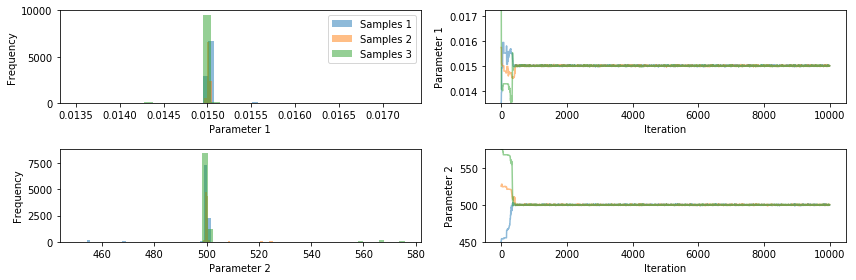

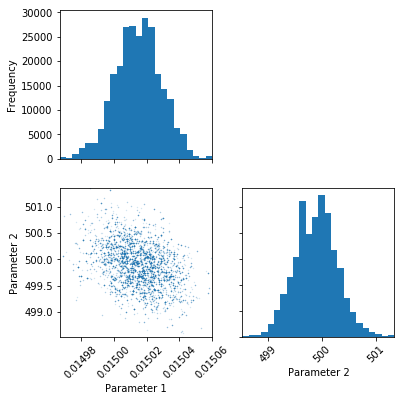

In [27]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0013383390958361, 1.0033670234842322]


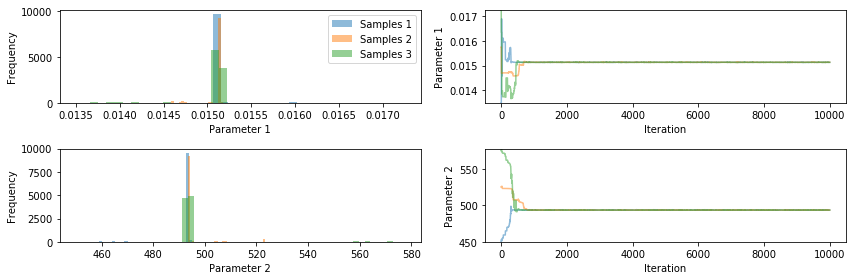

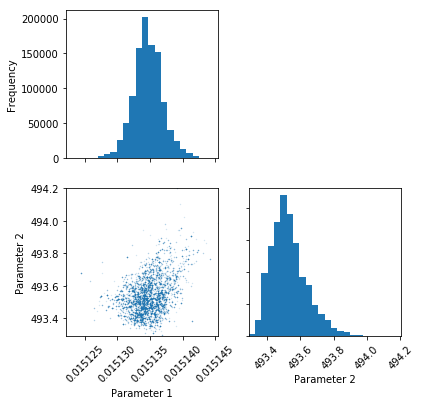

In [28]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

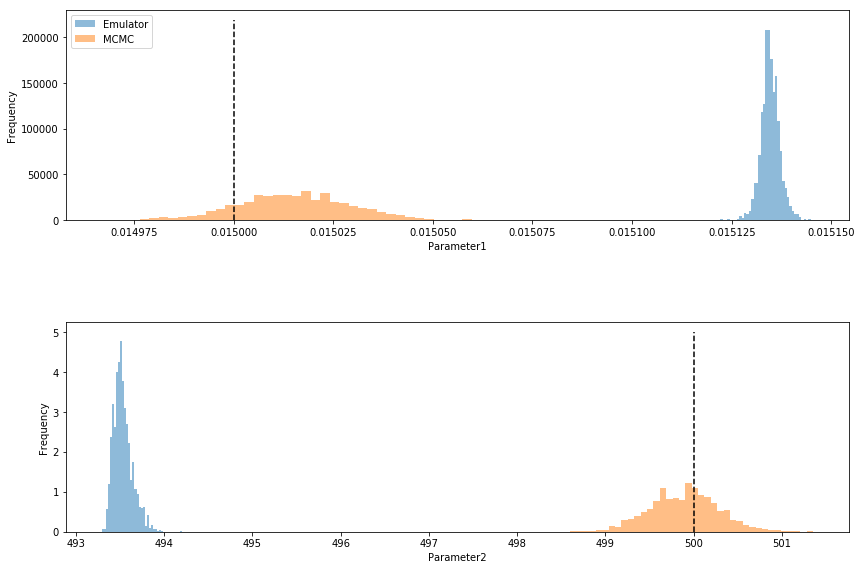

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

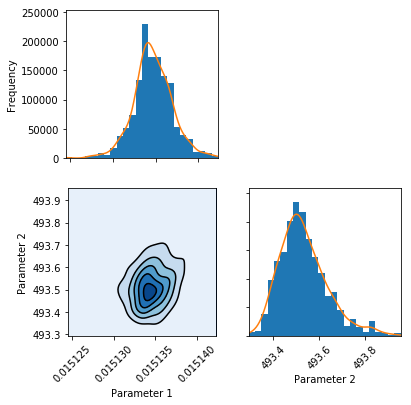

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

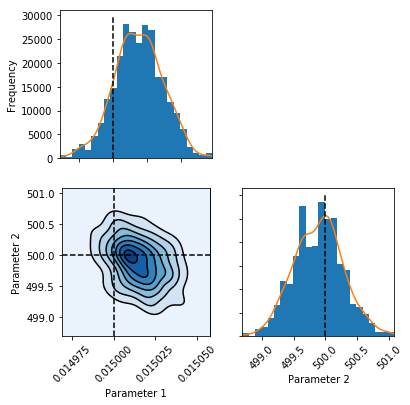

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

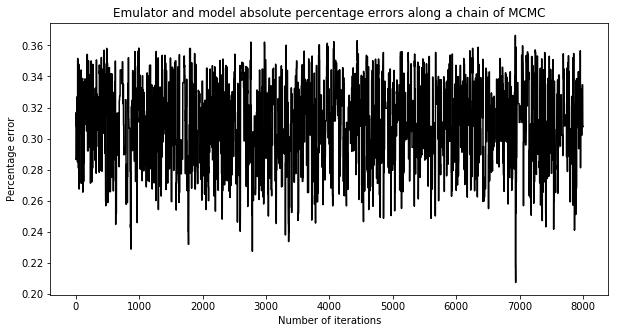

0.3089216735758763

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

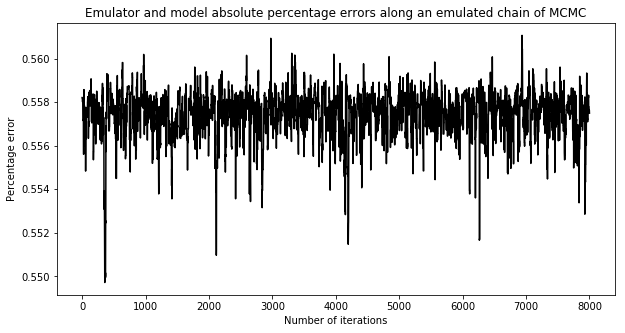

0.5574881513236934

In [34]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

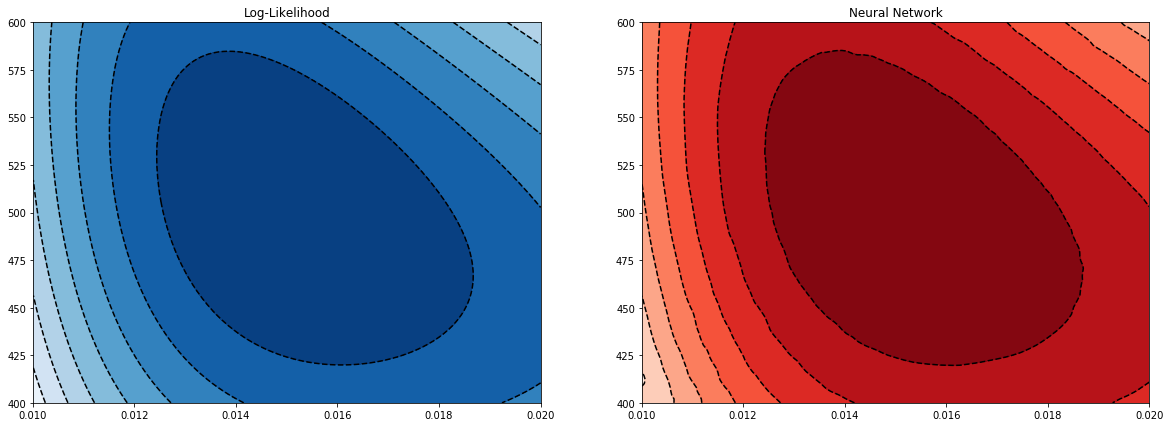

In [35]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

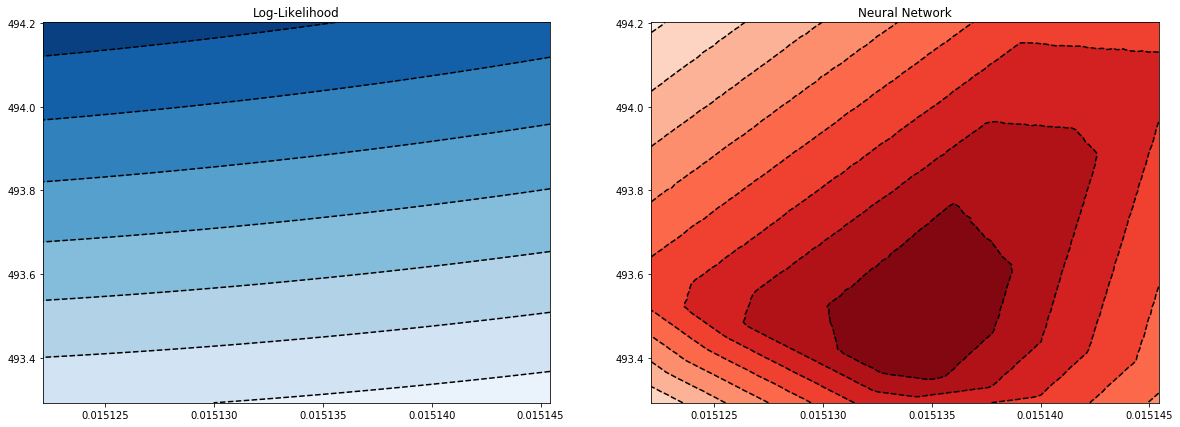

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

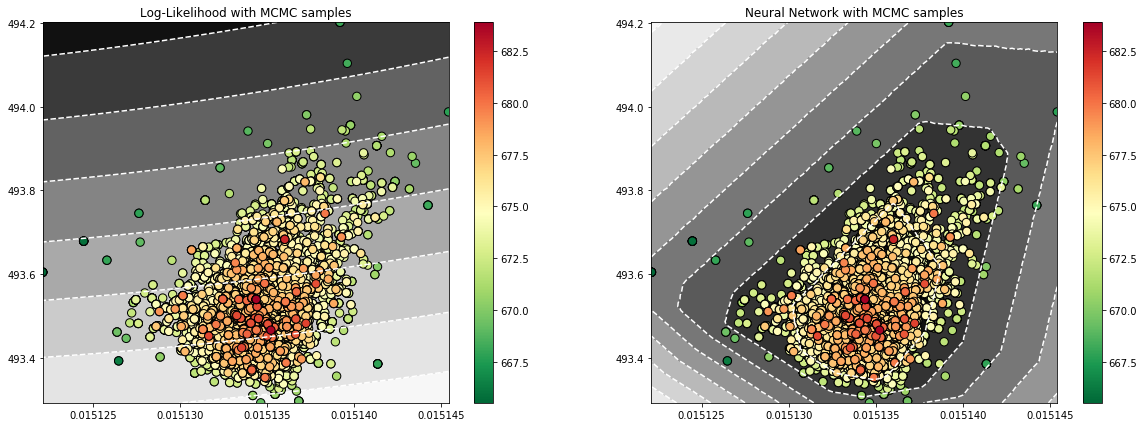

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

fig.savefig("figures/nn-test-contours-old-500-5.png", bbox_inches='tight', dpi=600)

In [40]:
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_5 (Dense)              (None, 320)               82240     
_________________________________________________________________
dense_6 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_7 (Dense)              (None, 384)               147840    
__________

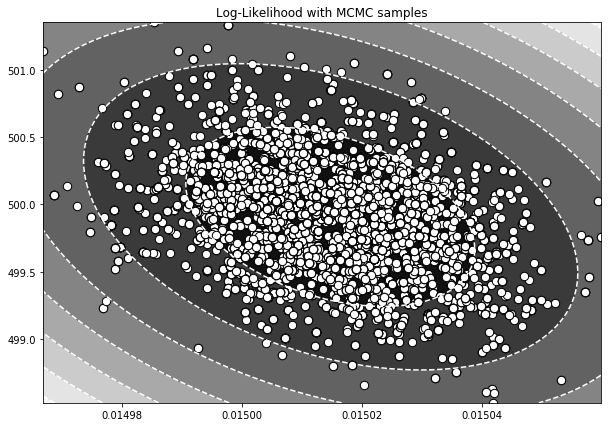

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()